In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import argparse
from collections import OrderedDict
from glob import glob
import cv2
import numpy as np
import statistics

In [3]:
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import yaml

In [4]:
from torch.optim import lr_scheduler
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
import archs
import losses
from dataset import make_loader
from metrics import RMSE
from utils import str2bool, label_maker, over_sampling, optim_maker, scheduler_maker, cm_visualize
from train_val import train, validate, validate_bestmodel, test, validate_bestmodel_restart

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from operator import itemgetter

In [7]:
ARCH_NAMES = archs.__all__
LOSS_NAMES = losses.__all__

In [8]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--check_path', default='F:/SHS_AI/', type=str)
    
    parser.add_argument('--name', default=None,
                        help='model name: (default: arch+timestamp)')
    parser.add_argument('--epochs', default=20, type=int, metavar='N',
                        help='number of total epochs to run')
    parser.add_argument('-b', '--batch_size', default=32, type=int,
                        metavar='N', help='mini-batch size (default: 16)')
    parser.add_argument('--inclusion_ratio', default=1.0, type=float,
                        help='inclusion_ratio')
    parser.add_argument('--test_ratio', default=0.1, type=float,
                        help='test_ratio')
    parser.add_argument('--over_samp_param', default=0.2, type=float,
                        help='over_samp_param')
    parser.add_argument('--fold_num', default=9, type=int,
                        help='number of fold')
    
    parser.add_argument('--restart_fold_num', default=0, type=int,
                        help='Used to resume from the midway point of cross-validation.')
    
    # model
    parser.add_argument('--arch', '-a', metavar='ARCH', default='Effnet_Erosion_CE',
                        choices=ARCH_NAMES,
                        help='model architecture: ' +
                        ' | '.join(ARCH_NAMES) +
                        ' (default: Effnet_Erosion_CE)')
    parser.add_argument('--input_channels', default=3, type=int,
                        help='input channels')
    parser.add_argument('--input_w', default=200, type=int,
                        help='image width')
    parser.add_argument('--input_h', default=120, type=int,
                        help='image height')
    
    # loss
    parser.add_argument('--loss1', default='CEL',
                        choices=LOSS_NAMES,
                        help='loss: ' +
                        ' | '.join(LOSS_NAMES) +
                        ' (default: CEL)')
    parser.add_argument('--loss2', default='kl_divergence',
                        choices=LOSS_NAMES,
                        help='loss: ' +
                        ' | '.join(LOSS_NAMES) +
                        ' (default: kl_divergence)')

    # mutual 
    parser.add_argument('--mutual', default='yes',
                        help='self_mutual_learning')
    #number_of_tasks
    parser.add_argument('--num_tasks', default=1, type=int,
                        help='number of multitask')
    #type_of_task
    parser.add_argument('--task_type', default='narrowing',
                        choices=['narrowing', 'erosion'],
                        help='Please select erosion or narrowing')
    # dataset
    parser.add_argument('--dataset', default='finger_crop_damage_prediction_erosion_large_ESPCN_add_unsup',
                        help='dataset name')
    parser.add_argument('--all_label', default='JSN_MCPfinger_full_revise_score_add_unsup.csv',
                        help='all_label name')
    parser.add_argument('--img_ext', default='.jpg',
                        help='image file extension')

    # optimizer
    parser.add_argument('--optimizer1', default='Adabound',
                        choices=['Adam', 'SGD', 'Adabound'],
                        help='loss: ' +
                        ' | '.join(['Adam', 'SGD', 'Adabound']) +
                        ' (default: Adam)')
    parser.add_argument('--optimizer2', default='Adabound',
                        choices=['Adam', 'SGD', 'Adabound'],
                        help='loss: ' +
                        ' | '.join(['Adam', 'SGD', 'Adabound']) +
                        ' (default: Adam)')
    parser.add_argument('--lr', '--learning_rate', default=5e-3, type=float,
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--momentum', default=0.9, type=float,
                        help='momentum')
    parser.add_argument('--weight_decay', default=1e-4, type=float,
                        help='weight decay')
    parser.add_argument('--nesterov', default=False, type=str2bool,
                        help='nesterov')
    

    # scheduler
    parser.add_argument('--scheduler', default='CosineAnnealingLR',
                        choices=['CosineAnnealingLR', 'ReduceLROnPlateau', 'MultiStepLR', 'ConstantLR'])
    parser.add_argument('--min_lr', default=1e-6, type=float,
                        help='minimum learning rate')
    parser.add_argument('--factor', default=0.1, type=float)
    parser.add_argument('--patience', default=3, type=int)
    
    parser.add_argument('--num_workers', default=1, type=int)
    

    """
    JSN for Radius-Trapezium-Capitate_full model
    """
    config = parser.parse_args(args=['--name', 'racam_Full','--arch', 'Effnet_JSN_CE_RA_CAM', '--dataset', 'racam', '--task_type', 'narrowing', '--all_label', 'RACAM_JSN_finger_full_score_2684.csv', '--mutual', 'yes',  '--epochs', '200', '--num_tasks', '3', '--input_w', '100', '--input_h', '100', '--over_samp_param', '0.2', '--optimizer1', 'Adabound', '--optimizer2', 'Adabound', '--scheduler', 'CosineAnnealingLR', '--inclusion_ratio', '1.0'])
    """
    JSN for CMC3-CMC4-CMC5_full model
    """
    #config = parser.parse_args(args=['--name', 'cmc_Full','--arch', 'Effnet_JSN_CE_RA_CAM', '--dataset', 'cmc', '--task_type', 'narrowing', '--all_label', 'CMC_JSN_finger_full_score_2684.csv', '--mutual', 'yes',  '--epochs', '200', '--num_tasks', '3', '--input_w', '144', '--input_h', '108', '--over_samp_param', '0.2', '--optimizer1', 'Adabound', '--optimizer2', 'Adabound', '--scheduler', 'CosineAnnealingLR', '--inclusion_ratio', '1.0'])
    """
    JSN for finger_MCP_full model
    """
    #config = parser.parse_args(args=['--name', 'finger_MCP_Full','--arch', 'Effnet_JSN_CE', '--dataset', 'finger', '--task_type', 'narrowing', '--all_label', 'JSN_MCPfinger_full_score_13420.csv', '--mutual', 'yes',  '--epochs', '200', '--num_tasks', '1', '--input_w', '144', '--input_h', '144', '--over_samp_param', '0.2', '--optimizer1', 'Adabound', '--optimizer2', 'Adabound', '--scheduler', 'CosineAnnealingLR', '--inclusion_ratio', '1.0'])
    """
    JSN for finger_PIP_full model
    """
    #config = parser.parse_args(args=['--name', 'finger_PIP_Full','--arch', 'Effnet_JSN_CE', '--dataset', 'finger', '--task_type', 'narrowing', '--all_label', 'JSN_PIPfinger_full_score_10736.csv', '--mutual', 'yes',  '--epochs', '200', '--num_tasks', '1', '--input_w', '144', '--input_h', '144', '--over_samp_param', '0.2', '--optimizer1', 'Adabound', '--optimizer2', 'Adabound', '--scheduler', 'CosineAnnealingLR', '--inclusion_ratio', '1.0'])  
    """
    Erosion for Metacarpal-Trapezium_full model
    """
    #config = parser.parse_args(args=['--name', 'mc_mul_Full','--arch', 'Effnet_Erosion_CE_MC_MUL', '--dataset', 'racam', '--task_type', 'erosion', '--all_label', 'MC_MUL_erosion_full_score_2684.csv', '--mutual', 'yes',  '--epochs', '200', '--num_tasks', '2', '--input_w', '144', '--input_h', '144', '--over_samp_param', '0.2', '--optimizer1', 'Adabound', '--optimizer2', 'Adabound', '--scheduler', 'CosineAnnealingLR', '--inclusion_ratio', '1.0'])
    """
    Erosion for Ulna-Radius_full model
    """
    #config = parser.parse_args(args=['--name', 'ulna_radi_Full','--arch', 'Effnet_Erosion_CE_MC_MUL', '--dataset', 'ulna_radi', '--task_type', 'erosion', '--all_label', 'ULN_RAD_erosion_full_score_2684.csv', '--mutual', 'yes',  '--epochs', '200', '--num_tasks', '2', '--input_w', '250', '--input_h', '120', '--over_samp_param', '0.2', '--optimizer1', 'Adabound', '--optimizer2', 'Adabound', '--scheduler', 'CosineAnnealingLR', '--inclusion_ratio', '1.0'])
    """
    Erosion for Lunate-Scaphoid_full model
    """
    #config = parser.parse_args(args=['--name', 'luna_navi_Full','--arch', 'Effnet_Erosion_CE_MC_MUL', '--dataset', 'luna_navi', '--task_type', 'erosion', '--all_label', 'Luna_Navi_erosion_full_score_2684.csv', '--mutual', 'yes',  '--epochs', '200', '--num_tasks', '2', '--input_w', '200', '--input_h', '120', '--over_samp_param', '0.2', '--optimizer1', 'Adabound', '--optimizer2', 'Adabound', '--scheduler', 'CosineAnnealingLR', '--inclusion_ratio', '1.0'])
    """
    Erosion for finger_full model
    """
    #config = parser.parse_args(args=['--name', 'finger_erosion_Full','--arch', 'Effnet_Erosion_CE', '--dataset', 'finger', '--task_type', 'erosion', '--all_label', 'JSN_Erosion_finger_full_score_26840.csv', '--mutual', 'yes',  '--epochs', '200', '--num_tasks', '1', '--input_w', '144', '--input_h', '144', '--over_samp_param', '0.2', '--optimizer1', 'Adabound', '--optimizer2', 'Adabound', '--scheduler', 'CosineAnnealingLR', '--inclusion_ratio', '1.0'])
    return config


F:/SHS_AI/damage_pred_log/models/racam_Full
--------------------
name: racam_Full
epochs: 200
batch_size: 32
inclusion_ratio: 1.0
test_ratio: 0.1
over_samp_param: 0.2
fold_num: 9
restart_fold_num: 0
arch: Effnet_JSN_CE_RA_CAM
input_channels: 3
input_w: 100
input_h: 100
loss1: CEL
loss2: kl_divergence
mutual: yes
num_tasks: 3
task_type: narrowing
dataset: racam
all_label: RACAM_JSN_finger_full_score_2684.csv
img_ext: .jpg
optimizer1: Adabound
optimizer2: Adabound
lr: 0.005
momentum: 0.9
weight_decay: 0.0001
nesterov: False
scheduler: CosineAnnealingLR
min_lr: 1e-06
factor: 0.1
patience: 3
num_workers: 1
check_path: F:/SHS_AI/
--------------------
number of images before sample reduction 2415
number of images after sample reduction 2415
number of images in train and validation  2415 , number of images in test  269
======start 0 fold-th closs validation======
before_oversampling
score0 1142
score1 222
score2 400
score3 292
score4 90
after_oversampling
score1 222
score2 400
score3 292
scor

  0%|          | 0/72 [00:00<?, ?it/s]C:\Users\suguru honda\OneDrive\Phyton\Fall_in_RA_pt\SHS_scoring_AI\damage_pred_phase\adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)
100%|██████████| 9/9 [00:02<00:00,  4.18it/s, val_loss1=3.25, val_loss2=3.08]


loss1 3.7427 - loss2 3.7563 - val_loss1 3.2496 - val_loss2 3.0777 - coef1 0.6055 - coef2 0.5835
=> saved best model1
=> saved best model2
Epoch [1/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  8.18it/s, val_loss1=2.56, val_loss2=2.29]


loss1 3.0066 - loss2 3.0374 - val_loss1 2.5582 - val_loss2 2.2918 - coef1 0.7160 - coef2 0.7649
=> saved best model1
=> saved best model2
Epoch [2/200]
lr 0.004969227007317546


100%|██████████| 9/9 [00:01<00:00,  8.20it/s, val_loss1=2.45, val_loss2=2.25]


loss1 2.8606 - loss2 2.8310 - val_loss1 2.4466 - val_loss2 2.2510 - coef1 0.7203 - coef2 0.7720
=> saved best model1
=> saved best model2
Epoch [3/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  8.25it/s, val_loss1=2.29, val_loss2=2.31]


loss1 2.6724 - loss2 2.6948 - val_loss1 2.2860 - val_loss2 2.3136 - coef1 0.7640 - coef2 0.7855
=> saved best model1
=> saved best model2
Epoch [4/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  8.13it/s, val_loss1=2.39, val_loss2=2.24]


loss1 2.6236 - loss2 2.6207 - val_loss1 2.3908 - val_loss2 2.2435 - coef1 0.7427 - coef2 0.7934
=> saved best model2
Epoch [5/200]
lr 0.004809736891511961


100%|██████████| 9/9 [00:01<00:00,  7.99it/s, val_loss1=2.23, val_loss2=2.14]


loss1 2.6067 - loss2 2.6062 - val_loss1 2.2305 - val_loss2 2.1352 - coef1 0.7937 - coef2 0.8074
=> saved best model1
=> saved best model2
Epoch [6/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  6.90it/s, val_loss1=2.3, val_loss2=2.2]  


loss1 2.5683 - loss2 2.5783 - val_loss1 2.3002 - val_loss2 2.2003 - coef1 0.7591 - coef2 0.8030
Epoch [7/200]
lr 0.004631674090803054


100%|██████████| 9/9 [00:01<00:00,  6.75it/s, val_loss1=2.2, val_loss2=2.2]  


loss1 2.5445 - loss2 2.5246 - val_loss1 2.1959 - val_loss2 2.1964 - coef1 0.7902 - coef2 0.8108
=> saved best model2
Epoch [8/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:01<00:00,  5.24it/s, val_loss1=2.11, val_loss2=2.08]


loss1 2.5240 - loss2 2.5168 - val_loss1 2.1053 - val_loss2 2.0846 - coef1 0.8029 - coef2 0.8077
=> saved best model1
Epoch [9/200]
lr 0.004401134711017278


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.13, val_loss2=2.09]


loss1 2.5102 - loss2 2.5059 - val_loss1 2.1349 - val_loss2 2.0898 - coef1 0.8023 - coef2 0.8313
=> saved best model2
Epoch [10/200]
lr 0.004267913399575776


100%|██████████| 9/9 [00:01<00:00,  5.25it/s, val_loss1=2.08, val_loss2=2.1] 


loss1 2.4259 - loss2 2.4520 - val_loss1 2.0761 - val_loss2 2.0998 - coef1 0.8073 - coef2 0.8353
=> saved best model1
=> saved best model2
Epoch [11/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  5.27it/s, val_loss1=2, val_loss2=1.98]   


loss1 2.3967 - loss2 2.4178 - val_loss1 1.9974 - val_loss2 1.9843 - coef1 0.8294 - coef2 0.8097
=> saved best model1
Epoch [12/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  5.91it/s, val_loss1=2.04, val_loss2=2.05]


loss1 2.3265 - loss2 2.3496 - val_loss1 2.0388 - val_loss2 2.0485 - coef1 0.8107 - coef2 0.8137
Epoch [13/200]
lr 0.003806485162507515


100%|██████████| 9/9 [00:01<00:00,  5.53it/s, val_loss1=1.96, val_loss2=2.83]


loss1 2.3239 - loss2 2.3711 - val_loss1 1.9604 - val_loss2 2.8279 - coef1 0.8461 - coef2 0.5448
=> saved best model1
Epoch [14/200]
lr 0.003635249254098998


100%|██████████| 9/9 [00:01<00:00,  5.85it/s, val_loss1=2.02, val_loss2=2.05]


loss1 2.3288 - loss2 2.3569 - val_loss1 2.0240 - val_loss2 2.0483 - coef1 0.8233 - coef2 0.8118
Epoch [15/200]
lr 0.003457017239196543


100%|██████████| 9/9 [00:01<00:00,  5.43it/s, val_loss1=1.98, val_loss2=2.01]


loss1 2.3091 - loss2 2.3486 - val_loss1 1.9827 - val_loss2 2.0134 - coef1 0.8163 - coef2 0.8178
Epoch [16/200]
lr 0.003272887977440182


100%|██████████| 9/9 [00:01<00:00,  5.19it/s, val_loss1=2.23, val_loss2=2.11]


loss1 2.2683 - loss2 2.2954 - val_loss1 2.2334 - val_loss2 2.1062 - coef1 0.7681 - coef2 0.7785
Epoch [17/200]
lr 0.003083996686957837


100%|██████████| 9/9 [00:01<00:00,  5.10it/s, val_loss1=1.94, val_loss2=1.96]


loss1 2.2468 - loss2 2.2865 - val_loss1 1.9436 - val_loss2 1.9599 - coef1 0.8478 - coef2 0.8547
=> saved best model1
=> saved best model2
Epoch [18/200]
lr 0.002891507945368058


100%|██████████| 9/9 [00:01<00:00,  5.07it/s, val_loss1=1.96, val_loss2=2.06]


loss1 2.2346 - loss2 2.2722 - val_loss1 1.9610 - val_loss2 2.0611 - coef1 0.8440 - coef2 0.8006
Epoch [19/200]
lr 0.002696608509771749


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.03, val_loss2=2.04]


loss1 2.2807 - loss2 2.3003 - val_loss1 2.0260 - val_loss2 2.0389 - coef1 0.8314 - coef2 0.8451
Epoch [20/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.98, val_loss2=2.02]


loss1 2.2200 - loss2 2.2510 - val_loss1 1.9789 - val_loss2 2.0225 - coef1 0.8310 - coef2 0.8452
Epoch [21/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=1.96, val_loss2=1.85]


loss1 2.1347 - loss2 2.1902 - val_loss1 1.9624 - val_loss2 1.8497 - coef1 0.8342 - coef2 0.8544
Epoch [22/200]
lr 0.002109492054631944


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=1.99, val_loss2=1.95]


loss1 2.1687 - loss2 2.2066 - val_loss1 1.9903 - val_loss2 1.9497 - coef1 0.8306 - coef2 0.8339
Epoch [23/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:02<00:00,  3.92it/s, val_loss1=1.94, val_loss2=2.01]


loss1 2.1666 - loss2 2.1755 - val_loss1 1.9440 - val_loss2 2.0117 - coef1 0.8444 - coef2 0.8053
Epoch [24/200]
lr 0.0017281120225598192


100%|██████████| 9/9 [00:02<00:00,  4.24it/s, val_loss1=1.89, val_loss2=1.97]


loss1 2.1521 - loss2 2.1959 - val_loss1 1.8872 - val_loss2 1.9686 - coef1 0.8477 - coef2 0.8032
Epoch [25/200]
lr 0.0015439827608034584


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=1.94, val_loss2=2.3] 


loss1 2.1136 - loss2 2.1560 - val_loss1 1.9422 - val_loss2 2.2963 - coef1 0.8444 - coef2 0.7354
Epoch [26/200]
lr 0.0013657507459010028


100%|██████████| 9/9 [00:01<00:00,  4.86it/s, val_loss1=1.87, val_loss2=2.16]


loss1 2.1271 - loss2 2.1846 - val_loss1 1.8725 - val_loss2 2.1581 - coef1 0.8459 - coef2 0.7904
Epoch [27/200]
lr 0.001194514837492486


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=1.89, val_loss2=1.98]


loss1 2.1187 - loss2 2.1674 - val_loss1 1.8918 - val_loss2 1.9774 - coef1 0.8435 - coef2 0.8189
Epoch [28/200]
lr 0.0010313307618949638


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.95, val_loss2=2.14]


loss1 2.1053 - loss2 2.1582 - val_loss1 1.9455 - val_loss2 2.1372 - coef1 0.8399 - coef2 0.7151
Epoch [29/200]
lr 0.0008772046031987065


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.87, val_loss2=1.99]


loss1 2.0863 - loss2 2.1698 - val_loss1 1.8653 - val_loss2 1.9943 - coef1 0.8515 - coef2 0.8009
=> saved best model1
Epoch [30/200]
lr 0.0007330866004242249


100%|██████████| 9/9 [00:02<00:00,  4.01it/s, val_loss1=1.87, val_loss2=1.96]


loss1 2.0570 - loss2 2.1186 - val_loss1 1.8670 - val_loss2 1.9568 - coef1 0.8499 - coef2 0.8141
Epoch [31/200]
lr 0.0005998652889827228


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=1.87, val_loss2=1.92]


loss1 2.0174 - loss2 2.0825 - val_loss1 1.8680 - val_loss2 1.9218 - coef1 0.8556 - coef2 0.8352
=> saved best model1
Epoch [32/200]
lr 0.0004783620225598192


100%|██████████| 9/9 [00:01<00:00,  4.91it/s, val_loss1=1.86, val_loss2=1.88]


loss1 2.0313 - loss2 2.0959 - val_loss1 1.8585 - val_loss2 1.8755 - coef1 0.8575 - coef2 0.8442
=> saved best model1
Epoch [33/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:02<00:00,  4.18it/s, val_loss1=1.84, val_loss2=1.87]


loss1 2.0426 - loss2 2.1276 - val_loss1 1.8420 - val_loss2 1.8701 - coef1 0.8578 - coef2 0.8590
=> saved best model1
=> saved best model2
Epoch [34/200]
lr 0.0002734291927911748


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.83, val_loss2=1.84]


loss1 2.0502 - loss2 2.0957 - val_loss1 1.8260 - val_loss2 1.8442 - coef1 0.8478 - coef2 0.8545
Epoch [35/200]
lr 0.00019126310848803884


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.84, val_loss2=2.04]


loss1 2.0797 - loss2 2.1092 - val_loss1 1.8441 - val_loss2 2.0352 - coef1 0.8520 - coef2 0.7883
Epoch [36/200]
lr 0.00012333423752026377


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=1.83, val_loss2=1.85]


loss1 2.0526 - loss2 2.0847 - val_loss1 1.8306 - val_loss2 1.8506 - coef1 0.8505 - coef2 0.8485
Epoch [37/200]
lr 7.006138396600746e-05


100%|██████████| 9/9 [00:01<00:00,  5.05it/s, val_loss1=1.83, val_loss2=1.97]


loss1 2.0314 - loss2 2.0691 - val_loss1 1.8286 - val_loss2 1.9674 - coef1 0.8511 - coef2 0.8166
Epoch [38/200]
lr 3.177299268245342e-05


100%|██████████| 9/9 [00:02<00:00,  4.13it/s, val_loss1=1.82, val_loss2=1.78]


loss1 2.0476 - loss2 2.0656 - val_loss1 1.8250 - val_loss2 1.7778 - coef1 0.8545 - coef2 0.8578
Epoch [39/200]
lr 8.705124334046657e-06


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.83, val_loss2=1.88]


loss1 2.0531 - loss2 2.0638 - val_loss1 1.8296 - val_loss2 1.8840 - coef1 0.8506 - coef2 0.8413
Epoch [40/200]
lr 1e-06


100%|██████████| 9/9 [00:02<00:00,  4.24it/s, val_loss1=1.84, val_loss2=1.77]


loss1 2.0221 - loss2 2.0176 - val_loss1 1.8428 - val_loss2 1.7728 - coef1 0.8466 - coef2 0.8489
Epoch [41/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.84, val_loss2=1.9] 


loss1 2.0300 - loss2 2.0673 - val_loss1 1.8445 - val_loss2 1.8997 - coef1 0.8497 - coef2 0.8418
Epoch [42/200]
lr 3.177299268245425e-05


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=1.82, val_loss2=1.85]


loss1 2.0457 - loss2 2.0590 - val_loss1 1.8249 - val_loss2 1.8536 - coef1 0.8553 - coef2 0.8394
Epoch [43/200]
lr 7.006138396600965e-05


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.83, val_loss2=1.83]


loss1 2.0296 - loss2 2.0104 - val_loss1 1.8319 - val_loss2 1.8312 - coef1 0.8496 - coef2 0.8445
Epoch [44/200]
lr 0.0001233342375202676


100%|██████████| 9/9 [00:02<00:00,  4.25it/s, val_loss1=1.83, val_loss2=1.93]


loss1 2.0319 - loss2 2.0235 - val_loss1 1.8315 - val_loss2 1.9286 - coef1 0.8514 - coef2 0.8348
Epoch [45/200]
lr 0.00019126310848804537


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=1.83, val_loss2=1.9] 


loss1 2.0341 - loss2 2.0261 - val_loss1 1.8280 - val_loss2 1.9041 - coef1 0.8576 - coef2 0.8537
Epoch [46/200]
lr 0.0002734291927911843


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=1.83, val_loss2=1.84]


loss1 2.0156 - loss2 1.9764 - val_loss1 1.8314 - val_loss2 1.8380 - coef1 0.8503 - coef2 0.8367
Epoch [47/200]
lr 0.00036932590919696017


100%|██████████| 9/9 [00:01<00:00,  5.16it/s, val_loss1=1.85, val_loss2=1.82]


loss1 2.0316 - loss2 1.9882 - val_loss1 1.8549 - val_loss2 1.8227 - coef1 0.8542 - coef2 0.8684
=> saved best model2
Epoch [48/200]
lr 0.0004783620225598361


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=1.84, val_loss2=1.85]


loss1 2.0135 - loss2 1.9567 - val_loss1 1.8430 - val_loss2 1.8505 - coef1 0.8470 - coef2 0.8511
Epoch [49/200]
lr 0.0005998652889827432


100%|██████████| 9/9 [00:02<00:00,  3.90it/s, val_loss1=1.83, val_loss2=1.8] 


loss1 2.0302 - loss2 1.9621 - val_loss1 1.8291 - val_loss2 1.8013 - coef1 0.8585 - coef2 0.8515
=> saved best model1
Epoch [50/200]
lr 0.0007330866004242504


100%|██████████| 9/9 [00:02<00:00,  4.27it/s, val_loss1=1.85, val_loss2=1.87]


loss1 2.0020 - loss2 1.9684 - val_loss1 1.8484 - val_loss2 1.8740 - coef1 0.8612 - coef2 0.8448
=> saved best model1
Epoch [51/200]
lr 0.0008772046031987364


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.84, val_loss2=2.08]


loss1 2.0421 - loss2 1.9772 - val_loss1 1.8429 - val_loss2 2.0808 - coef1 0.8522 - coef2 0.7934
Epoch [52/200]
lr 0.001031330761895


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=1.83, val_loss2=1.82]


loss1 2.0301 - loss2 1.9585 - val_loss1 1.8316 - val_loss2 1.8227 - coef1 0.8607 - coef2 0.8456
Epoch [53/200]
lr 0.0011945148374925294


100%|██████████| 9/9 [00:02<00:00,  4.27it/s, val_loss1=1.94, val_loss2=1.98]


loss1 2.0339 - loss2 1.9557 - val_loss1 1.9378 - val_loss2 1.9765 - coef1 0.8472 - coef2 0.8010
Epoch [54/200]
lr 0.0013657507459010514


100%|██████████| 9/9 [00:02<00:00,  4.00it/s, val_loss1=1.86, val_loss2=1.78]


loss1 1.9932 - loss2 1.9082 - val_loss1 1.8634 - val_loss2 1.7753 - coef1 0.8510 - coef2 0.8665
Epoch [55/200]
lr 0.0015439827608035143


100%|██████████| 9/9 [00:02<00:00,  4.26it/s, val_loss1=1.85, val_loss2=1.78]


loss1 2.0438 - loss2 1.9672 - val_loss1 1.8473 - val_loss2 1.7846 - coef1 0.8524 - coef2 0.8626
Epoch [56/200]
lr 0.0017281120225598808


100%|██████████| 9/9 [00:02<00:00,  4.15it/s, val_loss1=1.84, val_loss2=1.91]


loss1 2.0264 - loss2 1.9181 - val_loss1 1.8374 - val_loss2 1.9144 - coef1 0.8586 - coef2 0.8502
Epoch [57/200]
lr 0.0019170033130422321


100%|██████████| 9/9 [00:02<00:00,  3.85it/s, val_loss1=1.83, val_loss2=1.83]


loss1 2.0199 - loss2 1.9433 - val_loss1 1.8340 - val_loss2 1.8315 - coef1 0.8654 - coef2 0.8595
=> saved best model1
Epoch [58/200]
lr 0.0021094920546320187


100%|██████████| 9/9 [00:02<00:00,  3.92it/s, val_loss1=1.92, val_loss2=1.83]


loss1 2.0179 - loss2 1.9380 - val_loss1 1.9210 - val_loss2 1.8287 - coef1 0.8494 - coef2 0.8637
Epoch [59/200]
lr 0.0023043914902283334


100%|██████████| 9/9 [00:02<00:00,  4.28it/s, val_loss1=1.9, val_loss2=1.76] 


loss1 1.9929 - loss2 1.8940 - val_loss1 1.9029 - val_loss2 1.7620 - coef1 0.8413 - coef2 0.8590
Epoch [60/200]
lr 0.00250050000000009


100%|██████████| 9/9 [00:01<00:00,  5.49it/s, val_loss1=1.82, val_loss2=1.75]


loss1 2.0482 - loss2 1.9091 - val_loss1 1.8153 - val_loss2 1.7459 - coef1 0.8649 - coef2 0.8763
=> saved best model2
Epoch [61/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.84, val_loss2=1.79]


loss1 2.0559 - loss2 1.9567 - val_loss1 1.8447 - val_loss2 1.7879 - coef1 0.8583 - coef2 0.8541
Epoch [62/200]
lr 0.0028915079453681615


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.9, val_loss2=1.8]  


loss1 2.0486 - loss2 1.9071 - val_loss1 1.9014 - val_loss2 1.7954 - coef1 0.8508 - coef2 0.8704
Epoch [63/200]
lr 0.0030839966869579483


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=2.02, val_loss2=1.8] 


loss1 1.9941 - loss2 1.8904 - val_loss1 2.0242 - val_loss2 1.8009 - coef1 0.8425 - coef2 0.8693
Epoch [64/200]
lr 0.003272887977440299


100%|██████████| 9/9 [00:01<00:00,  4.92it/s, val_loss1=1.96, val_loss2=1.8] 


loss1 2.0604 - loss2 1.9364 - val_loss1 1.9621 - val_loss2 1.8046 - coef1 0.8311 - coef2 0.8705
Epoch [65/200]
lr 0.0034570172391966652


100%|██████████| 9/9 [00:01<00:00,  5.39it/s, val_loss1=1.9, val_loss2=1.82] 


loss1 2.0202 - loss2 1.9079 - val_loss1 1.9023 - val_loss2 1.8243 - coef1 0.8567 - coef2 0.8600
Epoch [66/200]
lr 0.003635249254099128


100%|██████████| 9/9 [00:02<00:00,  4.26it/s, val_loss1=1.9, val_loss2=1.82] 


loss1 2.0961 - loss2 1.9172 - val_loss1 1.9019 - val_loss2 1.8227 - coef1 0.8597 - coef2 0.8684
Epoch [67/200]
lr 0.0038064851625076498


100%|██████████| 9/9 [00:02<00:00,  4.09it/s, val_loss1=2.1, val_loss2=1.8]  


loss1 2.0281 - loss2 1.8950 - val_loss1 2.1009 - val_loss2 1.7952 - coef1 0.8315 - coef2 0.8713
Epoch [68/200]
lr 0.003969669238105178


100%|██████████| 9/9 [00:02<00:00,  4.27it/s, val_loss1=1.87, val_loss2=1.81]


loss1 2.0391 - loss2 1.8987 - val_loss1 1.8697 - val_loss2 1.8130 - coef1 0.8456 - coef2 0.8453
Epoch [69/200]
lr 0.004123795396801443


100%|██████████| 9/9 [00:02<00:00,  4.20it/s, val_loss1=1.79, val_loss2=1.8] 


loss1 2.0366 - loss2 1.9044 - val_loss1 1.7897 - val_loss2 1.7997 - coef1 0.8546 - coef2 0.8557
Epoch [70/200]
lr 0.004267913399575929


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.94, val_loss2=1.89]


loss1 2.0231 - loss2 1.8847 - val_loss1 1.9413 - val_loss2 1.8856 - coef1 0.8397 - coef2 0.8521
Epoch [71/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.93, val_loss2=2]   


loss1 2.0609 - loss2 1.9043 - val_loss1 1.9258 - val_loss2 2.0035 - coef1 0.8475 - coef2 0.8273
Epoch [72/200]
lr 0.004522637977440344


100%|██████████| 9/9 [00:02<00:00,  4.31it/s, val_loss1=1.88, val_loss2=1.81]


loss1 2.0952 - loss2 1.9226 - val_loss1 1.8751 - val_loss2 1.8123 - coef1 0.8548 - coef2 0.8639
Epoch [73/200]
lr 0.00463167409080322


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=1.82, val_loss2=1.72]


loss1 2.0473 - loss2 1.9148 - val_loss1 1.8230 - val_loss2 1.7200 - coef1 0.8586 - coef2 0.8808
=> saved best model2
Epoch [74/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.01, val_loss2=2.03]


loss1 2.0646 - loss2 1.9028 - val_loss1 2.0150 - val_loss2 2.0341 - coef1 0.8145 - coef2 0.8291
Epoch [75/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2, val_loss2=1.7]    


loss1 2.0776 - loss2 1.9522 - val_loss1 1.9992 - val_loss2 1.7024 - coef1 0.8190 - coef2 0.8598
Epoch [76/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=1.83, val_loss2=1.85]


loss1 2.0205 - loss2 1.9024 - val_loss1 1.8266 - val_loss2 1.8538 - coef1 0.8533 - coef2 0.8576
Epoch [77/200]
lr 0.004930938616034172


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=1.85, val_loss2=1.82]


loss1 2.0504 - loss2 1.9071 - val_loss1 1.8460 - val_loss2 1.8236 - coef1 0.8520 - coef2 0.8706
Epoch [78/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  4.91it/s, val_loss1=1.94, val_loss2=1.93]


loss1 2.0549 - loss2 1.8735 - val_loss1 1.9436 - val_loss2 1.9316 - coef1 0.8410 - coef2 0.8401
Epoch [79/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:02<00:00,  4.30it/s, val_loss1=1.97, val_loss2=1.75]


loss1 1.9956 - loss2 1.8616 - val_loss1 1.9728 - val_loss2 1.7519 - coef1 0.8352 - coef2 0.8697
Epoch [80/200]
lr 0.005000000000000181


100%|██████████| 9/9 [00:01<00:00,  5.23it/s, val_loss1=1.83, val_loss2=1.92]


loss1 2.0324 - loss2 1.8770 - val_loss1 1.8330 - val_loss2 1.9216 - coef1 0.8364 - coef2 0.8232
Epoch [81/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=2.09, val_loss2=1.68]


loss1 1.9767 - loss2 1.8486 - val_loss1 2.0940 - val_loss2 1.6832 - coef1 0.8300 - coef2 0.8812
=> saved best model2
Epoch [82/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.8, val_loss2=1.81] 


loss1 2.0193 - loss2 1.8562 - val_loss1 1.8000 - val_loss2 1.8098 - coef1 0.8529 - coef2 0.8564
Epoch [83/200]
lr 0.004930938616034171


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=2.04, val_loss2=1.82]


loss1 1.9615 - loss2 1.8078 - val_loss1 2.0384 - val_loss2 1.8204 - coef1 0.8006 - coef2 0.8531
Epoch [84/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:02<00:00,  4.00it/s, val_loss1=1.85, val_loss2=1.82]


loss1 1.9859 - loss2 1.8433 - val_loss1 1.8453 - val_loss2 1.8174 - coef1 0.8703 - coef2 0.8687
=> saved best model1
Epoch [85/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  5.10it/s, val_loss1=1.89, val_loss2=1.72]


loss1 1.9449 - loss2 1.8201 - val_loss1 1.8858 - val_loss2 1.7205 - coef1 0.8720 - coef2 0.8660
=> saved best model1
Epoch [86/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=1.86, val_loss2=1.76]


loss1 1.9202 - loss2 1.7998 - val_loss1 1.8626 - val_loss2 1.7596 - coef1 0.8479 - coef2 0.8707
Epoch [87/200]
lr 0.004631674090803221


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.95, val_loss2=1.78]


loss1 1.9137 - loss2 1.8023 - val_loss1 1.9470 - val_loss2 1.7781 - coef1 0.8320 - coef2 0.8451
Epoch [88/200]
lr 0.004522637977440346


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.76, val_loss2=1.67]


loss1 1.9026 - loss2 1.7892 - val_loss1 1.7574 - val_loss2 1.6707 - coef1 0.8760 - coef2 0.8759
=> saved best model1
Epoch [89/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.79, val_loss2=1.78]


loss1 1.9375 - loss2 1.7989 - val_loss1 1.7939 - val_loss2 1.7847 - coef1 0.8562 - coef2 0.8648
Epoch [90/200]
lr 0.00426791339957593


100%|██████████| 9/9 [00:01<00:00,  5.13it/s, val_loss1=1.8, val_loss2=1.68] 


loss1 1.8981 - loss2 1.8112 - val_loss1 1.7998 - val_loss2 1.6822 - coef1 0.8516 - coef2 0.8731
Epoch [91/200]
lr 0.004123795396801445


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=1.78, val_loss2=1.74]


loss1 1.8406 - loss2 1.7923 - val_loss1 1.7816 - val_loss2 1.7392 - coef1 0.8742 - coef2 0.8794
Epoch [92/200]
lr 0.003969669238105182


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.66, val_loss2=1.82]


loss1 1.8268 - loss2 1.7653 - val_loss1 1.6608 - val_loss2 1.8170 - coef1 0.8977 - coef2 0.8549
=> saved best model1
Epoch [93/200]
lr 0.003806485162507654


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.76, val_loss2=1.87]


loss1 1.8336 - loss2 1.7646 - val_loss1 1.7637 - val_loss2 1.8683 - coef1 0.8657 - coef2 0.8388
Epoch [94/200]
lr 0.0036352492540991286


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=1.87, val_loss2=1.64]


loss1 1.8306 - loss2 1.7324 - val_loss1 1.8711 - val_loss2 1.6449 - coef1 0.8634 - coef2 0.8806
Epoch [95/200]
lr 0.0034570172391966674


100%|██████████| 9/9 [00:01<00:00,  5.17it/s, val_loss1=1.75, val_loss2=1.72]


loss1 1.7628 - loss2 1.6992 - val_loss1 1.7524 - val_loss2 1.7218 - coef1 0.8731 - coef2 0.8694
Epoch [96/200]
lr 0.003272887977440301


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.73, val_loss2=1.66]


loss1 1.7565 - loss2 1.7031 - val_loss1 1.7252 - val_loss2 1.6551 - coef1 0.8664 - coef2 0.8871
=> saved best model2
Epoch [97/200]
lr 0.00308399668695795


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.75, val_loss2=1.72]


loss1 1.7663 - loss2 1.7206 - val_loss1 1.7462 - val_loss2 1.7226 - coef1 0.8666 - coef2 0.8689
Epoch [98/200]
lr 0.0028915079453681655


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.68, val_loss2=1.71]


loss1 1.7484 - loss2 1.7072 - val_loss1 1.6838 - val_loss2 1.7088 - coef1 0.8844 - coef2 0.8686
Epoch [99/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.82, val_loss2=1.72]


loss1 1.7426 - loss2 1.7267 - val_loss1 1.8164 - val_loss2 1.7207 - coef1 0.8632 - coef2 0.8817
Epoch [100/200]
lr 0.002500500000000092


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=1.72, val_loss2=1.71]


loss1 1.7071 - loss2 1.6867 - val_loss1 1.7236 - val_loss2 1.7113 - coef1 0.8675 - coef2 0.8720
Epoch [101/200]
lr 0.0023043914902283356


100%|██████████| 9/9 [00:01<00:00,  5.24it/s, val_loss1=1.7, val_loss2=1.77] 


loss1 1.6237 - loss2 1.6667 - val_loss1 1.6975 - val_loss2 1.7714 - coef1 0.8839 - coef2 0.8748
Epoch [102/200]
lr 0.0021094920546320234


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.72, val_loss2=1.75]


loss1 1.6784 - loss2 1.6847 - val_loss1 1.7168 - val_loss2 1.7526 - coef1 0.8816 - coef2 0.8715
Epoch [103/200]
lr 0.0019170033130422365


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=1.73, val_loss2=1.71]


loss1 1.6056 - loss2 1.6430 - val_loss1 1.7305 - val_loss2 1.7148 - coef1 0.8736 - coef2 0.8735
Epoch [104/200]
lr 0.001728112022559883


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=1.7, val_loss2=1.65] 


loss1 1.6249 - loss2 1.6696 - val_loss1 1.7007 - val_loss2 1.6533 - coef1 0.8870 - coef2 0.8794
Epoch [105/200]
lr 0.0015439827608035145


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.7, val_loss2=1.69] 


loss1 1.6014 - loss2 1.6599 - val_loss1 1.7001 - val_loss2 1.6925 - coef1 0.8861 - coef2 0.8755
Epoch [106/200]
lr 0.0013657507459010516


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.69, val_loss2=1.76]


loss1 1.5985 - loss2 1.6341 - val_loss1 1.6913 - val_loss2 1.7565 - coef1 0.8893 - coef2 0.8820
Epoch [107/200]
lr 0.001194514837492531


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.69, val_loss2=1.68]


loss1 1.6330 - loss2 1.6823 - val_loss1 1.6941 - val_loss2 1.6822 - coef1 0.8870 - coef2 0.8685
Epoch [108/200]
lr 0.0010313307618950017


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=1.74, val_loss2=1.89]


loss1 1.5991 - loss2 1.6729 - val_loss1 1.7400 - val_loss2 1.8932 - coef1 0.8788 - coef2 0.8639
Epoch [109/200]
lr 0.0008772046031987413


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.72, val_loss2=1.89]


loss1 1.5734 - loss2 1.6484 - val_loss1 1.7208 - val_loss2 1.8922 - coef1 0.8895 - coef2 0.8505
Epoch [110/200]
lr 0.0007330866004242506


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.68, val_loss2=1.91]


loss1 1.6240 - loss2 1.7014 - val_loss1 1.6814 - val_loss2 1.9126 - coef1 0.8896 - coef2 0.8390
Epoch [111/200]
lr 0.0005998652889827459


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.69, val_loss2=1.84]


loss1 1.5627 - loss2 1.6665 - val_loss1 1.6887 - val_loss2 1.8440 - coef1 0.8924 - coef2 0.8618
Epoch [112/200]
lr 0.00047836202255983705


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.67, val_loss2=1.9] 


loss1 1.5655 - loss2 1.6675 - val_loss1 1.6729 - val_loss2 1.8956 - coef1 0.8915 - coef2 0.8490
Epoch [113/200]
lr 0.00036932590919695995


100%|██████████| 9/9 [00:01<00:00,  5.10it/s, val_loss1=1.68, val_loss2=1.78]


loss1 1.5602 - loss2 1.6821 - val_loss1 1.6831 - val_loss2 1.7799 - coef1 0.8962 - coef2 0.8890
=> saved best model2
Epoch [114/200]
lr 0.0002734291927911859


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.69, val_loss2=1.74]


loss1 1.5223 - loss2 1.6150 - val_loss1 1.6860 - val_loss2 1.7401 - coef1 0.8920 - coef2 0.8722
Epoch [115/200]
lr 0.00019126310848804472


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=1.68, val_loss2=1.93]


loss1 1.5330 - loss2 1.6327 - val_loss1 1.6806 - val_loss2 1.9264 - coef1 0.8890 - coef2 0.8544
Epoch [116/200]
lr 0.00012333423752026854


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.7, val_loss2=1.68] 


loss1 1.5341 - loss2 1.6306 - val_loss1 1.7008 - val_loss2 1.6798 - coef1 0.8872 - coef2 0.8870
Epoch [117/200]
lr 7.006138396600972e-05


100%|██████████| 9/9 [00:01<00:00,  5.57it/s, val_loss1=1.67, val_loss2=1.73]


loss1 1.5205 - loss2 1.6469 - val_loss1 1.6736 - val_loss2 1.7315 - coef1 0.8894 - coef2 0.8616
Epoch [118/200]
lr 3.177299268245483e-05


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.69, val_loss2=1.66]


loss1 1.4956 - loss2 1.5724 - val_loss1 1.6862 - val_loss2 1.6610 - coef1 0.8868 - coef2 0.8696
Epoch [119/200]
lr 8.70512433404694e-06


100%|██████████| 9/9 [00:02<00:00,  4.31it/s, val_loss1=1.68, val_loss2=1.64]


loss1 1.5263 - loss2 1.6254 - val_loss1 1.6786 - val_loss2 1.6418 - coef1 0.8910 - coef2 0.8877
Epoch [120/200]
lr 1e-06


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.68, val_loss2=1.76]


loss1 1.5017 - loss2 1.5715 - val_loss1 1.6807 - val_loss2 1.7598 - coef1 0.8923 - coef2 0.8759
Epoch [121/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=1.69, val_loss2=1.7] 


loss1 1.5150 - loss2 1.5601 - val_loss1 1.6906 - val_loss2 1.6957 - coef1 0.8876 - coef2 0.8720
Epoch [122/200]
lr 3.1772992682453416e-05


100%|██████████| 9/9 [00:01<00:00,  5.23it/s, val_loss1=1.68, val_loss2=1.7] 


loss1 1.4984 - loss2 1.5438 - val_loss1 1.6809 - val_loss2 1.7026 - coef1 0.8897 - coef2 0.8903
=> saved best model2
Epoch [123/200]
lr 7.006138396600689e-05


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=1.69, val_loss2=1.69]


loss1 1.4790 - loss2 1.5365 - val_loss1 1.6901 - val_loss2 1.6856 - coef1 0.8913 - coef2 0.8851
Epoch [124/200]
lr 0.00012333423752026348


100%|██████████| 9/9 [00:02<00:00,  4.20it/s, val_loss1=1.68, val_loss2=1.64]


loss1 1.4876 - loss2 1.5342 - val_loss1 1.6849 - val_loss2 1.6363 - coef1 0.8936 - coef2 0.8941
=> saved best model2
Epoch [125/200]
lr 0.00019126310848803716


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=1.7, val_loss2=1.74] 


loss1 1.5091 - loss2 1.5515 - val_loss1 1.6981 - val_loss2 1.7366 - coef1 0.8877 - coef2 0.8706
Epoch [126/200]
lr 0.00027342919279117506


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.7, val_loss2=1.69] 


loss1 1.4705 - loss2 1.5087 - val_loss1 1.7011 - val_loss2 1.6873 - coef1 0.8806 - coef2 0.8844
Epoch [127/200]
lr 0.00036932590919694553


100%|██████████| 9/9 [00:01<00:00,  5.24it/s, val_loss1=1.7, val_loss2=1.75] 


loss1 1.4882 - loss2 1.5327 - val_loss1 1.7047 - val_loss2 1.7517 - coef1 0.8788 - coef2 0.8674
Epoch [128/200]
lr 0.00047836202255981835


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=1.69, val_loss2=1.76]


loss1 1.5320 - loss2 1.5484 - val_loss1 1.6899 - val_loss2 1.7566 - coef1 0.8982 - coef2 0.8733
=> saved best model1
Epoch [129/200]
lr 0.0005998652889827227


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.71, val_loss2=1.74]


loss1 1.5183 - loss2 1.5537 - val_loss1 1.7074 - val_loss2 1.7399 - coef1 0.8828 - coef2 0.8867
Epoch [130/200]
lr 0.0007330866004242223


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=1.69, val_loss2=1.74]


loss1 1.4982 - loss2 1.5136 - val_loss1 1.6901 - val_loss2 1.7391 - coef1 0.8963 - coef2 0.8747
Epoch [131/200]
lr 0.0008772046031987078


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=1.66, val_loss2=1.65]


loss1 1.5484 - loss2 1.5434 - val_loss1 1.6639 - val_loss2 1.6524 - coef1 0.8887 - coef2 0.8904
Epoch [132/200]
lr 0.0010313307618949627


100%|██████████| 9/9 [00:01<00:00,  5.35it/s, val_loss1=1.74, val_loss2=1.67]


loss1 1.5164 - loss2 1.4942 - val_loss1 1.7400 - val_loss2 1.6652 - coef1 0.8888 - coef2 0.8918
Epoch [133/200]
lr 0.0011945148374924862


100%|██████████| 9/9 [00:02<00:00,  3.97it/s, val_loss1=1.73, val_loss2=1.7] 


loss1 1.4857 - loss2 1.4832 - val_loss1 1.7268 - val_loss2 1.7026 - coef1 0.8911 - coef2 0.8738
Epoch [134/200]
lr 0.001365750745901


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.7, val_loss2=1.7]  


loss1 1.5309 - loss2 1.5021 - val_loss1 1.6959 - val_loss2 1.7008 - coef1 0.8838 - coef2 0.8889
Epoch [135/200]
lr 0.0015439827608034564


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=1.76, val_loss2=1.64]


loss1 1.5259 - loss2 1.4921 - val_loss1 1.7578 - val_loss2 1.6394 - coef1 0.8809 - coef2 0.8785
Epoch [136/200]
lr 0.0017281120225598181


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=1.82, val_loss2=1.63]


loss1 1.5472 - loss2 1.4721 - val_loss1 1.8216 - val_loss2 1.6312 - coef1 0.8625 - coef2 0.8846
Epoch [137/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.8, val_loss2=1.63] 


loss1 1.5401 - loss2 1.4865 - val_loss1 1.7989 - val_loss2 1.6325 - coef1 0.8586 - coef2 0.8905
Epoch [138/200]
lr 0.002109492054631945


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=1.74, val_loss2=1.69]


loss1 1.5231 - loss2 1.4262 - val_loss1 1.7439 - val_loss2 1.6925 - coef1 0.8768 - coef2 0.8768
Epoch [139/200]
lr 0.0023043914902282506


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=1.65, val_loss2=1.77]


loss1 1.5590 - loss2 1.4501 - val_loss1 1.6527 - val_loss2 1.7710 - coef1 0.8893 - coef2 0.8670
Epoch [140/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=1.76, val_loss2=1.75]


loss1 1.5931 - loss2 1.4761 - val_loss1 1.7577 - val_loss2 1.7475 - coef1 0.8851 - coef2 0.8695
Epoch [141/200]
lr 0.0026966085097717457


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.69, val_loss2=1.74]


loss1 1.6105 - loss2 1.4623 - val_loss1 1.6930 - val_loss2 1.7446 - coef1 0.8880 - coef2 0.8698
Epoch [142/200]
lr 0.0028915079453680596


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.9, val_loss2=1.73] 


loss1 1.6010 - loss2 1.4555 - val_loss1 1.9020 - val_loss2 1.7263 - coef1 0.8616 - coef2 0.8515
Epoch [143/200]
lr 0.003083996686957835


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.84, val_loss2=1.75]


loss1 1.6255 - loss2 1.4988 - val_loss1 1.8382 - val_loss2 1.7531 - coef1 0.8575 - coef2 0.8734
Epoch [144/200]
lr 0.0032728879774401817


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.98, val_loss2=1.75]


loss1 1.6131 - loss2 1.4632 - val_loss1 1.9768 - val_loss2 1.7471 - coef1 0.8135 - coef2 0.8731
Epoch [145/200]
lr 0.0034570172391965442


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.84, val_loss2=1.79]


loss1 1.6507 - loss2 1.4626 - val_loss1 1.8436 - val_loss2 1.7869 - coef1 0.8516 - coef2 0.8660
Epoch [146/200]
lr 0.0036352492540989963


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.94, val_loss2=1.76]


loss1 1.6916 - loss2 1.4592 - val_loss1 1.9355 - val_loss2 1.7566 - coef1 0.8517 - coef2 0.8786
Epoch [147/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.79, val_loss2=1.62]


loss1 1.6810 - loss2 1.4522 - val_loss1 1.7931 - val_loss2 1.6224 - coef1 0.8708 - coef2 0.8801
Epoch [148/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.99, val_loss2=1.76]


loss1 1.7015 - loss2 1.4698 - val_loss1 1.9944 - val_loss2 1.7564 - coef1 0.8285 - coef2 0.8793
Epoch [149/200]
lr 0.004123795396801296


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.8, val_loss2=1.74] 


loss1 1.7637 - loss2 1.5120 - val_loss1 1.7976 - val_loss2 1.7441 - coef1 0.8564 - coef2 0.8619
Epoch [150/200]
lr 0.004267913399575775


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=2.44, val_loss2=1.66]


loss1 1.6925 - loss2 1.4360 - val_loss1 2.4432 - val_loss2 1.6577 - coef1 0.7832 - coef2 0.8752
Epoch [151/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.81, val_loss2=1.76]


loss1 1.7178 - loss2 1.5004 - val_loss1 1.8074 - val_loss2 1.7560 - coef1 0.8730 - coef2 0.8747
Epoch [152/200]
lr 0.004522637977440181


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.97, val_loss2=1.67]


loss1 1.7381 - loss2 1.4741 - val_loss1 1.9655 - val_loss2 1.6652 - coef1 0.8643 - coef2 0.8713
Epoch [153/200]
lr 0.004631674090803055


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.98, val_loss2=1.78]


loss1 1.7917 - loss2 1.5049 - val_loss1 1.9825 - val_loss2 1.7818 - coef1 0.8391 - coef2 0.8324
Epoch [154/200]
lr 0.004727570807208827


100%|██████████| 9/9 [00:01<00:00,  5.16it/s, val_loss1=1.86, val_loss2=1.68]


loss1 1.8165 - loss2 1.4952 - val_loss1 1.8615 - val_loss2 1.6785 - coef1 0.8589 - coef2 0.8730
Epoch [155/200]
lr 0.004809736891511962


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.96, val_loss2=1.79]


loss1 1.7763 - loss2 1.4864 - val_loss1 1.9643 - val_loss2 1.7855 - coef1 0.8396 - coef2 0.8547
Epoch [156/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.89, val_loss2=1.77]


loss1 1.7726 - loss2 1.5162 - val_loss1 1.8896 - val_loss2 1.7714 - coef1 0.8649 - coef2 0.8619
Epoch [157/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=2.05, val_loss2=1.68]


loss1 1.7728 - loss2 1.4890 - val_loss1 2.0521 - val_loss2 1.6759 - coef1 0.8333 - coef2 0.8803
Epoch [158/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.83, val_loss2=1.68]


loss1 1.7438 - loss2 1.4364 - val_loss1 1.8283 - val_loss2 1.6848 - coef1 0.8762 - coef2 0.8851
Epoch [159/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.92it/s, val_loss1=1.8, val_loss2=1.76] 


loss1 1.7747 - loss2 1.4807 - val_loss1 1.8021 - val_loss2 1.7554 - coef1 0.8738 - coef2 0.8574
Epoch [160/200]
lr 0.005


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.81, val_loss2=1.72]


loss1 1.7915 - loss2 1.4837 - val_loss1 1.8108 - val_loss2 1.7189 - coef1 0.8559 - coef2 0.8730
Epoch [161/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.81, val_loss2=1.76]


loss1 1.7566 - loss2 1.4386 - val_loss1 1.8141 - val_loss2 1.7551 - coef1 0.8634 - coef2 0.8648
Epoch [162/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.87, val_loss2=1.81]


loss1 1.7257 - loss2 1.4254 - val_loss1 1.8683 - val_loss2 1.8050 - coef1 0.8592 - coef2 0.8613
Epoch [163/200]
lr 0.004930938616033993


100%|██████████| 9/9 [00:01<00:00,  5.01it/s, val_loss1=1.78, val_loss2=1.7] 


loss1 1.6710 - loss2 1.3909 - val_loss1 1.7792 - val_loss2 1.6989 - coef1 0.8786 - coef2 0.8795
Epoch [164/200]
lr 0.004877665762479738


100%|██████████| 9/9 [00:01<00:00,  5.05it/s, val_loss1=1.98, val_loss2=1.87]


loss1 1.7380 - loss2 1.4341 - val_loss1 1.9787 - val_loss2 1.8718 - coef1 0.8448 - coef2 0.8475
Epoch [165/200]
lr 0.0048097368915119626


100%|██████████| 9/9 [00:02<00:00,  4.25it/s, val_loss1=1.84, val_loss2=1.76]


loss1 1.7155 - loss2 1.4363 - val_loss1 1.8399 - val_loss2 1.7647 - coef1 0.8666 - coef2 0.8561
Epoch [166/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.91, val_loss2=1.65]


loss1 1.6954 - loss2 1.4185 - val_loss1 1.9080 - val_loss2 1.6486 - coef1 0.8682 - coef2 0.8804
Epoch [167/200]
lr 0.004631674090803052


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=1.86, val_loss2=1.81]


loss1 1.6648 - loss2 1.4090 - val_loss1 1.8574 - val_loss2 1.8069 - coef1 0.8540 - coef2 0.8739
Epoch [168/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=1.93, val_loss2=1.75]


loss1 1.6471 - loss2 1.4139 - val_loss1 1.9347 - val_loss2 1.7522 - coef1 0.8504 - coef2 0.8790
Epoch [169/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.94, val_loss2=1.71]


loss1 1.6120 - loss2 1.3517 - val_loss1 1.9368 - val_loss2 1.7130 - coef1 0.8541 - coef2 0.8814
Epoch [170/200]
lr 0.004267913399575774


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.88, val_loss2=1.75]


loss1 1.5974 - loss2 1.3582 - val_loss1 1.8836 - val_loss2 1.7468 - coef1 0.8599 - coef2 0.8831
Epoch [171/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=1.93, val_loss2=1.71]


loss1 1.5779 - loss2 1.3531 - val_loss1 1.9282 - val_loss2 1.7119 - coef1 0.8489 - coef2 0.8800
Epoch [172/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=1.78, val_loss2=1.78]


loss1 1.5725 - loss2 1.3498 - val_loss1 1.7752 - val_loss2 1.7774 - coef1 0.8776 - coef2 0.8733
Epoch [173/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.88, val_loss2=1.69]


loss1 1.5596 - loss2 1.3581 - val_loss1 1.8827 - val_loss2 1.6860 - coef1 0.8646 - coef2 0.8660
Epoch [174/200]
lr 0.0036352492540990006


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.92, val_loss2=1.8] 


loss1 1.5217 - loss2 1.3475 - val_loss1 1.9240 - val_loss2 1.7994 - coef1 0.8735 - coef2 0.8603
Epoch [175/200]
lr 0.0034570172391965447


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.9, val_loss2=1.83] 


loss1 1.4224 - loss2 1.2707 - val_loss1 1.8976 - val_loss2 1.8339 - coef1 0.8620 - coef2 0.8676
Epoch [176/200]
lr 0.0032728879774401873


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=1.87, val_loss2=1.88]


loss1 1.4408 - loss2 1.3095 - val_loss1 1.8672 - val_loss2 1.8785 - coef1 0.8651 - coef2 0.8603
Epoch [177/200]
lr 0.0030839966869578364


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=1.93, val_loss2=1.81]


loss1 1.4693 - loss2 1.3336 - val_loss1 1.9267 - val_loss2 1.8143 - coef1 0.8733 - coef2 0.8689
Epoch [178/200]
lr 0.0028915079453680566


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=1.86, val_loss2=1.92]


loss1 1.4247 - loss2 1.3023 - val_loss1 1.8612 - val_loss2 1.9170 - coef1 0.8810 - coef2 0.8611
Epoch [179/200]
lr 0.002696608509771747


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.9, val_loss2=1.78] 


loss1 1.3973 - loss2 1.2824 - val_loss1 1.8976 - val_loss2 1.7752 - coef1 0.8646 - coef2 0.8828
Epoch [180/200]
lr 0.002500500000000002


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=1.84, val_loss2=1.79]


loss1 1.3341 - loss2 1.2742 - val_loss1 1.8384 - val_loss2 1.7944 - coef1 0.8685 - coef2 0.8863
Epoch [181/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:01<00:00,  5.38it/s, val_loss1=1.94, val_loss2=1.83]


loss1 1.2913 - loss2 1.2259 - val_loss1 1.9435 - val_loss2 1.8266 - coef1 0.8480 - coef2 0.8674
Epoch [182/200]
lr 0.002109492054631947


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.87, val_loss2=1.77]


loss1 1.2843 - loss2 1.2621 - val_loss1 1.8685 - val_loss2 1.7745 - coef1 0.8633 - coef2 0.8828
Epoch [183/200]
lr 0.001917003313042167


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.82, val_loss2=1.87]


loss1 1.3271 - loss2 1.3303 - val_loss1 1.8179 - val_loss2 1.8656 - coef1 0.8742 - coef2 0.8723
Epoch [184/200]
lr 0.0017281120225598203


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.84, val_loss2=1.71]


loss1 1.2608 - loss2 1.2771 - val_loss1 1.8423 - val_loss2 1.7065 - coef1 0.8639 - coef2 0.8685
Epoch [185/200]
lr 0.0015439827608034623


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=1.84, val_loss2=1.93]


loss1 1.1667 - loss2 1.1901 - val_loss1 1.8379 - val_loss2 1.9306 - coef1 0.8595 - coef2 0.8453
Epoch [186/200]
lr 0.001365750745901006


100%|██████████| 9/9 [00:01<00:00,  4.92it/s, val_loss1=1.77, val_loss2=1.86]


loss1 1.2020 - loss2 1.2419 - val_loss1 1.7654 - val_loss2 1.8632 - coef1 0.8840 - coef2 0.8728
Epoch [187/200]
lr 0.0011945148374924843


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.78, val_loss2=1.81]


loss1 1.2120 - loss2 1.2747 - val_loss1 1.7760 - val_loss2 1.8102 - coef1 0.8812 - coef2 0.8858
Epoch [188/200]
lr 0.001031330761894961


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.81, val_loss2=1.85]


loss1 1.1872 - loss2 1.2511 - val_loss1 1.8081 - val_loss2 1.8492 - coef1 0.8715 - coef2 0.8652
Epoch [189/200]
lr 0.0008772046031987064


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.84, val_loss2=1.83]


loss1 1.1819 - loss2 1.2830 - val_loss1 1.8385 - val_loss2 1.8334 - coef1 0.8640 - coef2 0.8761
Epoch [190/200]
lr 0.0007330866004242242


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.87, val_loss2=1.89]


loss1 1.1360 - loss2 1.2085 - val_loss1 1.8679 - val_loss2 1.8920 - coef1 0.8696 - coef2 0.8545
Epoch [191/200]
lr 0.0005998652889827245


100%|██████████| 9/9 [00:01<00:00,  5.07it/s, val_loss1=1.84, val_loss2=1.9] 


loss1 1.1089 - loss2 1.1925 - val_loss1 1.8362 - val_loss2 1.8963 - coef1 0.8672 - coef2 0.8707
Epoch [192/200]
lr 0.00047836202255981976


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.82, val_loss2=1.86]


loss1 1.1173 - loss2 1.2119 - val_loss1 1.8180 - val_loss2 1.8576 - coef1 0.8668 - coef2 0.8735
Epoch [193/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.81, val_loss2=1.88]


loss1 1.1580 - loss2 1.2675 - val_loss1 1.8055 - val_loss2 1.8794 - coef1 0.8710 - coef2 0.8716
Epoch [194/200]
lr 0.00027342919279117614


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=1.81, val_loss2=2.01]


loss1 1.1227 - loss2 1.2279 - val_loss1 1.8069 - val_loss2 2.0051 - coef1 0.8712 - coef2 0.8279
Epoch [195/200]
lr 0.00019126310848803965


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=1.8, val_loss2=1.91] 


loss1 1.1061 - loss2 1.2140 - val_loss1 1.8006 - val_loss2 1.9113 - coef1 0.8741 - coef2 0.8440
Epoch [196/200]
lr 0.00012333423752026543


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=1.8, val_loss2=2.01] 


loss1 1.0791 - loss2 1.1793 - val_loss1 1.8024 - val_loss2 2.0105 - coef1 0.8691 - coef2 0.8654
Epoch [197/200]
lr 7.006138396600856e-05


100%|██████████| 9/9 [00:02<00:00,  4.32it/s, val_loss1=1.81, val_loss2=1.83]


loss1 1.0718 - loss2 1.2036 - val_loss1 1.8068 - val_loss2 1.8297 - coef1 0.8745 - coef2 0.8677
Epoch [198/200]
lr 3.177299268245314e-05


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.82, val_loss2=2.05]


loss1 1.1353 - loss2 1.2723 - val_loss1 1.8248 - val_loss2 2.0548 - coef1 0.8740 - coef2 0.8419
Epoch [199/200]
lr 8.705124334046377e-06


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=1.81, val_loss2=1.97]


loss1 1.0543 - loss2 1.1776 - val_loss1 1.8143 - val_loss2 1.9735 - coef1 0.8662 - coef2 0.8482


100%|██████████| 9/9 [00:01<00:00,  4.89it/s]


===confusion matrix in ensem model label1===
[[140   4   9   1   0]
 [  0   0   0   0   0]
 [  6   0  30   8   6]
 [  0   0   2  15   8]
 [  0   0   0   7  33]]
model1 coef_model1_1: 0.9114
model2 coef_model2_1: 0.9100
ensem coef_ensem_1: 0.9128
model1 rmse_model1_1: 0.6762
model2 rmse_model2_1: 0.6817
ensem rmse_ensem_1: 0.6734
===confusion matrix in ensem model label2===
[[146   3  13   1   0]
 [  0   0   0   0   0]
 [  5   2  41  13   3]
 [  0   0   3   9   5]
 [  0   0   1   4  20]]
model1 coef_model1_2: 0.8905
model2 coef_model2_2: 0.9023
ensem coef_ensem_2: 0.8874
model1 rmse_model1_2: 0.6762
model2 rmse_model2_2: 0.6395
ensem rmse_ensem_2: 0.6871
===confusion matrix in ensem model label3===
[[158   1   9   2   0]
 [  0   0   0   0   0]
 [  5   1  32  11   0]
 [  1   0   5  11   7]
 [  0   0   2   7  17]]
model1 coef_model1_3: 0.8883
model2 coef_model2_3: 0.8674
ensem coef_ensem_3: 0.8887
model1 rmse_model1_3: 0.6762
model2 rmse_model2_3: 0.7442
ensem rmse_ensem_3: 0.6762
best_sc

100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=4.03, val_loss2=2.8] 


loss1 3.7284 - loss2 3.6745 - val_loss1 4.0305 - val_loss2 2.7952 - coef1 0.5053 - coef2 0.6451
=> saved best model1
=> saved best model2
Epoch [1/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=3.45, val_loss2=3.51]


loss1 2.9859 - loss2 2.9950 - val_loss1 3.4503 - val_loss2 3.5072 - coef1 0.5742 - coef2 0.4355
=> saved best model1
Epoch [2/200]
lr 0.004969227007317546


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=2.61, val_loss2=2.4] 


loss1 2.8095 - loss2 2.8150 - val_loss1 2.6098 - val_loss2 2.4030 - coef1 0.7492 - coef2 0.7485
=> saved best model1
=> saved best model2
Epoch [3/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.84, val_loss2=2.82]


loss1 2.7357 - loss2 2.7187 - val_loss1 2.8399 - val_loss2 2.8155 - coef1 0.6503 - coef2 0.6788
Epoch [4/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.59, val_loss2=2.52]


loss1 2.7158 - loss2 2.6833 - val_loss1 2.5937 - val_loss2 2.5244 - coef1 0.7095 - coef2 0.7320
Epoch [5/200]
lr 0.004809736891511961


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.64, val_loss2=3.03]


loss1 2.6190 - loss2 2.5959 - val_loss1 2.6399 - val_loss2 3.0274 - coef1 0.7307 - coef2 0.6527
Epoch [6/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=2.42, val_loss2=2.34]


loss1 2.6074 - loss2 2.5928 - val_loss1 2.4197 - val_loss2 2.3438 - coef1 0.7493 - coef2 0.7819
=> saved best model1
=> saved best model2
Epoch [7/200]
lr 0.004631674090803054


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=2.59, val_loss2=2.36]


loss1 2.5620 - loss2 2.5622 - val_loss1 2.5860 - val_loss2 2.3603 - coef1 0.7234 - coef2 0.7457
Epoch [8/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.37, val_loss2=2.36]


loss1 2.4947 - loss2 2.5220 - val_loss1 2.3749 - val_loss2 2.3640 - coef1 0.7502 - coef2 0.7611
=> saved best model1
Epoch [9/200]
lr 0.004401134711017278


100%|██████████| 9/9 [00:02<00:00,  4.30it/s, val_loss1=2.27, val_loss2=2.25]


loss1 2.4652 - loss2 2.4803 - val_loss1 2.2728 - val_loss2 2.2520 - coef1 0.7865 - coef2 0.7656
=> saved best model1
Epoch [10/200]
lr 0.004267913399575776


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.29, val_loss2=2.26]


loss1 2.3989 - loss2 2.4297 - val_loss1 2.2949 - val_loss2 2.2586 - coef1 0.7498 - coef2 0.7676
Epoch [11/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  5.11it/s, val_loss1=2.28, val_loss2=2.3] 


loss1 2.4216 - loss2 2.4346 - val_loss1 2.2759 - val_loss2 2.3048 - coef1 0.7892 - coef2 0.7764
=> saved best model1
Epoch [12/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=2.18, val_loss2=2.19]


loss1 2.3685 - loss2 2.3741 - val_loss1 2.1846 - val_loss2 2.1909 - coef1 0.7870 - coef2 0.8058
=> saved best model2
Epoch [13/200]
lr 0.003806485162507515


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.41, val_loss2=2.33]


loss1 2.4126 - loss2 2.4350 - val_loss1 2.4122 - val_loss2 2.3337 - coef1 0.7655 - coef2 0.7593
Epoch [14/200]
lr 0.003635249254098998


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.3, val_loss2=2.59] 


loss1 2.3547 - loss2 2.4009 - val_loss1 2.2982 - val_loss2 2.5916 - coef1 0.7619 - coef2 0.7379
Epoch [15/200]
lr 0.003457017239196543


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.19, val_loss2=2.27]


loss1 2.3744 - loss2 2.3865 - val_loss1 2.1918 - val_loss2 2.2748 - coef1 0.7669 - coef2 0.7560
Epoch [16/200]
lr 0.003272887977440182


100%|██████████| 9/9 [00:01<00:00,  5.10it/s, val_loss1=2.25, val_loss2=2.4] 


loss1 2.2915 - loss2 2.3169 - val_loss1 2.2533 - val_loss2 2.4014 - coef1 0.7768 - coef2 0.7602
Epoch [17/200]
lr 0.003083996686957837


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.21, val_loss2=2.22]


loss1 2.2782 - loss2 2.2739 - val_loss1 2.2055 - val_loss2 2.2218 - coef1 0.8010 - coef2 0.7928
=> saved best model1
Epoch [18/200]
lr 0.002891507945368058


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2.14, val_loss2=2.21]


loss1 2.2972 - loss2 2.3166 - val_loss1 2.1398 - val_loss2 2.2084 - coef1 0.7718 - coef2 0.7784
Epoch [19/200]
lr 0.002696608509771749


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=2.16, val_loss2=2.24]


loss1 2.2293 - loss2 2.2844 - val_loss1 2.1571 - val_loss2 2.2433 - coef1 0.7899 - coef2 0.7888
Epoch [20/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:02<00:00,  4.30it/s, val_loss1=2.09, val_loss2=2.09]


loss1 2.2227 - loss2 2.2590 - val_loss1 2.0891 - val_loss2 2.0895 - coef1 0.8047 - coef2 0.8103
=> saved best model1
=> saved best model2
Epoch [21/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=2.05, val_loss2=2.19]


loss1 2.2030 - loss2 2.2336 - val_loss1 2.0489 - val_loss2 2.1904 - coef1 0.8002 - coef2 0.7772
Epoch [22/200]
lr 0.002109492054631944


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=2.05, val_loss2=2.17]


loss1 2.2380 - loss2 2.2513 - val_loss1 2.0516 - val_loss2 2.1668 - coef1 0.8082 - coef2 0.7967
=> saved best model1
Epoch [23/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=2.16, val_loss2=2.2] 


loss1 2.2011 - loss2 2.2486 - val_loss1 2.1621 - val_loss2 2.2014 - coef1 0.7881 - coef2 0.7669
Epoch [24/200]
lr 0.0017281120225598192


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=2.18, val_loss2=2.21]


loss1 2.2143 - loss2 2.2466 - val_loss1 2.1840 - val_loss2 2.2115 - coef1 0.7964 - coef2 0.7953
Epoch [25/200]
lr 0.0015439827608034584


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.13, val_loss2=2.15]


loss1 2.1409 - loss2 2.1756 - val_loss1 2.1314 - val_loss2 2.1489 - coef1 0.7894 - coef2 0.8006
Epoch [26/200]
lr 0.0013657507459010028


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.12, val_loss2=2.19]


loss1 2.1816 - loss2 2.2350 - val_loss1 2.1235 - val_loss2 2.1875 - coef1 0.8024 - coef2 0.7939
Epoch [27/200]
lr 0.001194514837492486


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=2.1, val_loss2=2.14] 


loss1 2.1567 - loss2 2.1996 - val_loss1 2.1017 - val_loss2 2.1414 - coef1 0.7982 - coef2 0.7891
Epoch [28/200]
lr 0.0010313307618949638


100%|██████████| 9/9 [00:01<00:00,  4.99it/s, val_loss1=2.08, val_loss2=2.04]


loss1 2.1746 - loss2 2.2416 - val_loss1 2.0772 - val_loss2 2.0396 - coef1 0.8070 - coef2 0.8073
Epoch [29/200]
lr 0.0008772046031987065


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.07, val_loss2=2.2] 


loss1 2.1100 - loss2 2.1497 - val_loss1 2.0735 - val_loss2 2.1992 - coef1 0.8086 - coef2 0.7839
=> saved best model1
Epoch [30/200]
lr 0.0007330866004242249


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.12, val_loss2=2.16]


loss1 2.1246 - loss2 2.2040 - val_loss1 2.1173 - val_loss2 2.1589 - coef1 0.8016 - coef2 0.8000
Epoch [31/200]
lr 0.0005998652889827228


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.09, val_loss2=2.11]


loss1 2.1129 - loss2 2.1689 - val_loss1 2.0883 - val_loss2 2.1129 - coef1 0.7954 - coef2 0.7996
Epoch [32/200]
lr 0.0004783620225598192


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.1, val_loss2=2.35] 


loss1 2.1108 - loss2 2.1374 - val_loss1 2.0983 - val_loss2 2.3514 - coef1 0.8075 - coef2 0.7753
Epoch [33/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.04, val_loss2=2.19]


loss1 2.0844 - loss2 2.1244 - val_loss1 2.0390 - val_loss2 2.1862 - coef1 0.8075 - coef2 0.7775
Epoch [34/200]
lr 0.0002734291927911748


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=2.08, val_loss2=2.3] 


loss1 2.1132 - loss2 2.1369 - val_loss1 2.0832 - val_loss2 2.3027 - coef1 0.8047 - coef2 0.7422
Epoch [35/200]
lr 0.00019126310848803884


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=2.06, val_loss2=2.08]


loss1 2.1031 - loss2 2.1220 - val_loss1 2.0574 - val_loss2 2.0789 - coef1 0.8034 - coef2 0.7940
Epoch [36/200]
lr 0.00012333423752026377


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.07, val_loss2=2.07]


loss1 2.1013 - loss2 2.1681 - val_loss1 2.0714 - val_loss2 2.0716 - coef1 0.8026 - coef2 0.8069
Epoch [37/200]
lr 7.006138396600746e-05


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.06, val_loss2=2.04]


loss1 2.0788 - loss2 2.1127 - val_loss1 2.0639 - val_loss2 2.0411 - coef1 0.7985 - coef2 0.7892
Epoch [38/200]
lr 3.177299268245342e-05


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.08, val_loss2=2.12]


loss1 2.0644 - loss2 2.0893 - val_loss1 2.0798 - val_loss2 2.1188 - coef1 0.7982 - coef2 0.7902
Epoch [39/200]
lr 8.705124334046657e-06


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.06, val_loss2=2.12]


loss1 2.1173 - loss2 2.1220 - val_loss1 2.0638 - val_loss2 2.1247 - coef1 0.8021 - coef2 0.7870
Epoch [40/200]
lr 1e-06


100%|██████████| 9/9 [00:01<00:00,  5.38it/s, val_loss1=2.07, val_loss2=2.24]


loss1 2.0964 - loss2 2.1016 - val_loss1 2.0678 - val_loss2 2.2423 - coef1 0.8046 - coef2 0.7787
Epoch [41/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.08, val_loss2=2.15]


loss1 2.0682 - loss2 2.0757 - val_loss1 2.0785 - val_loss2 2.1479 - coef1 0.8020 - coef2 0.7683
Epoch [42/200]
lr 3.177299268245425e-05


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=2.06, val_loss2=2.19]


loss1 2.0659 - loss2 2.0649 - val_loss1 2.0593 - val_loss2 2.1939 - coef1 0.8047 - coef2 0.7851
Epoch [43/200]
lr 7.006138396600965e-05


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.07, val_loss2=2.11]


loss1 2.0774 - loss2 2.0761 - val_loss1 2.0667 - val_loss2 2.1104 - coef1 0.7994 - coef2 0.7964
Epoch [44/200]
lr 0.0001233342375202676


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.05, val_loss2=2]   


loss1 2.0772 - loss2 2.0745 - val_loss1 2.0523 - val_loss2 1.9960 - coef1 0.8023 - coef2 0.8129
=> saved best model2
Epoch [45/200]
lr 0.00019126310848804537


100%|██████████| 9/9 [00:01<00:00,  4.99it/s, val_loss1=2.09, val_loss2=2.2] 


loss1 2.0559 - loss2 2.0266 - val_loss1 2.0898 - val_loss2 2.2039 - coef1 0.8057 - coef2 0.7895
Epoch [46/200]
lr 0.0002734291927911843


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.04, val_loss2=2.02]


loss1 2.0557 - loss2 2.0091 - val_loss1 2.0434 - val_loss2 2.0182 - coef1 0.8086 - coef2 0.7986
=> saved best model1
Epoch [47/200]
lr 0.00036932590919696017


100%|██████████| 9/9 [00:02<00:00,  4.22it/s, val_loss1=2.06, val_loss2=2.14]


loss1 2.0515 - loss2 1.9920 - val_loss1 2.0564 - val_loss2 2.1398 - coef1 0.8093 - coef2 0.7856
=> saved best model1
Epoch [48/200]
lr 0.0004783620225598361


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=2.04, val_loss2=2.34]


loss1 2.0757 - loss2 2.0042 - val_loss1 2.0437 - val_loss2 2.3359 - coef1 0.8172 - coef2 0.7955
=> saved best model1
Epoch [49/200]
lr 0.0005998652889827432


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=2.08, val_loss2=2.18]


loss1 2.0651 - loss2 2.0073 - val_loss1 2.0784 - val_loss2 2.1785 - coef1 0.8119 - coef2 0.7916
Epoch [50/200]
lr 0.0007330866004242504


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=2.09, val_loss2=2.19]


loss1 2.0746 - loss2 2.0174 - val_loss1 2.0876 - val_loss2 2.1868 - coef1 0.8019 - coef2 0.7827
Epoch [51/200]
lr 0.0008772046031987364


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2.1, val_loss2=2.08] 


loss1 2.0713 - loss2 1.9944 - val_loss1 2.1036 - val_loss2 2.0818 - coef1 0.8112 - coef2 0.7973
Epoch [52/200]
lr 0.001031330761895


100%|██████████| 9/9 [00:01<00:00,  5.09it/s, val_loss1=2.04, val_loss2=2.14]


loss1 2.0634 - loss2 1.9837 - val_loss1 2.0428 - val_loss2 2.1362 - coef1 0.8053 - coef2 0.7968
Epoch [53/200]
lr 0.0011945148374925294


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2.11, val_loss2=2.15]


loss1 2.0850 - loss2 1.9956 - val_loss1 2.1074 - val_loss2 2.1470 - coef1 0.8019 - coef2 0.7894
Epoch [54/200]
lr 0.0013657507459010514


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.09, val_loss2=2.03]


loss1 2.0720 - loss2 1.9792 - val_loss1 2.0916 - val_loss2 2.0281 - coef1 0.8148 - coef2 0.8044
Epoch [55/200]
lr 0.0015439827608035143


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=2.04, val_loss2=2.03]


loss1 2.0834 - loss2 1.9810 - val_loss1 2.0432 - val_loss2 2.0251 - coef1 0.8118 - coef2 0.8009
Epoch [56/200]
lr 0.0017281120225598808


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=2.06, val_loss2=2.04]


loss1 2.1234 - loss2 1.9903 - val_loss1 2.0566 - val_loss2 2.0375 - coef1 0.7988 - coef2 0.8017
Epoch [57/200]
lr 0.0019170033130422321


100%|██████████| 9/9 [00:01<00:00,  5.12it/s, val_loss1=2.12, val_loss2=2.09]


loss1 2.0747 - loss2 1.9821 - val_loss1 2.1245 - val_loss2 2.0878 - coef1 0.7988 - coef2 0.8021
Epoch [58/200]
lr 0.0021094920546320187


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=2.05, val_loss2=2.05]


loss1 2.1091 - loss2 1.9677 - val_loss1 2.0487 - val_loss2 2.0505 - coef1 0.7990 - coef2 0.8095
Epoch [59/200]
lr 0.0023043914902283334


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.05, val_loss2=2]   


loss1 2.0893 - loss2 1.9722 - val_loss1 2.0485 - val_loss2 1.9956 - coef1 0.8105 - coef2 0.8140
=> saved best model2
Epoch [60/200]
lr 0.00250050000000009


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.12, val_loss2=2.04]


loss1 2.0619 - loss2 1.9200 - val_loss1 2.1151 - val_loss2 2.0364 - coef1 0.7999 - coef2 0.8156
=> saved best model2
Epoch [61/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.12, val_loss2=2.04]


loss1 2.1066 - loss2 1.9576 - val_loss1 2.1232 - val_loss2 2.0448 - coef1 0.7981 - coef2 0.8135
Epoch [62/200]
lr 0.0028915079453681615


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.09, val_loss2=1.93]


loss1 2.1226 - loss2 1.9655 - val_loss1 2.0868 - val_loss2 1.9259 - coef1 0.8081 - coef2 0.8240
=> saved best model2
Epoch [63/200]
lr 0.0030839966869579483


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2.12, val_loss2=2.09]


loss1 2.1354 - loss2 1.9748 - val_loss1 2.1213 - val_loss2 2.0892 - coef1 0.7869 - coef2 0.8130
Epoch [64/200]
lr 0.003272887977440299


100%|██████████| 9/9 [00:01<00:00,  4.92it/s, val_loss1=2.07, val_loss2=2.02]


loss1 2.0931 - loss2 1.9370 - val_loss1 2.0677 - val_loss2 2.0181 - coef1 0.8095 - coef2 0.8076
Epoch [65/200]
lr 0.0034570172391966652


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.11, val_loss2=2.14]


loss1 2.0987 - loss2 1.9487 - val_loss1 2.1073 - val_loss2 2.1399 - coef1 0.8017 - coef2 0.8032
Epoch [66/200]
lr 0.003635249254099128


100%|██████████| 9/9 [00:02<00:00,  4.21it/s, val_loss1=2.08, val_loss2=1.99]


loss1 2.1139 - loss2 1.9559 - val_loss1 2.0840 - val_loss2 1.9912 - coef1 0.7933 - coef2 0.8122
Epoch [67/200]
lr 0.0038064851625076498


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.11, val_loss2=2]   


loss1 2.0834 - loss2 1.9277 - val_loss1 2.1098 - val_loss2 2.0018 - coef1 0.8070 - coef2 0.8148
Epoch [68/200]
lr 0.003969669238105178


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.03, val_loss2=1.98]


loss1 2.1135 - loss2 1.9656 - val_loss1 2.0271 - val_loss2 1.9801 - coef1 0.8137 - coef2 0.8173
Epoch [69/200]
lr 0.004123795396801443


100%|██████████| 9/9 [00:01<00:00,  5.15it/s, val_loss1=2.1, val_loss2=2.14] 


loss1 2.1661 - loss2 1.9750 - val_loss1 2.1037 - val_loss2 2.1447 - coef1 0.8103 - coef2 0.7980
Epoch [70/200]
lr 0.004267913399575929


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.1, val_loss2=2.02] 


loss1 2.1220 - loss2 1.9583 - val_loss1 2.1038 - val_loss2 2.0228 - coef1 0.8084 - coef2 0.8071
Epoch [71/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.15, val_loss2=1.91]


loss1 2.1373 - loss2 1.9655 - val_loss1 2.1534 - val_loss2 1.9113 - coef1 0.7890 - coef2 0.8261
=> saved best model2
Epoch [72/200]
lr 0.004522637977440344


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=2.11, val_loss2=2]   


loss1 2.0789 - loss2 1.9378 - val_loss1 2.1095 - val_loss2 1.9969 - coef1 0.8047 - coef2 0.8170
Epoch [73/200]
lr 0.00463167409080322


100%|██████████| 9/9 [00:01<00:00,  5.20it/s, val_loss1=2.26, val_loss2=2.06]


loss1 2.1387 - loss2 1.9716 - val_loss1 2.2645 - val_loss2 2.0647 - coef1 0.7753 - coef2 0.8029
Epoch [74/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=2.16, val_loss2=2.01]


loss1 2.0797 - loss2 1.9209 - val_loss1 2.1580 - val_loss2 2.0133 - coef1 0.7649 - coef2 0.8154
Epoch [75/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.12, val_loss2=1.99]


loss1 2.0612 - loss2 1.9002 - val_loss1 2.1179 - val_loss2 1.9870 - coef1 0.7790 - coef2 0.8306
=> saved best model2
Epoch [76/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.05, val_loss2=2.01]


loss1 2.1145 - loss2 1.9321 - val_loss1 2.0526 - val_loss2 2.0137 - coef1 0.8077 - coef2 0.8205
Epoch [77/200]
lr 0.004930938616034172


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2.01, val_loss2=2]   


loss1 2.0688 - loss2 1.9120 - val_loss1 2.0058 - val_loss2 1.9987 - coef1 0.8066 - coef2 0.8158
Epoch [78/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.14, val_loss2=1.95]


loss1 2.1106 - loss2 1.9530 - val_loss1 2.1448 - val_loss2 1.9471 - coef1 0.8096 - coef2 0.8207
Epoch [79/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.24, val_loss2=2]   


loss1 2.1284 - loss2 1.9758 - val_loss1 2.2382 - val_loss2 1.9982 - coef1 0.7984 - coef2 0.8274
Epoch [80/200]
lr 0.005000000000000181


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=2.15, val_loss2=1.97]


loss1 2.0243 - loss2 1.8856 - val_loss1 2.1478 - val_loss2 1.9725 - coef1 0.7727 - coef2 0.8195
Epoch [81/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:01<00:00,  5.38it/s, val_loss1=2.36, val_loss2=2.17]


loss1 2.0781 - loss2 1.9135 - val_loss1 2.3636 - val_loss2 2.1672 - coef1 0.7348 - coef2 0.7907
Epoch [82/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=2.15, val_loss2=2]   


loss1 2.0469 - loss2 1.8818 - val_loss1 2.1541 - val_loss2 1.9963 - coef1 0.7991 - coef2 0.8136
Epoch [83/200]
lr 0.004930938616034171


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=2.17, val_loss2=2.1] 


loss1 2.0697 - loss2 1.9156 - val_loss1 2.1674 - val_loss2 2.1045 - coef1 0.7931 - coef2 0.7930
Epoch [84/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.96, val_loss2=1.98]


loss1 2.0220 - loss2 1.8693 - val_loss1 1.9629 - val_loss2 1.9763 - coef1 0.7942 - coef2 0.8088
Epoch [85/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.09, val_loss2=1.97]


loss1 2.0038 - loss2 1.8618 - val_loss1 2.0918 - val_loss2 1.9696 - coef1 0.7919 - coef2 0.8097
Epoch [86/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.01, val_loss2=1.95]


loss1 2.0131 - loss2 1.8755 - val_loss1 2.0137 - val_loss2 1.9546 - coef1 0.8344 - coef2 0.8274
=> saved best model1
Epoch [87/200]
lr 0.004631674090803221


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=1.98, val_loss2=1.98]


loss1 1.9590 - loss2 1.8498 - val_loss1 1.9823 - val_loss2 1.9846 - coef1 0.8154 - coef2 0.8110
Epoch [88/200]
lr 0.004522637977440346


100%|██████████| 9/9 [00:01<00:00,  5.27it/s, val_loss1=1.98, val_loss2=2.1] 


loss1 2.0052 - loss2 1.8615 - val_loss1 1.9759 - val_loss2 2.0987 - coef1 0.7871 - coef2 0.7990
Epoch [89/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=2.07, val_loss2=1.95]


loss1 1.9581 - loss2 1.8255 - val_loss1 2.0676 - val_loss2 1.9515 - coef1 0.8175 - coef2 0.8185
Epoch [90/200]
lr 0.00426791339957593


100%|██████████| 9/9 [00:01<00:00,  4.96it/s, val_loss1=2.13, val_loss2=2.04]


loss1 1.9082 - loss2 1.7946 - val_loss1 2.1254 - val_loss2 2.0411 - coef1 0.7784 - coef2 0.8139
Epoch [91/200]
lr 0.004123795396801445


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.18, val_loss2=1.93]


loss1 1.9305 - loss2 1.7986 - val_loss1 2.1801 - val_loss2 1.9317 - coef1 0.7766 - coef2 0.8246
Epoch [92/200]
lr 0.003969669238105182


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.03, val_loss2=1.96]


loss1 1.9182 - loss2 1.8003 - val_loss1 2.0304 - val_loss2 1.9643 - coef1 0.7839 - coef2 0.8172
Epoch [93/200]
lr 0.003806485162507654


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.9, val_loss2=1.99] 


loss1 1.8733 - loss2 1.7782 - val_loss1 1.8950 - val_loss2 1.9872 - coef1 0.8324 - coef2 0.8234
Epoch [94/200]
lr 0.0036352492540991286


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.01, val_loss2=2.14]


loss1 1.9203 - loss2 1.8165 - val_loss1 2.0104 - val_loss2 2.1405 - coef1 0.7927 - coef2 0.8058
Epoch [95/200]
lr 0.0034570172391966674


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=1.93, val_loss2=1.98]


loss1 1.8436 - loss2 1.7338 - val_loss1 1.9345 - val_loss2 1.9762 - coef1 0.8230 - coef2 0.8127
Epoch [96/200]
lr 0.003272887977440301


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.06, val_loss2=2.07]


loss1 1.8138 - loss2 1.7341 - val_loss1 2.0568 - val_loss2 2.0734 - coef1 0.8096 - coef2 0.8044
Epoch [97/200]
lr 0.00308399668695795


100%|██████████| 9/9 [00:02<00:00,  4.31it/s, val_loss1=1.95, val_loss2=1.92]


loss1 1.8062 - loss2 1.7433 - val_loss1 1.9540 - val_loss2 1.9216 - coef1 0.8080 - coef2 0.8241
Epoch [98/200]
lr 0.0028915079453681655


100%|██████████| 9/9 [00:01<00:00,  5.07it/s, val_loss1=1.93, val_loss2=2.01]


loss1 1.7984 - loss2 1.7408 - val_loss1 1.9262 - val_loss2 2.0093 - coef1 0.8272 - coef2 0.8213
Epoch [99/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.87, val_loss2=2]   


loss1 1.7724 - loss2 1.6950 - val_loss1 1.8719 - val_loss2 1.9953 - coef1 0.8261 - coef2 0.8258
Epoch [100/200]
lr 0.002500500000000092


100%|██████████| 9/9 [00:01<00:00,  5.36it/s, val_loss1=1.9, val_loss2=2.12] 


loss1 1.7928 - loss2 1.7230 - val_loss1 1.9008 - val_loss2 2.1190 - coef1 0.8241 - coef2 0.7896
Epoch [101/200]
lr 0.0023043914902283356


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=1.89, val_loss2=2.14]


loss1 1.7360 - loss2 1.6929 - val_loss1 1.8902 - val_loss2 2.1406 - coef1 0.8288 - coef2 0.7957
Epoch [102/200]
lr 0.0021094920546320234


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.84, val_loss2=2.02]


loss1 1.7833 - loss2 1.7424 - val_loss1 1.8436 - val_loss2 2.0208 - coef1 0.8330 - coef2 0.8220
Epoch [103/200]
lr 0.0019170033130422365


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=1.88, val_loss2=2.01]


loss1 1.7570 - loss2 1.7120 - val_loss1 1.8811 - val_loss2 2.0147 - coef1 0.8404 - coef2 0.8146
=> saved best model1
Epoch [104/200]
lr 0.001728112022559883


100%|██████████| 9/9 [00:01<00:00,  5.38it/s, val_loss1=1.88, val_loss2=1.99]


loss1 1.7172 - loss2 1.6962 - val_loss1 1.8789 - val_loss2 1.9942 - coef1 0.8317 - coef2 0.8167
Epoch [105/200]
lr 0.0015439827608035145


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=1.82, val_loss2=1.96]


loss1 1.6833 - loss2 1.6847 - val_loss1 1.8224 - val_loss2 1.9589 - coef1 0.8481 - coef2 0.8290
=> saved best model1
Epoch [106/200]
lr 0.0013657507459010516


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.85, val_loss2=1.99]


loss1 1.6734 - loss2 1.6700 - val_loss1 1.8468 - val_loss2 1.9945 - coef1 0.8457 - coef2 0.8354
=> saved best model2
Epoch [107/200]
lr 0.001194514837492531


100%|██████████| 9/9 [00:01<00:00,  5.63it/s, val_loss1=1.9, val_loss2=2.08] 


loss1 1.6522 - loss2 1.6599 - val_loss1 1.9030 - val_loss2 2.0785 - coef1 0.8455 - coef2 0.8188
Epoch [108/200]
lr 0.0010313307618950017


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=1.85, val_loss2=1.97]


loss1 1.6483 - loss2 1.7096 - val_loss1 1.8521 - val_loss2 1.9712 - coef1 0.8358 - coef2 0.8289
Epoch [109/200]
lr 0.0008772046031987413


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.82, val_loss2=2.08]


loss1 1.6604 - loss2 1.6806 - val_loss1 1.8184 - val_loss2 2.0787 - coef1 0.8421 - coef2 0.7806
Epoch [110/200]
lr 0.0007330866004242506


100%|██████████| 9/9 [00:02<00:00,  4.30it/s, val_loss1=1.87, val_loss2=2.11]


loss1 1.5958 - loss2 1.6105 - val_loss1 1.8732 - val_loss2 2.1107 - coef1 0.8433 - coef2 0.8105
Epoch [111/200]
lr 0.0005998652889827459


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.85, val_loss2=2.05]


loss1 1.5928 - loss2 1.6412 - val_loss1 1.8530 - val_loss2 2.0461 - coef1 0.8495 - coef2 0.8067
=> saved best model1
Epoch [112/200]
lr 0.00047836202255983705


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=1.82, val_loss2=2.09]


loss1 1.5882 - loss2 1.6391 - val_loss1 1.8230 - val_loss2 2.0877 - coef1 0.8525 - coef2 0.8261
=> saved best model1
Epoch [113/200]
lr 0.00036932590919695995


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.84, val_loss2=2.04]


loss1 1.6367 - loss2 1.6726 - val_loss1 1.8377 - val_loss2 2.0351 - coef1 0.8469 - coef2 0.8229
Epoch [114/200]
lr 0.0002734291927911859


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.83, val_loss2=2.21]


loss1 1.6009 - loss2 1.6424 - val_loss1 1.8302 - val_loss2 2.2057 - coef1 0.8477 - coef2 0.8142
Epoch [115/200]
lr 0.00019126310848804472


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.85, val_loss2=2.1] 


loss1 1.5664 - loss2 1.6420 - val_loss1 1.8463 - val_loss2 2.1043 - coef1 0.8533 - coef2 0.8253
=> saved best model1
Epoch [116/200]
lr 0.00012333423752026854


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=1.83, val_loss2=2.21]


loss1 1.6005 - loss2 1.6372 - val_loss1 1.8270 - val_loss2 2.2115 - coef1 0.8511 - coef2 0.7968
Epoch [117/200]
lr 7.006138396600972e-05


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.82, val_loss2=1.93]


loss1 1.5663 - loss2 1.5915 - val_loss1 1.8200 - val_loss2 1.9331 - coef1 0.8496 - coef2 0.8260
Epoch [118/200]
lr 3.177299268245483e-05


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=1.82, val_loss2=1.91]


loss1 1.6208 - loss2 1.6741 - val_loss1 1.8227 - val_loss2 1.9130 - coef1 0.8512 - coef2 0.8378
=> saved best model2
Epoch [119/200]
lr 8.70512433404694e-06


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.83, val_loss2=2.11]


loss1 1.5750 - loss2 1.5977 - val_loss1 1.8310 - val_loss2 2.1148 - coef1 0.8503 - coef2 0.8045
Epoch [120/200]
lr 1e-06


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.83, val_loss2=1.92]


loss1 1.5550 - loss2 1.5679 - val_loss1 1.8276 - val_loss2 1.9187 - coef1 0.8516 - coef2 0.8237
Epoch [121/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  5.27it/s, val_loss1=1.84, val_loss2=2.01]


loss1 1.5585 - loss2 1.5682 - val_loss1 1.8383 - val_loss2 2.0106 - coef1 0.8546 - coef2 0.8322
=> saved best model1
Epoch [122/200]
lr 3.1772992682453416e-05


100%|██████████| 9/9 [00:01<00:00,  4.92it/s, val_loss1=1.82, val_loss2=1.99]


loss1 1.5257 - loss2 1.5158 - val_loss1 1.8164 - val_loss2 1.9907 - coef1 0.8538 - coef2 0.8241
Epoch [123/200]
lr 7.006138396600689e-05


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.83, val_loss2=1.99]


loss1 1.5603 - loss2 1.5648 - val_loss1 1.8321 - val_loss2 1.9863 - coef1 0.8527 - coef2 0.8355
Epoch [124/200]
lr 0.00012333423752026348


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.82, val_loss2=2.03]


loss1 1.5876 - loss2 1.5774 - val_loss1 1.8161 - val_loss2 2.0268 - coef1 0.8487 - coef2 0.8370
Epoch [125/200]
lr 0.00019126310848803716


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=1.82, val_loss2=2.12]


loss1 1.5826 - loss2 1.5632 - val_loss1 1.8163 - val_loss2 2.1217 - coef1 0.8493 - coef2 0.8218
Epoch [126/200]
lr 0.00027342919279117506


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.81, val_loss2=1.96]


loss1 1.5772 - loss2 1.5424 - val_loss1 1.8091 - val_loss2 1.9583 - coef1 0.8559 - coef2 0.8277
=> saved best model1
Epoch [127/200]
lr 0.00036932590919694553


100%|██████████| 9/9 [00:01<00:00,  5.42it/s, val_loss1=1.83, val_loss2=2.01]


loss1 1.6113 - loss2 1.5556 - val_loss1 1.8300 - val_loss2 2.0120 - coef1 0.8509 - coef2 0.8346
Epoch [128/200]
lr 0.00047836202255981835


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=1.82, val_loss2=2.06]


loss1 1.5633 - loss2 1.5325 - val_loss1 1.8187 - val_loss2 2.0580 - coef1 0.8557 - coef2 0.8266
Epoch [129/200]
lr 0.0005998652889827227


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.82, val_loss2=2.06]


loss1 1.5449 - loss2 1.4767 - val_loss1 1.8232 - val_loss2 2.0642 - coef1 0.8446 - coef2 0.8211
Epoch [130/200]
lr 0.0007330866004242223


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.88, val_loss2=2.05]


loss1 1.5591 - loss2 1.4909 - val_loss1 1.8819 - val_loss2 2.0483 - coef1 0.8340 - coef2 0.8272
Epoch [131/200]
lr 0.0008772046031987078


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=1.89, val_loss2=2.18]


loss1 1.5627 - loss2 1.4698 - val_loss1 1.8924 - val_loss2 2.1805 - coef1 0.8263 - coef2 0.8096
Epoch [132/200]
lr 0.0010313307618949627


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.81, val_loss2=2.04]


loss1 1.5624 - loss2 1.4718 - val_loss1 1.8079 - val_loss2 2.0371 - coef1 0.8342 - coef2 0.8262
Epoch [133/200]
lr 0.0011945148374924862


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=1.82, val_loss2=2.11]


loss1 1.5641 - loss2 1.4732 - val_loss1 1.8243 - val_loss2 2.1088 - coef1 0.8383 - coef2 0.8243
Epoch [134/200]
lr 0.001365750745901


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=1.89, val_loss2=2.2] 


loss1 1.5581 - loss2 1.4772 - val_loss1 1.8946 - val_loss2 2.2025 - coef1 0.8388 - coef2 0.8202
Epoch [135/200]
lr 0.0015439827608034564


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=1.87, val_loss2=1.9] 


loss1 1.6028 - loss2 1.4844 - val_loss1 1.8685 - val_loss2 1.8981 - coef1 0.8244 - coef2 0.8267
Epoch [136/200]
lr 0.0017281120225598181


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=1.99, val_loss2=2]   


loss1 1.6064 - loss2 1.4850 - val_loss1 1.9931 - val_loss2 1.9962 - coef1 0.7916 - coef2 0.8104
Epoch [137/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.99, val_loss2=1.99]


loss1 1.5982 - loss2 1.4733 - val_loss1 1.9925 - val_loss2 1.9948 - coef1 0.8308 - coef2 0.8190
Epoch [138/200]
lr 0.002109492054631945


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.04, val_loss2=2.08]


loss1 1.6100 - loss2 1.4681 - val_loss1 2.0381 - val_loss2 2.0806 - coef1 0.8136 - coef2 0.8222
Epoch [139/200]
lr 0.0023043914902282506


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.9, val_loss2=1.99] 


loss1 1.6531 - loss2 1.5146 - val_loss1 1.9030 - val_loss2 1.9941 - coef1 0.8423 - coef2 0.8222
Epoch [140/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:01<00:00,  5.19it/s, val_loss1=2.03, val_loss2=1.9] 


loss1 1.6213 - loss2 1.4940 - val_loss1 2.0317 - val_loss2 1.8951 - coef1 0.8180 - coef2 0.8323
Epoch [141/200]
lr 0.0026966085097717457


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=2.01, val_loss2=1.98]


loss1 1.6883 - loss2 1.5030 - val_loss1 2.0127 - val_loss2 1.9770 - coef1 0.8250 - coef2 0.8242
Epoch [142/200]
lr 0.0028915079453680596


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=2.05, val_loss2=2]   


loss1 1.7052 - loss2 1.5122 - val_loss1 2.0466 - val_loss2 1.9960 - coef1 0.8126 - coef2 0.8267
Epoch [143/200]
lr 0.003083996686957835


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.15, val_loss2=1.95]


loss1 1.7539 - loss2 1.4952 - val_loss1 2.1452 - val_loss2 1.9495 - coef1 0.8182 - coef2 0.8400
=> saved best model2
Epoch [144/200]
lr 0.0032728879774401817


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.02, val_loss2=1.94]


loss1 1.7327 - loss2 1.5059 - val_loss1 2.0233 - val_loss2 1.9411 - coef1 0.8223 - coef2 0.8333
Epoch [145/200]
lr 0.0034570172391965442


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=1.97, val_loss2=2.04]


loss1 1.7555 - loss2 1.4767 - val_loss1 1.9667 - val_loss2 2.0408 - coef1 0.8209 - coef2 0.8187
Epoch [146/200]
lr 0.0036352492540989963


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.96, val_loss2=1.95]


loss1 1.7907 - loss2 1.5278 - val_loss1 1.9610 - val_loss2 1.9487 - coef1 0.8085 - coef2 0.8262
Epoch [147/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=2.04, val_loss2=1.99]


loss1 1.7384 - loss2 1.5026 - val_loss1 2.0403 - val_loss2 1.9872 - coef1 0.8267 - coef2 0.8300
Epoch [148/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:02<00:00,  4.26it/s, val_loss1=2.01, val_loss2=2.01]


loss1 1.7419 - loss2 1.4972 - val_loss1 2.0145 - val_loss2 2.0137 - coef1 0.8107 - coef2 0.8248
Epoch [149/200]
lr 0.004123795396801296


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=2.32, val_loss2=1.92]


loss1 1.7688 - loss2 1.5152 - val_loss1 2.3213 - val_loss2 1.9204 - coef1 0.7910 - coef2 0.8290
Epoch [150/200]
lr 0.004267913399575775


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.09, val_loss2=2.07]


loss1 1.7776 - loss2 1.4718 - val_loss1 2.0856 - val_loss2 2.0735 - coef1 0.7920 - coef2 0.8053
Epoch [151/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.37, val_loss2=2.06]


loss1 1.8326 - loss2 1.5095 - val_loss1 2.3673 - val_loss2 2.0634 - coef1 0.7789 - coef2 0.8240
Epoch [152/200]
lr 0.004522637977440181


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=2, val_loss2=1.98]   


loss1 1.8036 - loss2 1.5215 - val_loss1 1.9993 - val_loss2 1.9807 - coef1 0.8217 - coef2 0.8212
Epoch [153/200]
lr 0.004631674090803055


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.98, val_loss2=2.14]


loss1 1.8325 - loss2 1.5065 - val_loss1 1.9844 - val_loss2 2.1363 - coef1 0.8118 - coef2 0.8229
Epoch [154/200]
lr 0.004727570807208827


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.94, val_loss2=2.01]


loss1 1.7946 - loss2 1.4685 - val_loss1 1.9369 - val_loss2 2.0107 - coef1 0.8175 - coef2 0.8269
Epoch [155/200]
lr 0.004809736891511962


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2.23, val_loss2=1.92]


loss1 1.8335 - loss2 1.5092 - val_loss1 2.2253 - val_loss2 1.9245 - coef1 0.7978 - coef2 0.8395
Epoch [156/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.11, val_loss2=2.01]


loss1 1.8572 - loss2 1.5054 - val_loss1 2.1120 - val_loss2 2.0117 - coef1 0.8068 - coef2 0.8318
Epoch [157/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.9, val_loss2=2.13] 


loss1 1.8224 - loss2 1.5072 - val_loss1 1.9034 - val_loss2 2.1291 - coef1 0.8058 - coef2 0.8019
Epoch [158/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2, val_loss2=1.99]   


loss1 1.8632 - loss2 1.4994 - val_loss1 2.0037 - val_loss2 1.9854 - coef1 0.8204 - coef2 0.8115
Epoch [159/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=2.01, val_loss2=2.06]


loss1 1.8848 - loss2 1.5224 - val_loss1 2.0085 - val_loss2 2.0649 - coef1 0.8296 - coef2 0.8062
Epoch [160/200]
lr 0.005


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.12, val_loss2=2.07]


loss1 1.8384 - loss2 1.5002 - val_loss1 2.1154 - val_loss2 2.0677 - coef1 0.7912 - coef2 0.8113
Epoch [161/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.96it/s, val_loss1=2.01, val_loss2=1.97]


loss1 1.7603 - loss2 1.4260 - val_loss1 2.0075 - val_loss2 1.9704 - coef1 0.8027 - coef2 0.8314
Epoch [162/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.97, val_loss2=1.98]


loss1 1.8259 - loss2 1.4674 - val_loss1 1.9669 - val_loss2 1.9827 - coef1 0.8212 - coef2 0.8250
Epoch [163/200]
lr 0.004930938616033993


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.07, val_loss2=2.03]


loss1 1.7845 - loss2 1.4181 - val_loss1 2.0723 - val_loss2 2.0315 - coef1 0.8072 - coef2 0.7892
Epoch [164/200]
lr 0.004877665762479738


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=2.03, val_loss2=1.87]


loss1 1.8193 - loss2 1.4777 - val_loss1 2.0273 - val_loss2 1.8727 - coef1 0.8176 - coef2 0.8348
Epoch [165/200]
lr 0.0048097368915119626


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.03, val_loss2=1.88]


loss1 1.7720 - loss2 1.4223 - val_loss1 2.0338 - val_loss2 1.8793 - coef1 0.8304 - coef2 0.8360
Epoch [166/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.98, val_loss2=2.03]


loss1 1.7573 - loss2 1.4136 - val_loss1 1.9776 - val_loss2 2.0306 - coef1 0.8179 - coef2 0.8221
Epoch [167/200]
lr 0.004631674090803052


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=2.04, val_loss2=1.9] 


loss1 1.7476 - loss2 1.4261 - val_loss1 2.0414 - val_loss2 1.8953 - coef1 0.7850 - coef2 0.8441
=> saved best model2
Epoch [168/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:01<00:00,  5.50it/s, val_loss1=2.01, val_loss2=2.03]


loss1 1.6471 - loss2 1.3759 - val_loss1 2.0089 - val_loss2 2.0314 - coef1 0.8371 - coef2 0.8157
Epoch [169/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=2.14, val_loss2=2.08]


loss1 1.7315 - loss2 1.4051 - val_loss1 2.1445 - val_loss2 2.0822 - coef1 0.8172 - coef2 0.8183
Epoch [170/200]
lr 0.004267913399575774


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.99, val_loss2=2]   


loss1 1.7061 - loss2 1.3889 - val_loss1 1.9922 - val_loss2 1.9970 - coef1 0.8259 - coef2 0.8300
Epoch [171/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.09, val_loss2=2.03]


loss1 1.5929 - loss2 1.3448 - val_loss1 2.0881 - val_loss2 2.0332 - coef1 0.8222 - coef2 0.8209
Epoch [172/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.26, val_loss2=1.99]


loss1 1.6198 - loss2 1.3695 - val_loss1 2.2598 - val_loss2 1.9940 - coef1 0.7866 - coef2 0.8206
Epoch [173/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.01, val_loss2=1.9] 


loss1 1.5863 - loss2 1.3300 - val_loss1 2.0069 - val_loss2 1.8966 - coef1 0.8260 - coef2 0.8299
Epoch [174/200]
lr 0.0036352492540990006


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.1, val_loss2=2.11] 


loss1 1.5417 - loss2 1.2997 - val_loss1 2.1029 - val_loss2 2.1074 - coef1 0.8212 - coef2 0.8329
Epoch [175/200]
lr 0.0034570172391965447


100%|██████████| 9/9 [00:01<00:00,  4.93it/s, val_loss1=2.17, val_loss2=2]   


loss1 1.4937 - loss2 1.2719 - val_loss1 2.1664 - val_loss2 2.0003 - coef1 0.8189 - coef2 0.8248
Epoch [176/200]
lr 0.0032728879774401873


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.11, val_loss2=2.03]


loss1 1.4802 - loss2 1.2755 - val_loss1 2.1120 - val_loss2 2.0312 - coef1 0.8225 - coef2 0.8266
Epoch [177/200]
lr 0.0030839966869578364


100%|██████████| 9/9 [00:01<00:00,  5.07it/s, val_loss1=2.08, val_loss2=2.1] 


loss1 1.4806 - loss2 1.3223 - val_loss1 2.0774 - val_loss2 2.0986 - coef1 0.8388 - coef2 0.8268
Epoch [178/200]
lr 0.0028915079453680566


100%|██████████| 9/9 [00:01<00:00,  4.86it/s, val_loss1=2.24, val_loss2=2.16]


loss1 1.4739 - loss2 1.2845 - val_loss1 2.2427 - val_loss2 2.1576 - coef1 0.8175 - coef2 0.8126
Epoch [179/200]
lr 0.002696608509771747


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=2.12, val_loss2=2.11]


loss1 1.4434 - loss2 1.2592 - val_loss1 2.1193 - val_loss2 2.1102 - coef1 0.8174 - coef2 0.8252
Epoch [180/200]
lr 0.002500500000000002


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=2.13, val_loss2=2.12]


loss1 1.4140 - loss2 1.2634 - val_loss1 2.1336 - val_loss2 2.1235 - coef1 0.8237 - coef2 0.8290
Epoch [181/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.06, val_loss2=2.1] 


loss1 1.3986 - loss2 1.3028 - val_loss1 2.0551 - val_loss2 2.0977 - coef1 0.8176 - coef2 0.8459
=> saved best model2
Epoch [182/200]
lr 0.002109492054631947


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=2.13, val_loss2=2.17]


loss1 1.3144 - loss2 1.2513 - val_loss1 2.1328 - val_loss2 2.1679 - coef1 0.8128 - coef2 0.8123
Epoch [183/200]
lr 0.001917003313042167


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.06, val_loss2=2.41]


loss1 1.3386 - loss2 1.2854 - val_loss1 2.0609 - val_loss2 2.4079 - coef1 0.8254 - coef2 0.7777
Epoch [184/200]
lr 0.0017281120225598203


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=2.09, val_loss2=2.09]


loss1 1.3127 - loss2 1.2021 - val_loss1 2.0863 - val_loss2 2.0888 - coef1 0.8184 - coef2 0.8303
Epoch [185/200]
lr 0.0015439827608034623


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.1, val_loss2=2.29] 


loss1 1.2832 - loss2 1.2370 - val_loss1 2.0984 - val_loss2 2.2949 - coef1 0.8107 - coef2 0.8076
Epoch [186/200]
lr 0.001365750745901006


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2, val_loss2=2.31]   


loss1 1.2584 - loss2 1.1973 - val_loss1 2.0040 - val_loss2 2.3096 - coef1 0.8174 - coef2 0.8057
Epoch [187/200]
lr 0.0011945148374924843


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.04, val_loss2=2.28]


loss1 1.2245 - loss2 1.2334 - val_loss1 2.0353 - val_loss2 2.2802 - coef1 0.8250 - coef2 0.8124
Epoch [188/200]
lr 0.001031330761894961


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=2.16, val_loss2=2.28]


loss1 1.2331 - loss2 1.2262 - val_loss1 2.1638 - val_loss2 2.2845 - coef1 0.8217 - coef2 0.8199
Epoch [189/200]
lr 0.0008772046031987064


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.08, val_loss2=2.25]


loss1 1.2202 - loss2 1.2832 - val_loss1 2.0849 - val_loss2 2.2492 - coef1 0.8200 - coef2 0.8027
Epoch [190/200]
lr 0.0007330866004242242


100%|██████████| 9/9 [00:02<00:00,  4.14it/s, val_loss1=2.04, val_loss2=2.29]


loss1 1.2033 - loss2 1.2531 - val_loss1 2.0352 - val_loss2 2.2867 - coef1 0.8205 - coef2 0.8125
Epoch [191/200]
lr 0.0005998652889827245


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.07, val_loss2=2.4] 


loss1 1.2113 - loss2 1.2501 - val_loss1 2.0716 - val_loss2 2.3997 - coef1 0.8264 - coef2 0.8002
Epoch [192/200]
lr 0.00047836202255981976


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.08, val_loss2=2.39]


loss1 1.1520 - loss2 1.1828 - val_loss1 2.0762 - val_loss2 2.3899 - coef1 0.8169 - coef2 0.7860
Epoch [193/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.07, val_loss2=2.41]


loss1 1.1397 - loss2 1.1772 - val_loss1 2.0678 - val_loss2 2.4141 - coef1 0.8234 - coef2 0.7966
Epoch [194/200]
lr 0.00027342919279117614


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.05, val_loss2=2.25]


loss1 1.1707 - loss2 1.2628 - val_loss1 2.0471 - val_loss2 2.2532 - coef1 0.8258 - coef2 0.8104
Epoch [195/200]
lr 0.00019126310848803965


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.09, val_loss2=2.32]


loss1 1.1371 - loss2 1.1410 - val_loss1 2.0931 - val_loss2 2.3216 - coef1 0.8289 - coef2 0.8133
Epoch [196/200]
lr 0.00012333423752026543


100%|██████████| 9/9 [00:01<00:00,  4.93it/s, val_loss1=2.09, val_loss2=2.16]


loss1 1.1383 - loss2 1.1925 - val_loss1 2.0920 - val_loss2 2.1598 - coef1 0.8266 - coef2 0.8238
Epoch [197/200]
lr 7.006138396600856e-05


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.06, val_loss2=2.32]


loss1 1.1560 - loss2 1.2042 - val_loss1 2.0619 - val_loss2 2.3166 - coef1 0.8268 - coef2 0.8171
Epoch [198/200]
lr 3.177299268245314e-05


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=2.08, val_loss2=2.38]


loss1 1.1402 - loss2 1.2289 - val_loss1 2.0790 - val_loss2 2.3763 - coef1 0.8265 - coef2 0.8053
Epoch [199/200]
lr 8.705124334046377e-06


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.08, val_loss2=2.21]


loss1 1.1302 - loss2 1.1528 - val_loss1 2.0817 - val_loss2 2.2066 - coef1 0.8246 - coef2 0.8145


100%|██████████| 9/9 [00:02<00:00,  4.47it/s]


===confusion matrix in ensem model label1===
[[121   4  16   2   0]
 [  0   0   0   0   0]
 [  8   4  37   4   3]
 [  0   0  13  11   7]
 [  0   0   1   9  29]]
model1 coef_model1_1: 0.8768
model2 coef_model2_1: 0.8648
ensem coef_ensem_1: 0.8643
model1 rmse_model1_1: 0.7566
model2 rmse_model2_1: 0.8043
ensem rmse_ensem_1: 0.7973
===confusion matrix in ensem model label2===
[[129   1  18   0   0]
 [  0   0   0   0   0]
 [ 12   2  49  12   2]
 [  0   0   5   7   3]
 [  0   0   5   6  18]]
model1 coef_model1_2: 0.8391
model2 coef_model2_2: 0.8322
ensem coef_ensem_2: 0.8322
model1 rmse_model1_2: 0.7903
model2 rmse_model2_2: 0.8157
ensem rmse_ensem_2: 0.8112
===confusion matrix in ensem model label3===
[[140   0  16   1   0]
 [  1   0   0   0   0]
 [ 12   2  40   8   3]
 [  0   0   4  10   1]
 [  0   0   2   9  20]]
model1 coef_model1_3: 0.8453
model2 coef_model2_3: 0.8372
ensem coef_ensem_3: 0.8487
model1 rmse_model1_3: 0.7856
model2 rmse_model2_3: 0.8338
ensem rmse_ensem_3: 0.7856
best_sc

100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2.48, val_loss2=2.96]


loss1 3.7034 - loss2 3.7554 - val_loss1 2.4826 - val_loss2 2.9594 - coef1 0.6515 - coef2 0.5175
=> saved best model1
=> saved best model2
Epoch [1/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.65, val_loss2=2.41]


loss1 3.0078 - loss2 3.0949 - val_loss1 2.6516 - val_loss2 2.4087 - coef1 0.6424 - coef2 0.7039
=> saved best model2
Epoch [2/200]
lr 0.004969227007317546


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.26, val_loss2=2.2] 


loss1 2.8448 - loss2 2.8625 - val_loss1 2.2605 - val_loss2 2.2041 - coef1 0.7450 - coef2 0.7550
=> saved best model1
=> saved best model2
Epoch [3/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2.45, val_loss2=2.38]


loss1 2.7391 - loss2 2.7690 - val_loss1 2.4511 - val_loss2 2.3812 - coef1 0.6393 - coef2 0.6948
Epoch [4/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.47, val_loss2=2.87]


loss1 2.6542 - loss2 2.6674 - val_loss1 2.4704 - val_loss2 2.8723 - coef1 0.6948 - coef2 0.6585
Epoch [5/200]
lr 0.004809736891511961


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.22, val_loss2=2.32]


loss1 2.6157 - loss2 2.6193 - val_loss1 2.2219 - val_loss2 2.3183 - coef1 0.7631 - coef2 0.7369
=> saved best model1
Epoch [6/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.13, val_loss2=2.12]


loss1 2.5792 - loss2 2.5837 - val_loss1 2.1316 - val_loss2 2.1180 - coef1 0.7934 - coef2 0.7982
=> saved best model1
=> saved best model2
Epoch [7/200]
lr 0.004631674090803054


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.11, val_loss2=2.1] 


loss1 2.5014 - loss2 2.5138 - val_loss1 2.1062 - val_loss2 2.1041 - coef1 0.8239 - coef2 0.7881
=> saved best model1
Epoch [8/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.97, val_loss2=2.16]


loss1 2.4930 - loss2 2.5187 - val_loss1 1.9686 - val_loss2 2.1568 - coef1 0.8178 - coef2 0.7578
Epoch [9/200]
lr 0.004401134711017278


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=2.25, val_loss2=2.07]


loss1 2.4710 - loss2 2.4736 - val_loss1 2.2521 - val_loss2 2.0714 - coef1 0.7786 - coef2 0.8159
=> saved best model2
Epoch [10/200]
lr 0.004267913399575776


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.99, val_loss2=2.02]


loss1 2.4637 - loss2 2.4836 - val_loss1 1.9944 - val_loss2 2.0178 - coef1 0.7837 - coef2 0.7807
Epoch [11/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.99, val_loss2=1.97]


loss1 2.4051 - loss2 2.4191 - val_loss1 1.9943 - val_loss2 1.9653 - coef1 0.8080 - coef2 0.8189
=> saved best model2
Epoch [12/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.09, val_loss2=2.01]


loss1 2.4194 - loss2 2.4412 - val_loss1 2.0863 - val_loss2 2.0140 - coef1 0.7996 - coef2 0.8054
Epoch [13/200]
lr 0.003806485162507515


100%|██████████| 9/9 [00:01<00:00,  5.16it/s, val_loss1=2.05, val_loss2=2.12]


loss1 2.3851 - loss2 2.4269 - val_loss1 2.0477 - val_loss2 2.1175 - coef1 0.8013 - coef2 0.8102
Epoch [14/200]
lr 0.003635249254098998


100%|██████████| 9/9 [00:01<00:00,  5.06it/s, val_loss1=2.04, val_loss2=2.06]


loss1 2.3747 - loss2 2.3836 - val_loss1 2.0380 - val_loss2 2.0598 - coef1 0.7969 - coef2 0.8101
Epoch [15/200]
lr 0.003457017239196543


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=1.92, val_loss2=2.06]


loss1 2.3088 - loss2 2.3441 - val_loss1 1.9180 - val_loss2 2.0594 - coef1 0.8150 - coef2 0.7717
Epoch [16/200]
lr 0.003272887977440182


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.98, val_loss2=1.96]


loss1 2.3219 - loss2 2.3540 - val_loss1 1.9753 - val_loss2 1.9628 - coef1 0.8086 - coef2 0.8085
Epoch [17/200]
lr 0.003083996686957837


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=1.9, val_loss2=1.97] 


loss1 2.3115 - loss2 2.3391 - val_loss1 1.8999 - val_loss2 1.9730 - coef1 0.8197 - coef2 0.7933
Epoch [18/200]
lr 0.002891507945368058


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=2.05, val_loss2=1.95]


loss1 2.2834 - loss2 2.3135 - val_loss1 2.0507 - val_loss2 1.9537 - coef1 0.7665 - coef2 0.8111
Epoch [19/200]
lr 0.002696608509771749


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.9, val_loss2=1.92] 


loss1 2.2864 - loss2 2.3058 - val_loss1 1.8969 - val_loss2 1.9154 - coef1 0.8074 - coef2 0.8131
Epoch [20/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:01<00:00,  5.15it/s, val_loss1=1.88, val_loss2=1.97]


loss1 2.2778 - loss2 2.3351 - val_loss1 1.8842 - val_loss2 1.9744 - coef1 0.8232 - coef2 0.8015
Epoch [21/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:02<00:00,  4.23it/s, val_loss1=1.92, val_loss2=2.01]


loss1 2.2272 - loss2 2.2865 - val_loss1 1.9155 - val_loss2 2.0098 - coef1 0.8165 - coef2 0.7787
Epoch [22/200]
lr 0.002109492054631944


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.98, val_loss2=2.01]


loss1 2.2053 - loss2 2.2450 - val_loss1 1.9777 - val_loss2 2.0084 - coef1 0.8100 - coef2 0.8051
Epoch [23/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.94, val_loss2=2]   


loss1 2.1637 - loss2 2.2314 - val_loss1 1.9403 - val_loss2 2.0017 - coef1 0.8127 - coef2 0.7892
Epoch [24/200]
lr 0.0017281120225598192


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=1.95, val_loss2=1.95]


loss1 2.2054 - loss2 2.2503 - val_loss1 1.9530 - val_loss2 1.9532 - coef1 0.8023 - coef2 0.8136
Epoch [25/200]
lr 0.0015439827608034584


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.85, val_loss2=1.95]


loss1 2.1716 - loss2 2.1935 - val_loss1 1.8524 - val_loss2 1.9463 - coef1 0.8323 - coef2 0.8108
=> saved best model1
Epoch [26/200]
lr 0.0013657507459010028


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.92, val_loss2=1.96]


loss1 2.1571 - loss2 2.1724 - val_loss1 1.9178 - val_loss2 1.9568 - coef1 0.8201 - coef2 0.7977
Epoch [27/200]
lr 0.001194514837492486


100%|██████████| 9/9 [00:01<00:00,  5.23it/s, val_loss1=1.87, val_loss2=1.95]


loss1 2.1698 - loss2 2.2079 - val_loss1 1.8692 - val_loss2 1.9545 - coef1 0.8329 - coef2 0.8049
=> saved best model1
Epoch [28/200]
lr 0.0010313307618949638


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.85, val_loss2=1.86]


loss1 2.1414 - loss2 2.2182 - val_loss1 1.8486 - val_loss2 1.8606 - coef1 0.8202 - coef2 0.8215
=> saved best model2
Epoch [29/200]
lr 0.0008772046031987065


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.82, val_loss2=1.87]


loss1 2.1336 - loss2 2.1958 - val_loss1 1.8239 - val_loss2 1.8694 - coef1 0.8292 - coef2 0.8058
Epoch [30/200]
lr 0.0007330866004242249


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.9, val_loss2=1.85] 


loss1 2.1282 - loss2 2.1999 - val_loss1 1.9035 - val_loss2 1.8524 - coef1 0.8235 - coef2 0.8256
=> saved best model2
Epoch [31/200]
lr 0.0005998652889827228


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=1.8, val_loss2=1.96] 


loss1 2.0860 - loss2 2.1421 - val_loss1 1.8047 - val_loss2 1.9561 - coef1 0.8343 - coef2 0.8001
=> saved best model1
Epoch [32/200]
lr 0.0004783620225598192


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=1.84, val_loss2=1.9] 


loss1 2.0880 - loss2 2.1526 - val_loss1 1.8385 - val_loss2 1.9028 - coef1 0.8282 - coef2 0.8089
Epoch [33/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=1.83, val_loss2=1.91]


loss1 2.0644 - loss2 2.1293 - val_loss1 1.8257 - val_loss2 1.9137 - coef1 0.8293 - coef2 0.7990
Epoch [34/200]
lr 0.0002734291927911748


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=1.83, val_loss2=2.18]


loss1 2.1041 - loss2 2.1819 - val_loss1 1.8255 - val_loss2 2.1751 - coef1 0.8303 - coef2 0.7500
Epoch [35/200]
lr 0.00019126310848803884


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=1.84, val_loss2=1.86]


loss1 2.0921 - loss2 2.1434 - val_loss1 1.8400 - val_loss2 1.8574 - coef1 0.8246 - coef2 0.8225
Epoch [36/200]
lr 0.00012333423752026377


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.81, val_loss2=1.86]


loss1 2.0807 - loss2 2.1340 - val_loss1 1.8061 - val_loss2 1.8618 - coef1 0.8366 - coef2 0.8276
=> saved best model1
=> saved best model2
Epoch [37/200]
lr 7.006138396600746e-05


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.81, val_loss2=1.78]


loss1 2.0869 - loss2 2.1379 - val_loss1 1.8125 - val_loss2 1.7786 - coef1 0.8318 - coef2 0.8368
=> saved best model2
Epoch [38/200]
lr 3.177299268245342e-05


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=1.8, val_loss2=1.87] 


loss1 2.0861 - loss2 2.1066 - val_loss1 1.8040 - val_loss2 1.8674 - coef1 0.8403 - coef2 0.8097
=> saved best model1
Epoch [39/200]
lr 8.705124334046657e-06


100%|██████████| 9/9 [00:01<00:00,  5.19it/s, val_loss1=1.81, val_loss2=2.01]


loss1 2.0717 - loss2 2.1056 - val_loss1 1.8121 - val_loss2 2.0122 - coef1 0.8320 - coef2 0.8028
Epoch [40/200]
lr 1e-06


100%|██████████| 9/9 [00:02<00:00,  4.22it/s, val_loss1=1.8, val_loss2=1.92] 


loss1 2.0834 - loss2 2.1375 - val_loss1 1.8039 - val_loss2 1.9193 - coef1 0.8386 - coef2 0.8048
Epoch [41/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.81, val_loss2=1.89]


loss1 2.0646 - loss2 2.0893 - val_loss1 1.8057 - val_loss2 1.8936 - coef1 0.8356 - coef2 0.8169
Epoch [42/200]
lr 3.177299268245425e-05


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=1.81, val_loss2=1.8] 


loss1 2.0537 - loss2 2.0491 - val_loss1 1.8084 - val_loss2 1.8023 - coef1 0.8349 - coef2 0.8415
=> saved best model2
Epoch [43/200]
lr 7.006138396600965e-05


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.81, val_loss2=1.88]


loss1 2.0531 - loss2 2.0588 - val_loss1 1.8123 - val_loss2 1.8759 - coef1 0.8339 - coef2 0.8159
Epoch [44/200]
lr 0.0001233342375202676


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=1.81, val_loss2=1.79]


loss1 2.0764 - loss2 2.0674 - val_loss1 1.8147 - val_loss2 1.7853 - coef1 0.8336 - coef2 0.8377
Epoch [45/200]
lr 0.00019126310848804537


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.82, val_loss2=1.8] 


loss1 2.0975 - loss2 2.0774 - val_loss1 1.8166 - val_loss2 1.8007 - coef1 0.8302 - coef2 0.8318
Epoch [46/200]
lr 0.0002734291927911843


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=1.82, val_loss2=1.89]


loss1 2.0681 - loss2 2.0415 - val_loss1 1.8184 - val_loss2 1.8943 - coef1 0.8322 - coef2 0.8224
Epoch [47/200]
lr 0.00036932590919696017


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=1.82, val_loss2=1.94]


loss1 2.0540 - loss2 2.0388 - val_loss1 1.8219 - val_loss2 1.9380 - coef1 0.8321 - coef2 0.8059
Epoch [48/200]
lr 0.0004783620225598361


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.89, val_loss2=1.82]


loss1 2.0605 - loss2 2.0235 - val_loss1 1.8872 - val_loss2 1.8240 - coef1 0.8222 - coef2 0.8367
Epoch [49/200]
lr 0.0005998652889827432


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.8, val_loss2=1.99] 


loss1 2.0684 - loss2 2.0260 - val_loss1 1.7969 - val_loss2 1.9909 - coef1 0.8414 - coef2 0.7805
=> saved best model1
Epoch [50/200]
lr 0.0007330866004242504


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.8, val_loss2=1.83] 


loss1 2.0793 - loss2 1.9977 - val_loss1 1.8019 - val_loss2 1.8278 - coef1 0.8369 - coef2 0.8316
Epoch [51/200]
lr 0.0008772046031987364


100%|██████████| 9/9 [00:01<00:00,  5.04it/s, val_loss1=1.79, val_loss2=1.82]


loss1 2.0612 - loss2 2.0176 - val_loss1 1.7897 - val_loss2 1.8212 - coef1 0.8327 - coef2 0.8342
Epoch [52/200]
lr 0.001031330761895


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.82, val_loss2=1.73]


loss1 2.0418 - loss2 1.9785 - val_loss1 1.8248 - val_loss2 1.7322 - coef1 0.8356 - coef2 0.8537
=> saved best model2
Epoch [53/200]
lr 0.0011945148374925294


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=1.85, val_loss2=2.01]


loss1 2.0637 - loss2 2.0125 - val_loss1 1.8508 - val_loss2 2.0061 - coef1 0.8289 - coef2 0.7765
Epoch [54/200]
lr 0.0013657507459010514


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.83, val_loss2=1.9] 


loss1 2.0818 - loss2 2.0149 - val_loss1 1.8261 - val_loss2 1.8980 - coef1 0.8290 - coef2 0.8128
Epoch [55/200]
lr 0.0015439827608035143


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.85, val_loss2=1.83]


loss1 2.1084 - loss2 2.0228 - val_loss1 1.8547 - val_loss2 1.8311 - coef1 0.8279 - coef2 0.8324
Epoch [56/200]
lr 0.0017281120225598808


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=1.82, val_loss2=2.02]


loss1 2.0779 - loss2 1.9977 - val_loss1 1.8154 - val_loss2 2.0222 - coef1 0.8360 - coef2 0.7552
Epoch [57/200]
lr 0.0019170033130422321


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=1.91, val_loss2=1.85]


loss1 2.0954 - loss2 2.0030 - val_loss1 1.9072 - val_loss2 1.8476 - coef1 0.8371 - coef2 0.8157
Epoch [58/200]
lr 0.0021094920546320187


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.86, val_loss2=1.83]


loss1 2.0655 - loss2 1.9619 - val_loss1 1.8583 - val_loss2 1.8265 - coef1 0.8428 - coef2 0.8301
=> saved best model1
Epoch [59/200]
lr 0.0023043914902283334


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=1.8, val_loss2=1.8]  


loss1 2.1044 - loss2 1.9810 - val_loss1 1.7987 - val_loss2 1.7961 - coef1 0.8441 - coef2 0.8447
=> saved best model1
Epoch [60/200]
lr 0.00250050000000009


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=1.99, val_loss2=1.89]


loss1 2.0655 - loss2 1.9556 - val_loss1 1.9851 - val_loss2 1.8899 - coef1 0.7894 - coef2 0.8056
Epoch [61/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.85, val_loss2=1.77]


loss1 2.1134 - loss2 2.0139 - val_loss1 1.8456 - val_loss2 1.7722 - coef1 0.8354 - coef2 0.8493
Epoch [62/200]
lr 0.0028915079453681615


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.84, val_loss2=1.83]


loss1 2.1081 - loss2 1.9876 - val_loss1 1.8382 - val_loss2 1.8278 - coef1 0.8421 - coef2 0.8265
Epoch [63/200]
lr 0.0030839966869579483


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.87, val_loss2=1.77]


loss1 2.1266 - loss2 2.0013 - val_loss1 1.8707 - val_loss2 1.7710 - coef1 0.8357 - coef2 0.8458
Epoch [64/200]
lr 0.003272887977440299


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.85, val_loss2=1.73]


loss1 2.1337 - loss2 2.0019 - val_loss1 1.8454 - val_loss2 1.7273 - coef1 0.8363 - coef2 0.8553
=> saved best model2
Epoch [65/200]
lr 0.0034570172391966652


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2.04, val_loss2=1.85]


loss1 2.1654 - loss2 2.0040 - val_loss1 2.0377 - val_loss2 1.8469 - coef1 0.7692 - coef2 0.8206
Epoch [66/200]
lr 0.003635249254099128


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.87, val_loss2=1.8] 


loss1 2.1570 - loss2 2.0331 - val_loss1 1.8747 - val_loss2 1.7956 - coef1 0.8316 - coef2 0.8404
Epoch [67/200]
lr 0.0038064851625076498


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=2, val_loss2=2.04]   


loss1 2.1388 - loss2 2.0156 - val_loss1 1.9953 - val_loss2 2.0413 - coef1 0.8078 - coef2 0.7791
Epoch [68/200]
lr 0.003969669238105178


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.97, val_loss2=1.79]


loss1 2.0888 - loss2 1.9353 - val_loss1 1.9702 - val_loss2 1.7870 - coef1 0.8283 - coef2 0.8440
Epoch [69/200]
lr 0.004123795396801443


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.95, val_loss2=2.1] 


loss1 2.1038 - loss2 1.9682 - val_loss1 1.9480 - val_loss2 2.1007 - coef1 0.8262 - coef2 0.7994
Epoch [70/200]
lr 0.004267913399575929


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=1.8, val_loss2=1.72] 


loss1 2.1765 - loss2 2.0052 - val_loss1 1.8017 - val_loss2 1.7215 - coef1 0.8337 - coef2 0.8416
Epoch [71/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.84, val_loss2=1.71]


loss1 2.1114 - loss2 1.9712 - val_loss1 1.8382 - val_loss2 1.7113 - coef1 0.8362 - coef2 0.8477
Epoch [72/200]
lr 0.004522637977440344


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.89, val_loss2=1.93]


loss1 2.1323 - loss2 1.9690 - val_loss1 1.8867 - val_loss2 1.9299 - coef1 0.8343 - coef2 0.8175
Epoch [73/200]
lr 0.00463167409080322


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=1.99, val_loss2=1.81]


loss1 2.1184 - loss2 1.9627 - val_loss1 1.9863 - val_loss2 1.8063 - coef1 0.7956 - coef2 0.8551
Epoch [74/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=1.99, val_loss2=1.87]


loss1 2.1096 - loss2 1.9535 - val_loss1 1.9887 - val_loss2 1.8732 - coef1 0.8077 - coef2 0.8223
Epoch [75/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.89, val_loss2=1.79]


loss1 2.1016 - loss2 1.9460 - val_loss1 1.8878 - val_loss2 1.7893 - coef1 0.8311 - coef2 0.8412
Epoch [76/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  5.05it/s, val_loss1=1.94, val_loss2=2.09]


loss1 2.1205 - loss2 1.9744 - val_loss1 1.9428 - val_loss2 2.0871 - coef1 0.8244 - coef2 0.7756
Epoch [77/200]
lr 0.004930938616034172


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=1.83, val_loss2=1.82]


loss1 2.0889 - loss2 1.9722 - val_loss1 1.8261 - val_loss2 1.8156 - coef1 0.8532 - coef2 0.8444
=> saved best model1
Epoch [78/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.9, val_loss2=1.68] 


loss1 2.0477 - loss2 1.9185 - val_loss1 1.9030 - val_loss2 1.6800 - coef1 0.8288 - coef2 0.8569
=> saved best model2
Epoch [79/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.8, val_loss2=1.74] 


loss1 2.0506 - loss2 1.9162 - val_loss1 1.8031 - val_loss2 1.7405 - coef1 0.8472 - coef2 0.8459
Epoch [80/200]
lr 0.005000000000000181


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.84, val_loss2=1.79]


loss1 2.0513 - loss2 1.9212 - val_loss1 1.8409 - val_loss2 1.7909 - coef1 0.8519 - coef2 0.8447
Epoch [81/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:02<00:00,  4.19it/s, val_loss1=1.79, val_loss2=1.94]


loss1 2.0566 - loss2 1.9197 - val_loss1 1.7850 - val_loss2 1.9442 - coef1 0.8472 - coef2 0.8040
Epoch [82/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  5.20it/s, val_loss1=1.92, val_loss2=1.7] 


loss1 2.0707 - loss2 1.9317 - val_loss1 1.9195 - val_loss2 1.7042 - coef1 0.8208 - coef2 0.8406
Epoch [83/200]
lr 0.004930938616034171


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=1.69, val_loss2=1.74]


loss1 2.0919 - loss2 1.9817 - val_loss1 1.6884 - val_loss2 1.7400 - coef1 0.8559 - coef2 0.8510
=> saved best model1
Epoch [84/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=1.75, val_loss2=1.71]


loss1 2.0360 - loss2 1.9063 - val_loss1 1.7525 - val_loss2 1.7058 - coef1 0.8419 - coef2 0.8574
=> saved best model2
Epoch [85/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=1.82, val_loss2=1.75]


loss1 2.0269 - loss2 1.8850 - val_loss1 1.8195 - val_loss2 1.7500 - coef1 0.8506 - coef2 0.8575
=> saved best model2
Epoch [86/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.78, val_loss2=1.73]


loss1 2.0115 - loss2 1.8693 - val_loss1 1.7825 - val_loss2 1.7333 - coef1 0.8297 - coef2 0.8603
=> saved best model2
Epoch [87/200]
lr 0.004631674090803221


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.89, val_loss2=1.74]


loss1 2.0466 - loss2 1.9198 - val_loss1 1.8935 - val_loss2 1.7442 - coef1 0.8305 - coef2 0.8479
Epoch [88/200]
lr 0.004522637977440346


100%|██████████| 9/9 [00:01<00:00,  4.95it/s, val_loss1=1.79, val_loss2=1.83]


loss1 1.9588 - loss2 1.8771 - val_loss1 1.7855 - val_loss2 1.8321 - coef1 0.8529 - coef2 0.8262
Epoch [89/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=1.83, val_loss2=1.74]


loss1 1.9909 - loss2 1.9087 - val_loss1 1.8251 - val_loss2 1.7381 - coef1 0.8253 - coef2 0.8549
Epoch [90/200]
lr 0.00426791339957593


100%|██████████| 9/9 [00:02<00:00,  4.32it/s, val_loss1=2.07, val_loss2=2.08]


loss1 1.9099 - loss2 1.8154 - val_loss1 2.0672 - val_loss2 2.0840 - coef1 0.8210 - coef2 0.7908
Epoch [91/200]
lr 0.004123795396801445


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.81, val_loss2=1.94]


loss1 1.9124 - loss2 1.8060 - val_loss1 1.8137 - val_loss2 1.9432 - coef1 0.8229 - coef2 0.8252
Epoch [92/200]
lr 0.003969669238105182


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.77, val_loss2=1.66]


loss1 1.9427 - loss2 1.8709 - val_loss1 1.7681 - val_loss2 1.6630 - coef1 0.8352 - coef2 0.8553
Epoch [93/200]
lr 0.003806485162507654


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=1.75, val_loss2=1.71]


loss1 1.8921 - loss2 1.7989 - val_loss1 1.7458 - val_loss2 1.7088 - coef1 0.8500 - coef2 0.8588
Epoch [94/200]
lr 0.0036352492540991286


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=1.69, val_loss2=1.73]


loss1 1.8827 - loss2 1.8335 - val_loss1 1.6883 - val_loss2 1.7312 - coef1 0.8483 - coef2 0.8513
Epoch [95/200]
lr 0.0034570172391966674


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.82, val_loss2=1.71]


loss1 1.8826 - loss2 1.7954 - val_loss1 1.8176 - val_loss2 1.7132 - coef1 0.8443 - coef2 0.8469
Epoch [96/200]
lr 0.003272887977440301


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=1.81, val_loss2=1.72]


loss1 1.8548 - loss2 1.7703 - val_loss1 1.8119 - val_loss2 1.7246 - coef1 0.8622 - coef2 0.8467
=> saved best model1
Epoch [97/200]
lr 0.00308399668695795


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=1.8, val_loss2=1.74] 


loss1 1.7976 - loss2 1.7661 - val_loss1 1.8023 - val_loss2 1.7426 - coef1 0.8395 - coef2 0.8443
Epoch [98/200]
lr 0.0028915079453681655


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=1.75, val_loss2=1.65]


loss1 1.7938 - loss2 1.7281 - val_loss1 1.7470 - val_loss2 1.6543 - coef1 0.8313 - coef2 0.8564
Epoch [99/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.77, val_loss2=1.72]


loss1 1.8024 - loss2 1.7618 - val_loss1 1.7661 - val_loss2 1.7171 - coef1 0.8451 - coef2 0.8311
Epoch [100/200]
lr 0.002500500000000092


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.71, val_loss2=1.81]


loss1 1.7981 - loss2 1.7812 - val_loss1 1.7129 - val_loss2 1.8096 - coef1 0.8498 - coef2 0.8217
Epoch [101/200]
lr 0.0023043914902283356


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=1.71, val_loss2=1.82]


loss1 1.7737 - loss2 1.7523 - val_loss1 1.7070 - val_loss2 1.8197 - coef1 0.8524 - coef2 0.8159
Epoch [102/200]
lr 0.0021094920546320234


100%|██████████| 9/9 [00:01<00:00,  4.93it/s, val_loss1=1.72, val_loss2=1.8] 


loss1 1.7579 - loss2 1.7508 - val_loss1 1.7214 - val_loss2 1.7972 - coef1 0.8595 - coef2 0.8442
Epoch [103/200]
lr 0.0019170033130422365


100%|██████████| 9/9 [00:01<00:00,  5.16it/s, val_loss1=1.75, val_loss2=1.68]


loss1 1.7207 - loss2 1.7268 - val_loss1 1.7491 - val_loss2 1.6775 - coef1 0.8468 - coef2 0.8610
=> saved best model2
Epoch [104/200]
lr 0.001728112022559883


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.67, val_loss2=1.97]


loss1 1.7307 - loss2 1.7382 - val_loss1 1.6743 - val_loss2 1.9699 - coef1 0.8497 - coef2 0.7899
Epoch [105/200]
lr 0.0015439827608035145


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=1.68, val_loss2=1.73]


loss1 1.7118 - loss2 1.7300 - val_loss1 1.6794 - val_loss2 1.7270 - coef1 0.8577 - coef2 0.8386
Epoch [106/200]
lr 0.0013657507459010516


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.63, val_loss2=1.74]


loss1 1.6975 - loss2 1.7200 - val_loss1 1.6294 - val_loss2 1.7408 - coef1 0.8551 - coef2 0.8447
Epoch [107/200]
lr 0.001194514837492531


100%|██████████| 9/9 [00:02<00:00,  4.28it/s, val_loss1=1.64, val_loss2=1.97]


loss1 1.6603 - loss2 1.6934 - val_loss1 1.6393 - val_loss2 1.9664 - coef1 0.8673 - coef2 0.8213
=> saved best model1
Epoch [108/200]
lr 0.0010313307618950017


100%|██████████| 9/9 [00:02<00:00,  4.21it/s, val_loss1=1.68, val_loss2=1.79]


loss1 1.6658 - loss2 1.6999 - val_loss1 1.6755 - val_loss2 1.7944 - coef1 0.8578 - coef2 0.8296
Epoch [109/200]
lr 0.0008772046031987413


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.68, val_loss2=1.84]


loss1 1.6648 - loss2 1.6903 - val_loss1 1.6809 - val_loss2 1.8397 - coef1 0.8479 - coef2 0.8373
Epoch [110/200]
lr 0.0007330866004242506


100%|██████████| 9/9 [00:01<00:00,  5.40it/s, val_loss1=1.67, val_loss2=1.85]


loss1 1.6742 - loss2 1.7400 - val_loss1 1.6687 - val_loss2 1.8499 - coef1 0.8585 - coef2 0.8230
Epoch [111/200]
lr 0.0005998652889827459


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=1.66, val_loss2=1.73]


loss1 1.6398 - loss2 1.6784 - val_loss1 1.6595 - val_loss2 1.7288 - coef1 0.8617 - coef2 0.8571
Epoch [112/200]
lr 0.00047836202255983705


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=1.68, val_loss2=1.77]


loss1 1.6468 - loss2 1.7132 - val_loss1 1.6794 - val_loss2 1.7743 - coef1 0.8618 - coef2 0.8239
Epoch [113/200]
lr 0.00036932590919695995


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.65, val_loss2=2.16]


loss1 1.6279 - loss2 1.6862 - val_loss1 1.6506 - val_loss2 2.1586 - coef1 0.8595 - coef2 0.8083
Epoch [114/200]
lr 0.0002734291927911859


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.66, val_loss2=2.02]


loss1 1.6319 - loss2 1.6920 - val_loss1 1.6585 - val_loss2 2.0173 - coef1 0.8551 - coef2 0.8289
Epoch [115/200]
lr 0.00019126310848804472


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.64, val_loss2=1.73]


loss1 1.6147 - loss2 1.6910 - val_loss1 1.6435 - val_loss2 1.7267 - coef1 0.8604 - coef2 0.8367
Epoch [116/200]
lr 0.00012333423752026854


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.67, val_loss2=2.94]


loss1 1.6096 - loss2 1.6722 - val_loss1 1.6697 - val_loss2 2.9393 - coef1 0.8627 - coef2 0.7985
Epoch [117/200]
lr 7.006138396600972e-05


100%|██████████| 9/9 [00:01<00:00,  5.10it/s, val_loss1=1.65, val_loss2=1.87]


loss1 1.5824 - loss2 1.6378 - val_loss1 1.6485 - val_loss2 1.8694 - coef1 0.8577 - coef2 0.8226
Epoch [118/200]
lr 3.177299268245483e-05


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.65, val_loss2=1.97]


loss1 1.6025 - loss2 1.6298 - val_loss1 1.6519 - val_loss2 1.9748 - coef1 0.8615 - coef2 0.8038
Epoch [119/200]
lr 8.70512433404694e-06


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.66, val_loss2=1.77]


loss1 1.6023 - loss2 1.6850 - val_loss1 1.6595 - val_loss2 1.7659 - coef1 0.8591 - coef2 0.8436
Epoch [120/200]
lr 1e-06


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.66, val_loss2=1.89]


loss1 1.5936 - loss2 1.6217 - val_loss1 1.6551 - val_loss2 1.8908 - coef1 0.8620 - coef2 0.8316
Epoch [121/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.66, val_loss2=1.94]


loss1 1.6017 - loss2 1.6338 - val_loss1 1.6568 - val_loss2 1.9434 - coef1 0.8639 - coef2 0.8296
Epoch [122/200]
lr 3.1772992682453416e-05


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.66, val_loss2=2.05]


loss1 1.6032 - loss2 1.6616 - val_loss1 1.6618 - val_loss2 2.0455 - coef1 0.8604 - coef2 0.8051
Epoch [123/200]
lr 7.006138396600689e-05


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.66, val_loss2=1.88]


loss1 1.5762 - loss2 1.6344 - val_loss1 1.6642 - val_loss2 1.8811 - coef1 0.8623 - coef2 0.8018
Epoch [124/200]
lr 0.00012333423752026348


100%|██████████| 9/9 [00:01<00:00,  5.26it/s, val_loss1=1.66, val_loss2=1.94]


loss1 1.5905 - loss2 1.6307 - val_loss1 1.6644 - val_loss2 1.9445 - coef1 0.8631 - coef2 0.8194
Epoch [125/200]
lr 0.00019126310848803716


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.66, val_loss2=2]   


loss1 1.6110 - loss2 1.6295 - val_loss1 1.6580 - val_loss2 2.0024 - coef1 0.8549 - coef2 0.8345
Epoch [126/200]
lr 0.00027342919279117506


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.69, val_loss2=1.88]


loss1 1.6102 - loss2 1.6198 - val_loss1 1.6890 - val_loss2 1.8755 - coef1 0.8555 - coef2 0.8156
Epoch [127/200]
lr 0.00036932590919694553


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.66, val_loss2=1.77]


loss1 1.6243 - loss2 1.6241 - val_loss1 1.6569 - val_loss2 1.7655 - coef1 0.8662 - coef2 0.8349
Epoch [128/200]
lr 0.00047836202255981835


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=1.67, val_loss2=1.75]


loss1 1.5842 - loss2 1.5526 - val_loss1 1.6660 - val_loss2 1.7470 - coef1 0.8596 - coef2 0.8436
Epoch [129/200]
lr 0.0005998652889827227


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=1.71, val_loss2=1.84]


loss1 1.5895 - loss2 1.5786 - val_loss1 1.7085 - val_loss2 1.8399 - coef1 0.8581 - coef2 0.8218
Epoch [130/200]
lr 0.0007330866004242223


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.69, val_loss2=1.89]


loss1 1.6116 - loss2 1.6093 - val_loss1 1.6863 - val_loss2 1.8889 - coef1 0.8550 - coef2 0.8324
Epoch [131/200]
lr 0.0008772046031987078


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.69, val_loss2=1.91]


loss1 1.5768 - loss2 1.5767 - val_loss1 1.6895 - val_loss2 1.9052 - coef1 0.8566 - coef2 0.8334
Epoch [132/200]
lr 0.0010313307618949627


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.68, val_loss2=2.12]


loss1 1.6124 - loss2 1.5912 - val_loss1 1.6796 - val_loss2 2.1184 - coef1 0.8613 - coef2 0.8085
Epoch [133/200]
lr 0.0011945148374924862


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=1.72, val_loss2=1.99]


loss1 1.6140 - loss2 1.5820 - val_loss1 1.7218 - val_loss2 1.9908 - coef1 0.8627 - coef2 0.8362
Epoch [134/200]
lr 0.001365750745901


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.72, val_loss2=2.01]


loss1 1.5991 - loss2 1.5367 - val_loss1 1.7195 - val_loss2 2.0117 - coef1 0.8603 - coef2 0.8325
Epoch [135/200]
lr 0.0015439827608034564


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=1.72, val_loss2=2.05]


loss1 1.6371 - loss2 1.5527 - val_loss1 1.7164 - val_loss2 2.0537 - coef1 0.8661 - coef2 0.8144
Epoch [136/200]
lr 0.0017281120225598181


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.69, val_loss2=1.89]


loss1 1.6297 - loss2 1.5766 - val_loss1 1.6903 - val_loss2 1.8949 - coef1 0.8633 - coef2 0.8091
Epoch [137/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.76, val_loss2=2.04]


loss1 1.6600 - loss2 1.5578 - val_loss1 1.7603 - val_loss2 2.0438 - coef1 0.8367 - coef2 0.8080
Epoch [138/200]
lr 0.002109492054631945


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=1.86, val_loss2=1.87]


loss1 1.6761 - loss2 1.5502 - val_loss1 1.8566 - val_loss2 1.8669 - coef1 0.8435 - coef2 0.8270
Epoch [139/200]
lr 0.0023043914902282506


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.75, val_loss2=2.02]


loss1 1.6833 - loss2 1.5440 - val_loss1 1.7540 - val_loss2 2.0187 - coef1 0.8513 - coef2 0.8314
Epoch [140/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=1.76, val_loss2=1.95]


loss1 1.6909 - loss2 1.5565 - val_loss1 1.7606 - val_loss2 1.9548 - coef1 0.8547 - coef2 0.8217
Epoch [141/200]
lr 0.0026966085097717457


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.82, val_loss2=1.74]


loss1 1.6678 - loss2 1.5169 - val_loss1 1.8163 - val_loss2 1.7424 - coef1 0.8441 - coef2 0.8319
Epoch [142/200]
lr 0.0028915079453680596


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=1.71, val_loss2=2.15]


loss1 1.7420 - loss2 1.5622 - val_loss1 1.7149 - val_loss2 2.1524 - coef1 0.8503 - coef2 0.8231
Epoch [143/200]
lr 0.003083996686957835


100%|██████████| 9/9 [00:01<00:00,  5.14it/s, val_loss1=1.68, val_loss2=1.78]


loss1 1.6816 - loss2 1.5346 - val_loss1 1.6839 - val_loss2 1.7847 - coef1 0.8653 - coef2 0.8352
Epoch [144/200]
lr 0.0032728879774401817


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.73, val_loss2=1.74]


loss1 1.7461 - loss2 1.5469 - val_loss1 1.7277 - val_loss2 1.7441 - coef1 0.8532 - coef2 0.8474
Epoch [145/200]
lr 0.0034570172391965442


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=1.75, val_loss2=2.17]


loss1 1.7845 - loss2 1.5867 - val_loss1 1.7452 - val_loss2 2.1701 - coef1 0.8630 - coef2 0.8028
Epoch [146/200]
lr 0.0036352492540989963


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.88, val_loss2=1.87]


loss1 1.7645 - loss2 1.5499 - val_loss1 1.8823 - val_loss2 1.8673 - coef1 0.8295 - coef2 0.8304
Epoch [147/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.95it/s, val_loss1=1.87, val_loss2=1.76]


loss1 1.8200 - loss2 1.6085 - val_loss1 1.8702 - val_loss2 1.7619 - coef1 0.8326 - coef2 0.8382
Epoch [148/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.83, val_loss2=1.66]


loss1 1.8256 - loss2 1.5555 - val_loss1 1.8300 - val_loss2 1.6560 - coef1 0.8306 - coef2 0.8572
Epoch [149/200]
lr 0.004123795396801296


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.73, val_loss2=1.84]


loss1 1.8083 - loss2 1.5481 - val_loss1 1.7292 - val_loss2 1.8355 - coef1 0.8533 - coef2 0.8470
Epoch [150/200]
lr 0.004267913399575775


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=1.83, val_loss2=1.82]


loss1 1.8656 - loss2 1.5529 - val_loss1 1.8346 - val_loss2 1.8159 - coef1 0.8186 - coef2 0.8499
Epoch [151/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.98, val_loss2=1.67]


loss1 1.8750 - loss2 1.5673 - val_loss1 1.9814 - val_loss2 1.6658 - coef1 0.7973 - coef2 0.8673
=> saved best model2
Epoch [152/200]
lr 0.004522637977440181


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.06, val_loss2=1.71]


loss1 1.8343 - loss2 1.5531 - val_loss1 2.0575 - val_loss2 1.7091 - coef1 0.7636 - coef2 0.8472
Epoch [153/200]
lr 0.004631674090803055


100%|██████████| 9/9 [00:01<00:00,  5.04it/s, val_loss1=1.86, val_loss2=2.01]


loss1 1.8512 - loss2 1.5647 - val_loss1 1.8604 - val_loss2 2.0111 - coef1 0.8316 - coef2 0.8324
Epoch [154/200]
lr 0.004727570807208827


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.06, val_loss2=1.9] 


loss1 1.8053 - loss2 1.5213 - val_loss1 2.0594 - val_loss2 1.9016 - coef1 0.7362 - coef2 0.8317
Epoch [155/200]
lr 0.004809736891511962


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.82, val_loss2=1.81]


loss1 1.8029 - loss2 1.5150 - val_loss1 1.8238 - val_loss2 1.8079 - coef1 0.8250 - coef2 0.8370
Epoch [156/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.84, val_loss2=1.78]


loss1 1.8492 - loss2 1.5676 - val_loss1 1.8367 - val_loss2 1.7819 - coef1 0.8427 - coef2 0.8354
Epoch [157/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  5.29it/s, val_loss1=1.76, val_loss2=1.79]


loss1 1.9395 - loss2 1.6033 - val_loss1 1.7551 - val_loss2 1.7941 - coef1 0.8546 - coef2 0.8305
Epoch [158/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:02<00:00,  4.20it/s, val_loss1=1.92, val_loss2=1.99]


loss1 1.8295 - loss2 1.5172 - val_loss1 1.9243 - val_loss2 1.9870 - coef1 0.8115 - coef2 0.8283
Epoch [159/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.75, val_loss2=2]   


loss1 1.8452 - loss2 1.5205 - val_loss1 1.7539 - val_loss2 1.9981 - coef1 0.8519 - coef2 0.8207
Epoch [160/200]
lr 0.005


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.1, val_loss2=1.75] 


loss1 1.8741 - loss2 1.5570 - val_loss1 2.1045 - val_loss2 1.7478 - coef1 0.7798 - coef2 0.8547
Epoch [161/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.87, val_loss2=1.72]


loss1 1.8362 - loss2 1.5147 - val_loss1 1.8706 - val_loss2 1.7233 - coef1 0.8492 - coef2 0.8509
Epoch [162/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.96, val_loss2=1.72]


loss1 1.8857 - loss2 1.5319 - val_loss1 1.9597 - val_loss2 1.7249 - coef1 0.7936 - coef2 0.8562
Epoch [163/200]
lr 0.004930938616033993


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=1.82, val_loss2=1.88]


loss1 1.8484 - loss2 1.5133 - val_loss1 1.8237 - val_loss2 1.8830 - coef1 0.8459 - coef2 0.8299
Epoch [164/200]
lr 0.004877665762479738


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.88, val_loss2=1.86]


loss1 1.8477 - loss2 1.5176 - val_loss1 1.8755 - val_loss2 1.8622 - coef1 0.8259 - coef2 0.8342
Epoch [165/200]
lr 0.0048097368915119626


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.73, val_loss2=1.88]


loss1 1.8643 - loss2 1.5431 - val_loss1 1.7298 - val_loss2 1.8762 - coef1 0.8415 - coef2 0.8420
Epoch [166/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.83, val_loss2=2.03]


loss1 1.7764 - loss2 1.4675 - val_loss1 1.8293 - val_loss2 2.0335 - coef1 0.8274 - coef2 0.8213
Epoch [167/200]
lr 0.004631674090803052


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.9, val_loss2=1.77] 


loss1 1.7528 - loss2 1.4760 - val_loss1 1.8981 - val_loss2 1.7666 - coef1 0.8079 - coef2 0.8493
Epoch [168/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.73, val_loss2=2.06]


loss1 1.7279 - loss2 1.4717 - val_loss1 1.7264 - val_loss2 2.0595 - coef1 0.8469 - coef2 0.8156
Epoch [169/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.79, val_loss2=2.04]


loss1 1.7330 - loss2 1.4355 - val_loss1 1.7911 - val_loss2 2.0386 - coef1 0.8367 - coef2 0.8244
Epoch [170/200]
lr 0.004267913399575774


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=1.82, val_loss2=1.8] 


loss1 1.7279 - loss2 1.4786 - val_loss1 1.8171 - val_loss2 1.8010 - coef1 0.8145 - coef2 0.8449
Epoch [171/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.7, val_loss2=2.13] 


loss1 1.6664 - loss2 1.4372 - val_loss1 1.6991 - val_loss2 2.1262 - coef1 0.8487 - coef2 0.8168
Epoch [172/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.8, val_loss2=1.77]  


loss1 1.6652 - loss2 1.3877 - val_loss1 1.8024 - val_loss2 1.7677 - coef1 0.8385 - coef2 0.8486
Epoch [173/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.7, val_loss2=1.79]  


loss1 1.6339 - loss2 1.3712 - val_loss1 1.7001 - val_loss2 1.7860 - coef1 0.8598 - coef2 0.8481
Epoch [174/200]
lr 0.0036352492540990006


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.86, val_loss2=2.1] 


loss1 1.6361 - loss2 1.4164 - val_loss1 1.8636 - val_loss2 2.1032 - coef1 0.8353 - coef2 0.8297
Epoch [175/200]
lr 0.0034570172391965447


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.8, val_loss2=2.17] 


loss1 1.6013 - loss2 1.4079 - val_loss1 1.8029 - val_loss2 2.1685 - coef1 0.8425 - coef2 0.8034
Epoch [176/200]
lr 0.0032728879774401873


100%|██████████| 9/9 [00:01<00:00,  5.02it/s, val_loss1=1.74, val_loss2=2.04]


loss1 1.5426 - loss2 1.3089 - val_loss1 1.7387 - val_loss2 2.0353 - coef1 0.8513 - coef2 0.8436
Epoch [177/200]
lr 0.0030839966869578364


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.9, val_loss2=1.95] 


loss1 1.5535 - loss2 1.3595 - val_loss1 1.8992 - val_loss2 1.9478 - coef1 0.8342 - coef2 0.8206
Epoch [178/200]
lr 0.0028915079453680566


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.69, val_loss2=2.09] 


loss1 1.5047 - loss2 1.3496 - val_loss1 1.6888 - val_loss2 2.0874 - coef1 0.8602 - coef2 0.8204
Epoch [179/200]
lr 0.002696608509771747


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.68, val_loss2=2]   


loss1 1.5143 - loss2 1.3663 - val_loss1 1.6844 - val_loss2 2.0036 - coef1 0.8596 - coef2 0.8226
Epoch [180/200]
lr 0.002500500000000002


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=1.69, val_loss2=1.85]


loss1 1.5093 - loss2 1.3460 - val_loss1 1.6902 - val_loss2 1.8458 - coef1 0.8551 - coef2 0.8236
Epoch [181/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.68, val_loss2=2.19] 


loss1 1.4547 - loss2 1.3273 - val_loss1 1.6765 - val_loss2 2.1887 - coef1 0.8608 - coef2 0.8002
Epoch [182/200]
lr 0.002109492054631947


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=1.65, val_loss2=2.03]


loss1 1.4142 - loss2 1.2902 - val_loss1 1.6488 - val_loss2 2.0308 - coef1 0.8573 - coef2 0.8205
Epoch [183/200]
lr 0.001917003313042167


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.7, val_loss2=2.16]  


loss1 1.3822 - loss2 1.3009 - val_loss1 1.7022 - val_loss2 2.1618 - coef1 0.8619 - coef2 0.8081
Epoch [184/200]
lr 0.0017281120225598203


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.69, val_loss2=1.78]


loss1 1.3912 - loss2 1.3515 - val_loss1 1.6894 - val_loss2 1.7825 - coef1 0.8687 - coef2 0.8551
=> saved best model1
Epoch [185/200]
lr 0.0015439827608034623


100%|██████████| 9/9 [00:01<00:00,  5.03it/s, val_loss1=1.71, val_loss2=2.58]


loss1 1.3295 - loss2 1.2949 - val_loss1 1.7124 - val_loss2 2.5775 - coef1 0.8607 - coef2 0.7969
Epoch [186/200]
lr 0.001365750745901006


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.68, val_loss2=1.99]


loss1 1.3267 - loss2 1.3376 - val_loss1 1.6794 - val_loss2 1.9917 - coef1 0.8734 - coef2 0.8341
=> saved best model1
Epoch [187/200]
lr 0.0011945148374924843


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=1.73, val_loss2=1.87]


loss1 1.3182 - loss2 1.3326 - val_loss1 1.7297 - val_loss2 1.8741 - coef1 0.8655 - coef2 0.8420
Epoch [188/200]
lr 0.001031330761894961


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.7, val_loss2=1.98] 


loss1 1.2708 - loss2 1.2713 - val_loss1 1.6975 - val_loss2 1.9778 - coef1 0.8559 - coef2 0.8449
Epoch [189/200]
lr 0.0008772046031987064


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=1.69, val_loss2=1.99] 


loss1 1.2879 - loss2 1.2908 - val_loss1 1.6875 - val_loss2 1.9857 - coef1 0.8655 - coef2 0.8279
Epoch [190/200]
lr 0.0007330866004242242


100%|██████████| 9/9 [00:01<00:00,  5.28it/s, val_loss1=1.69, val_loss2=2.52]


loss1 1.2684 - loss2 1.2914 - val_loss1 1.6944 - val_loss2 2.5162 - coef1 0.8573 - coef2 0.7791
Epoch [191/200]
lr 0.0005998652889827245


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.7, val_loss2=2.02] 


loss1 1.2744 - loss2 1.3290 - val_loss1 1.7039 - val_loss2 2.0235 - coef1 0.8594 - coef2 0.8316
Epoch [192/200]
lr 0.00047836202255981976


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.66, val_loss2=2.16]


loss1 1.2310 - loss2 1.2719 - val_loss1 1.6646 - val_loss2 2.1591 - coef1 0.8528 - coef2 0.8236
Epoch [193/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=1.65, val_loss2=2.26]


loss1 1.2244 - loss2 1.2454 - val_loss1 1.6508 - val_loss2 2.2595 - coef1 0.8601 - coef2 0.8242
Epoch [194/200]
lr 0.00027342919279117614


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=1.68, val_loss2=2.4] 


loss1 1.2369 - loss2 1.2836 - val_loss1 1.6786 - val_loss2 2.4012 - coef1 0.8612 - coef2 0.8013
Epoch [195/200]
lr 0.00019126310848803965


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.67, val_loss2=2.84]


loss1 1.2225 - loss2 1.2994 - val_loss1 1.6694 - val_loss2 2.8448 - coef1 0.8617 - coef2 0.8004
Epoch [196/200]
lr 0.00012333423752026543


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.65, val_loss2=1.95]


loss1 1.2143 - loss2 1.2800 - val_loss1 1.6543 - val_loss2 1.9492 - coef1 0.8590 - coef2 0.8439
Epoch [197/200]
lr 7.006138396600856e-05


100%|██████████| 9/9 [00:01<00:00,  5.85it/s, val_loss1=1.66, val_loss2=1.97] 


loss1 1.2180 - loss2 1.2912 - val_loss1 1.6631 - val_loss2 1.9722 - coef1 0.8664 - coef2 0.8259
Epoch [198/200]
lr 3.177299268245314e-05


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=1.67, val_loss2=2.32]


loss1 1.2155 - loss2 1.3141 - val_loss1 1.6671 - val_loss2 2.3197 - coef1 0.8622 - coef2 0.7616
Epoch [199/200]
lr 8.705124334046377e-06


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=1.66, val_loss2=2.09]


loss1 1.1675 - loss2 1.2037 - val_loss1 1.6638 - val_loss2 2.0930 - coef1 0.8615 - coef2 0.8255


100%|██████████| 9/9 [00:01<00:00,  5.00it/s]


===confusion matrix in ensem model label1===
[[152   5  18   0   0]
 [  0   0   1   0   0]
 [  6   0  20   4   0]
 [  1   0   1  16   9]
 [  0   0   0  10  26]]
model1 coef_model1_1: 0.8924
model2 coef_model2_1: 0.8926
ensem coef_ensem_1: 0.8955
model1 rmse_model1_1: 0.7188
model2 rmse_model2_1: 0.7291
ensem rmse_ensem_1: 0.7084
===confusion matrix in ensem model label2===
[[150   3  17   0   0]
 [  0   0   0   0   0]
 [  7   1  38   7   1]
 [  0   0  10  11   3]
 [  0   0   1   7  13]]
model1 coef_model1_2: 0.8465
model2 coef_model2_2: 0.8502
ensem coef_ensem_2: 0.8642
model1 rmse_model1_2: 0.7467
model2 rmse_model2_2: 0.7542
ensem rmse_ensem_2: 0.7084
===confusion matrix in ensem model label3===
[[165   4  14   1   1]
 [  1   0   0   0   0]
 [  5   1  23   3   1]
 [  0   1   7  11   5]
 [  0   0   3   5  18]]
model1 coef_model1_3: 0.8737
model2 coef_model2_3: 0.8514
ensem coef_ensem_3: 0.8636
model1 rmse_model1_3: 0.7058
model2 rmse_model2_3: 0.7736
ensem rmse_ensem_3: 0.7392
best_sc

100%|██████████| 9/9 [00:02<00:00,  3.43it/s, val_loss1=2.92, val_loss2=2.9] 


loss1 3.5807 - loss2 3.5998 - val_loss1 2.9205 - val_loss2 2.9044 - coef1 0.7373 - coef2 0.6729
=> saved best model1
=> saved best model2
Epoch [1/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.59, val_loss2=2.79]


loss1 2.9221 - loss2 2.9217 - val_loss1 2.5923 - val_loss2 2.7864 - coef1 0.7547 - coef2 0.7672
=> saved best model1
=> saved best model2
Epoch [2/200]
lr 0.004969227007317546


100%|██████████| 9/9 [00:01<00:00,  4.96it/s, val_loss1=2.4, val_loss2=2.41] 


loss1 2.7999 - loss2 2.8286 - val_loss1 2.3985 - val_loss2 2.4094 - coef1 0.7967 - coef2 0.7847
=> saved best model1
=> saved best model2
Epoch [3/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=2.47, val_loss2=2.5] 


loss1 2.6862 - loss2 2.7102 - val_loss1 2.4689 - val_loss2 2.4989 - coef1 0.7714 - coef2 0.7569
Epoch [4/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.54, val_loss2=2.79]


loss1 2.6210 - loss2 2.6718 - val_loss1 2.5426 - val_loss2 2.7950 - coef1 0.7946 - coef2 0.7321
Epoch [5/200]
lr 0.004809736891511961


100%|██████████| 9/9 [00:01<00:00,  4.98it/s, val_loss1=2.92, val_loss2=2.61]


loss1 2.5989 - loss2 2.5741 - val_loss1 2.9205 - val_loss2 2.6138 - coef1 0.6016 - coef2 0.7107
Epoch [6/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=2.35, val_loss2=2.39]


loss1 2.5959 - loss2 2.5912 - val_loss1 2.3482 - val_loss2 2.3871 - coef1 0.7611 - coef2 0.7714
Epoch [7/200]
lr 0.004631674090803054


100%|██████████| 9/9 [00:01<00:00,  5.32it/s, val_loss1=2.49, val_loss2=2.63]


loss1 2.5016 - loss2 2.4988 - val_loss1 2.4932 - val_loss2 2.6340 - coef1 0.7512 - coef2 0.7268
Epoch [8/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.24, val_loss2=2.21]


loss1 2.5084 - loss2 2.4822 - val_loss1 2.2425 - val_loss2 2.2140 - coef1 0.8077 - coef2 0.8085
=> saved best model1
=> saved best model2
Epoch [9/200]
lr 0.004401134711017278


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=2.22, val_loss2=2.21]


loss1 2.4455 - loss2 2.4258 - val_loss1 2.2198 - val_loss2 2.2093 - coef1 0.8110 - coef2 0.8166
=> saved best model1
=> saved best model2
Epoch [10/200]
lr 0.004267913399575776


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.2, val_loss2=2.17] 


loss1 2.4362 - loss2 2.4329 - val_loss1 2.2029 - val_loss2 2.1731 - coef1 0.8017 - coef2 0.8131
Epoch [11/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  5.11it/s, val_loss1=2.22, val_loss2=2.14]


loss1 2.3719 - loss2 2.3706 - val_loss1 2.2226 - val_loss2 2.1443 - coef1 0.8039 - coef2 0.8322
=> saved best model2
Epoch [12/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.17, val_loss2=2.2] 


loss1 2.3352 - loss2 2.3451 - val_loss1 2.1716 - val_loss2 2.1966 - coef1 0.8377 - coef2 0.8227
=> saved best model1
Epoch [13/200]
lr 0.003806485162507515


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.18, val_loss2=2.16]


loss1 2.3753 - loss2 2.3704 - val_loss1 2.1843 - val_loss2 2.1555 - coef1 0.8067 - coef2 0.8062
Epoch [14/200]
lr 0.003635249254098998


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=2.17, val_loss2=2.25]


loss1 2.3312 - loss2 2.3415 - val_loss1 2.1669 - val_loss2 2.2460 - coef1 0.8144 - coef2 0.7826
Epoch [15/200]
lr 0.003457017239196543


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2.07, val_loss2=2.11]


loss1 2.3107 - loss2 2.3379 - val_loss1 2.0712 - val_loss2 2.1093 - coef1 0.8204 - coef2 0.8145
Epoch [16/200]
lr 0.003272887977440182


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=2.15, val_loss2=2.26]


loss1 2.2835 - loss2 2.2931 - val_loss1 2.1511 - val_loss2 2.2603 - coef1 0.8157 - coef2 0.7903
Epoch [17/200]
lr 0.003083996686957837


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.19, val_loss2=2.35]


loss1 2.2881 - loss2 2.3024 - val_loss1 2.1901 - val_loss2 2.3537 - coef1 0.8064 - coef2 0.7722
Epoch [18/200]
lr 0.002891507945368058


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.03, val_loss2=2.09]


loss1 2.2609 - loss2 2.2809 - val_loss1 2.0273 - val_loss2 2.0864 - coef1 0.8414 - coef2 0.8243
=> saved best model1
Epoch [19/200]
lr 0.002696608509771749


100%|██████████| 9/9 [00:01<00:00,  5.02it/s, val_loss1=2.11, val_loss2=2.19]


loss1 2.2359 - loss2 2.2505 - val_loss1 2.1075 - val_loss2 2.1948 - coef1 0.8002 - coef2 0.7826
Epoch [20/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=2.06, val_loss2=2.13]


loss1 2.2242 - loss2 2.2364 - val_loss1 2.0558 - val_loss2 2.1302 - coef1 0.8277 - coef2 0.8068
Epoch [21/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=2.02, val_loss2=2.21]


loss1 2.2417 - loss2 2.2205 - val_loss1 2.0202 - val_loss2 2.2052 - coef1 0.8253 - coef2 0.7951
Epoch [22/200]
lr 0.002109492054631944


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=2.04, val_loss2=2.14]


loss1 2.1792 - loss2 2.2000 - val_loss1 2.0427 - val_loss2 2.1376 - coef1 0.8218 - coef2 0.8137
Epoch [23/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2.06, val_loss2=2.21]


loss1 2.1970 - loss2 2.2359 - val_loss1 2.0605 - val_loss2 2.2079 - coef1 0.8217 - coef2 0.7943
Epoch [24/200]
lr 0.0017281120225598192


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.94, val_loss2=2.04]


loss1 2.1928 - loss2 2.2474 - val_loss1 1.9437 - val_loss2 2.0394 - coef1 0.8465 - coef2 0.8341
=> saved best model1
=> saved best model2
Epoch [25/200]
lr 0.0015439827608034584


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=2.03, val_loss2=2.15]


loss1 2.1841 - loss2 2.2087 - val_loss1 2.0268 - val_loss2 2.1541 - coef1 0.8411 - coef2 0.7985
Epoch [26/200]
lr 0.0013657507459010028


100%|██████████| 9/9 [00:01<00:00,  5.34it/s, val_loss1=1.93, val_loss2=2.09]


loss1 2.1595 - loss2 2.2031 - val_loss1 1.9257 - val_loss2 2.0940 - coef1 0.8434 - coef2 0.8269
Epoch [27/200]
lr 0.001194514837492486


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.92, val_loss2=2.01]


loss1 2.1380 - loss2 2.1552 - val_loss1 1.9219 - val_loss2 2.0070 - coef1 0.8574 - coef2 0.8484
=> saved best model1
=> saved best model2
Epoch [28/200]
lr 0.0010313307618949638


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.95, val_loss2=2.35]


loss1 2.1494 - loss2 2.1820 - val_loss1 1.9502 - val_loss2 2.3468 - coef1 0.8572 - coef2 0.7320
Epoch [29/200]
lr 0.0008772046031987065


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=1.93, val_loss2=2.09]


loss1 2.1390 - loss2 2.1823 - val_loss1 1.9268 - val_loss2 2.0925 - coef1 0.8546 - coef2 0.8146
Epoch [30/200]
lr 0.0007330866004242249


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=1.93, val_loss2=1.95]


loss1 2.1099 - loss2 2.1374 - val_loss1 1.9289 - val_loss2 1.9507 - coef1 0.8544 - coef2 0.8369
Epoch [31/200]
lr 0.0005998652889827228


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=1.95, val_loss2=1.94]


loss1 2.0776 - loss2 2.1171 - val_loss1 1.9469 - val_loss2 1.9377 - coef1 0.8553 - coef2 0.8464
Epoch [32/200]
lr 0.0004783620225598192


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.91, val_loss2=2.03]


loss1 2.0909 - loss2 2.1122 - val_loss1 1.9143 - val_loss2 2.0265 - coef1 0.8591 - coef2 0.8317
=> saved best model1
Epoch [33/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=1.92, val_loss2=2.03]


loss1 2.0677 - loss2 2.0919 - val_loss1 1.9247 - val_loss2 2.0347 - coef1 0.8555 - coef2 0.8426
Epoch [34/200]
lr 0.0002734291927911748


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=1.92, val_loss2=1.93]


loss1 2.0883 - loss2 2.1161 - val_loss1 1.9239 - val_loss2 1.9289 - coef1 0.8588 - coef2 0.8556
=> saved best model2
Epoch [35/200]
lr 0.00019126310848803884


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.9, val_loss2=1.95] 


loss1 2.0452 - loss2 2.0712 - val_loss1 1.9036 - val_loss2 1.9499 - coef1 0.8556 - coef2 0.8520
Epoch [36/200]
lr 0.00012333423752026377


100%|██████████| 9/9 [00:01<00:00,  5.03it/s, val_loss1=1.93, val_loss2=1.98]


loss1 2.0411 - loss2 2.0667 - val_loss1 1.9276 - val_loss2 1.9847 - coef1 0.8593 - coef2 0.8328
=> saved best model1
Epoch [37/200]
lr 7.006138396600746e-05


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=1.93, val_loss2=2.03]


loss1 2.0894 - loss2 2.0868 - val_loss1 1.9318 - val_loss2 2.0319 - coef1 0.8621 - coef2 0.8306
=> saved best model1
Epoch [38/200]
lr 3.177299268245342e-05


100%|██████████| 9/9 [00:01<00:00,  5.43it/s, val_loss1=1.91, val_loss2=2.01]


loss1 2.1139 - loss2 2.1110 - val_loss1 1.9142 - val_loss2 2.0116 - coef1 0.8575 - coef2 0.8348
Epoch [39/200]
lr 8.705124334046657e-06


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=1.91, val_loss2=1.93]


loss1 2.0441 - loss2 2.0694 - val_loss1 1.9127 - val_loss2 1.9308 - coef1 0.8596 - coef2 0.8433
Epoch [40/200]
lr 1e-06


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.94, val_loss2=1.99]


loss1 2.0567 - loss2 2.0451 - val_loss1 1.9395 - val_loss2 1.9923 - coef1 0.8531 - coef2 0.8494
Epoch [41/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.91, val_loss2=2.09]


loss1 2.0697 - loss2 2.0442 - val_loss1 1.9094 - val_loss2 2.0881 - coef1 0.8567 - coef2 0.8205
Epoch [42/200]
lr 3.177299268245425e-05


100%|██████████| 9/9 [00:01<00:00,  5.07it/s, val_loss1=1.92, val_loss2=2.1] 


loss1 2.0638 - loss2 2.0495 - val_loss1 1.9237 - val_loss2 2.1014 - coef1 0.8593 - coef2 0.8205
Epoch [43/200]
lr 7.006138396600965e-05


100%|██████████| 9/9 [00:01<00:00,  4.86it/s, val_loss1=1.94, val_loss2=1.95]


loss1 2.0573 - loss2 2.0176 - val_loss1 1.9398 - val_loss2 1.9489 - coef1 0.8537 - coef2 0.8449
Epoch [44/200]
lr 0.0001233342375202676


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=1.92, val_loss2=2.16]


loss1 2.0719 - loss2 2.0261 - val_loss1 1.9224 - val_loss2 2.1634 - coef1 0.8568 - coef2 0.8092
Epoch [45/200]
lr 0.00019126310848804537


100%|██████████| 9/9 [00:01<00:00,  5.07it/s, val_loss1=1.94, val_loss2=1.99]


loss1 2.0435 - loss2 1.9995 - val_loss1 1.9371 - val_loss2 1.9914 - coef1 0.8519 - coef2 0.8461
Epoch [46/200]
lr 0.0002734291927911843


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.9, val_loss2=2]    


loss1 2.0695 - loss2 2.0130 - val_loss1 1.8966 - val_loss2 2.0037 - coef1 0.8577 - coef2 0.8316
Epoch [47/200]
lr 0.00036932590919696017


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.92, val_loss2=1.89]


loss1 2.0143 - loss2 1.9905 - val_loss1 1.9194 - val_loss2 1.8947 - coef1 0.8551 - coef2 0.8532
Epoch [48/200]
lr 0.0004783620225598361


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=1.9, val_loss2=1.93] 


loss1 2.0454 - loss2 1.9888 - val_loss1 1.8957 - val_loss2 1.9315 - coef1 0.8560 - coef2 0.8520
Epoch [49/200]
lr 0.0005998652889827432


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=1.9, val_loss2=1.94] 


loss1 2.0559 - loss2 1.9809 - val_loss1 1.9038 - val_loss2 1.9417 - coef1 0.8608 - coef2 0.8588
=> saved best model2
Epoch [50/200]
lr 0.0007330866004242504


100%|██████████| 9/9 [00:02<00:00,  4.12it/s, val_loss1=1.91, val_loss2=1.94]


loss1 2.0720 - loss2 1.9709 - val_loss1 1.9141 - val_loss2 1.9399 - coef1 0.8556 - coef2 0.8522
Epoch [51/200]
lr 0.0008772046031987364


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=1.87, val_loss2=1.97]


loss1 2.0486 - loss2 1.9562 - val_loss1 1.8700 - val_loss2 1.9734 - coef1 0.8636 - coef2 0.8324
=> saved best model1
Epoch [52/200]
lr 0.001031330761895


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.88, val_loss2=1.9] 


loss1 2.0847 - loss2 1.9638 - val_loss1 1.8826 - val_loss2 1.8998 - coef1 0.8606 - coef2 0.8507
Epoch [53/200]
lr 0.0011945148374925294


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=1.93, val_loss2=1.92]


loss1 2.0996 - loss2 1.9917 - val_loss1 1.9344 - val_loss2 1.9195 - coef1 0.8546 - coef2 0.8737
=> saved best model2
Epoch [54/200]
lr 0.0013657507459010514


100%|██████████| 9/9 [00:02<00:00,  4.27it/s, val_loss1=1.96, val_loss2=2.03]


loss1 2.0630 - loss2 1.9494 - val_loss1 1.9638 - val_loss2 2.0327 - coef1 0.8564 - coef2 0.8458
Epoch [55/200]
lr 0.0015439827608035143


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=1.94, val_loss2=1.88]


loss1 2.0808 - loss2 1.9617 - val_loss1 1.9432 - val_loss2 1.8757 - coef1 0.8506 - coef2 0.8699
Epoch [56/200]
lr 0.0017281120225598808


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.85, val_loss2=1.78]


loss1 2.0594 - loss2 1.9435 - val_loss1 1.8542 - val_loss2 1.7817 - coef1 0.8667 - coef2 0.8709
=> saved best model1
Epoch [57/200]
lr 0.0019170033130422321


100%|██████████| 9/9 [00:01<00:00,  5.44it/s, val_loss1=1.97, val_loss2=1.92]


loss1 2.1315 - loss2 1.9792 - val_loss1 1.9735 - val_loss2 1.9243 - coef1 0.8496 - coef2 0.8503
Epoch [58/200]
lr 0.0021094920546320187


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.9, val_loss2=1.83] 


loss1 2.0742 - loss2 1.9434 - val_loss1 1.8962 - val_loss2 1.8315 - coef1 0.8470 - coef2 0.8723
Epoch [59/200]
lr 0.0023043914902283334


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=2, val_loss2=1.85]   


loss1 2.1154 - loss2 1.9811 - val_loss1 1.9958 - val_loss2 1.8497 - coef1 0.8237 - coef2 0.8683
Epoch [60/200]
lr 0.00250050000000009


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=1.95, val_loss2=1.99]


loss1 2.0651 - loss2 1.9348 - val_loss1 1.9494 - val_loss2 1.9862 - coef1 0.8346 - coef2 0.8208
Epoch [61/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.02, val_loss2=1.88]


loss1 2.1218 - loss2 1.9659 - val_loss1 2.0212 - val_loss2 1.8840 - coef1 0.8362 - coef2 0.8719
Epoch [62/200]
lr 0.0028915079453681615


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.03, val_loss2=1.96]


loss1 2.1259 - loss2 1.9625 - val_loss1 2.0295 - val_loss2 1.9613 - coef1 0.8235 - coef2 0.8503
Epoch [63/200]
lr 0.0030839966869579483


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.97, val_loss2=1.86]


loss1 2.1343 - loss2 1.9631 - val_loss1 1.9676 - val_loss2 1.8598 - coef1 0.8390 - coef2 0.8635
Epoch [64/200]
lr 0.003272887977440299


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=2.02, val_loss2=1.95]


loss1 2.1190 - loss2 1.9358 - val_loss1 2.0226 - val_loss2 1.9527 - coef1 0.8330 - coef2 0.8498
Epoch [65/200]
lr 0.0034570172391966652


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.15, val_loss2=1.95]


loss1 2.1100 - loss2 1.9220 - val_loss1 2.1545 - val_loss2 1.9474 - coef1 0.8172 - coef2 0.8458
Epoch [66/200]
lr 0.003635249254099128


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.07, val_loss2=2.14]


loss1 2.1376 - loss2 1.9393 - val_loss1 2.0707 - val_loss2 2.1421 - coef1 0.8248 - coef2 0.7777
Epoch [67/200]
lr 0.0038064851625076498


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2.25, val_loss2=2.02]


loss1 2.0996 - loss2 1.9275 - val_loss1 2.2480 - val_loss2 2.0166 - coef1 0.7880 - coef2 0.8448
Epoch [68/200]
lr 0.003969669238105178


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.96, val_loss2=1.86]


loss1 2.1189 - loss2 1.9407 - val_loss1 1.9588 - val_loss2 1.8559 - coef1 0.8538 - coef2 0.8655
Epoch [69/200]
lr 0.004123795396801443


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.02, val_loss2=2.08]


loss1 2.1557 - loss2 1.9781 - val_loss1 2.0243 - val_loss2 2.0829 - coef1 0.8237 - coef2 0.8285
Epoch [70/200]
lr 0.004267913399575929


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=2.13, val_loss2=1.83]


loss1 2.1533 - loss2 1.9664 - val_loss1 2.1334 - val_loss2 1.8341 - coef1 0.8291 - coef2 0.8618
Epoch [71/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  5.04it/s, val_loss1=2.13, val_loss2=2]   


loss1 2.1239 - loss2 1.9334 - val_loss1 2.1338 - val_loss2 1.9987 - coef1 0.8159 - coef2 0.8430
Epoch [72/200]
lr 0.004522637977440344


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=1.88, val_loss2=1.94]


loss1 2.1035 - loss2 1.9051 - val_loss1 1.8824 - val_loss2 1.9394 - coef1 0.8575 - coef2 0.8444
Epoch [73/200]
lr 0.00463167409080322


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2, val_loss2=1.96]   


loss1 2.1085 - loss2 1.9403 - val_loss1 1.9977 - val_loss2 1.9563 - coef1 0.8275 - coef2 0.8490
Epoch [74/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.98, val_loss2=1.99]


loss1 2.1220 - loss2 1.9397 - val_loss1 1.9809 - val_loss2 1.9938 - coef1 0.8502 - coef2 0.8541
Epoch [75/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=1.86, val_loss2=1.99]


loss1 2.1412 - loss2 1.9571 - val_loss1 1.8593 - val_loss2 1.9938 - coef1 0.8578 - coef2 0.8451
Epoch [76/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=1.89, val_loss2=1.83]


loss1 2.1286 - loss2 1.9240 - val_loss1 1.8912 - val_loss2 1.8276 - coef1 0.8442 - coef2 0.8828
=> saved best model2
Epoch [77/200]
lr 0.004930938616034172


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.08, val_loss2=1.91]


loss1 2.1427 - loss2 1.9208 - val_loss1 2.0814 - val_loss2 1.9134 - coef1 0.8330 - coef2 0.8510
Epoch [78/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=1.87, val_loss2=1.88]


loss1 2.1384 - loss2 1.9162 - val_loss1 1.8714 - val_loss2 1.8766 - coef1 0.8566 - coef2 0.8389
Epoch [79/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=2.05, val_loss2=1.87]


loss1 2.1403 - loss2 1.9207 - val_loss1 2.0501 - val_loss2 1.8660 - coef1 0.8480 - coef2 0.8615
Epoch [80/200]
lr 0.005000000000000181


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=2.06, val_loss2=1.84]


loss1 2.0787 - loss2 1.8794 - val_loss1 2.0581 - val_loss2 1.8371 - coef1 0.8326 - coef2 0.8596
Epoch [81/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=2.04, val_loss2=1.88]


loss1 2.0696 - loss2 1.8718 - val_loss1 2.0440 - val_loss2 1.8841 - coef1 0.8449 - coef2 0.8717
Epoch [82/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=2.11, val_loss2=1.98]


loss1 2.0838 - loss2 1.8954 - val_loss1 2.1118 - val_loss2 1.9755 - coef1 0.8177 - coef2 0.8459
Epoch [83/200]
lr 0.004930938616034171


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.03, val_loss2=1.9] 


loss1 2.0628 - loss2 1.8441 - val_loss1 2.0315 - val_loss2 1.8961 - coef1 0.8112 - coef2 0.8471
Epoch [84/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=2.06, val_loss2=1.89]


loss1 2.0646 - loss2 1.8716 - val_loss1 2.0594 - val_loss2 1.8872 - coef1 0.8177 - coef2 0.8522
Epoch [85/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  5.19it/s, val_loss1=2.13, val_loss2=1.99]


loss1 2.0684 - loss2 1.8415 - val_loss1 2.1312 - val_loss2 1.9948 - coef1 0.8263 - coef2 0.8428
Epoch [86/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.82, val_loss2=1.9] 


loss1 2.0410 - loss2 1.8210 - val_loss1 1.8196 - val_loss2 1.8996 - coef1 0.8636 - coef2 0.8687
Epoch [87/200]
lr 0.004631674090803221


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=2.01, val_loss2=2.1] 


loss1 2.0018 - loss2 1.8446 - val_loss1 2.0068 - val_loss2 2.0964 - coef1 0.8145 - coef2 0.8195
Epoch [88/200]
lr 0.004522637977440346


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.86, val_loss2=1.83]


loss1 1.9666 - loss2 1.8063 - val_loss1 1.8562 - val_loss2 1.8266 - coef1 0.8515 - coef2 0.8718
Epoch [89/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=1.99, val_loss2=2.05]


loss1 1.9828 - loss2 1.8059 - val_loss1 1.9868 - val_loss2 2.0519 - coef1 0.8269 - coef2 0.8361
Epoch [90/200]
lr 0.00426791339957593


100%|██████████| 9/9 [00:01<00:00,  4.96it/s, val_loss1=1.95, val_loss2=1.97]


loss1 1.9956 - loss2 1.8259 - val_loss1 1.9464 - val_loss2 1.9666 - coef1 0.8542 - coef2 0.8412
Epoch [91/200]
lr 0.004123795396801445


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.81, val_loss2=1.89]


loss1 1.9649 - loss2 1.8220 - val_loss1 1.8078 - val_loss2 1.8932 - coef1 0.8714 - coef2 0.8407
=> saved best model1
Epoch [92/200]
lr 0.003969669238105182


100%|██████████| 9/9 [00:01<00:00,  4.96it/s, val_loss1=1.92, val_loss2=1.8] 


loss1 1.9131 - loss2 1.7716 - val_loss1 1.9235 - val_loss2 1.8012 - coef1 0.8484 - coef2 0.8633
Epoch [93/200]
lr 0.003806485162507654


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.91, val_loss2=1.85]


loss1 1.8832 - loss2 1.7364 - val_loss1 1.9104 - val_loss2 1.8458 - coef1 0.8498 - coef2 0.8763
Epoch [94/200]
lr 0.0036352492540991286


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=1.81, val_loss2=1.77]


loss1 1.8818 - loss2 1.7287 - val_loss1 1.8149 - val_loss2 1.7708 - coef1 0.8734 - coef2 0.8690
=> saved best model1
Epoch [95/200]
lr 0.0034570172391966674


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.74, val_loss2=1.81]


loss1 1.9071 - loss2 1.7436 - val_loss1 1.7402 - val_loss2 1.8064 - coef1 0.8720 - coef2 0.8607
Epoch [96/200]
lr 0.003272887977440301


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.75, val_loss2=1.88]


loss1 1.8451 - loss2 1.7218 - val_loss1 1.7497 - val_loss2 1.8770 - coef1 0.8705 - coef2 0.8464
Epoch [97/200]
lr 0.00308399668695795


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.86, val_loss2=1.8] 


loss1 1.8960 - loss2 1.7938 - val_loss1 1.8631 - val_loss2 1.7985 - coef1 0.8683 - coef2 0.8785
Epoch [98/200]
lr 0.0028915079453681655


100%|██████████| 9/9 [00:01<00:00,  4.91it/s, val_loss1=1.81, val_loss2=1.83]


loss1 1.8347 - loss2 1.7250 - val_loss1 1.8083 - val_loss2 1.8333 - coef1 0.8828 - coef2 0.8723
=> saved best model1
Epoch [99/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.78, val_loss2=1.8] 


loss1 1.8273 - loss2 1.7254 - val_loss1 1.7842 - val_loss2 1.7976 - coef1 0.8711 - coef2 0.8695
Epoch [100/200]
lr 0.002500500000000092


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.92, val_loss2=1.8] 


loss1 1.7814 - loss2 1.6789 - val_loss1 1.9197 - val_loss2 1.7987 - coef1 0.8665 - coef2 0.8726
Epoch [101/200]
lr 0.0023043914902283356


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.84, val_loss2=2.08]


loss1 1.7654 - loss2 1.6888 - val_loss1 1.8422 - val_loss2 2.0797 - coef1 0.8547 - coef2 0.8359
Epoch [102/200]
lr 0.0021094920546320234


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=1.75, val_loss2=1.9] 


loss1 1.7698 - loss2 1.6920 - val_loss1 1.7483 - val_loss2 1.9034 - coef1 0.8725 - coef2 0.8585
Epoch [103/200]
lr 0.0019170033130422365


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=1.73, val_loss2=1.81]


loss1 1.7461 - loss2 1.6876 - val_loss1 1.7333 - val_loss2 1.8144 - coef1 0.8772 - coef2 0.8619
Epoch [104/200]
lr 0.001728112022559883


100%|██████████| 9/9 [00:01<00:00,  5.36it/s, val_loss1=1.78, val_loss2=1.96]


loss1 1.7290 - loss2 1.6683 - val_loss1 1.7780 - val_loss2 1.9585 - coef1 0.8689 - coef2 0.8515
Epoch [105/200]
lr 0.0015439827608035145


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.86, val_loss2=1.8] 


loss1 1.7354 - loss2 1.6703 - val_loss1 1.8604 - val_loss2 1.8021 - coef1 0.8596 - coef2 0.8713
Epoch [106/200]
lr 0.0013657507459010516


100%|██████████| 9/9 [00:01<00:00,  5.30it/s, val_loss1=1.69, val_loss2=1.77]


loss1 1.6763 - loss2 1.6241 - val_loss1 1.6908 - val_loss2 1.7652 - coef1 0.8747 - coef2 0.8756
Epoch [107/200]
lr 0.001194514837492531


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.75, val_loss2=1.75]


loss1 1.7157 - loss2 1.6504 - val_loss1 1.7490 - val_loss2 1.7476 - coef1 0.8747 - coef2 0.8726
Epoch [108/200]
lr 0.0010313307618950017


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.67, val_loss2=1.92]


loss1 1.6899 - loss2 1.6501 - val_loss1 1.6710 - val_loss2 1.9188 - coef1 0.8710 - coef2 0.8576
Epoch [109/200]
lr 0.0008772046031987413


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.67, val_loss2=1.87]


loss1 1.6497 - loss2 1.6354 - val_loss1 1.6681 - val_loss2 1.8660 - coef1 0.8782 - coef2 0.8529
Epoch [110/200]
lr 0.0007330866004242506


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.66, val_loss2=1.78]


loss1 1.6640 - loss2 1.6519 - val_loss1 1.6597 - val_loss2 1.7845 - coef1 0.8737 - coef2 0.8596
Epoch [111/200]
lr 0.0005998652889827459


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.69, val_loss2=1.83]


loss1 1.6355 - loss2 1.6409 - val_loss1 1.6893 - val_loss2 1.8265 - coef1 0.8804 - coef2 0.8668
Epoch [112/200]
lr 0.00047836202255983705


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.66, val_loss2=1.84]


loss1 1.6474 - loss2 1.6270 - val_loss1 1.6593 - val_loss2 1.8440 - coef1 0.8777 - coef2 0.8645
Epoch [113/200]
lr 0.00036932590919695995


100%|██████████| 9/9 [00:01<00:00,  5.30it/s, val_loss1=1.69, val_loss2=1.73]


loss1 1.6044 - loss2 1.6261 - val_loss1 1.6901 - val_loss2 1.7281 - coef1 0.8806 - coef2 0.8944
=> saved best model2
Epoch [114/200]
lr 0.0002734291927911859


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.67, val_loss2=1.74]


loss1 1.6055 - loss2 1.5872 - val_loss1 1.6695 - val_loss2 1.7427 - coef1 0.8771 - coef2 0.8712
Epoch [115/200]
lr 0.00019126310848804472


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.67, val_loss2=1.89]


loss1 1.6094 - loss2 1.6183 - val_loss1 1.6722 - val_loss2 1.8859 - coef1 0.8796 - coef2 0.8491
Epoch [116/200]
lr 0.00012333423752026854


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.67, val_loss2=1.85]


loss1 1.6093 - loss2 1.6229 - val_loss1 1.6738 - val_loss2 1.8521 - coef1 0.8795 - coef2 0.8541
Epoch [117/200]
lr 7.006138396600972e-05


100%|██████████| 9/9 [00:01<00:00,  5.06it/s, val_loss1=1.67, val_loss2=1.82]


loss1 1.5802 - loss2 1.5913 - val_loss1 1.6691 - val_loss2 1.8194 - coef1 0.8808 - coef2 0.8596
Epoch [118/200]
lr 3.177299268245483e-05


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.68, val_loss2=2.11]


loss1 1.6064 - loss2 1.5886 - val_loss1 1.6787 - val_loss2 2.1080 - coef1 0.8769 - coef2 0.8200
Epoch [119/200]
lr 8.70512433404694e-06


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.66, val_loss2=1.88]


loss1 1.6181 - loss2 1.6037 - val_loss1 1.6582 - val_loss2 1.8764 - coef1 0.8806 - coef2 0.8527
Epoch [120/200]
lr 1e-06


100%|██████████| 9/9 [00:01<00:00,  4.91it/s, val_loss1=1.67, val_loss2=1.87]


loss1 1.6060 - loss2 1.5475 - val_loss1 1.6676 - val_loss2 1.8719 - coef1 0.8766 - coef2 0.8761
Epoch [121/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.67, val_loss2=1.86]


loss1 1.6115 - loss2 1.5657 - val_loss1 1.6743 - val_loss2 1.8638 - coef1 0.8789 - coef2 0.8525
Epoch [122/200]
lr 3.1772992682453416e-05


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.68, val_loss2=2.05]


loss1 1.6392 - loss2 1.5902 - val_loss1 1.6760 - val_loss2 2.0527 - coef1 0.8774 - coef2 0.8391
Epoch [123/200]
lr 7.006138396600689e-05


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.68, val_loss2=1.86]


loss1 1.5842 - loss2 1.5480 - val_loss1 1.6815 - val_loss2 1.8618 - coef1 0.8746 - coef2 0.8475
Epoch [124/200]
lr 0.00012333423752026348


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.68, val_loss2=1.89]


loss1 1.5915 - loss2 1.5329 - val_loss1 1.6799 - val_loss2 1.8897 - coef1 0.8773 - coef2 0.8633
Epoch [125/200]
lr 0.00019126310848803716


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.68, val_loss2=1.92]


loss1 1.6015 - loss2 1.5441 - val_loss1 1.6840 - val_loss2 1.9211 - coef1 0.8734 - coef2 0.8579
Epoch [126/200]
lr 0.00027342919279117506


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=1.7, val_loss2=1.95] 


loss1 1.6129 - loss2 1.5520 - val_loss1 1.6994 - val_loss2 1.9474 - coef1 0.8786 - coef2 0.8580
Epoch [127/200]
lr 0.00036932590919694553


100%|██████████| 9/9 [00:01<00:00,  5.57it/s, val_loss1=1.69, val_loss2=1.84]


loss1 1.6040 - loss2 1.5008 - val_loss1 1.6889 - val_loss2 1.8382 - coef1 0.8788 - coef2 0.8660
Epoch [128/200]
lr 0.00047836202255981835


100%|██████████| 9/9 [00:02<00:00,  4.02it/s, val_loss1=1.69, val_loss2=1.84]


loss1 1.5865 - loss2 1.4878 - val_loss1 1.6887 - val_loss2 1.8435 - coef1 0.8809 - coef2 0.8714
Epoch [129/200]
lr 0.0005998652889827227


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=1.68, val_loss2=2]   


loss1 1.5908 - loss2 1.5122 - val_loss1 1.6840 - val_loss2 1.9990 - coef1 0.8756 - coef2 0.8485
Epoch [130/200]
lr 0.0007330866004242223


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=1.7, val_loss2=1.87] 


loss1 1.5996 - loss2 1.4962 - val_loss1 1.7016 - val_loss2 1.8700 - coef1 0.8779 - coef2 0.8638
Epoch [131/200]
lr 0.0008772046031987078


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.7, val_loss2=1.81] 


loss1 1.5835 - loss2 1.4705 - val_loss1 1.7028 - val_loss2 1.8079 - coef1 0.8763 - coef2 0.8660
Epoch [132/200]
lr 0.0010313307618949627


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.72, val_loss2=1.82]


loss1 1.6230 - loss2 1.4953 - val_loss1 1.7232 - val_loss2 1.8249 - coef1 0.8788 - coef2 0.8530
Epoch [133/200]
lr 0.0011945148374924862


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=1.77, val_loss2=1.96]


loss1 1.5952 - loss2 1.4655 - val_loss1 1.7680 - val_loss2 1.9577 - coef1 0.8730 - coef2 0.8472
Epoch [134/200]
lr 0.001365750745901


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=1.77, val_loss2=1.87]


loss1 1.6044 - loss2 1.4688 - val_loss1 1.7732 - val_loss2 1.8703 - coef1 0.8748 - coef2 0.8579
Epoch [135/200]
lr 0.0015439827608034564


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=1.81, val_loss2=1.83]


loss1 1.6488 - loss2 1.5083 - val_loss1 1.8090 - val_loss2 1.8309 - coef1 0.8712 - coef2 0.8742
Epoch [136/200]
lr 0.0017281120225598181


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=1.75, val_loss2=1.81]


loss1 1.6292 - loss2 1.4785 - val_loss1 1.7541 - val_loss2 1.8063 - coef1 0.8659 - coef2 0.8740
Epoch [137/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.72, val_loss2=1.82]


loss1 1.6721 - loss2 1.4631 - val_loss1 1.7230 - val_loss2 1.8186 - coef1 0.8790 - coef2 0.8782
Epoch [138/200]
lr 0.002109492054631945


100%|██████████| 9/9 [00:02<00:00,  4.21it/s, val_loss1=1.89, val_loss2=1.85]


loss1 1.6582 - loss2 1.4890 - val_loss1 1.8943 - val_loss2 1.8521 - coef1 0.8635 - coef2 0.8711
Epoch [139/200]
lr 0.0023043914902282506


100%|██████████| 9/9 [00:01<00:00,  5.21it/s, val_loss1=1.97, val_loss2=1.97]


loss1 1.6652 - loss2 1.4543 - val_loss1 1.9747 - val_loss2 1.9726 - coef1 0.8437 - coef2 0.8533
Epoch [140/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=1.77, val_loss2=1.84]


loss1 1.7000 - loss2 1.4992 - val_loss1 1.7705 - val_loss2 1.8351 - coef1 0.8689 - coef2 0.8431
Epoch [141/200]
lr 0.0026966085097717457


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.92, val_loss2=1.84]


loss1 1.7077 - loss2 1.5084 - val_loss1 1.9180 - val_loss2 1.8350 - coef1 0.8535 - coef2 0.8695
Epoch [142/200]
lr 0.0028915079453680596


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=1.81, val_loss2=1.81]


loss1 1.7354 - loss2 1.5107 - val_loss1 1.8053 - val_loss2 1.8078 - coef1 0.8532 - coef2 0.8682
Epoch [143/200]
lr 0.003083996686957835


100%|██████████| 9/9 [00:02<00:00,  4.24it/s, val_loss1=1.91, val_loss2=1.85]


loss1 1.7542 - loss2 1.5119 - val_loss1 1.9106 - val_loss2 1.8540 - coef1 0.8487 - coef2 0.8690
Epoch [144/200]
lr 0.0032728879774401817


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=1.95, val_loss2=1.85]


loss1 1.7655 - loss2 1.4952 - val_loss1 1.9532 - val_loss2 1.8478 - coef1 0.8345 - coef2 0.8521
Epoch [145/200]
lr 0.0034570172391965442


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=1.88, val_loss2=1.81]


loss1 1.7786 - loss2 1.5130 - val_loss1 1.8773 - val_loss2 1.8137 - coef1 0.8557 - coef2 0.8721
Epoch [146/200]
lr 0.0036352492540989963


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.84, val_loss2=1.96]


loss1 1.8429 - loss2 1.5350 - val_loss1 1.8415 - val_loss2 1.9589 - coef1 0.8601 - coef2 0.8546
Epoch [147/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=2.02, val_loss2=2.04]


loss1 1.7759 - loss2 1.4849 - val_loss1 2.0199 - val_loss2 2.0403 - coef1 0.8440 - coef2 0.8420
Epoch [148/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.8, val_loss2=1.94] 


loss1 1.8179 - loss2 1.4851 - val_loss1 1.7990 - val_loss2 1.9420 - coef1 0.8623 - coef2 0.8499
Epoch [149/200]
lr 0.004123795396801296


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.99, val_loss2=1.88]


loss1 1.8276 - loss2 1.4951 - val_loss1 1.9874 - val_loss2 1.8798 - coef1 0.8158 - coef2 0.8428
Epoch [150/200]
lr 0.004267913399575775


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=2.01, val_loss2=1.96]


loss1 1.8443 - loss2 1.5297 - val_loss1 2.0069 - val_loss2 1.9573 - coef1 0.8438 - coef2 0.8461
Epoch [151/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.2, val_loss2=1.9]  


loss1 1.8153 - loss2 1.4802 - val_loss1 2.1984 - val_loss2 1.8969 - coef1 0.8032 - coef2 0.8495
Epoch [152/200]
lr 0.004522637977440181


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.85, val_loss2=2.03]


loss1 1.8635 - loss2 1.5099 - val_loss1 1.8538 - val_loss2 2.0271 - coef1 0.8535 - coef2 0.8412
Epoch [153/200]
lr 0.004631674090803055


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=1.89, val_loss2=1.92]


loss1 1.8800 - loss2 1.5043 - val_loss1 1.8873 - val_loss2 1.9234 - coef1 0.8520 - coef2 0.8458
Epoch [154/200]
lr 0.004727570807208827


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=2.08, val_loss2=1.92]


loss1 1.8576 - loss2 1.4887 - val_loss1 2.0770 - val_loss2 1.9173 - coef1 0.8464 - coef2 0.8513
Epoch [155/200]
lr 0.004809736891511962


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=1.98, val_loss2=1.92]


loss1 1.8973 - loss2 1.5205 - val_loss1 1.9784 - val_loss2 1.9169 - coef1 0.8553 - coef2 0.8602
Epoch [156/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.98, val_loss2=1.89]


loss1 1.8498 - loss2 1.5047 - val_loss1 1.9802 - val_loss2 1.8902 - coef1 0.8288 - coef2 0.8501
Epoch [157/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=1.91, val_loss2=1.96]


loss1 1.8502 - loss2 1.4968 - val_loss1 1.9078 - val_loss2 1.9605 - coef1 0.8395 - coef2 0.8382
Epoch [158/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  5.29it/s, val_loss1=2.38, val_loss2=1.87]


loss1 1.8794 - loss2 1.4671 - val_loss1 2.3786 - val_loss2 1.8713 - coef1 0.7996 - coef2 0.8505
Epoch [159/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.08, val_loss2=1.92]


loss1 1.8150 - loss2 1.4609 - val_loss1 2.0764 - val_loss2 1.9220 - coef1 0.8198 - coef2 0.8671
Epoch [160/200]
lr 0.005


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.96, val_loss2=1.87]


loss1 1.8864 - loss2 1.4708 - val_loss1 1.9604 - val_loss2 1.8673 - coef1 0.8507 - coef2 0.8612
Epoch [161/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.15, val_loss2=2.01]


loss1 1.8533 - loss2 1.4664 - val_loss1 2.1511 - val_loss2 2.0107 - coef1 0.7949 - coef2 0.8375
Epoch [162/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.07, val_loss2=1.94]


loss1 1.8231 - loss2 1.4252 - val_loss1 2.0747 - val_loss2 1.9382 - coef1 0.8403 - coef2 0.8576
Epoch [163/200]
lr 0.004930938616033993


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.89, val_loss2=1.81]


loss1 1.8175 - loss2 1.4297 - val_loss1 1.8853 - val_loss2 1.8085 - coef1 0.8443 - coef2 0.8548
Epoch [164/200]
lr 0.004877665762479738


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=2.04, val_loss2=1.91]


loss1 1.7932 - loss2 1.4089 - val_loss1 2.0365 - val_loss2 1.9106 - coef1 0.8383 - coef2 0.8575
Epoch [165/200]
lr 0.0048097368915119626


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.84, val_loss2=1.87]


loss1 1.8359 - loss2 1.4272 - val_loss1 1.8447 - val_loss2 1.8742 - coef1 0.8639 - coef2 0.8579
Epoch [166/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=2.25, val_loss2=2.17]


loss1 1.8419 - loss2 1.4711 - val_loss1 2.2523 - val_loss2 2.1742 - coef1 0.8357 - coef2 0.8272
Epoch [167/200]
lr 0.004631674090803052


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=1.92, val_loss2=1.88]


loss1 1.8204 - loss2 1.4403 - val_loss1 1.9240 - val_loss2 1.8792 - coef1 0.8602 - coef2 0.8452
Epoch [168/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=1.92, val_loss2=1.88]


loss1 1.7505 - loss2 1.3952 - val_loss1 1.9243 - val_loss2 1.8766 - coef1 0.8652 - coef2 0.8671
Epoch [169/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.93, val_loss2=1.83]


loss1 1.7372 - loss2 1.3898 - val_loss1 1.9334 - val_loss2 1.8315 - coef1 0.8424 - coef2 0.8476
Epoch [170/200]
lr 0.004267913399575774


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.03, val_loss2=1.85]


loss1 1.7174 - loss2 1.3916 - val_loss1 2.0324 - val_loss2 1.8546 - coef1 0.8314 - coef2 0.8570
Epoch [171/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=1.95, val_loss2=1.91]


loss1 1.7029 - loss2 1.3762 - val_loss1 1.9524 - val_loss2 1.9090 - coef1 0.8541 - coef2 0.8585
Epoch [172/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.89, val_loss2=1.84]


loss1 1.6870 - loss2 1.3604 - val_loss1 1.8920 - val_loss2 1.8371 - coef1 0.8718 - coef2 0.8665
Epoch [173/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=1.89, val_loss2=1.98]


loss1 1.6698 - loss2 1.3792 - val_loss1 1.8888 - val_loss2 1.9831 - coef1 0.8517 - coef2 0.8553
Epoch [174/200]
lr 0.0036352492540990006


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=1.91, val_loss2=1.87]


loss1 1.6090 - loss2 1.3303 - val_loss1 1.9056 - val_loss2 1.8693 - coef1 0.8698 - coef2 0.8679
Epoch [175/200]
lr 0.0034570172391965447


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.03, val_loss2=1.99]


loss1 1.5955 - loss2 1.3001 - val_loss1 2.0265 - val_loss2 1.9887 - coef1 0.8629 - coef2 0.8538
Epoch [176/200]
lr 0.0032728879774401873


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.87, val_loss2=1.88]


loss1 1.6192 - loss2 1.3170 - val_loss1 1.8719 - val_loss2 1.8823 - coef1 0.8627 - coef2 0.8673
Epoch [177/200]
lr 0.0030839966869578364


100%|██████████| 9/9 [00:01<00:00,  5.19it/s, val_loss1=1.97, val_loss2=2.04]


loss1 1.5017 - loss2 1.2838 - val_loss1 1.9730 - val_loss2 2.0421 - coef1 0.8626 - coef2 0.8451
Epoch [178/200]
lr 0.0028915079453680566


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.02, val_loss2=1.84]


loss1 1.5533 - loss2 1.3186 - val_loss1 2.0219 - val_loss2 1.8409 - coef1 0.8511 - coef2 0.8580
Epoch [179/200]
lr 0.002696608509771747


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.08, val_loss2=1.96]


loss1 1.4400 - loss2 1.2418 - val_loss1 2.0848 - val_loss2 1.9591 - coef1 0.8261 - coef2 0.8698
Epoch [180/200]
lr 0.002500500000000002


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.95, val_loss2=2.04]


loss1 1.4500 - loss2 1.3169 - val_loss1 1.9453 - val_loss2 2.0414 - coef1 0.8502 - coef2 0.8504
Epoch [181/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.95, val_loss2=1.99]


loss1 1.4183 - loss2 1.2933 - val_loss1 1.9550 - val_loss2 1.9912 - coef1 0.8534 - coef2 0.8592
Epoch [182/200]
lr 0.002109492054631947


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=1.99, val_loss2=2.37]


loss1 1.3848 - loss2 1.2674 - val_loss1 1.9889 - val_loss2 2.3690 - coef1 0.8586 - coef2 0.8267
Epoch [183/200]
lr 0.001917003313042167


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.27, val_loss2=2.04]


loss1 1.3843 - loss2 1.2693 - val_loss1 2.2720 - val_loss2 2.0353 - coef1 0.8170 - coef2 0.8553
Epoch [184/200]
lr 0.0017281120225598203


100%|██████████| 9/9 [00:01<00:00,  5.11it/s, val_loss1=1.95, val_loss2=2.16]


loss1 1.3227 - loss2 1.2567 - val_loss1 1.9512 - val_loss2 2.1629 - coef1 0.8542 - coef2 0.8574
Epoch [185/200]
lr 0.0015439827608034623


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.89, val_loss2=2.13]


loss1 1.3229 - loss2 1.2370 - val_loss1 1.8887 - val_loss2 2.1289 - coef1 0.8729 - coef2 0.8496
Epoch [186/200]
lr 0.001365750745901006


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.95, val_loss2=2.04]


loss1 1.3312 - loss2 1.2906 - val_loss1 1.9456 - val_loss2 2.0366 - coef1 0.8659 - coef2 0.8504
Epoch [187/200]
lr 0.0011945148374924843


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.95, val_loss2=2.15]


loss1 1.2655 - loss2 1.1901 - val_loss1 1.9543 - val_loss2 2.1526 - coef1 0.8733 - coef2 0.8308
Epoch [188/200]
lr 0.001031330761894961


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.87, val_loss2=2.28]


loss1 1.3238 - loss2 1.3404 - val_loss1 1.8669 - val_loss2 2.2804 - coef1 0.8731 - coef2 0.8374
Epoch [189/200]
lr 0.0008772046031987064


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.87, val_loss2=2.02]


loss1 1.2886 - loss2 1.3606 - val_loss1 1.8657 - val_loss2 2.0184 - coef1 0.8727 - coef2 0.8591
Epoch [190/200]
lr 0.0007330866004242242


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=1.88, val_loss2=2.27]


loss1 1.2119 - loss2 1.2481 - val_loss1 1.8807 - val_loss2 2.2665 - coef1 0.8675 - coef2 0.8321
Epoch [191/200]
lr 0.0005998652889827245


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=1.87, val_loss2=2.12]


loss1 1.2000 - loss2 1.2023 - val_loss1 1.8722 - val_loss2 2.1234 - coef1 0.8719 - coef2 0.8249
Epoch [192/200]
lr 0.00047836202255981976


100%|██████████| 9/9 [00:01<00:00,  5.30it/s, val_loss1=1.9, val_loss2=2.02] 


loss1 1.1712 - loss2 1.1667 - val_loss1 1.8980 - val_loss2 2.0242 - coef1 0.8737 - coef2 0.8498
Epoch [193/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=1.86, val_loss2=2.03]


loss1 1.2367 - loss2 1.2562 - val_loss1 1.8606 - val_loss2 2.0261 - coef1 0.8702 - coef2 0.8485
Epoch [194/200]
lr 0.00027342919279117614


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.88, val_loss2=2.02]


loss1 1.1948 - loss2 1.2338 - val_loss1 1.8805 - val_loss2 2.0161 - coef1 0.8684 - coef2 0.8565
Epoch [195/200]
lr 0.00019126310848803965


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.88, val_loss2=2.11]


loss1 1.1656 - loss2 1.1914 - val_loss1 1.8794 - val_loss2 2.1080 - coef1 0.8659 - coef2 0.8620
Epoch [196/200]
lr 0.00012333423752026543


100%|██████████| 9/9 [00:01<00:00,  5.02it/s, val_loss1=1.87, val_loss2=1.99]


loss1 1.1864 - loss2 1.1939 - val_loss1 1.8691 - val_loss2 1.9936 - coef1 0.8744 - coef2 0.8510
Epoch [197/200]
lr 7.006138396600856e-05


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.88, val_loss2=2.12]


loss1 1.1587 - loss2 1.1546 - val_loss1 1.8813 - val_loss2 2.1228 - coef1 0.8733 - coef2 0.8527
Epoch [198/200]
lr 3.177299268245314e-05


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.87, val_loss2=2.04]


loss1 1.1831 - loss2 1.2171 - val_loss1 1.8729 - val_loss2 2.0420 - coef1 0.8757 - coef2 0.8540
Epoch [199/200]
lr 8.705124334046377e-06


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.89, val_loss2=2.07]


loss1 1.1942 - loss2 1.2651 - val_loss1 1.8906 - val_loss2 2.0743 - coef1 0.8706 - coef2 0.8468


100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


===confusion matrix in ensem model label1===
[[124   6  13   0   0]
 [  0   0   0   0   0]
 [  2   1  41  10   1]
 [  0   0   7  16  10]
 [  0   0   0   4  33]]
model1 coef_model1_1: 0.9066
model2 coef_model2_1: 0.9156
ensem coef_ensem_1: 0.9243
model1 rmse_model1_1: 0.6911
model2 rmse_model2_1: 0.6522
ensem rmse_ensem_1: 0.6169
===confusion matrix in ensem model label2===
[[130   6  18   1   0]
 [  0   0   0   0   0]
 [  5   1  48   8   1]
 [  0   0   6  13   3]
 [  0   0   0   7  21]]
model1 coef_model1_2: 0.8713
model2 coef_model2_2: 0.8890
ensem coef_ensem_2: 0.8786
model1 rmse_model1_2: 0.7481
model2 rmse_model2_2: 0.6664
ensem rmse_ensem_2: 0.7124
===confusion matrix in ensem model label3===
[[150   5  15   1   0]
 [  0   0   0   0   0]
 [  6   0  37   7   1]
 [  1   0   5  14   4]
 [  0   0   1   6  15]]
model1 coef_model1_3: 0.8653
model2 coef_model2_3: 0.8701
ensem coef_ensem_3: 0.8679
model1 rmse_model1_3: 0.7406
model2 rmse_model2_3: 0.7097
ensem rmse_ensem_3: 0.7150
best_sc

100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.6, val_loss2=3.27] 


loss1 3.6022 - loss2 3.7489 - val_loss1 2.5965 - val_loss2 3.2701 - coef1 0.7896 - coef2 0.6864
=> saved best model1
=> saved best model2
Epoch [1/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  5.37it/s, val_loss1=2.39, val_loss2=2.33]


loss1 3.0144 - loss2 3.0528 - val_loss1 2.3908 - val_loss2 2.3308 - coef1 0.7884 - coef2 0.7840
=> saved best model2
Epoch [2/200]
lr 0.004969227007317546


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=3.21, val_loss2=2.78]


loss1 2.7598 - loss2 2.8252 - val_loss1 3.2139 - val_loss2 2.7817 - coef1 0.6435 - coef2 0.7033
Epoch [3/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2.51, val_loss2=2.45]


loss1 2.6529 - loss2 2.7055 - val_loss1 2.5052 - val_loss2 2.4525 - coef1 0.7352 - coef2 0.7554
Epoch [4/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.58, val_loss2=3.13]


loss1 2.6601 - loss2 2.7244 - val_loss1 2.5812 - val_loss2 3.1348 - coef1 0.6627 - coef2 0.5809
Epoch [5/200]
lr 0.004809736891511961


100%|██████████| 9/9 [00:01<00:00,  4.97it/s, val_loss1=2.42, val_loss2=2.28]


loss1 2.5619 - loss2 2.6193 - val_loss1 2.4216 - val_loss2 2.2811 - coef1 0.7561 - coef2 0.7975
=> saved best model2
Epoch [6/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  5.05it/s, val_loss1=2.24, val_loss2=2.2] 


loss1 2.5428 - loss2 2.5726 - val_loss1 2.2441 - val_loss2 2.1993 - coef1 0.7577 - coef2 0.8096
=> saved best model2
Epoch [7/200]
lr 0.004631674090803054


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=2.29, val_loss2=2.2] 


loss1 2.5238 - loss2 2.5415 - val_loss1 2.2932 - val_loss2 2.2002 - coef1 0.7890 - coef2 0.7985
Epoch [8/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.1, val_loss2=2.23] 


loss1 2.4882 - loss2 2.5270 - val_loss1 2.1012 - val_loss2 2.2277 - coef1 0.8163 - coef2 0.7955
=> saved best model1
Epoch [9/200]
lr 0.004401134711017278


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.18, val_loss2=2.08]


loss1 2.4060 - loss2 2.4633 - val_loss1 2.1808 - val_loss2 2.0753 - coef1 0.7824 - coef2 0.8219
=> saved best model2
Epoch [10/200]
lr 0.004267913399575776


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=2.36, val_loss2=2.46]


loss1 2.3739 - loss2 2.4445 - val_loss1 2.3594 - val_loss2 2.4647 - coef1 0.7789 - coef2 0.7498
Epoch [11/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  5.17it/s, val_loss1=2.02, val_loss2=2.09]


loss1 2.3855 - loss2 2.4586 - val_loss1 2.0236 - val_loss2 2.0872 - coef1 0.8321 - coef2 0.8374
=> saved best model1
=> saved best model2
Epoch [12/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.11, val_loss2=2.26]


loss1 2.3317 - loss2 2.4030 - val_loss1 2.1147 - val_loss2 2.2626 - coef1 0.8024 - coef2 0.7818
Epoch [13/200]
lr 0.003806485162507515


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=2.13, val_loss2=2.21]


loss1 2.3341 - loss2 2.4152 - val_loss1 2.1299 - val_loss2 2.2104 - coef1 0.7841 - coef2 0.7927
Epoch [14/200]
lr 0.003635249254098998


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.07, val_loss2=2.05]


loss1 2.2924 - loss2 2.3560 - val_loss1 2.0727 - val_loss2 2.0471 - coef1 0.8099 - coef2 0.8162
Epoch [15/200]
lr 0.003457017239196543


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.15, val_loss2=2.41]


loss1 2.2874 - loss2 2.3425 - val_loss1 2.1543 - val_loss2 2.4068 - coef1 0.7961 - coef2 0.7884
Epoch [16/200]
lr 0.003272887977440182


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=2.04, val_loss2=2.06]


loss1 2.2870 - loss2 2.3767 - val_loss1 2.0430 - val_loss2 2.0587 - coef1 0.8016 - coef2 0.8172
Epoch [17/200]
lr 0.003083996686957837


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.1, val_loss2=2.11] 


loss1 2.2291 - loss2 2.3067 - val_loss1 2.1040 - val_loss2 2.1063 - coef1 0.7735 - coef2 0.8075
Epoch [18/200]
lr 0.002891507945368058


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.97, val_loss2=2.06]


loss1 2.2510 - loss2 2.3072 - val_loss1 1.9691 - val_loss2 2.0592 - coef1 0.8153 - coef2 0.8193
Epoch [19/200]
lr 0.002696608509771749


100%|██████████| 9/9 [00:02<00:00,  4.25it/s, val_loss1=2, val_loss2=2.07]   


loss1 2.2375 - loss2 2.3055 - val_loss1 2.0049 - val_loss2 2.0698 - coef1 0.8144 - coef2 0.8034
Epoch [20/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.98, val_loss2=2.03]


loss1 2.1905 - loss2 2.2485 - val_loss1 1.9763 - val_loss2 2.0344 - coef1 0.8302 - coef2 0.8266
Epoch [21/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:01<00:00,  5.07it/s, val_loss1=1.91, val_loss2=2.23]


loss1 2.1885 - loss2 2.2537 - val_loss1 1.9050 - val_loss2 2.2312 - coef1 0.8422 - coef2 0.7694
=> saved best model1
Epoch [22/200]
lr 0.002109492054631944


100%|██████████| 9/9 [00:01<00:00,  5.42it/s, val_loss1=1.94, val_loss2=2.05]


loss1 2.1977 - loss2 2.2980 - val_loss1 1.9440 - val_loss2 2.0547 - coef1 0.8343 - coef2 0.8175
Epoch [23/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.06, val_loss2=2.09]


loss1 2.1739 - loss2 2.3069 - val_loss1 2.0632 - val_loss2 2.0906 - coef1 0.8134 - coef2 0.8328
Epoch [24/200]
lr 0.0017281120225598192


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=1.98, val_loss2=2.26]


loss1 2.1940 - loss2 2.2887 - val_loss1 1.9833 - val_loss2 2.2633 - coef1 0.8281 - coef2 0.7935
Epoch [25/200]
lr 0.0015439827608034584


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=1.97, val_loss2=2.1] 


loss1 2.1162 - loss2 2.2295 - val_loss1 1.9660 - val_loss2 2.0970 - coef1 0.8105 - coef2 0.8132
Epoch [26/200]
lr 0.0013657507459010028


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.96, val_loss2=2.52]


loss1 2.1393 - loss2 2.2507 - val_loss1 1.9591 - val_loss2 2.5165 - coef1 0.8229 - coef2 0.7560
Epoch [27/200]
lr 0.001194514837492486


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=1.93, val_loss2=2.08]


loss1 2.0958 - loss2 2.2033 - val_loss1 1.9325 - val_loss2 2.0841 - coef1 0.8313 - coef2 0.8185
Epoch [28/200]
lr 0.0010313307618949638


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=1.91, val_loss2=1.91]


loss1 2.0444 - loss2 2.1577 - val_loss1 1.9122 - val_loss2 1.9140 - coef1 0.8368 - coef2 0.8416
=> saved best model2
Epoch [29/200]
lr 0.0008772046031987065


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.95, val_loss2=2.08]


loss1 2.0862 - loss2 2.1830 - val_loss1 1.9461 - val_loss2 2.0809 - coef1 0.8260 - coef2 0.8050
Epoch [30/200]
lr 0.0007330866004242249


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.86, val_loss2=2.04]


loss1 2.0689 - loss2 2.1562 - val_loss1 1.8633 - val_loss2 2.0392 - coef1 0.8400 - coef2 0.7959
Epoch [31/200]
lr 0.0005998652889827228


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=1.87, val_loss2=2.04]


loss1 2.0449 - loss2 2.1269 - val_loss1 1.8665 - val_loss2 2.0445 - coef1 0.8463 - coef2 0.8311
=> saved best model1
Epoch [32/200]
lr 0.0004783620225598192


100%|██████████| 9/9 [00:01<00:00,  4.96it/s, val_loss1=1.86, val_loss2=2]   


loss1 2.0584 - loss2 2.1632 - val_loss1 1.8575 - val_loss2 2.0019 - coef1 0.8463 - coef2 0.8369
Epoch [33/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:02<00:00,  4.24it/s, val_loss1=1.88, val_loss2=2]   


loss1 2.0429 - loss2 2.1274 - val_loss1 1.8803 - val_loss2 1.9983 - coef1 0.8393 - coef2 0.8256
Epoch [34/200]
lr 0.0002734291927911748


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.86, val_loss2=1.96]


loss1 2.0032 - loss2 2.0762 - val_loss1 1.8639 - val_loss2 1.9639 - coef1 0.8459 - coef2 0.8407
Epoch [35/200]
lr 0.00019126310848803884


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.87, val_loss2=2]   


loss1 2.0288 - loss2 2.1234 - val_loss1 1.8705 - val_loss2 2.0026 - coef1 0.8464 - coef2 0.8291
=> saved best model1
Epoch [36/200]
lr 0.00012333423752026377


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=1.89, val_loss2=2.07]


loss1 2.0412 - loss2 2.1363 - val_loss1 1.8879 - val_loss2 2.0724 - coef1 0.8374 - coef2 0.8241
Epoch [37/200]
lr 7.006138396600746e-05


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.85, val_loss2=1.96]


loss1 2.0381 - loss2 2.1345 - val_loss1 1.8500 - val_loss2 1.9606 - coef1 0.8466 - coef2 0.8325
=> saved best model1
Epoch [38/200]
lr 3.177299268245342e-05


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.85, val_loss2=1.92]


loss1 2.0306 - loss2 2.1041 - val_loss1 1.8537 - val_loss2 1.9242 - coef1 0.8472 - coef2 0.8305
=> saved best model1
Epoch [39/200]
lr 8.705124334046657e-06


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.87, val_loss2=1.93]


loss1 2.0279 - loss2 2.1142 - val_loss1 1.8679 - val_loss2 1.9314 - coef1 0.8429 - coef2 0.8321
Epoch [40/200]
lr 1e-06


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.86, val_loss2=1.96]


loss1 2.0150 - loss2 2.0992 - val_loss1 1.8596 - val_loss2 1.9613 - coef1 0.8440 - coef2 0.8127
Epoch [41/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=1.85, val_loss2=2.02]


loss1 1.9905 - loss2 2.0580 - val_loss1 1.8538 - val_loss2 2.0230 - coef1 0.8465 - coef2 0.8165
Epoch [42/200]
lr 3.177299268245425e-05


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.86, val_loss2=2.21]


loss1 2.0102 - loss2 2.0729 - val_loss1 1.8638 - val_loss2 2.2107 - coef1 0.8518 - coef2 0.8128
=> saved best model1
Epoch [43/200]
lr 7.006138396600965e-05


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.86, val_loss2=1.95]


loss1 2.0099 - loss2 2.0383 - val_loss1 1.8561 - val_loss2 1.9484 - coef1 0.8495 - coef2 0.8251
Epoch [44/200]
lr 0.0001233342375202676


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.85, val_loss2=1.89]


loss1 2.0057 - loss2 2.0565 - val_loss1 1.8517 - val_loss2 1.8861 - coef1 0.8456 - coef2 0.8280
Epoch [45/200]
lr 0.00019126310848804537


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.87, val_loss2=1.95]


loss1 1.9620 - loss2 1.9922 - val_loss1 1.8744 - val_loss2 1.9514 - coef1 0.8419 - coef2 0.8316
Epoch [46/200]
lr 0.0002734291927911843


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.84, val_loss2=1.9] 


loss1 1.9979 - loss2 2.0340 - val_loss1 1.8410 - val_loss2 1.8982 - coef1 0.8460 - coef2 0.8302
Epoch [47/200]
lr 0.00036932590919696017


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.88, val_loss2=1.89]


loss1 1.9966 - loss2 2.0146 - val_loss1 1.8798 - val_loss2 1.8934 - coef1 0.8485 - coef2 0.8384
Epoch [48/200]
lr 0.0004783620225598361


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.83, val_loss2=1.93]


loss1 2.0019 - loss2 2.0071 - val_loss1 1.8269 - val_loss2 1.9296 - coef1 0.8445 - coef2 0.8435
=> saved best model2
Epoch [49/200]
lr 0.0005998652889827432


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=1.83, val_loss2=1.86]


loss1 1.9721 - loss2 1.9951 - val_loss1 1.8261 - val_loss2 1.8587 - coef1 0.8431 - coef2 0.8485
=> saved best model2
Epoch [50/200]
lr 0.0007330866004242504


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.83, val_loss2=1.82]


loss1 2.0096 - loss2 2.0076 - val_loss1 1.8318 - val_loss2 1.8174 - coef1 0.8488 - coef2 0.8516
=> saved best model2
Epoch [51/200]
lr 0.0008772046031987364


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.82, val_loss2=1.89]


loss1 1.9794 - loss2 2.0179 - val_loss1 1.8189 - val_loss2 1.8856 - coef1 0.8501 - coef2 0.8431
Epoch [52/200]
lr 0.001031330761895


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.82, val_loss2=1.89]


loss1 1.9911 - loss2 1.9658 - val_loss1 1.8246 - val_loss2 1.8898 - coef1 0.8529 - coef2 0.8332
=> saved best model1
Epoch [53/200]
lr 0.0011945148374925294


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.88, val_loss2=1.81]


loss1 2.0100 - loss2 2.0054 - val_loss1 1.8827 - val_loss2 1.8106 - coef1 0.8522 - coef2 0.8394
Epoch [54/200]
lr 0.0013657507459010514


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.87, val_loss2=1.9] 


loss1 1.9968 - loss2 1.9633 - val_loss1 1.8697 - val_loss2 1.8992 - coef1 0.8527 - coef2 0.8351
Epoch [55/200]
lr 0.0015439827608035143


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.81, val_loss2=2.12]


loss1 2.0328 - loss2 1.9694 - val_loss1 1.8100 - val_loss2 2.1219 - coef1 0.8588 - coef2 0.7862
=> saved best model1
Epoch [56/200]
lr 0.0017281120225598808


100%|██████████| 9/9 [00:01<00:00,  5.00it/s, val_loss1=1.89, val_loss2=1.79]


loss1 1.9838 - loss2 1.9522 - val_loss1 1.8878 - val_loss2 1.7948 - coef1 0.8454 - coef2 0.8495
Epoch [57/200]
lr 0.0019170033130422321


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.82, val_loss2=1.87]


loss1 1.9858 - loss2 1.9518 - val_loss1 1.8151 - val_loss2 1.8667 - coef1 0.8472 - coef2 0.8399
Epoch [58/200]
lr 0.0021094920546320187


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=1.83, val_loss2=1.82]


loss1 2.0135 - loss2 1.9615 - val_loss1 1.8323 - val_loss2 1.8216 - coef1 0.8513 - coef2 0.8469
Epoch [59/200]
lr 0.0023043914902283334


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.87, val_loss2=1.84]


loss1 2.0181 - loss2 1.9627 - val_loss1 1.8709 - val_loss2 1.8427 - coef1 0.8356 - coef2 0.8468
Epoch [60/200]
lr 0.00250050000000009


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.89, val_loss2=1.92]


loss1 2.0230 - loss2 1.9392 - val_loss1 1.8872 - val_loss2 1.9172 - coef1 0.8421 - coef2 0.8343
Epoch [61/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=1.83, val_loss2=1.81]


loss1 2.0485 - loss2 1.9539 - val_loss1 1.8329 - val_loss2 1.8112 - coef1 0.8437 - coef2 0.8539
=> saved best model2
Epoch [62/200]
lr 0.0028915079453681615


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=1.92, val_loss2=1.81]


loss1 2.0174 - loss2 1.9312 - val_loss1 1.9248 - val_loss2 1.8147 - coef1 0.8250 - coef2 0.8369
Epoch [63/200]
lr 0.0030839966869579483


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.93, val_loss2=1.96]


loss1 2.0405 - loss2 1.9447 - val_loss1 1.9304 - val_loss2 1.9624 - coef1 0.8379 - coef2 0.8224
Epoch [64/200]
lr 0.003272887977440299


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.39, val_loss2=1.95]


loss1 2.0831 - loss2 1.9614 - val_loss1 2.3894 - val_loss2 1.9495 - coef1 0.7922 - coef2 0.8320
Epoch [65/200]
lr 0.0034570172391966652


100%|██████████| 9/9 [00:02<00:00,  4.19it/s, val_loss1=1.97, val_loss2=1.79]


loss1 2.0440 - loss2 1.9543 - val_loss1 1.9749 - val_loss2 1.7918 - coef1 0.8352 - coef2 0.8408
Epoch [66/200]
lr 0.003635249254099128


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.93, val_loss2=1.83]


loss1 2.0375 - loss2 1.9167 - val_loss1 1.9259 - val_loss2 1.8343 - coef1 0.8464 - coef2 0.8385
Epoch [67/200]
lr 0.0038064851625076498


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.94, val_loss2=2.01]


loss1 2.0408 - loss2 1.9423 - val_loss1 1.9388 - val_loss2 2.0101 - coef1 0.8357 - coef2 0.8356
Epoch [68/200]
lr 0.003969669238105178


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.03, val_loss2=1.96]


loss1 2.0647 - loss2 1.9627 - val_loss1 2.0338 - val_loss2 1.9612 - coef1 0.8177 - coef2 0.8295
Epoch [69/200]
lr 0.004123795396801443


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.82, val_loss2=1.79]


loss1 2.0953 - loss2 1.9613 - val_loss1 1.8197 - val_loss2 1.7880 - coef1 0.8516 - coef2 0.8496
Epoch [70/200]
lr 0.004267913399575929


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=1.87, val_loss2=1.82]


loss1 2.0648 - loss2 1.9486 - val_loss1 1.8727 - val_loss2 1.8193 - coef1 0.8485 - coef2 0.8325
Epoch [71/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.91, val_loss2=1.82]


loss1 2.1156 - loss2 1.9982 - val_loss1 1.9068 - val_loss2 1.8157 - coef1 0.8374 - coef2 0.8589
=> saved best model2
Epoch [72/200]
lr 0.004522637977440344


100%|██████████| 9/9 [00:01<00:00,  5.79it/s, val_loss1=1.9, val_loss2=1.87] 


loss1 2.0811 - loss2 1.9469 - val_loss1 1.9041 - val_loss2 1.8676 - coef1 0.8199 - coef2 0.8380
Epoch [73/200]
lr 0.00463167409080322


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.98, val_loss2=1.79]


loss1 2.0598 - loss2 1.9274 - val_loss1 1.9779 - val_loss2 1.7925 - coef1 0.8138 - coef2 0.8426
Epoch [74/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=1.93, val_loss2=1.83]


loss1 2.0516 - loss2 1.9276 - val_loss1 1.9254 - val_loss2 1.8323 - coef1 0.8341 - coef2 0.8389
Epoch [75/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=1.88, val_loss2=1.79]


loss1 2.0098 - loss2 1.9428 - val_loss1 1.8766 - val_loss2 1.7908 - coef1 0.8357 - coef2 0.8439
Epoch [76/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.05, val_loss2=1.89]


loss1 2.0558 - loss2 1.9366 - val_loss1 2.0550 - val_loss2 1.8850 - coef1 0.8064 - coef2 0.8416
Epoch [77/200]
lr 0.004930938616034172


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=1.84, val_loss2=1.85]


loss1 2.0428 - loss2 1.8993 - val_loss1 1.8444 - val_loss2 1.8454 - coef1 0.8417 - coef2 0.8413
Epoch [78/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.93, val_loss2=1.78]


loss1 2.0558 - loss2 1.9067 - val_loss1 1.9348 - val_loss2 1.7818 - coef1 0.8454 - coef2 0.8505
Epoch [79/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=1.91, val_loss2=1.79]


loss1 2.0790 - loss2 1.9192 - val_loss1 1.9054 - val_loss2 1.7917 - coef1 0.8379 - coef2 0.8578
Epoch [80/200]
lr 0.005000000000000181


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.83, val_loss2=2.11]


loss1 1.9911 - loss2 1.9136 - val_loss1 1.8342 - val_loss2 2.1089 - coef1 0.8466 - coef2 0.7777
Epoch [81/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=1.9, val_loss2=1.84] 


loss1 1.9556 - loss2 1.8574 - val_loss1 1.9046 - val_loss2 1.8415 - coef1 0.8467 - coef2 0.8338
Epoch [82/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.82, val_loss2=1.81]


loss1 2.0114 - loss2 1.8831 - val_loss1 1.8208 - val_loss2 1.8052 - coef1 0.8538 - coef2 0.8478
Epoch [83/200]
lr 0.004930938616034171


100%|██████████| 9/9 [00:01<00:00,  5.16it/s, val_loss1=2.06, val_loss2=1.74]


loss1 2.0098 - loss2 1.8921 - val_loss1 2.0647 - val_loss2 1.7399 - coef1 0.8215 - coef2 0.8513
Epoch [84/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=1.79, val_loss2=1.9] 


loss1 1.9504 - loss2 1.8649 - val_loss1 1.7928 - val_loss2 1.8998 - coef1 0.8569 - coef2 0.8343
Epoch [85/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=2.06, val_loss2=1.85]


loss1 1.9430 - loss2 1.8305 - val_loss1 2.0621 - val_loss2 1.8533 - coef1 0.8356 - coef2 0.8347
Epoch [86/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.04, val_loss2=2.03]


loss1 1.9310 - loss2 1.8576 - val_loss1 2.0407 - val_loss2 2.0331 - coef1 0.7960 - coef2 0.8259
Epoch [87/200]
lr 0.004631674090803221


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.86, val_loss2=1.83]


loss1 1.9707 - loss2 1.8640 - val_loss1 1.8615 - val_loss2 1.8348 - coef1 0.8462 - coef2 0.8410
Epoch [88/200]
lr 0.004522637977440346


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=1.82, val_loss2=1.82]


loss1 1.9147 - loss2 1.8441 - val_loss1 1.8245 - val_loss2 1.8173 - coef1 0.8461 - coef2 0.8425
Epoch [89/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  5.27it/s, val_loss1=1.75, val_loss2=1.8] 


loss1 1.8949 - loss2 1.8213 - val_loss1 1.7460 - val_loss2 1.7970 - coef1 0.8524 - coef2 0.8463
Epoch [90/200]
lr 0.00426791339957593


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=1.77, val_loss2=1.9] 


loss1 1.8955 - loss2 1.8104 - val_loss1 1.7749 - val_loss2 1.8965 - coef1 0.8488 - coef2 0.8505
Epoch [91/200]
lr 0.004123795396801445


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.74, val_loss2=1.94]


loss1 1.8785 - loss2 1.7914 - val_loss1 1.7392 - val_loss2 1.9364 - coef1 0.8530 - coef2 0.8302
Epoch [92/200]
lr 0.003969669238105182


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.82, val_loss2=1.85]


loss1 1.8603 - loss2 1.8210 - val_loss1 1.8231 - val_loss2 1.8474 - coef1 0.8342 - coef2 0.8361
Epoch [93/200]
lr 0.003806485162507654


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=1.84, val_loss2=1.76]


loss1 1.8337 - loss2 1.7854 - val_loss1 1.8390 - val_loss2 1.7644 - coef1 0.8383 - coef2 0.8554
Epoch [94/200]
lr 0.0036352492540991286


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=1.82, val_loss2=1.85]


loss1 1.7854 - loss2 1.7462 - val_loss1 1.8159 - val_loss2 1.8504 - coef1 0.8376 - coef2 0.8436
Epoch [95/200]
lr 0.0034570172391966674


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.93, val_loss2=1.83]


loss1 1.8093 - loss2 1.8070 - val_loss1 1.9298 - val_loss2 1.8282 - coef1 0.8439 - coef2 0.8508
Epoch [96/200]
lr 0.003272887977440301


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.66, val_loss2=1.84]


loss1 1.7749 - loss2 1.7775 - val_loss1 1.6620 - val_loss2 1.8430 - coef1 0.8688 - coef2 0.8428
=> saved best model1
Epoch [97/200]
lr 0.00308399668695795


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.73, val_loss2=1.77]


loss1 1.7202 - loss2 1.7140 - val_loss1 1.7330 - val_loss2 1.7660 - coef1 0.8709 - coef2 0.8629
=> saved best model1
=> saved best model2
Epoch [98/200]
lr 0.0028915079453681655


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.87, val_loss2=1.83]


loss1 1.7643 - loss2 1.7562 - val_loss1 1.8718 - val_loss2 1.8261 - coef1 0.8449 - coef2 0.8479
Epoch [99/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.81, val_loss2=1.76]


loss1 1.7215 - loss2 1.7045 - val_loss1 1.8053 - val_loss2 1.7605 - coef1 0.8576 - coef2 0.8514
Epoch [100/200]
lr 0.002500500000000092


100%|██████████| 9/9 [00:02<00:00,  4.16it/s, val_loss1=1.78, val_loss2=1.92]


loss1 1.7091 - loss2 1.7352 - val_loss1 1.7836 - val_loss2 1.9165 - coef1 0.8576 - coef2 0.8403
Epoch [101/200]
lr 0.0023043914902283356


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.7, val_loss2=1.74] 


loss1 1.7092 - loss2 1.7395 - val_loss1 1.7024 - val_loss2 1.7384 - coef1 0.8474 - coef2 0.8638
=> saved best model2
Epoch [102/200]
lr 0.0021094920546320234


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.72, val_loss2=1.75]


loss1 1.6925 - loss2 1.7286 - val_loss1 1.7239 - val_loss2 1.7542 - coef1 0.8616 - coef2 0.8651
=> saved best model2
Epoch [103/200]
lr 0.0019170033130422365


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.76, val_loss2=1.87]


loss1 1.6751 - loss2 1.7361 - val_loss1 1.7606 - val_loss2 1.8713 - coef1 0.8548 - coef2 0.8437
Epoch [104/200]
lr 0.001728112022559883


100%|██████████| 9/9 [00:01<00:00,  5.19it/s, val_loss1=1.83, val_loss2=1.85]


loss1 1.6355 - loss2 1.7059 - val_loss1 1.8286 - val_loss2 1.8540 - coef1 0.8531 - coef2 0.8465
Epoch [105/200]
lr 0.0015439827608035145


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.7, val_loss2=1.86] 


loss1 1.6671 - loss2 1.7707 - val_loss1 1.7034 - val_loss2 1.8565 - coef1 0.8624 - coef2 0.8352
Epoch [106/200]
lr 0.0013657507459010516


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=1.71, val_loss2=1.89]


loss1 1.6123 - loss2 1.6864 - val_loss1 1.7062 - val_loss2 1.8918 - coef1 0.8550 - coef2 0.8420
Epoch [107/200]
lr 0.001194514837492531


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=1.72, val_loss2=1.84]


loss1 1.6275 - loss2 1.7217 - val_loss1 1.7178 - val_loss2 1.8399 - coef1 0.8573 - coef2 0.8388
Epoch [108/200]
lr 0.0010313307618950017


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.73, val_loss2=1.94]


loss1 1.6049 - loss2 1.6949 - val_loss1 1.7339 - val_loss2 1.9425 - coef1 0.8557 - coef2 0.8333
Epoch [109/200]
lr 0.0008772046031987413


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.73, val_loss2=2.01]


loss1 1.5453 - loss2 1.6427 - val_loss1 1.7340 - val_loss2 2.0087 - coef1 0.8589 - coef2 0.8179
Epoch [110/200]
lr 0.0007330866004242506


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.69, val_loss2=1.81]


loss1 1.5926 - loss2 1.6798 - val_loss1 1.6899 - val_loss2 1.8071 - coef1 0.8565 - coef2 0.8420
Epoch [111/200]
lr 0.0005998652889827459


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=1.68, val_loss2=1.74]


loss1 1.5357 - loss2 1.6391 - val_loss1 1.6801 - val_loss2 1.7352 - coef1 0.8528 - coef2 0.8513
Epoch [112/200]
lr 0.00047836202255983705


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=1.7, val_loss2=1.97] 


loss1 1.5405 - loss2 1.6471 - val_loss1 1.7044 - val_loss2 1.9661 - coef1 0.8643 - coef2 0.8401
Epoch [113/200]
lr 0.00036932590919695995


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.69, val_loss2=1.91]


loss1 1.5465 - loss2 1.6556 - val_loss1 1.6888 - val_loss2 1.9118 - coef1 0.8713 - coef2 0.8454
=> saved best model1
Epoch [114/200]
lr 0.0002734291927911859


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.68, val_loss2=1.78]


loss1 1.5270 - loss2 1.6556 - val_loss1 1.6802 - val_loss2 1.7790 - coef1 0.8707 - coef2 0.8619
Epoch [115/200]
lr 0.00019126310848804472


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=1.68, val_loss2=1.74]


loss1 1.5409 - loss2 1.6601 - val_loss1 1.6816 - val_loss2 1.7438 - coef1 0.8618 - coef2 0.8726
=> saved best model2
Epoch [116/200]
lr 0.00012333423752026854


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=1.69, val_loss2=1.88]


loss1 1.5266 - loss2 1.6167 - val_loss1 1.6948 - val_loss2 1.8766 - coef1 0.8596 - coef2 0.8436
Epoch [117/200]
lr 7.006138396600972e-05


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.69, val_loss2=1.86]


loss1 1.5108 - loss2 1.5862 - val_loss1 1.6937 - val_loss2 1.8570 - coef1 0.8650 - coef2 0.8508
Epoch [118/200]
lr 3.177299268245483e-05


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.7, val_loss2=1.73] 


loss1 1.5200 - loss2 1.6129 - val_loss1 1.7009 - val_loss2 1.7273 - coef1 0.8657 - coef2 0.8688
Epoch [119/200]
lr 8.70512433404694e-06


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=1.69, val_loss2=1.8] 


loss1 1.4907 - loss2 1.5406 - val_loss1 1.6944 - val_loss2 1.7958 - coef1 0.8647 - coef2 0.8598
Epoch [120/200]
lr 1e-06


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.69, val_loss2=1.98]


loss1 1.5259 - loss2 1.6356 - val_loss1 1.6946 - val_loss2 1.9778 - coef1 0.8645 - coef2 0.8411
Epoch [121/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.7, val_loss2=2.11] 


loss1 1.5037 - loss2 1.5839 - val_loss1 1.7016 - val_loss2 2.1072 - coef1 0.8650 - coef2 0.7949
Epoch [122/200]
lr 3.1772992682453416e-05


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.69, val_loss2=1.96]


loss1 1.5105 - loss2 1.5939 - val_loss1 1.6943 - val_loss2 1.9610 - coef1 0.8651 - coef2 0.8277
Epoch [123/200]
lr 7.006138396600689e-05


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.7, val_loss2=1.85] 


loss1 1.5184 - loss2 1.6236 - val_loss1 1.7001 - val_loss2 1.8476 - coef1 0.8632 - coef2 0.8493
Epoch [124/200]
lr 0.00012333423752026348


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.69, val_loss2=1.84]


loss1 1.5269 - loss2 1.5816 - val_loss1 1.6879 - val_loss2 1.8410 - coef1 0.8654 - coef2 0.8592
Epoch [125/200]
lr 0.00019126310848803716


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.69, val_loss2=1.77]


loss1 1.5172 - loss2 1.5744 - val_loss1 1.6942 - val_loss2 1.7658 - coef1 0.8641 - coef2 0.8400
Epoch [126/200]
lr 0.00027342919279117506


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.69, val_loss2=1.78]


loss1 1.5272 - loss2 1.5908 - val_loss1 1.6869 - val_loss2 1.7784 - coef1 0.8668 - coef2 0.8517
Epoch [127/200]
lr 0.00036932590919694553


100%|██████████| 9/9 [00:02<00:00,  4.17it/s, val_loss1=1.71, val_loss2=1.85]


loss1 1.4918 - loss2 1.5505 - val_loss1 1.7118 - val_loss2 1.8467 - coef1 0.8595 - coef2 0.8398
Epoch [128/200]
lr 0.00047836202255981835


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=1.69, val_loss2=1.78]


loss1 1.4974 - loss2 1.5170 - val_loss1 1.6854 - val_loss2 1.7847 - coef1 0.8584 - coef2 0.8552
Epoch [129/200]
lr 0.0005998652889827227


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.72, val_loss2=1.83]


loss1 1.5045 - loss2 1.5586 - val_loss1 1.7173 - val_loss2 1.8281 - coef1 0.8578 - coef2 0.8471
Epoch [130/200]
lr 0.0007330866004242223


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.7, val_loss2=1.91] 


loss1 1.5265 - loss2 1.5441 - val_loss1 1.6956 - val_loss2 1.9075 - coef1 0.8557 - coef2 0.8468
Epoch [131/200]
lr 0.0008772046031987078


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=1.68, val_loss2=1.81]


loss1 1.4977 - loss2 1.5437 - val_loss1 1.6805 - val_loss2 1.8115 - coef1 0.8548 - coef2 0.8559
Epoch [132/200]
lr 0.0010313307618949627


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.75, val_loss2=1.79]


loss1 1.5088 - loss2 1.5321 - val_loss1 1.7489 - val_loss2 1.7868 - coef1 0.8598 - coef2 0.8530
Epoch [133/200]
lr 0.0011945148374924862


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=1.74, val_loss2=1.75]


loss1 1.5246 - loss2 1.5009 - val_loss1 1.7412 - val_loss2 1.7479 - coef1 0.8541 - coef2 0.8647
Epoch [134/200]
lr 0.001365750745901


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.76, val_loss2=1.96]


loss1 1.5460 - loss2 1.5305 - val_loss1 1.7571 - val_loss2 1.9640 - coef1 0.8526 - coef2 0.8216
Epoch [135/200]
lr 0.0015439827608034564


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=1.75, val_loss2=1.74]


loss1 1.5071 - loss2 1.4848 - val_loss1 1.7546 - val_loss2 1.7354 - coef1 0.8485 - coef2 0.8597
Epoch [136/200]
lr 0.0017281120225598181


100%|██████████| 9/9 [00:01<00:00,  4.97it/s, val_loss1=1.74, val_loss2=1.73]


loss1 1.5519 - loss2 1.5942 - val_loss1 1.7439 - val_loss2 1.7322 - coef1 0.8562 - coef2 0.8674
Epoch [137/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=1.8, val_loss2=1.77] 


loss1 1.5241 - loss2 1.5154 - val_loss1 1.8004 - val_loss2 1.7710 - coef1 0.8560 - coef2 0.8606
Epoch [138/200]
lr 0.002109492054631945


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=1.76, val_loss2=1.84]


loss1 1.5724 - loss2 1.5397 - val_loss1 1.7580 - val_loss2 1.8369 - coef1 0.8628 - coef2 0.8542
Epoch [139/200]
lr 0.0023043914902282506


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=1.74, val_loss2=1.78]


loss1 1.5865 - loss2 1.5388 - val_loss1 1.7359 - val_loss2 1.7783 - coef1 0.8551 - coef2 0.8567
Epoch [140/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=1.71, val_loss2=1.73]


loss1 1.5765 - loss2 1.5443 - val_loss1 1.7069 - val_loss2 1.7323 - coef1 0.8636 - coef2 0.8591
Epoch [141/200]
lr 0.0026966085097717457


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=1.86, val_loss2=1.66]


loss1 1.6026 - loss2 1.5420 - val_loss1 1.8586 - val_loss2 1.6592 - coef1 0.8548 - coef2 0.8797
=> saved best model2
Epoch [142/200]
lr 0.0028915079453680596


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.73, val_loss2=1.81]


loss1 1.5986 - loss2 1.5070 - val_loss1 1.7324 - val_loss2 1.8054 - coef1 0.8679 - coef2 0.8447
Epoch [143/200]
lr 0.003083996686957835


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=1.82, val_loss2=1.77]


loss1 1.5632 - loss2 1.5067 - val_loss1 1.8174 - val_loss2 1.7664 - coef1 0.8557 - coef2 0.8630
Epoch [144/200]
lr 0.0032728879774401817


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=1.86, val_loss2=1.79]


loss1 1.6516 - loss2 1.5626 - val_loss1 1.8571 - val_loss2 1.7882 - coef1 0.8435 - coef2 0.8479
Epoch [145/200]
lr 0.0034570172391965442


100%|██████████| 9/9 [00:02<00:00,  4.32it/s, val_loss1=1.81, val_loss2=1.71]


loss1 1.6213 - loss2 1.5149 - val_loss1 1.8135 - val_loss2 1.7106 - coef1 0.8506 - coef2 0.8628
Epoch [146/200]
lr 0.0036352492540989963


100%|██████████| 9/9 [00:01<00:00,  5.10it/s, val_loss1=1.79, val_loss2=1.77]


loss1 1.6590 - loss2 1.5078 - val_loss1 1.7853 - val_loss2 1.7677 - coef1 0.8607 - coef2 0.8570
Epoch [147/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.89, val_loss2=1.78]


loss1 1.6912 - loss2 1.5356 - val_loss1 1.8888 - val_loss2 1.7817 - coef1 0.8531 - coef2 0.8789
Epoch [148/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.83, val_loss2=1.69]


loss1 1.6931 - loss2 1.5035 - val_loss1 1.8268 - val_loss2 1.6947 - coef1 0.8500 - coef2 0.8615
Epoch [149/200]
lr 0.004123795396801296


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.89, val_loss2=1.75]


loss1 1.7405 - loss2 1.5580 - val_loss1 1.8939 - val_loss2 1.7533 - coef1 0.8488 - coef2 0.8642
Epoch [150/200]
lr 0.004267913399575775


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.91, val_loss2=1.84]


loss1 1.7025 - loss2 1.5024 - val_loss1 1.9124 - val_loss2 1.8440 - coef1 0.8488 - coef2 0.8508
Epoch [151/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=1.88, val_loss2=1.88]


loss1 1.7378 - loss2 1.5610 - val_loss1 1.8846 - val_loss2 1.8761 - coef1 0.8442 - coef2 0.8451
Epoch [152/200]
lr 0.004522637977440181


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=1.83, val_loss2=1.91]


loss1 1.7240 - loss2 1.5368 - val_loss1 1.8270 - val_loss2 1.9145 - coef1 0.8449 - coef2 0.8592
Epoch [153/200]
lr 0.004631674090803055


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.99, val_loss2=1.79]


loss1 1.7702 - loss2 1.5463 - val_loss1 1.9918 - val_loss2 1.7920 - coef1 0.8325 - coef2 0.8479
Epoch [154/200]
lr 0.004727570807208827


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=1.86, val_loss2=1.71]


loss1 1.7729 - loss2 1.5417 - val_loss1 1.8605 - val_loss2 1.7081 - coef1 0.8427 - coef2 0.8626
Epoch [155/200]
lr 0.004809736891511962


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.84, val_loss2=1.79]


loss1 1.7980 - loss2 1.5455 - val_loss1 1.8371 - val_loss2 1.7947 - coef1 0.8526 - coef2 0.8553
Epoch [156/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=2.01, val_loss2=1.83]


loss1 1.7081 - loss2 1.4922 - val_loss1 2.0107 - val_loss2 1.8329 - coef1 0.8410 - coef2 0.8597
Epoch [157/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=1.76, val_loss2=1.69]


loss1 1.7528 - loss2 1.5185 - val_loss1 1.7563 - val_loss2 1.6895 - coef1 0.8619 - coef2 0.8679
Epoch [158/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=1.84, val_loss2=1.76]


loss1 1.7350 - loss2 1.4988 - val_loss1 1.8411 - val_loss2 1.7603 - coef1 0.8461 - coef2 0.8722
Epoch [159/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.78, val_loss2=1.72]


loss1 1.7542 - loss2 1.5185 - val_loss1 1.7752 - val_loss2 1.7241 - coef1 0.8567 - coef2 0.8581
Epoch [160/200]
lr 0.005


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=1.8, val_loss2=1.96] 


loss1 1.7499 - loss2 1.5022 - val_loss1 1.8002 - val_loss2 1.9629 - coef1 0.8579 - coef2 0.8312
Epoch [161/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.02, val_loss2=1.7] 


loss1 1.7359 - loss2 1.5219 - val_loss1 2.0226 - val_loss2 1.7043 - coef1 0.8366 - coef2 0.8829
=> saved best model2
Epoch [162/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.95it/s, val_loss1=2.06, val_loss2=1.8] 


loss1 1.6927 - loss2 1.4474 - val_loss1 2.0586 - val_loss2 1.7958 - coef1 0.8307 - coef2 0.8694
Epoch [163/200]
lr 0.004930938616033993


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=1.86, val_loss2=1.76]


loss1 1.7105 - loss2 1.4716 - val_loss1 1.8638 - val_loss2 1.7639 - coef1 0.8347 - coef2 0.8662
Epoch [164/200]
lr 0.004877665762479738


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.89, val_loss2=1.76]


loss1 1.6611 - loss2 1.4185 - val_loss1 1.8926 - val_loss2 1.7648 - coef1 0.8539 - coef2 0.8733
Epoch [165/200]
lr 0.0048097368915119626


100%|██████████| 9/9 [00:01<00:00,  4.93it/s, val_loss1=2.01, val_loss2=1.7] 


loss1 1.7474 - loss2 1.4870 - val_loss1 2.0068 - val_loss2 1.6980 - coef1 0.8223 - coef2 0.8749
Epoch [166/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=2.08, val_loss2=1.85]


loss1 1.7222 - loss2 1.4754 - val_loss1 2.0806 - val_loss2 1.8485 - coef1 0.8379 - coef2 0.8716
Epoch [167/200]
lr 0.004631674090803052


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.96, val_loss2=1.77]


loss1 1.6996 - loss2 1.4495 - val_loss1 1.9624 - val_loss2 1.7698 - coef1 0.8408 - coef2 0.8644
Epoch [168/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:01<00:00,  5.01it/s, val_loss1=1.98, val_loss2=1.77]


loss1 1.6265 - loss2 1.4223 - val_loss1 1.9760 - val_loss2 1.7699 - coef1 0.8479 - coef2 0.8694
Epoch [169/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.84, val_loss2=1.92]


loss1 1.6367 - loss2 1.4200 - val_loss1 1.8393 - val_loss2 1.9233 - coef1 0.8514 - coef2 0.8355
Epoch [170/200]
lr 0.004267913399575774


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.87, val_loss2=1.8] 


loss1 1.6607 - loss2 1.4435 - val_loss1 1.8722 - val_loss2 1.7967 - coef1 0.8542 - coef2 0.8537
Epoch [171/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.96, val_loss2=1.75]


loss1 1.5667 - loss2 1.3821 - val_loss1 1.9610 - val_loss2 1.7506 - coef1 0.8458 - coef2 0.8678
Epoch [172/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=1.82, val_loss2=2.01]


loss1 1.5635 - loss2 1.4069 - val_loss1 1.8242 - val_loss2 2.0150 - coef1 0.8659 - coef2 0.8187
Epoch [173/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  5.13it/s, val_loss1=1.73, val_loss2=1.68]


loss1 1.5436 - loss2 1.4026 - val_loss1 1.7257 - val_loss2 1.6829 - coef1 0.8685 - coef2 0.8745
Epoch [174/200]
lr 0.0036352492540990006


100%|██████████| 9/9 [00:01<00:00,  5.06it/s, val_loss1=1.83, val_loss2=1.83]


loss1 1.5182 - loss2 1.3858 - val_loss1 1.8276 - val_loss2 1.8324 - coef1 0.8657 - coef2 0.8666
Epoch [175/200]
lr 0.0034570172391965447


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.89, val_loss2=1.83]


loss1 1.4839 - loss2 1.3398 - val_loss1 1.8901 - val_loss2 1.8334 - coef1 0.8500 - coef2 0.8744
Epoch [176/200]
lr 0.0032728879774401873


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.95, val_loss2=1.88]


loss1 1.4309 - loss2 1.3446 - val_loss1 1.9478 - val_loss2 1.8778 - coef1 0.8555 - coef2 0.8556
Epoch [177/200]
lr 0.0030839966869578364


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.85, val_loss2=1.99]


loss1 1.3840 - loss2 1.3240 - val_loss1 1.8514 - val_loss2 1.9944 - coef1 0.8685 - coef2 0.8252
Epoch [178/200]
lr 0.0028915079453680566


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.82, val_loss2=1.91]


loss1 1.3936 - loss2 1.3136 - val_loss1 1.8232 - val_loss2 1.9088 - coef1 0.8770 - coef2 0.8789
=> saved best model1
Epoch [179/200]
lr 0.002696608509771747


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=1.81, val_loss2=1.91]


loss1 1.3794 - loss2 1.3245 - val_loss1 1.8054 - val_loss2 1.9141 - coef1 0.8691 - coef2 0.8558
Epoch [180/200]
lr 0.002500500000000002


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=1.81, val_loss2=1.93]


loss1 1.3644 - loss2 1.3186 - val_loss1 1.8085 - val_loss2 1.9286 - coef1 0.8727 - coef2 0.8566
Epoch [181/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.83, val_loss2=1.89]


loss1 1.3497 - loss2 1.3234 - val_loss1 1.8274 - val_loss2 1.8910 - coef1 0.8590 - coef2 0.8718
Epoch [182/200]
lr 0.002109492054631947


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=1.78, val_loss2=1.95]


loss1 1.3233 - loss2 1.3348 - val_loss1 1.7821 - val_loss2 1.9517 - coef1 0.8543 - coef2 0.8510
Epoch [183/200]
lr 0.001917003313042167


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.77, val_loss2=1.89]


loss1 1.2749 - loss2 1.2982 - val_loss1 1.7721 - val_loss2 1.8901 - coef1 0.8702 - coef2 0.8591
Epoch [184/200]
lr 0.0017281120225598203


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.81, val_loss2=1.91]


loss1 1.2317 - loss2 1.2717 - val_loss1 1.8053 - val_loss2 1.9056 - coef1 0.8655 - coef2 0.8754
Epoch [185/200]
lr 0.0015439827608034623


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.7, val_loss2=1.94] 


loss1 1.2464 - loss2 1.2848 - val_loss1 1.6972 - val_loss2 1.9434 - coef1 0.8782 - coef2 0.8703
=> saved best model1
Epoch [186/200]
lr 0.001365750745901006


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.82, val_loss2=2.11]


loss1 1.2271 - loss2 1.2837 - val_loss1 1.8210 - val_loss2 2.1132 - coef1 0.8559 - coef2 0.8347
Epoch [187/200]
lr 0.0011945148374924843


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.89, val_loss2=2.07]


loss1 1.1765 - loss2 1.2735 - val_loss1 1.8922 - val_loss2 2.0686 - coef1 0.8554 - coef2 0.8562
Epoch [188/200]
lr 0.001031330761894961


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.82, val_loss2=1.89]


loss1 1.1618 - loss2 1.2705 - val_loss1 1.8233 - val_loss2 1.8935 - coef1 0.8614 - coef2 0.8691
Epoch [189/200]
lr 0.0008772046031987064


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=1.87, val_loss2=2.37]


loss1 1.1962 - loss2 1.3079 - val_loss1 1.8656 - val_loss2 2.3744 - coef1 0.8612 - coef2 0.7625
Epoch [190/200]
lr 0.0007330866004242242


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.82, val_loss2=1.92]


loss1 1.2397 - loss2 1.3788 - val_loss1 1.8224 - val_loss2 1.9167 - coef1 0.8552 - coef2 0.8579
Epoch [191/200]
lr 0.0005998652889827245


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.81, val_loss2=1.88]


loss1 1.1732 - loss2 1.3192 - val_loss1 1.8111 - val_loss2 1.8813 - coef1 0.8684 - coef2 0.8606
Epoch [192/200]
lr 0.00047836202255981976


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.8, val_loss2=2.02] 


loss1 1.1283 - loss2 1.2449 - val_loss1 1.8042 - val_loss2 2.0197 - coef1 0.8649 - coef2 0.8258
Epoch [193/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.82, val_loss2=2.01]


loss1 1.1486 - loss2 1.2858 - val_loss1 1.8152 - val_loss2 2.0074 - coef1 0.8628 - coef2 0.8621
Epoch [194/200]
lr 0.00027342919279117614


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.82, val_loss2=1.96]


loss1 1.1183 - loss2 1.2473 - val_loss1 1.8156 - val_loss2 1.9595 - coef1 0.8644 - coef2 0.8489
Epoch [195/200]
lr 0.00019126310848803965


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.83, val_loss2=2.05]


loss1 1.1296 - loss2 1.2690 - val_loss1 1.8268 - val_loss2 2.0509 - coef1 0.8629 - coef2 0.8616
Epoch [196/200]
lr 0.00012333423752026543


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.81, val_loss2=1.95]


loss1 1.1028 - loss2 1.2142 - val_loss1 1.8068 - val_loss2 1.9471 - coef1 0.8623 - coef2 0.8631
Epoch [197/200]
lr 7.006138396600856e-05


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.82, val_loss2=1.84]


loss1 1.1308 - loss2 1.2780 - val_loss1 1.8243 - val_loss2 1.8385 - coef1 0.8595 - coef2 0.8788
Epoch [198/200]
lr 3.177299268245314e-05


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.83, val_loss2=1.95]


loss1 1.1443 - loss2 1.3022 - val_loss1 1.8256 - val_loss2 1.9454 - coef1 0.8587 - coef2 0.8634
Epoch [199/200]
lr 8.705124334046377e-06


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.82, val_loss2=1.83]


loss1 1.0858 - loss2 1.2098 - val_loss1 1.8170 - val_loss2 1.8333 - coef1 0.8656 - coef2 0.8789


100%|██████████| 9/9 [00:01<00:00,  4.55it/s]


===confusion matrix in ensem model label1===
[[131   1  10   0   0]
 [  0   0   0   0   0]
 [  8   2  35  11   0]
 [  1   0   3  15   6]
 [  0   0   2   7  36]]
model1 coef_model1_1: 0.9038
model2 coef_model2_1: 0.9003
ensem coef_ensem_1: 0.9104
model1 rmse_model1_1: 0.6965
model2 rmse_model2_1: 0.6965
ensem rmse_ensem_1: 0.6664
===confusion matrix in ensem model label2===
[[135   0  14   0   0]
 [  0   0   0   0   0]
 [  7   4  49  10   2]
 [  1   0   7   7   9]
 [  0   0   1   4  18]]
model1 coef_model1_2: 0.8649
model2 coef_model2_2: 0.8544
ensem coef_ensem_2: 0.8708
model1 rmse_model1_2: 0.7506
model2 rmse_model2_2: 0.7556
ensem rmse_ensem_2: 0.7202
===confusion matrix in ensem model label3===
[[136   5  11   0   0]
 [  0   0   0   0   0]
 [  8   3  37   7   0]
 [  2   0   4  18   6]
 [  0   0   3   7  21]]
model1 coef_model1_3: 0.8605
model2 coef_model2_3: 0.8907
ensem coef_ensem_3: 0.8809
model1 rmse_model1_3: 0.7751
model2 rmse_model2_3: 0.6965
ensem rmse_ensem_3: 0.7176
best_sc

100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=3.21, val_loss2=2.89]


loss1 3.7050 - loss2 3.6058 - val_loss1 3.2052 - val_loss2 2.8921 - coef1 0.5885 - coef2 0.7370
=> saved best model1
=> saved best model2
Epoch [1/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2.57, val_loss2=2.48]


loss1 2.9789 - loss2 2.9404 - val_loss1 2.5663 - val_loss2 2.4849 - coef1 0.7500 - coef2 0.7729
=> saved best model1
=> saved best model2
Epoch [2/200]
lr 0.004969227007317546


100%|██████████| 9/9 [00:02<00:00,  4.25it/s, val_loss1=2.95, val_loss2=2.77]


loss1 2.7678 - loss2 2.7425 - val_loss1 2.9471 - val_loss2 2.7674 - coef1 0.7140 - coef2 0.7125
Epoch [3/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  4.93it/s, val_loss1=2.4, val_loss2=2.59] 


loss1 2.6728 - loss2 2.6627 - val_loss1 2.3966 - val_loss2 2.5938 - coef1 0.7683 - coef2 0.7260
=> saved best model1
Epoch [4/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.51, val_loss2=2.62]


loss1 2.6015 - loss2 2.6304 - val_loss1 2.5144 - val_loss2 2.6221 - coef1 0.7595 - coef2 0.7525
Epoch [5/200]
lr 0.004809736891511961


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.42, val_loss2=2.45]


loss1 2.5838 - loss2 2.5863 - val_loss1 2.4157 - val_loss2 2.4462 - coef1 0.7904 - coef2 0.7782
=> saved best model1
=> saved best model2
Epoch [6/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=2.31, val_loss2=2.35]


loss1 2.5026 - loss2 2.5022 - val_loss1 2.3053 - val_loss2 2.3519 - coef1 0.8068 - coef2 0.8062
=> saved best model1
=> saved best model2
Epoch [7/200]
lr 0.004631674090803054


100%|██████████| 9/9 [00:02<00:00,  4.30it/s, val_loss1=2.6, val_loss2=2.52] 


loss1 2.4878 - loss2 2.4875 - val_loss1 2.6033 - val_loss2 2.5175 - coef1 0.7442 - coef2 0.7390
Epoch [8/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:01<00:00,  5.03it/s, val_loss1=2.35, val_loss2=2.26]


loss1 2.4694 - loss2 2.4630 - val_loss1 2.3465 - val_loss2 2.2643 - coef1 0.8125 - coef2 0.8303
=> saved best model1
=> saved best model2
Epoch [9/200]
lr 0.004401134711017278


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.34, val_loss2=2.2] 


loss1 2.4442 - loss2 2.4182 - val_loss1 2.3424 - val_loss2 2.1996 - coef1 0.7903 - coef2 0.8221
Epoch [10/200]
lr 0.004267913399575776


100%|██████████| 9/9 [00:01<00:00,  4.96it/s, val_loss1=2.32, val_loss2=2.3] 


loss1 2.3931 - loss2 2.3606 - val_loss1 2.3160 - val_loss2 2.3010 - coef1 0.7842 - coef2 0.7813
Epoch [11/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=2.37, val_loss2=2.49]


loss1 2.3666 - loss2 2.3793 - val_loss1 2.3696 - val_loss2 2.4916 - coef1 0.7798 - coef2 0.7566
Epoch [12/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=2.25, val_loss2=2.19]


loss1 2.3756 - loss2 2.3339 - val_loss1 2.2531 - val_loss2 2.1912 - coef1 0.7730 - coef2 0.7965
Epoch [13/200]
lr 0.003806485162507515


100%|██████████| 9/9 [00:01<00:00,  5.17it/s, val_loss1=2.17, val_loss2=2.19]


loss1 2.3066 - loss2 2.3059 - val_loss1 2.1745 - val_loss2 2.1851 - coef1 0.8259 - coef2 0.8181
=> saved best model1
Epoch [14/200]
lr 0.003635249254098998


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=2.17, val_loss2=2.48]


loss1 2.2959 - loss2 2.2652 - val_loss1 2.1733 - val_loss2 2.4796 - coef1 0.8042 - coef2 0.7745
Epoch [15/200]
lr 0.003457017239196543


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=2.15, val_loss2=2.25]


loss1 2.2989 - loss2 2.3135 - val_loss1 2.1535 - val_loss2 2.2454 - coef1 0.8071 - coef2 0.7963
Epoch [16/200]
lr 0.003272887977440182


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.24, val_loss2=2.36]


loss1 2.2909 - loss2 2.2847 - val_loss1 2.2449 - val_loss2 2.3591 - coef1 0.8040 - coef2 0.7672
Epoch [17/200]
lr 0.003083996686957837


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.4, val_loss2=2.34] 


loss1 2.2327 - loss2 2.2535 - val_loss1 2.3974 - val_loss2 2.3362 - coef1 0.7936 - coef2 0.7879
Epoch [18/200]
lr 0.002891507945368058


100%|██████████| 9/9 [00:01<00:00,  4.98it/s, val_loss1=2.08, val_loss2=2.13]


loss1 2.2010 - loss2 2.1968 - val_loss1 2.0751 - val_loss2 2.1269 - coef1 0.8232 - coef2 0.8161
Epoch [19/200]
lr 0.002696608509771749


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=2.1, val_loss2=2.21] 


loss1 2.2090 - loss2 2.2140 - val_loss1 2.1000 - val_loss2 2.2081 - coef1 0.8294 - coef2 0.7999
=> saved best model1
Epoch [20/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=2.12, val_loss2=2.1] 


loss1 2.1835 - loss2 2.1919 - val_loss1 2.1224 - val_loss2 2.1034 - coef1 0.7963 - coef2 0.8172
Epoch [21/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2.1, val_loss2=2.2]  


loss1 2.2001 - loss2 2.2110 - val_loss1 2.0974 - val_loss2 2.2009 - coef1 0.8151 - coef2 0.8049
Epoch [22/200]
lr 0.002109492054631944


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.1, val_loss2=2.15] 


loss1 2.1491 - loss2 2.1823 - val_loss1 2.1046 - val_loss2 2.1528 - coef1 0.8014 - coef2 0.8256
Epoch [23/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:01<00:00,  4.96it/s, val_loss1=2.13, val_loss2=2.16]


loss1 2.1889 - loss2 2.2105 - val_loss1 2.1291 - val_loss2 2.1624 - coef1 0.8072 - coef2 0.8181
Epoch [24/200]
lr 0.0017281120225598192


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.21, val_loss2=2.3] 


loss1 2.1220 - loss2 2.1629 - val_loss1 2.2118 - val_loss2 2.2974 - coef1 0.7967 - coef2 0.7821
Epoch [25/200]
lr 0.0015439827608034584


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=2.07, val_loss2=2.23]


loss1 2.1270 - loss2 2.1938 - val_loss1 2.0690 - val_loss2 2.2291 - coef1 0.8097 - coef2 0.7890
Epoch [26/200]
lr 0.0013657507459010028


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.03, val_loss2=2.17]


loss1 2.0998 - loss2 2.1627 - val_loss1 2.0350 - val_loss2 2.1675 - coef1 0.8286 - coef2 0.8098
Epoch [27/200]
lr 0.001194514837492486


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2.05, val_loss2=2.14]


loss1 2.1267 - loss2 2.1499 - val_loss1 2.0507 - val_loss2 2.1373 - coef1 0.8255 - coef2 0.8128
Epoch [28/200]
lr 0.0010313307618949638


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=2.04, val_loss2=2.08]


loss1 2.0547 - loss2 2.0824 - val_loss1 2.0433 - val_loss2 2.0794 - coef1 0.8340 - coef2 0.8291
=> saved best model1
Epoch [29/200]
lr 0.0008772046031987065


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.05, val_loss2=2.11]


loss1 2.0685 - loss2 2.1165 - val_loss1 2.0467 - val_loss2 2.1075 - coef1 0.8284 - coef2 0.8130
Epoch [30/200]
lr 0.0007330866004242249


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.07, val_loss2=2.02]


loss1 2.0660 - loss2 2.0969 - val_loss1 2.0725 - val_loss2 2.0239 - coef1 0.8215 - coef2 0.8221
Epoch [31/200]
lr 0.0005998652889827228


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=2.06, val_loss2=2.14]


loss1 2.0231 - loss2 2.0496 - val_loss1 2.0624 - val_loss2 2.1430 - coef1 0.8211 - coef2 0.8029
Epoch [32/200]
lr 0.0004783620225598192


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=2.04, val_loss2=2.11]


loss1 2.0768 - loss2 2.1065 - val_loss1 2.0386 - val_loss2 2.1124 - coef1 0.8225 - coef2 0.7977
Epoch [33/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.02, val_loss2=2.14]


loss1 2.0335 - loss2 2.0529 - val_loss1 2.0201 - val_loss2 2.1372 - coef1 0.8312 - coef2 0.8187
Epoch [34/200]
lr 0.0002734291927911748


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=2.01, val_loss2=2.11]


loss1 2.0356 - loss2 2.0505 - val_loss1 2.0132 - val_loss2 2.1147 - coef1 0.8320 - coef2 0.8147
Epoch [35/200]
lr 0.00019126310848803884


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.03, val_loss2=2.02]


loss1 2.0520 - loss2 2.0776 - val_loss1 2.0252 - val_loss2 2.0244 - coef1 0.8222 - coef2 0.8295
Epoch [36/200]
lr 0.00012333423752026377


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=2.01, val_loss2=2.02]


loss1 2.0062 - loss2 2.0397 - val_loss1 2.0120 - val_loss2 2.0202 - coef1 0.8332 - coef2 0.8358
=> saved best model2
Epoch [37/200]
lr 7.006138396600746e-05


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=2.01, val_loss2=2.05]


loss1 2.0225 - loss2 2.0316 - val_loss1 2.0144 - val_loss2 2.0530 - coef1 0.8293 - coef2 0.8154
Epoch [38/200]
lr 3.177299268245342e-05


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2, val_loss2=2.03]   


loss1 2.0001 - loss2 1.9786 - val_loss1 2.0041 - val_loss2 2.0335 - coef1 0.8343 - coef2 0.8359
=> saved best model1
=> saved best model2
Epoch [39/200]
lr 8.705124334046657e-06


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=2.01, val_loss2=2.07]


loss1 1.9955 - loss2 1.9889 - val_loss1 2.0060 - val_loss2 2.0714 - coef1 0.8324 - coef2 0.8226
Epoch [40/200]
lr 1e-06


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=2.02, val_loss2=2.1] 


loss1 2.0303 - loss2 2.0218 - val_loss1 2.0155 - val_loss2 2.1044 - coef1 0.8295 - coef2 0.8201
Epoch [41/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.01, val_loss2=2.12]


loss1 2.0046 - loss2 1.9786 - val_loss1 2.0083 - val_loss2 2.1224 - coef1 0.8310 - coef2 0.8143
Epoch [42/200]
lr 3.177299268245425e-05


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=2, val_loss2=2.06]   


loss1 1.9896 - loss2 1.9776 - val_loss1 2.0046 - val_loss2 2.0632 - coef1 0.8347 - coef2 0.8243
=> saved best model1
Epoch [43/200]
lr 7.006138396600965e-05


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2, val_loss2=2]      


loss1 2.0480 - loss2 2.0205 - val_loss1 1.9963 - val_loss2 2.0023 - coef1 0.8365 - coef2 0.8320
=> saved best model1
Epoch [44/200]
lr 0.0001233342375202676


100%|██████████| 9/9 [00:02<00:00,  4.30it/s, val_loss1=2.02, val_loss2=2.12]


loss1 2.0185 - loss2 1.9975 - val_loss1 2.0180 - val_loss2 2.1243 - coef1 0.8258 - coef2 0.8287
Epoch [45/200]
lr 0.00019126310848804537


100%|██████████| 9/9 [00:01<00:00,  5.28it/s, val_loss1=2.02, val_loss2=2.02]


loss1 2.0398 - loss2 1.9723 - val_loss1 2.0174 - val_loss2 2.0189 - coef1 0.8249 - coef2 0.8307
Epoch [46/200]
lr 0.0002734291927911843


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=2.03, val_loss2=2.11]


loss1 1.9832 - loss2 1.9286 - val_loss1 2.0252 - val_loss2 2.1117 - coef1 0.8208 - coef2 0.7987
Epoch [47/200]
lr 0.00036932590919696017


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.07, val_loss2=2.01]


loss1 1.9918 - loss2 1.9497 - val_loss1 2.0674 - val_loss2 2.0110 - coef1 0.8015 - coef2 0.8351
Epoch [48/200]
lr 0.0004783620225598361


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.03, val_loss2=2.01]


loss1 2.0105 - loss2 1.9530 - val_loss1 2.0319 - val_loss2 2.0053 - coef1 0.8158 - coef2 0.8330
Epoch [49/200]
lr 0.0005998652889827432


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=2.05, val_loss2=2.07]


loss1 2.0302 - loss2 1.9434 - val_loss1 2.0465 - val_loss2 2.0692 - coef1 0.8041 - coef2 0.8268
Epoch [50/200]
lr 0.0007330866004242504


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=1.99, val_loss2=2.04]


loss1 2.0469 - loss2 1.9588 - val_loss1 1.9926 - val_loss2 2.0381 - coef1 0.8311 - coef2 0.8330
Epoch [51/200]
lr 0.0008772046031987364


100%|██████████| 9/9 [00:01<00:00,  4.91it/s, val_loss1=2.02, val_loss2=2.09]


loss1 2.0562 - loss2 1.9347 - val_loss1 2.0214 - val_loss2 2.0866 - coef1 0.8209 - coef2 0.8275
Epoch [52/200]
lr 0.001031330761895


100%|██████████| 9/9 [00:01<00:00,  4.98it/s, val_loss1=2, val_loss2=2]      


loss1 2.0581 - loss2 1.9514 - val_loss1 2.0024 - val_loss2 1.9966 - coef1 0.8266 - coef2 0.8397
=> saved best model2
Epoch [53/200]
lr 0.0011945148374925294


100%|██████████| 9/9 [00:02<00:00,  4.32it/s, val_loss1=2.05, val_loss2=2.01]


loss1 2.0137 - loss2 1.9254 - val_loss1 2.0460 - val_loss2 2.0083 - coef1 0.8291 - coef2 0.8578
=> saved best model2
Epoch [54/200]
lr 0.0013657507459010514


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.03, val_loss2=1.97]


loss1 2.0805 - loss2 1.9763 - val_loss1 2.0273 - val_loss2 1.9722 - coef1 0.8157 - coef2 0.8428
Epoch [55/200]
lr 0.0015439827608035143


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.01, val_loss2=2.09]


loss1 2.0178 - loss2 1.9123 - val_loss1 2.0110 - val_loss2 2.0892 - coef1 0.8364 - coef2 0.8276
Epoch [56/200]
lr 0.0017281120225598808


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.01, val_loss2=2.05]


loss1 2.0454 - loss2 1.9305 - val_loss1 2.0116 - val_loss2 2.0477 - coef1 0.8310 - coef2 0.8366
Epoch [57/200]
lr 0.0019170033130422321


100%|██████████| 9/9 [00:01<00:00,  5.01it/s, val_loss1=2.02, val_loss2=1.96]


loss1 2.0286 - loss2 1.9247 - val_loss1 2.0204 - val_loss2 1.9558 - coef1 0.8174 - coef2 0.8359
Epoch [58/200]
lr 0.0021094920546320187


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2, val_loss2=1.97]   


loss1 2.0252 - loss2 1.8881 - val_loss1 1.9956 - val_loss2 1.9695 - coef1 0.8280 - coef2 0.8327
Epoch [59/200]
lr 0.0023043914902283334


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.02, val_loss2=2.09]


loss1 2.0671 - loss2 1.8972 - val_loss1 2.0201 - val_loss2 2.0871 - coef1 0.8170 - coef2 0.8183
Epoch [60/200]
lr 0.00250050000000009


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=2.09, val_loss2=1.96]


loss1 2.0544 - loss2 1.8888 - val_loss1 2.0870 - val_loss2 1.9588 - coef1 0.8094 - coef2 0.8586
=> saved best model2
Epoch [61/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.98, val_loss2=2.03]


loss1 2.0791 - loss2 1.9038 - val_loss1 1.9768 - val_loss2 2.0260 - coef1 0.8299 - coef2 0.8293
Epoch [62/200]
lr 0.0028915079453681615


100%|██████████| 9/9 [00:01<00:00,  4.99it/s, val_loss1=2.02, val_loss2=1.94]


loss1 2.0230 - loss2 1.8873 - val_loss1 2.0208 - val_loss2 1.9437 - coef1 0.8380 - coef2 0.8573
=> saved best model1
Epoch [63/200]
lr 0.0030839966869579483


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.21, val_loss2=2.1] 


loss1 2.0885 - loss2 1.9390 - val_loss1 2.2052 - val_loss2 2.1011 - coef1 0.8456 - coef2 0.8194
=> saved best model1
Epoch [64/200]
lr 0.003272887977440299


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.08, val_loss2=2.1] 


loss1 2.0666 - loss2 1.9028 - val_loss1 2.0751 - val_loss2 2.0969 - coef1 0.8323 - coef2 0.8495
Epoch [65/200]
lr 0.0034570172391966652


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.17, val_loss2=2.05]


loss1 2.0884 - loss2 1.9166 - val_loss1 2.1652 - val_loss2 2.0490 - coef1 0.7936 - coef2 0.8215
Epoch [66/200]
lr 0.003635249254099128


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2.06, val_loss2=1.96]


loss1 2.0598 - loss2 1.8795 - val_loss1 2.0564 - val_loss2 1.9578 - coef1 0.8248 - coef2 0.8534
Epoch [67/200]
lr 0.0038064851625076498


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=2.07, val_loss2=1.9] 


loss1 2.0856 - loss2 1.8891 - val_loss1 2.0688 - val_loss2 1.9020 - coef1 0.8330 - coef2 0.8468
Epoch [68/200]
lr 0.003969669238105178


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.29, val_loss2=2.02]


loss1 2.0851 - loss2 1.8846 - val_loss1 2.2937 - val_loss2 2.0166 - coef1 0.8031 - coef2 0.8399
Epoch [69/200]
lr 0.004123795396801443


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=2.13, val_loss2=2.03]


loss1 2.0949 - loss2 1.8832 - val_loss1 2.1293 - val_loss2 2.0277 - coef1 0.8256 - coef2 0.8443
Epoch [70/200]
lr 0.004267913399575929


100%|██████████| 9/9 [00:01<00:00,  5.00it/s, val_loss1=2.14, val_loss2=1.98]


loss1 2.1171 - loss2 1.9068 - val_loss1 2.1394 - val_loss2 1.9809 - coef1 0.8325 - coef2 0.8604
=> saved best model2
Epoch [71/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=2.85, val_loss2=2.03]


loss1 2.0712 - loss2 1.8820 - val_loss1 2.8492 - val_loss2 2.0253 - coef1 0.7443 - coef2 0.8516
Epoch [72/200]
lr 0.004522637977440344


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.14, val_loss2=1.97]


loss1 2.0818 - loss2 1.8892 - val_loss1 2.1401 - val_loss2 1.9702 - coef1 0.8352 - coef2 0.8593
Epoch [73/200]
lr 0.00463167409080322


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.03, val_loss2=1.92]


loss1 2.0977 - loss2 1.8984 - val_loss1 2.0341 - val_loss2 1.9189 - coef1 0.8372 - coef2 0.8500
Epoch [74/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.77, val_loss2=1.94]


loss1 2.0752 - loss2 1.8582 - val_loss1 2.7740 - val_loss2 1.9382 - coef1 0.7200 - coef2 0.8451
Epoch [75/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.03, val_loss2=1.96]


loss1 2.1476 - loss2 1.9070 - val_loss1 2.0280 - val_loss2 1.9559 - coef1 0.8550 - coef2 0.8523
=> saved best model1
Epoch [76/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.48, val_loss2=1.95]


loss1 2.0483 - loss2 1.8295 - val_loss1 2.4792 - val_loss2 1.9492 - coef1 0.7507 - coef2 0.8437
Epoch [77/200]
lr 0.004930938616034172


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2.03, val_loss2=2.07]


loss1 2.1415 - loss2 1.8950 - val_loss1 2.0277 - val_loss2 2.0719 - coef1 0.8221 - coef2 0.8177
Epoch [78/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  4.86it/s, val_loss1=2.25, val_loss2=1.98]


loss1 2.1237 - loss2 1.8662 - val_loss1 2.2468 - val_loss2 1.9783 - coef1 0.8018 - coef2 0.8568
Epoch [79/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.2, val_loss2=1.94] 


loss1 2.0579 - loss2 1.8589 - val_loss1 2.2043 - val_loss2 1.9398 - coef1 0.8241 - coef2 0.8488
Epoch [80/200]
lr 0.005000000000000181


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.96, val_loss2=2.01]


loss1 2.0379 - loss2 1.8477 - val_loss1 1.9564 - val_loss2 2.0104 - coef1 0.8448 - coef2 0.8388
Epoch [81/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.15, val_loss2=1.98]


loss1 2.0025 - loss2 1.8175 - val_loss1 2.1507 - val_loss2 1.9806 - coef1 0.8164 - coef2 0.8301
Epoch [82/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=2.06, val_loss2=1.91]


loss1 2.0363 - loss2 1.8278 - val_loss1 2.0577 - val_loss2 1.9118 - coef1 0.8260 - coef2 0.8531
Epoch [83/200]
lr 0.004930938616034171


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.18, val_loss2=2.06]


loss1 1.9622 - loss2 1.7828 - val_loss1 2.1797 - val_loss2 2.0585 - coef1 0.8037 - coef2 0.8281
Epoch [84/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  5.09it/s, val_loss1=1.98, val_loss2=1.97]


loss1 2.0150 - loss2 1.8169 - val_loss1 1.9794 - val_loss2 1.9661 - coef1 0.8390 - coef2 0.8370
Epoch [85/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=2.04, val_loss2=2.06]


loss1 2.0131 - loss2 1.7985 - val_loss1 2.0425 - val_loss2 2.0601 - coef1 0.8151 - coef2 0.8193
Epoch [86/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=1.95, val_loss2=1.86]


loss1 1.9983 - loss2 1.8081 - val_loss1 1.9518 - val_loss2 1.8613 - coef1 0.8289 - coef2 0.8518
Epoch [87/200]
lr 0.004631674090803221


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=1.98, val_loss2=2.15]


loss1 1.9714 - loss2 1.8112 - val_loss1 1.9847 - val_loss2 2.1498 - coef1 0.8533 - coef2 0.8270
Epoch [88/200]
lr 0.004522637977440346


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=1.95, val_loss2=2.01]


loss1 1.9840 - loss2 1.8225 - val_loss1 1.9533 - val_loss2 2.0132 - coef1 0.8559 - coef2 0.8379
=> saved best model1
Epoch [89/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  5.03it/s, val_loss1=2.08, val_loss2=2.45]


loss1 1.9744 - loss2 1.7953 - val_loss1 2.0759 - val_loss2 2.4468 - coef1 0.8226 - coef2 0.7681
Epoch [90/200]
lr 0.00426791339957593


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.97, val_loss2=2.02]


loss1 1.9229 - loss2 1.7854 - val_loss1 1.9721 - val_loss2 2.0245 - coef1 0.8403 - coef2 0.8288
Epoch [91/200]
lr 0.004123795396801445


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=1.95, val_loss2=1.93]


loss1 1.8919 - loss2 1.7373 - val_loss1 1.9475 - val_loss2 1.9316 - coef1 0.8537 - coef2 0.8399
Epoch [92/200]
lr 0.003969669238105182


100%|██████████| 9/9 [00:02<00:00,  4.31it/s, val_loss1=1.89, val_loss2=1.93]


loss1 1.8759 - loss2 1.7514 - val_loss1 1.8884 - val_loss2 1.9290 - coef1 0.8594 - coef2 0.8449
=> saved best model1
Epoch [93/200]
lr 0.003806485162507654


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=2.19, val_loss2=2.01]


loss1 1.8596 - loss2 1.7402 - val_loss1 2.1938 - val_loss2 2.0081 - coef1 0.8007 - coef2 0.8250
Epoch [94/200]
lr 0.0036352492540991286


100%|██████████| 9/9 [00:01<00:00,  5.19it/s, val_loss1=1.89, val_loss2=2.01]


loss1 1.8433 - loss2 1.7057 - val_loss1 1.8875 - val_loss2 2.0067 - coef1 0.8587 - coef2 0.8534
Epoch [95/200]
lr 0.0034570172391966674


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.92, val_loss2=1.98]


loss1 1.8284 - loss2 1.7058 - val_loss1 1.9165 - val_loss2 1.9776 - coef1 0.8458 - coef2 0.8412
Epoch [96/200]
lr 0.003272887977440301


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=1.95, val_loss2=2.05]


loss1 1.8054 - loss2 1.7115 - val_loss1 1.9489 - val_loss2 2.0514 - coef1 0.8553 - coef2 0.8341
Epoch [97/200]
lr 0.00308399668695795


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.97, val_loss2=2.13]


loss1 1.8156 - loss2 1.6839 - val_loss1 1.9706 - val_loss2 2.1327 - coef1 0.8254 - coef2 0.8370
Epoch [98/200]
lr 0.0028915079453681655


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.93, val_loss2=2.03]


loss1 1.7791 - loss2 1.6817 - val_loss1 1.9337 - val_loss2 2.0300 - coef1 0.8535 - coef2 0.8414
Epoch [99/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.86it/s, val_loss1=1.9, val_loss2=1.88] 


loss1 1.7700 - loss2 1.6875 - val_loss1 1.8980 - val_loss2 1.8752 - coef1 0.8469 - coef2 0.8600
Epoch [100/200]
lr 0.002500500000000092


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=1.92, val_loss2=2]   


loss1 1.7521 - loss2 1.6730 - val_loss1 1.9222 - val_loss2 1.9969 - coef1 0.8502 - coef2 0.8432
Epoch [101/200]
lr 0.0023043914902283356


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=1.87, val_loss2=1.92]


loss1 1.7205 - loss2 1.6559 - val_loss1 1.8672 - val_loss2 1.9170 - coef1 0.8492 - coef2 0.8495
Epoch [102/200]
lr 0.0021094920546320234


100%|██████████| 9/9 [00:02<00:00,  3.76it/s, val_loss1=1.88, val_loss2=2.04]


loss1 1.7117 - loss2 1.6506 - val_loss1 1.8771 - val_loss2 2.0435 - coef1 0.8591 - coef2 0.8171
Epoch [103/200]
lr 0.0019170033130422365


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.89, val_loss2=1.94]


loss1 1.6956 - loss2 1.6313 - val_loss1 1.8905 - val_loss2 1.9445 - coef1 0.8507 - coef2 0.8544
Epoch [104/200]
lr 0.001728112022559883


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=1.96, val_loss2=2.05]


loss1 1.6887 - loss2 1.6396 - val_loss1 1.9641 - val_loss2 2.0537 - coef1 0.8408 - coef2 0.8244
Epoch [105/200]
lr 0.0015439827608035145


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=1.86, val_loss2=2.04]


loss1 1.6728 - loss2 1.6129 - val_loss1 1.8555 - val_loss2 2.0363 - coef1 0.8576 - coef2 0.8336
Epoch [106/200]
lr 0.0013657507459010516


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=1.89, val_loss2=1.94]


loss1 1.6480 - loss2 1.6060 - val_loss1 1.8882 - val_loss2 1.9436 - coef1 0.8539 - coef2 0.8438
Epoch [107/200]
lr 0.001194514837492531


100%|██████████| 9/9 [00:01<00:00,  5.01it/s, val_loss1=1.86, val_loss2=1.92]


loss1 1.6801 - loss2 1.6157 - val_loss1 1.8594 - val_loss2 1.9214 - coef1 0.8561 - coef2 0.8434
Epoch [108/200]
lr 0.0010313307618950017


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=1.85, val_loss2=2]   


loss1 1.6239 - loss2 1.5977 - val_loss1 1.8478 - val_loss2 2.0020 - coef1 0.8693 - coef2 0.8314
=> saved best model1
Epoch [109/200]
lr 0.0008772046031987413


100%|██████████| 9/9 [00:01<00:00,  4.99it/s, val_loss1=1.83, val_loss2=1.97]


loss1 1.6067 - loss2 1.6084 - val_loss1 1.8252 - val_loss2 1.9734 - coef1 0.8650 - coef2 0.8398
Epoch [110/200]
lr 0.0007330866004242506


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.82, val_loss2=2.1] 


loss1 1.5783 - loss2 1.5929 - val_loss1 1.8229 - val_loss2 2.0982 - coef1 0.8680 - coef2 0.8399
Epoch [111/200]
lr 0.0005998652889827459


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.87, val_loss2=2.01]


loss1 1.6097 - loss2 1.6099 - val_loss1 1.8696 - val_loss2 2.0099 - coef1 0.8687 - coef2 0.8327
Epoch [112/200]
lr 0.00047836202255983705


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.84, val_loss2=2.04]


loss1 1.5855 - loss2 1.5829 - val_loss1 1.8419 - val_loss2 2.0398 - coef1 0.8660 - coef2 0.8375
Epoch [113/200]
lr 0.00036932590919695995


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=1.84, val_loss2=1.99]


loss1 1.5683 - loss2 1.5719 - val_loss1 1.8375 - val_loss2 1.9930 - coef1 0.8632 - coef2 0.8518
Epoch [114/200]
lr 0.0002734291927911859


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.83, val_loss2=2.12]


loss1 1.5590 - loss2 1.5551 - val_loss1 1.8295 - val_loss2 2.1156 - coef1 0.8697 - coef2 0.8365
=> saved best model1
Epoch [115/200]
lr 0.00019126310848804472


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=1.85, val_loss2=2.08]


loss1 1.6011 - loss2 1.6394 - val_loss1 1.8456 - val_loss2 2.0767 - coef1 0.8602 - coef2 0.8486
Epoch [116/200]
lr 0.00012333423752026854


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.84, val_loss2=2]   


loss1 1.5452 - loss2 1.5541 - val_loss1 1.8384 - val_loss2 1.9988 - coef1 0.8669 - coef2 0.8455
Epoch [117/200]
lr 7.006138396600972e-05


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=1.82, val_loss2=1.89]


loss1 1.5957 - loss2 1.5555 - val_loss1 1.8224 - val_loss2 1.8879 - coef1 0.8692 - coef2 0.8627
=> saved best model2
Epoch [118/200]
lr 3.177299268245483e-05


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=1.83, val_loss2=1.98]


loss1 1.5959 - loss2 1.5510 - val_loss1 1.8281 - val_loss2 1.9778 - coef1 0.8726 - coef2 0.8630
=> saved best model1
=> saved best model2
Epoch [119/200]
lr 8.70512433404694e-06


100%|██████████| 9/9 [00:02<00:00,  4.24it/s, val_loss1=1.83, val_loss2=1.95]


loss1 1.5245 - loss2 1.5000 - val_loss1 1.8260 - val_loss2 1.9496 - coef1 0.8676 - coef2 0.8568
Epoch [120/200]
lr 1e-06


100%|██████████| 9/9 [00:02<00:00,  4.25it/s, val_loss1=1.82, val_loss2=2]   


loss1 1.5440 - loss2 1.5136 - val_loss1 1.8243 - val_loss2 1.9994 - coef1 0.8655 - coef2 0.8566
Epoch [121/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=1.83, val_loss2=2.14]


loss1 1.5394 - loss2 1.5198 - val_loss1 1.8275 - val_loss2 2.1409 - coef1 0.8629 - coef2 0.8434
Epoch [122/200]
lr 3.1772992682453416e-05


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.82, val_loss2=2.02]


loss1 1.5042 - loss2 1.4830 - val_loss1 1.8172 - val_loss2 2.0244 - coef1 0.8725 - coef2 0.8333
Epoch [123/200]
lr 7.006138396600689e-05


100%|██████████| 9/9 [00:02<00:00,  4.22it/s, val_loss1=1.83, val_loss2=2]   


loss1 1.5481 - loss2 1.5084 - val_loss1 1.8267 - val_loss2 2.0042 - coef1 0.8653 - coef2 0.8365
Epoch [124/200]
lr 0.00012333423752026348


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=1.84, val_loss2=2.27]


loss1 1.5527 - loss2 1.5247 - val_loss1 1.8398 - val_loss2 2.2706 - coef1 0.8662 - coef2 0.8261
Epoch [125/200]
lr 0.00019126310848803716


100%|██████████| 9/9 [00:01<00:00,  5.02it/s, val_loss1=1.83, val_loss2=2.01]


loss1 1.5679 - loss2 1.5183 - val_loss1 1.8271 - val_loss2 2.0126 - coef1 0.8695 - coef2 0.8609
Epoch [126/200]
lr 0.00027342919279117506


100%|██████████| 9/9 [00:01<00:00,  5.17it/s, val_loss1=1.85, val_loss2=2.04]


loss1 1.5286 - loss2 1.4506 - val_loss1 1.8469 - val_loss2 2.0413 - coef1 0.8680 - coef2 0.8459
Epoch [127/200]
lr 0.00036932590919694553


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.84, val_loss2=1.89]


loss1 1.5615 - loss2 1.5109 - val_loss1 1.8362 - val_loss2 1.8884 - coef1 0.8653 - coef2 0.8668
=> saved best model2
Epoch [128/200]
lr 0.00047836202255981835


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=1.85, val_loss2=2.01]


loss1 1.5354 - loss2 1.4474 - val_loss1 1.8480 - val_loss2 2.0105 - coef1 0.8600 - coef2 0.8523
Epoch [129/200]
lr 0.0005998652889827227


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=1.84, val_loss2=2.08]


loss1 1.5503 - loss2 1.4375 - val_loss1 1.8438 - val_loss2 2.0752 - coef1 0.8642 - coef2 0.8369
Epoch [130/200]
lr 0.0007330866004242223


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.84, val_loss2=1.97]


loss1 1.5506 - loss2 1.4782 - val_loss1 1.8379 - val_loss2 1.9684 - coef1 0.8683 - coef2 0.8491
Epoch [131/200]
lr 0.0008772046031987078


100%|██████████| 9/9 [00:01<00:00,  5.02it/s, val_loss1=1.85, val_loss2=1.97]


loss1 1.5494 - loss2 1.4630 - val_loss1 1.8452 - val_loss2 1.9725 - coef1 0.8619 - coef2 0.8485
Epoch [132/200]
lr 0.0010313307618949627


100%|██████████| 9/9 [00:02<00:00,  4.13it/s, val_loss1=1.86, val_loss2=1.95]


loss1 1.5784 - loss2 1.4679 - val_loss1 1.8577 - val_loss2 1.9464 - coef1 0.8622 - coef2 0.8541
Epoch [133/200]
lr 0.0011945148374924862


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.93, val_loss2=2]   


loss1 1.5850 - loss2 1.4613 - val_loss1 1.9308 - val_loss2 2.0042 - coef1 0.8612 - coef2 0.8346
Epoch [134/200]
lr 0.001365750745901


100%|██████████| 9/9 [00:02<00:00,  4.31it/s, val_loss1=1.89, val_loss2=1.93]


loss1 1.5831 - loss2 1.4460 - val_loss1 1.8865 - val_loss2 1.9320 - coef1 0.8554 - coef2 0.8586
Epoch [135/200]
lr 0.0015439827608034564


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.88, val_loss2=1.95]


loss1 1.5873 - loss2 1.4346 - val_loss1 1.8798 - val_loss2 1.9521 - coef1 0.8533 - coef2 0.8462
Epoch [136/200]
lr 0.0017281120225598181


100%|██████████| 9/9 [00:01<00:00,  5.11it/s, val_loss1=1.91, val_loss2=2.09]


loss1 1.6011 - loss2 1.4121 - val_loss1 1.9088 - val_loss2 2.0853 - coef1 0.8607 - coef2 0.8387
Epoch [137/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.89, val_loss2=2.04]


loss1 1.6009 - loss2 1.4627 - val_loss1 1.8935 - val_loss2 2.0377 - coef1 0.8669 - coef2 0.8350
Epoch [138/200]
lr 0.002109492054631945


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.93, val_loss2=2.07]


loss1 1.5991 - loss2 1.4565 - val_loss1 1.9336 - val_loss2 2.0732 - coef1 0.8480 - coef2 0.8360
Epoch [139/200]
lr 0.0023043914902282506


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.87, val_loss2=2.14]


loss1 1.6446 - loss2 1.4652 - val_loss1 1.8746 - val_loss2 2.1446 - coef1 0.8539 - coef2 0.8183
Epoch [140/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=1.95, val_loss2=2.02]


loss1 1.6508 - loss2 1.4385 - val_loss1 1.9520 - val_loss2 2.0166 - coef1 0.8464 - coef2 0.8175
Epoch [141/200]
lr 0.0026966085097717457


100%|██████████| 9/9 [00:01<00:00,  4.96it/s, val_loss1=1.95, val_loss2=1.89]


loss1 1.6324 - loss2 1.4459 - val_loss1 1.9468 - val_loss2 1.8948 - coef1 0.8482 - coef2 0.8567
Epoch [142/200]
lr 0.0028915079453680596


100%|██████████| 9/9 [00:02<00:00,  4.27it/s, val_loss1=1.95, val_loss2=2.17]


loss1 1.6568 - loss2 1.4098 - val_loss1 1.9465 - val_loss2 2.1714 - coef1 0.8564 - coef2 0.8218
Epoch [143/200]
lr 0.003083996686957835


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.93, val_loss2=1.96]


loss1 1.7079 - loss2 1.4859 - val_loss1 1.9260 - val_loss2 1.9572 - coef1 0.8583 - coef2 0.8613
Epoch [144/200]
lr 0.0032728879774401817


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.06, val_loss2=1.92]


loss1 1.6738 - loss2 1.4430 - val_loss1 2.0589 - val_loss2 1.9187 - coef1 0.8476 - coef2 0.8532
Epoch [145/200]
lr 0.0034570172391965442


100%|██████████| 9/9 [00:02<00:00,  3.87it/s, val_loss1=2.08, val_loss2=2.03]


loss1 1.7431 - loss2 1.4703 - val_loss1 2.0849 - val_loss2 2.0273 - coef1 0.8361 - coef2 0.8367
Epoch [146/200]
lr 0.0036352492540989963


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=2, val_loss2=1.89]   


loss1 1.7492 - loss2 1.4594 - val_loss1 1.9957 - val_loss2 1.8869 - coef1 0.8434 - coef2 0.8535
Epoch [147/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=1.93, val_loss2=2.02]


loss1 1.7637 - loss2 1.4908 - val_loss1 1.9298 - val_loss2 2.0208 - coef1 0.8585 - coef2 0.8324
Epoch [148/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.03, val_loss2=1.98]


loss1 1.8067 - loss2 1.4791 - val_loss1 2.0271 - val_loss2 1.9779 - coef1 0.8392 - coef2 0.8284
Epoch [149/200]
lr 0.004123795396801296


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=2.08, val_loss2=2.01]


loss1 1.8090 - loss2 1.4862 - val_loss1 2.0774 - val_loss2 2.0102 - coef1 0.7978 - coef2 0.8542
Epoch [150/200]
lr 0.004267913399575775


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=2.12, val_loss2=1.94]


loss1 1.8978 - loss2 1.5612 - val_loss1 2.1213 - val_loss2 1.9430 - coef1 0.8320 - coef2 0.8414
Epoch [151/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:01<00:00,  4.93it/s, val_loss1=2.12, val_loss2=1.91]


loss1 1.8318 - loss2 1.4642 - val_loss1 2.1240 - val_loss2 1.9121 - coef1 0.8239 - coef2 0.8523
Epoch [152/200]
lr 0.004522637977440181


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=1.98, val_loss2=1.92]


loss1 1.8357 - loss2 1.4579 - val_loss1 1.9830 - val_loss2 1.9205 - coef1 0.8352 - coef2 0.8556
Epoch [153/200]
lr 0.004631674090803055


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=1.99, val_loss2=1.93]


loss1 1.8520 - loss2 1.4843 - val_loss1 1.9936 - val_loss2 1.9334 - coef1 0.8542 - coef2 0.8540
Epoch [154/200]
lr 0.004727570807208827


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=1.97, val_loss2=1.91]


loss1 1.8653 - loss2 1.4696 - val_loss1 1.9705 - val_loss2 1.9053 - coef1 0.8449 - coef2 0.8557
Epoch [155/200]
lr 0.004809736891511962


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.22, val_loss2=1.92]


loss1 1.8096 - loss2 1.4289 - val_loss1 2.2198 - val_loss2 1.9151 - coef1 0.8375 - coef2 0.8495
Epoch [156/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=2.08, val_loss2=1.9] 


loss1 1.8574 - loss2 1.5037 - val_loss1 2.0754 - val_loss2 1.8955 - coef1 0.8345 - coef2 0.8406
Epoch [157/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.01, val_loss2=1.97]


loss1 1.7958 - loss2 1.4330 - val_loss1 2.0135 - val_loss2 1.9722 - coef1 0.8618 - coef2 0.8541
Epoch [158/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.03, val_loss2=1.98]


loss1 1.8206 - loss2 1.4569 - val_loss1 2.0336 - val_loss2 1.9778 - coef1 0.8426 - coef2 0.8471
Epoch [159/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=2.07, val_loss2=1.96]


loss1 1.8602 - loss2 1.4724 - val_loss1 2.0674 - val_loss2 1.9621 - coef1 0.8343 - coef2 0.8384
Epoch [160/200]
lr 0.005


100%|██████████| 9/9 [00:02<00:00,  4.22it/s, val_loss1=2.32, val_loss2=1.88]


loss1 1.9022 - loss2 1.5077 - val_loss1 2.3249 - val_loss2 1.8778 - coef1 0.8023 - coef2 0.8573
Epoch [161/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=1.95, val_loss2=1.9] 


loss1 1.8199 - loss2 1.4441 - val_loss1 1.9459 - val_loss2 1.9028 - coef1 0.8598 - coef2 0.8542
Epoch [162/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=1.99, val_loss2=1.93]


loss1 1.8233 - loss2 1.4381 - val_loss1 1.9939 - val_loss2 1.9294 - coef1 0.8365 - coef2 0.8521
Epoch [163/200]
lr 0.004930938616033993


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=2.15, val_loss2=1.92]


loss1 1.8181 - loss2 1.4531 - val_loss1 2.1535 - val_loss2 1.9218 - coef1 0.7891 - coef2 0.8400
Epoch [164/200]
lr 0.004877665762479738


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.93, val_loss2=1.86]


loss1 1.7520 - loss2 1.3772 - val_loss1 1.9295 - val_loss2 1.8598 - coef1 0.8517 - coef2 0.8543
Epoch [165/200]
lr 0.0048097368915119626


100%|██████████| 9/9 [00:01<00:00,  4.86it/s, val_loss1=2.12, val_loss2=2.02]


loss1 1.7630 - loss2 1.4307 - val_loss1 2.1181 - val_loss2 2.0214 - coef1 0.8223 - coef2 0.8255
Epoch [166/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.88, val_loss2=1.86]


loss1 1.7597 - loss2 1.4241 - val_loss1 1.8789 - val_loss2 1.8561 - coef1 0.8596 - coef2 0.8555
Epoch [167/200]
lr 0.004631674090803052


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.93, val_loss2=1.95]


loss1 1.7228 - loss2 1.3868 - val_loss1 1.9333 - val_loss2 1.9501 - coef1 0.8509 - coef2 0.8621
Epoch [168/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.04, val_loss2=1.99]


loss1 1.6628 - loss2 1.3522 - val_loss1 2.0376 - val_loss2 1.9895 - coef1 0.8488 - coef2 0.8237
Epoch [169/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:02<00:00,  4.04it/s, val_loss1=2.02, val_loss2=1.99]


loss1 1.7359 - loss2 1.4550 - val_loss1 2.0229 - val_loss2 1.9857 - coef1 0.8444 - coef2 0.8574
Epoch [170/200]
lr 0.004267913399575774


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=1.92, val_loss2=1.94]


loss1 1.6801 - loss2 1.3454 - val_loss1 1.9214 - val_loss2 1.9397 - coef1 0.8491 - coef2 0.8449
Epoch [171/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=1.95, val_loss2=1.98]


loss1 1.7040 - loss2 1.3815 - val_loss1 1.9543 - val_loss2 1.9847 - coef1 0.8481 - coef2 0.8412
Epoch [172/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=1.88, val_loss2=1.95]


loss1 1.6427 - loss2 1.3439 - val_loss1 1.8850 - val_loss2 1.9490 - coef1 0.8657 - coef2 0.8572
Epoch [173/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  5.07it/s, val_loss1=1.94, val_loss2=2.02]


loss1 1.5454 - loss2 1.3060 - val_loss1 1.9379 - val_loss2 2.0219 - coef1 0.8551 - coef2 0.8577
Epoch [174/200]
lr 0.0036352492540990006


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2, val_loss2=1.99]   


loss1 1.6036 - loss2 1.3384 - val_loss1 2.0037 - val_loss2 1.9877 - coef1 0.8493 - coef2 0.8608
Epoch [175/200]
lr 0.0034570172391965447


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.95, val_loss2=2.03]


loss1 1.5273 - loss2 1.2970 - val_loss1 1.9461 - val_loss2 2.0265 - coef1 0.8390 - coef2 0.8496
Epoch [176/200]
lr 0.0032728879774401873


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.99, val_loss2=1.94]


loss1 1.5007 - loss2 1.3033 - val_loss1 1.9935 - val_loss2 1.9365 - coef1 0.8484 - coef2 0.8484
Epoch [177/200]
lr 0.0030839966869578364


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.98, val_loss2=2.1] 


loss1 1.5262 - loss2 1.2941 - val_loss1 1.9830 - val_loss2 2.1017 - coef1 0.8444 - coef2 0.8396
Epoch [178/200]
lr 0.0028915079453680566


100%|██████████| 9/9 [00:01<00:00,  5.05it/s, val_loss1=2.01, val_loss2=2.09]


loss1 1.4855 - loss2 1.2331 - val_loss1 2.0148 - val_loss2 2.0919 - coef1 0.8505 - coef2 0.8542
Epoch [179/200]
lr 0.002696608509771747


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.94, val_loss2=2.09]


loss1 1.4584 - loss2 1.2809 - val_loss1 1.9441 - val_loss2 2.0917 - coef1 0.8651 - coef2 0.8418
Epoch [180/200]
lr 0.002500500000000002


100%|██████████| 9/9 [00:01<00:00,  5.35it/s, val_loss1=2.01, val_loss2=2.13]


loss1 1.3864 - loss2 1.2275 - val_loss1 2.0078 - val_loss2 2.1331 - coef1 0.8452 - coef2 0.8395
Epoch [181/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.08, val_loss2=2.04]


loss1 1.3587 - loss2 1.2337 - val_loss1 2.0841 - val_loss2 2.0429 - coef1 0.8510 - coef2 0.8583
Epoch [182/200]
lr 0.002109492054631947


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2.03, val_loss2=2.04]


loss1 1.3593 - loss2 1.2325 - val_loss1 2.0294 - val_loss2 2.0399 - coef1 0.8614 - coef2 0.8436
Epoch [183/200]
lr 0.001917003313042167


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=2.13, val_loss2=2.06]


loss1 1.3034 - loss2 1.1824 - val_loss1 2.1267 - val_loss2 2.0579 - coef1 0.8319 - coef2 0.8523
Epoch [184/200]
lr 0.0017281120225598203


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=2.02, val_loss2=2.04]


loss1 1.3324 - loss2 1.1957 - val_loss1 2.0208 - val_loss2 2.0438 - coef1 0.8560 - coef2 0.8460
Epoch [185/200]
lr 0.0015439827608034623


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.96, val_loss2=2.21]


loss1 1.3209 - loss2 1.2373 - val_loss1 1.9556 - val_loss2 2.2119 - coef1 0.8593 - coef2 0.8221
Epoch [186/200]
lr 0.001365750745901006


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.97, val_loss2=2.09]


loss1 1.2863 - loss2 1.2297 - val_loss1 1.9732 - val_loss2 2.0887 - coef1 0.8681 - coef2 0.8473
Epoch [187/200]
lr 0.0011945148374924843


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=1.94, val_loss2=2.08]


loss1 1.2774 - loss2 1.2565 - val_loss1 1.9362 - val_loss2 2.0763 - coef1 0.8615 - coef2 0.8495
Epoch [188/200]
lr 0.001031330761894961


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=1.93, val_loss2=2.11]


loss1 1.2152 - loss2 1.1537 - val_loss1 1.9320 - val_loss2 2.1085 - coef1 0.8563 - coef2 0.8423
Epoch [189/200]
lr 0.0008772046031987064


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=1.94, val_loss2=2.25]


loss1 1.1831 - loss2 1.1682 - val_loss1 1.9363 - val_loss2 2.2494 - coef1 0.8576 - coef2 0.8295
Epoch [190/200]
lr 0.0007330866004242242


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.93, val_loss2=2.17]


loss1 1.2223 - loss2 1.2208 - val_loss1 1.9308 - val_loss2 2.1693 - coef1 0.8710 - coef2 0.8431
Epoch [191/200]
lr 0.0005998652889827245


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=1.96, val_loss2=2.26]


loss1 1.2215 - loss2 1.2449 - val_loss1 1.9572 - val_loss2 2.2559 - coef1 0.8625 - coef2 0.8288
Epoch [192/200]
lr 0.00047836202255981976


100%|██████████| 9/9 [00:01<00:00,  5.14it/s, val_loss1=1.93, val_loss2=2.08]


loss1 1.1984 - loss2 1.1660 - val_loss1 1.9274 - val_loss2 2.0776 - coef1 0.8677 - coef2 0.8430
Epoch [193/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.92, val_loss2=2.14]


loss1 1.2208 - loss2 1.2433 - val_loss1 1.9181 - val_loss2 2.1434 - coef1 0.8682 - coef2 0.8365
Epoch [194/200]
lr 0.00027342919279117614


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.93, val_loss2=2.17]


loss1 1.2009 - loss2 1.2169 - val_loss1 1.9312 - val_loss2 2.1734 - coef1 0.8644 - coef2 0.8307
Epoch [195/200]
lr 0.00019126310848803965


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=1.92, val_loss2=2.15]


loss1 1.1932 - loss2 1.2437 - val_loss1 1.9158 - val_loss2 2.1520 - coef1 0.8630 - coef2 0.8416
Epoch [196/200]
lr 0.00012333423752026543


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=1.92, val_loss2=2.22]


loss1 1.1639 - loss2 1.1865 - val_loss1 1.9153 - val_loss2 2.2247 - coef1 0.8655 - coef2 0.8348
Epoch [197/200]
lr 7.006138396600856e-05


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.94, val_loss2=2.06]


loss1 1.1499 - loss2 1.1824 - val_loss1 1.9382 - val_loss2 2.0560 - coef1 0.8623 - coef2 0.8536
Epoch [198/200]
lr 3.177299268245314e-05


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.94, val_loss2=2.37]


loss1 1.1358 - loss2 1.1527 - val_loss1 1.9360 - val_loss2 2.3745 - coef1 0.8615 - coef2 0.8099
Epoch [199/200]
lr 8.705124334046377e-06


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.93, val_loss2=2.18]


loss1 1.1347 - loss2 1.1223 - val_loss1 1.9293 - val_loss2 2.1825 - coef1 0.8674 - coef2 0.8416


100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


===confusion matrix in ensem model label1===
[[119   6  20   0   1]
 [  0   0   0   0   0]
 [  6   0  23   5   1]
 [  3   0  10  20  10]
 [  0   0   1   7  36]]
model1 coef_model1_1: 0.8798
model2 coef_model2_1: 0.8674
ensem coef_ensem_1: 0.8625
model1 rmse_model1_1: 0.7846
model2 rmse_model2_1: 0.8398
ensem rmse_ensem_1: 0.8486
===confusion matrix in ensem model label2===
[[129   1  17   0   0]
 [  0   0   0   0   0]
 [  5   1  51   7   5]
 [  1   0   6  11   6]
 [  0   0   1   4  23]]
model1 coef_model1_2: 0.8588
model2 coef_model2_2: 0.8730
ensem coef_ensem_2: 0.8743
model1 rmse_model1_2: 0.7751
model2 rmse_model2_2: 0.7531
ensem rmse_ensem_2: 0.7381
===confusion matrix in ensem model label3===
[[139   3   9   1   0]
 [  0   0   0   0   0]
 [ 10   2  35  10   3]
 [  0   0   4  17   5]
 [  0   0   3   9  18]]
model1 coef_model1_3: 0.8769
model2 coef_model2_3: 0.8594
ensem coef_ensem_3: 0.8763
model1 rmse_model1_3: 0.7176
model2 rmse_model2_3: 0.7870
ensem rmse_ensem_3: 0.7279
best_sc

100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=3.37, val_loss2=3.2] 


loss1 3.8098 - loss2 3.7398 - val_loss1 3.3734 - val_loss2 3.2041 - coef1 0.3915 - coef2 0.4284
=> saved best model1
=> saved best model2
Epoch [1/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.68, val_loss2=2.67]


loss1 3.1037 - loss2 3.0688 - val_loss1 2.6798 - val_loss2 2.6727 - coef1 0.7197 - coef2 0.7584
=> saved best model1
=> saved best model2
Epoch [2/200]
lr 0.004969227007317546


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.6, val_loss2=2.68] 


loss1 2.8423 - loss2 2.8164 - val_loss1 2.6018 - val_loss2 2.6766 - coef1 0.7249 - coef2 0.6883
=> saved best model1
Epoch [3/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.55, val_loss2=2.54]


loss1 2.7984 - loss2 2.7461 - val_loss1 2.5472 - val_loss2 2.5409 - coef1 0.7865 - coef2 0.7700
=> saved best model1
=> saved best model2
Epoch [4/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=2.54, val_loss2=2.49]


loss1 2.6793 - loss2 2.6571 - val_loss1 2.5432 - val_loss2 2.4928 - coef1 0.7750 - coef2 0.7670
Epoch [5/200]
lr 0.004809736891511961


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=2.92, val_loss2=2.63]


loss1 2.7028 - loss2 2.6443 - val_loss1 2.9220 - val_loss2 2.6331 - coef1 0.6491 - coef2 0.7306
Epoch [6/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=2.64, val_loss2=2.61]


loss1 2.6602 - loss2 2.5910 - val_loss1 2.6389 - val_loss2 2.6081 - coef1 0.7947 - coef2 0.8165
=> saved best model1
=> saved best model2
Epoch [7/200]
lr 0.004631674090803054


100%|██████████| 9/9 [00:02<00:00,  4.25it/s, val_loss1=2.61, val_loss2=2.6] 


loss1 2.5745 - loss2 2.5494 - val_loss1 2.6090 - val_loss2 2.5979 - coef1 0.7123 - coef2 0.7151
Epoch [8/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:01<00:00,  5.04it/s, val_loss1=2.72, val_loss2=3.07]


loss1 2.5667 - loss2 2.5185 - val_loss1 2.7220 - val_loss2 3.0665 - coef1 0.7560 - coef2 0.6840
Epoch [9/200]
lr 0.004401134711017278


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=2.49, val_loss2=2.53]


loss1 2.4973 - loss2 2.5001 - val_loss1 2.4901 - val_loss2 2.5324 - coef1 0.7800 - coef2 0.7406
Epoch [10/200]
lr 0.004267913399575776


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=2.41, val_loss2=2.41]


loss1 2.5045 - loss2 2.4901 - val_loss1 2.4078 - val_loss2 2.4144 - coef1 0.7870 - coef2 0.7979
Epoch [11/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.69, val_loss2=2.76]


loss1 2.4818 - loss2 2.4698 - val_loss1 2.6906 - val_loss2 2.7590 - coef1 0.7622 - coef2 0.7490
Epoch [12/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.37, val_loss2=2.31]


loss1 2.4378 - loss2 2.3958 - val_loss1 2.3691 - val_loss2 2.3081 - coef1 0.8044 - coef2 0.8125
=> saved best model1
Epoch [13/200]
lr 0.003806485162507515


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=2.4, val_loss2=2.45] 


loss1 2.4345 - loss2 2.4096 - val_loss1 2.3987 - val_loss2 2.4509 - coef1 0.7947 - coef2 0.7785
Epoch [14/200]
lr 0.003635249254098998


100%|██████████| 9/9 [00:02<00:00,  4.11it/s, val_loss1=2.71, val_loss2=2.69]


loss1 2.4157 - loss2 2.3943 - val_loss1 2.7087 - val_loss2 2.6894 - coef1 0.7301 - coef2 0.7382
Epoch [15/200]
lr 0.003457017239196543


100%|██████████| 9/9 [00:01<00:00,  5.16it/s, val_loss1=2.31, val_loss2=2.35]


loss1 2.3305 - loss2 2.3399 - val_loss1 2.3075 - val_loss2 2.3517 - coef1 0.7964 - coef2 0.7980
Epoch [16/200]
lr 0.003272887977440182


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=2.52, val_loss2=2.53]


loss1 2.2955 - loss2 2.2996 - val_loss1 2.5220 - val_loss2 2.5279 - coef1 0.7489 - coef2 0.7522
Epoch [17/200]
lr 0.003083996686957837


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.4, val_loss2=2.37] 


loss1 2.3340 - loss2 2.3197 - val_loss1 2.4049 - val_loss2 2.3661 - coef1 0.7861 - coef2 0.7882
Epoch [18/200]
lr 0.002891507945368058


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.38, val_loss2=2.33]


loss1 2.2885 - loss2 2.3002 - val_loss1 2.3838 - val_loss2 2.3322 - coef1 0.7867 - coef2 0.7901
Epoch [19/200]
lr 0.002696608509771749


100%|██████████| 9/9 [00:01<00:00,  4.92it/s, val_loss1=2.31, val_loss2=2.3] 


loss1 2.2536 - loss2 2.2566 - val_loss1 2.3056 - val_loss2 2.2957 - coef1 0.7999 - coef2 0.7974
Epoch [20/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.27, val_loss2=2.3] 


loss1 2.2380 - loss2 2.2607 - val_loss1 2.2728 - val_loss2 2.3003 - coef1 0.8269 - coef2 0.8023
=> saved best model1
Epoch [21/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=2.28, val_loss2=2.29]


loss1 2.2302 - loss2 2.2737 - val_loss1 2.2785 - val_loss2 2.2896 - coef1 0.8013 - coef2 0.8108
Epoch [22/200]
lr 0.002109492054631944


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=2.2, val_loss2=2.22] 


loss1 2.2000 - loss2 2.2187 - val_loss1 2.2003 - val_loss2 2.2168 - coef1 0.8165 - coef2 0.8175
=> saved best model2
Epoch [23/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=2.23, val_loss2=2.3] 


loss1 2.1705 - loss2 2.1898 - val_loss1 2.2344 - val_loss2 2.3026 - coef1 0.8284 - coef2 0.7996
=> saved best model1
Epoch [24/200]
lr 0.0017281120225598192


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=2.18, val_loss2=2.23]


loss1 2.2258 - loss2 2.2298 - val_loss1 2.1816 - val_loss2 2.2286 - coef1 0.8146 - coef2 0.8217
=> saved best model2
Epoch [25/200]
lr 0.0015439827608034584


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.21, val_loss2=2.28]


loss1 2.1705 - loss2 2.1911 - val_loss1 2.2094 - val_loss2 2.2753 - coef1 0.8073 - coef2 0.7911
Epoch [26/200]
lr 0.0013657507459010028


100%|██████████| 9/9 [00:02<00:00,  4.30it/s, val_loss1=2.23, val_loss2=2.57]


loss1 2.1487 - loss2 2.1971 - val_loss1 2.2258 - val_loss2 2.5707 - coef1 0.7947 - coef2 0.7582
Epoch [27/200]
lr 0.001194514837492486


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.23, val_loss2=2.24]


loss1 2.1675 - loss2 2.2065 - val_loss1 2.2299 - val_loss2 2.2384 - coef1 0.7937 - coef2 0.8261
=> saved best model2
Epoch [28/200]
lr 0.0010313307618949638


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.24, val_loss2=2.24]


loss1 2.1719 - loss2 2.1954 - val_loss1 2.2427 - val_loss2 2.2364 - coef1 0.8012 - coef2 0.8028
Epoch [29/200]
lr 0.0008772046031987065


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=2.23, val_loss2=2.2] 


loss1 2.1004 - loss2 2.1195 - val_loss1 2.2332 - val_loss2 2.2023 - coef1 0.8140 - coef2 0.8287
=> saved best model2
Epoch [30/200]
lr 0.0007330866004242249


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=2.21, val_loss2=2.33]


loss1 2.1318 - loss2 2.1607 - val_loss1 2.2068 - val_loss2 2.3272 - coef1 0.8097 - coef2 0.8058
Epoch [31/200]
lr 0.0005998652889827228


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.18, val_loss2=2.31]


loss1 2.1224 - loss2 2.1489 - val_loss1 2.1819 - val_loss2 2.3128 - coef1 0.8009 - coef2 0.7936
Epoch [32/200]
lr 0.0004783620225598192


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.2, val_loss2=2.26] 


loss1 2.0991 - loss2 2.1484 - val_loss1 2.1988 - val_loss2 2.2629 - coef1 0.7971 - coef2 0.8062
Epoch [33/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2.17, val_loss2=2.23]


loss1 2.0760 - loss2 2.1097 - val_loss1 2.1651 - val_loss2 2.2343 - coef1 0.8009 - coef2 0.8081
Epoch [34/200]
lr 0.0002734291927911748


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=2.18, val_loss2=2.29]


loss1 2.0802 - loss2 2.1040 - val_loss1 2.1828 - val_loss2 2.2920 - coef1 0.8022 - coef2 0.8109
Epoch [35/200]
lr 0.00019126310848803884


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.19, val_loss2=2.29]


loss1 2.0787 - loss2 2.0841 - val_loss1 2.1869 - val_loss2 2.2869 - coef1 0.8035 - coef2 0.7881
Epoch [36/200]
lr 0.00012333423752026377


100%|██████████| 9/9 [00:02<00:00,  4.30it/s, val_loss1=2.17, val_loss2=2.32]


loss1 2.0823 - loss2 2.1132 - val_loss1 2.1703 - val_loss2 2.3235 - coef1 0.8070 - coef2 0.7854
Epoch [37/200]
lr 7.006138396600746e-05


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=2.15, val_loss2=2.34]


loss1 2.0975 - loss2 2.1183 - val_loss1 2.1502 - val_loss2 2.3431 - coef1 0.8073 - coef2 0.8027
Epoch [38/200]
lr 3.177299268245342e-05


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=2.16, val_loss2=2.19]


loss1 2.0477 - loss2 2.0734 - val_loss1 2.1625 - val_loss2 2.1872 - coef1 0.8060 - coef2 0.8061
Epoch [39/200]
lr 8.705124334046657e-06


100%|██████████| 9/9 [00:01<00:00,  5.25it/s, val_loss1=2.16, val_loss2=2.21]


loss1 2.1126 - loss2 2.1196 - val_loss1 2.1597 - val_loss2 2.2106 - coef1 0.8078 - coef2 0.8139
Epoch [40/200]
lr 1e-06


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2.16, val_loss2=2.15]


loss1 2.0462 - loss2 2.0629 - val_loss1 2.1603 - val_loss2 2.1478 - coef1 0.8046 - coef2 0.8144
Epoch [41/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.16, val_loss2=2.22]


loss1 2.0813 - loss2 2.0711 - val_loss1 2.1616 - val_loss2 2.2243 - coef1 0.8073 - coef2 0.7992
Epoch [42/200]
lr 3.177299268245425e-05


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.16, val_loss2=2.27]


loss1 2.0795 - loss2 2.0805 - val_loss1 2.1626 - val_loss2 2.2729 - coef1 0.8025 - coef2 0.8199
Epoch [43/200]
lr 7.006138396600965e-05


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=2.17, val_loss2=2.19]


loss1 2.0669 - loss2 2.0680 - val_loss1 2.1666 - val_loss2 2.1944 - coef1 0.8045 - coef2 0.8096
Epoch [44/200]
lr 0.0001233342375202676


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.16, val_loss2=2.32]


loss1 2.0750 - loss2 2.0761 - val_loss1 2.1581 - val_loss2 2.3199 - coef1 0.8037 - coef2 0.8192
Epoch [45/200]
lr 0.00019126310848804537


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=2.16, val_loss2=2.16]


loss1 2.0720 - loss2 2.0505 - val_loss1 2.1645 - val_loss2 2.1567 - coef1 0.7989 - coef2 0.8216
Epoch [46/200]
lr 0.0002734291927911843


100%|██████████| 9/9 [00:02<00:00,  4.26it/s, val_loss1=2.17, val_loss2=2.41]


loss1 2.0431 - loss2 1.9833 - val_loss1 2.1660 - val_loss2 2.4149 - coef1 0.8053 - coef2 0.7999
Epoch [47/200]
lr 0.00036932590919696017


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.17, val_loss2=2.25]


loss1 2.0352 - loss2 2.0094 - val_loss1 2.1666 - val_loss2 2.2482 - coef1 0.8055 - coef2 0.8267
Epoch [48/200]
lr 0.0004783620225598361


100%|██████████| 9/9 [00:01<00:00,  5.52it/s, val_loss1=2.22, val_loss2=2.13]


loss1 2.0693 - loss2 2.0206 - val_loss1 2.2172 - val_loss2 2.1314 - coef1 0.7926 - coef2 0.8246
Epoch [49/200]
lr 0.0005998652889827432


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=2.17, val_loss2=2.2] 


loss1 2.0470 - loss2 1.9733 - val_loss1 2.1659 - val_loss2 2.2036 - coef1 0.8093 - coef2 0.8049
Epoch [50/200]
lr 0.0007330866004242504


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=2.18, val_loss2=2.15]


loss1 2.0572 - loss2 2.0099 - val_loss1 2.1768 - val_loss2 2.1486 - coef1 0.8178 - coef2 0.8292
=> saved best model2
Epoch [51/200]
lr 0.0008772046031987364


100%|██████████| 9/9 [00:01<00:00,  5.33it/s, val_loss1=2.22, val_loss2=2.14]


loss1 2.0407 - loss2 1.9669 - val_loss1 2.2231 - val_loss2 2.1435 - coef1 0.8123 - coef2 0.8199
Epoch [52/200]
lr 0.001031330761895


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.21, val_loss2=2.2] 


loss1 2.0345 - loss2 1.9593 - val_loss1 2.2148 - val_loss2 2.1984 - coef1 0.8023 - coef2 0.8237
Epoch [53/200]
lr 0.0011945148374925294


100%|██████████| 9/9 [00:01<00:00,  4.86it/s, val_loss1=2.15, val_loss2=2.14]


loss1 2.0726 - loss2 1.9809 - val_loss1 2.1520 - val_loss2 2.1398 - coef1 0.8296 - coef2 0.8279
=> saved best model1
Epoch [54/200]
lr 0.0013657507459010514


100%|██████████| 9/9 [00:02<00:00,  4.27it/s, val_loss1=2.24, val_loss2=2.13]


loss1 2.0747 - loss2 1.9850 - val_loss1 2.2449 - val_loss2 2.1328 - coef1 0.7928 - coef2 0.8347
=> saved best model2
Epoch [55/200]
lr 0.0015439827608035143


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.18, val_loss2=2.14]


loss1 2.0532 - loss2 1.9610 - val_loss1 2.1841 - val_loss2 2.1406 - coef1 0.8061 - coef2 0.8294
Epoch [56/200]
lr 0.0017281120225598808


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.14, val_loss2=2.22]


loss1 2.0486 - loss2 1.9593 - val_loss1 2.1379 - val_loss2 2.2238 - coef1 0.8328 - coef2 0.7918
=> saved best model1
Epoch [57/200]
lr 0.0019170033130422321


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.35, val_loss2=2.18]


loss1 2.0921 - loss2 1.9796 - val_loss1 2.3496 - val_loss2 2.1802 - coef1 0.7855 - coef2 0.8152
Epoch [58/200]
lr 0.0021094920546320187


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.18, val_loss2=2.11]


loss1 2.0968 - loss2 1.9636 - val_loss1 2.1846 - val_loss2 2.1131 - coef1 0.8097 - coef2 0.8313
Epoch [59/200]
lr 0.0023043914902283334


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.17, val_loss2=2.17]


loss1 2.0851 - loss2 1.9448 - val_loss1 2.1746 - val_loss2 2.1732 - coef1 0.8129 - coef2 0.8228
Epoch [60/200]
lr 0.00250050000000009


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=2.21, val_loss2=2.17]


loss1 2.0773 - loss2 1.9660 - val_loss1 2.2065 - val_loss2 2.1662 - coef1 0.8164 - coef2 0.8228
Epoch [61/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.18, val_loss2=2.11]


loss1 2.1195 - loss2 1.9808 - val_loss1 2.1797 - val_loss2 2.1084 - coef1 0.8067 - coef2 0.8329
Epoch [62/200]
lr 0.0028915079453681615


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=2.17, val_loss2=2.17]


loss1 2.0996 - loss2 1.9616 - val_loss1 2.1653 - val_loss2 2.1693 - coef1 0.8323 - coef2 0.8162
Epoch [63/200]
lr 0.0030839966869579483


100%|██████████| 9/9 [00:01<00:00,  4.93it/s, val_loss1=2.39, val_loss2=2.18]


loss1 2.1052 - loss2 1.9446 - val_loss1 2.3900 - val_loss2 2.1777 - coef1 0.7721 - coef2 0.8087
Epoch [64/200]
lr 0.003272887977440299


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.29, val_loss2=2.19]


loss1 2.1144 - loss2 1.9697 - val_loss1 2.2922 - val_loss2 2.1933 - coef1 0.8172 - coef2 0.8147
Epoch [65/200]
lr 0.0034570172391966652


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=2.39, val_loss2=2.28]


loss1 2.1447 - loss2 2.0038 - val_loss1 2.3872 - val_loss2 2.2782 - coef1 0.8151 - coef2 0.8349
=> saved best model2
Epoch [66/200]
lr 0.003635249254099128


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.29, val_loss2=2.3] 


loss1 2.1213 - loss2 1.9790 - val_loss1 2.2887 - val_loss2 2.2954 - coef1 0.8269 - coef2 0.8374
=> saved best model2
Epoch [67/200]
lr 0.0038064851625076498


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.25, val_loss2=2.17]


loss1 2.1377 - loss2 1.9483 - val_loss1 2.2451 - val_loss2 2.1668 - coef1 0.7986 - coef2 0.8103
Epoch [68/200]
lr 0.003969669238105178


100%|██████████| 9/9 [00:01<00:00,  5.01it/s, val_loss1=2.2, val_loss2=2.24] 


loss1 2.1315 - loss2 1.9706 - val_loss1 2.2037 - val_loss2 2.2365 - coef1 0.8016 - coef2 0.8023
Epoch [69/200]
lr 0.004123795396801443


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=2.23, val_loss2=2.24]


loss1 2.1441 - loss2 1.9919 - val_loss1 2.2268 - val_loss2 2.2382 - coef1 0.8222 - coef2 0.8091
Epoch [70/200]
lr 0.004267913399575929


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.59, val_loss2=2.22]


loss1 2.1558 - loss2 1.9979 - val_loss1 2.5878 - val_loss2 2.2247 - coef1 0.8021 - coef2 0.8166
Epoch [71/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.26, val_loss2=2.19]


loss1 2.1202 - loss2 1.9521 - val_loss1 2.2623 - val_loss2 2.1857 - coef1 0.7773 - coef2 0.8259
Epoch [72/200]
lr 0.004522637977440344


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2.16, val_loss2=2.16]


loss1 2.1812 - loss2 1.9661 - val_loss1 2.1626 - val_loss2 2.1603 - coef1 0.8110 - coef2 0.8354
Epoch [73/200]
lr 0.00463167409080322


100%|██████████| 9/9 [00:01<00:00,  4.97it/s, val_loss1=2.17, val_loss2=2.12]


loss1 2.1386 - loss2 1.9540 - val_loss1 2.1709 - val_loss2 2.1219 - coef1 0.8233 - coef2 0.8101
Epoch [74/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=2.3, val_loss2=2.14] 


loss1 2.1349 - loss2 1.9495 - val_loss1 2.2970 - val_loss2 2.1372 - coef1 0.7921 - coef2 0.8226
Epoch [75/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  5.20it/s, val_loss1=2.39, val_loss2=2.17]


loss1 2.1499 - loss2 1.9476 - val_loss1 2.3895 - val_loss2 2.1667 - coef1 0.7860 - coef2 0.8211
Epoch [76/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.29, val_loss2=2.25]


loss1 2.0970 - loss2 1.9352 - val_loss1 2.2877 - val_loss2 2.2460 - coef1 0.7988 - coef2 0.8262
Epoch [77/200]
lr 0.004930938616034172


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.19, val_loss2=2.11]


loss1 2.0840 - loss2 1.9265 - val_loss1 2.1946 - val_loss2 2.1108 - coef1 0.8198 - coef2 0.8353
Epoch [78/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=2.19, val_loss2=2.2] 


loss1 2.0731 - loss2 1.9203 - val_loss1 2.1871 - val_loss2 2.2046 - coef1 0.8209 - coef2 0.8134
Epoch [79/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:02<00:00,  4.25it/s, val_loss1=2.28, val_loss2=2.08]


loss1 2.1173 - loss2 1.9589 - val_loss1 2.2829 - val_loss2 2.0792 - coef1 0.8073 - coef2 0.8407
=> saved best model2
Epoch [80/200]
lr 0.005000000000000181


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.37, val_loss2=2.15]


loss1 2.0884 - loss2 1.9235 - val_loss1 2.3734 - val_loss2 2.1492 - coef1 0.7907 - coef2 0.8399
Epoch [81/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=2.29, val_loss2=2.08]


loss1 2.0611 - loss2 1.8829 - val_loss1 2.2949 - val_loss2 2.0797 - coef1 0.8321 - coef2 0.8276
Epoch [82/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.27, val_loss2=2.44]


loss1 2.1047 - loss2 1.9214 - val_loss1 2.2653 - val_loss2 2.4443 - coef1 0.8234 - coef2 0.8081
Epoch [83/200]
lr 0.004930938616034171


100%|██████████| 9/9 [00:02<00:00,  4.20it/s, val_loss1=2.19, val_loss2=2.13]


loss1 2.0350 - loss2 1.8861 - val_loss1 2.1891 - val_loss2 2.1257 - coef1 0.8174 - coef2 0.8436
=> saved best model2
Epoch [84/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=2.15, val_loss2=2.06]


loss1 2.0486 - loss2 1.9054 - val_loss1 2.1476 - val_loss2 2.0594 - coef1 0.8198 - coef2 0.8310
Epoch [85/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=2.12, val_loss2=2.4] 


loss1 2.0094 - loss2 1.8517 - val_loss1 2.1226 - val_loss2 2.3958 - coef1 0.8050 - coef2 0.7973
Epoch [86/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=2.12, val_loss2=2.26]


loss1 2.0128 - loss2 1.8439 - val_loss1 2.1234 - val_loss2 2.2579 - coef1 0.8527 - coef2 0.8281
=> saved best model1
Epoch [87/200]
lr 0.004631674090803221


100%|██████████| 9/9 [00:01<00:00,  4.86it/s, val_loss1=2.09, val_loss2=2.05]


loss1 1.9806 - loss2 1.8585 - val_loss1 2.0905 - val_loss2 2.0505 - coef1 0.8291 - coef2 0.8380
Epoch [88/200]
lr 0.004522637977440346


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.06, val_loss2=2.15]


loss1 1.9734 - loss2 1.8344 - val_loss1 2.0633 - val_loss2 2.1470 - coef1 0.8297 - coef2 0.8249
Epoch [89/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=2.15, val_loss2=2.18]


loss1 2.0219 - loss2 1.8767 - val_loss1 2.1500 - val_loss2 2.1828 - coef1 0.8198 - coef2 0.8316
Epoch [90/200]
lr 0.00426791339957593


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=2.26, val_loss2=2.12]


loss1 1.9368 - loss2 1.8012 - val_loss1 2.2594 - val_loss2 2.1224 - coef1 0.8442 - coef2 0.8237
Epoch [91/200]
lr 0.004123795396801445


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=2.08, val_loss2=2.16]


loss1 1.9488 - loss2 1.8065 - val_loss1 2.0831 - val_loss2 2.1558 - coef1 0.8225 - coef2 0.8062
Epoch [92/200]
lr 0.003969669238105182


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.12, val_loss2=2.3] 


loss1 1.9402 - loss2 1.8013 - val_loss1 2.1158 - val_loss2 2.2963 - coef1 0.8395 - coef2 0.8371
Epoch [93/200]
lr 0.003806485162507654


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=2.13, val_loss2=2.12]


loss1 1.9453 - loss2 1.8188 - val_loss1 2.1260 - val_loss2 2.1241 - coef1 0.8348 - coef2 0.8572
=> saved best model2
Epoch [94/200]
lr 0.0036352492540991286


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.1, val_loss2=2.11] 


loss1 1.9179 - loss2 1.8010 - val_loss1 2.0994 - val_loss2 2.1130 - coef1 0.8297 - coef2 0.8204
Epoch [95/200]
lr 0.0034570172391966674


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.12, val_loss2=2.08]


loss1 1.9024 - loss2 1.7989 - val_loss1 2.1190 - val_loss2 2.0769 - coef1 0.8383 - coef2 0.8345
Epoch [96/200]
lr 0.003272887977440301


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.2, val_loss2=2.13] 


loss1 1.8888 - loss2 1.7841 - val_loss1 2.2031 - val_loss2 2.1308 - coef1 0.8312 - coef2 0.8192
Epoch [97/200]
lr 0.00308399668695795


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.03, val_loss2=2.13]


loss1 1.8636 - loss2 1.7941 - val_loss1 2.0279 - val_loss2 2.1338 - coef1 0.8272 - coef2 0.8270
Epoch [98/200]
lr 0.0028915079453681655


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.06, val_loss2=2.05]


loss1 1.8650 - loss2 1.7307 - val_loss1 2.0569 - val_loss2 2.0500 - coef1 0.8352 - coef2 0.8406
Epoch [99/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  5.23it/s, val_loss1=2.08, val_loss2=2.27]


loss1 1.8529 - loss2 1.7335 - val_loss1 2.0769 - val_loss2 2.2717 - coef1 0.8347 - coef2 0.8256
Epoch [100/200]
lr 0.002500500000000092


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.09, val_loss2=2.31]


loss1 1.8194 - loss2 1.7202 - val_loss1 2.0921 - val_loss2 2.3089 - coef1 0.8367 - coef2 0.8331
Epoch [101/200]
lr 0.0023043914902283356


100%|██████████| 9/9 [00:02<00:00,  4.30it/s, val_loss1=2.17, val_loss2=2.08]


loss1 1.7953 - loss2 1.7336 - val_loss1 2.1731 - val_loss2 2.0786 - coef1 0.8381 - coef2 0.8522
Epoch [102/200]
lr 0.0021094920546320234


100%|██████████| 9/9 [00:02<00:00,  4.31it/s, val_loss1=2.07, val_loss2=2.06]


loss1 1.8200 - loss2 1.7270 - val_loss1 2.0696 - val_loss2 2.0648 - coef1 0.8423 - coef2 0.8351
Epoch [103/200]
lr 0.0019170033130422365


100%|██████████| 9/9 [00:01<00:00,  4.95it/s, val_loss1=2.03, val_loss2=2.14]


loss1 1.7888 - loss2 1.7238 - val_loss1 2.0289 - val_loss2 2.1363 - coef1 0.8375 - coef2 0.8426
Epoch [104/200]
lr 0.001728112022559883


100%|██████████| 9/9 [00:01<00:00,  5.49it/s, val_loss1=2.05, val_loss2=2.18]


loss1 1.7543 - loss2 1.7003 - val_loss1 2.0546 - val_loss2 2.1829 - coef1 0.8210 - coef2 0.8316
Epoch [105/200]
lr 0.0015439827608035145


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.06, val_loss2=2.06]


loss1 1.7571 - loss2 1.6928 - val_loss1 2.0591 - val_loss2 2.0641 - coef1 0.8348 - coef2 0.8447
Epoch [106/200]
lr 0.0013657507459010516


100%|██████████| 9/9 [00:01<00:00,  5.05it/s, val_loss1=2.04, val_loss2=2.12]


loss1 1.7569 - loss2 1.6860 - val_loss1 2.0438 - val_loss2 2.1218 - coef1 0.8429 - coef2 0.8506
Epoch [107/200]
lr 0.001194514837492531


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=2.1, val_loss2=2.33] 


loss1 1.7245 - loss2 1.6960 - val_loss1 2.1021 - val_loss2 2.3320 - coef1 0.8378 - coef2 0.8040
Epoch [108/200]
lr 0.0010313307618950017


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.03, val_loss2=2.07]


loss1 1.7027 - loss2 1.7001 - val_loss1 2.0259 - val_loss2 2.0741 - coef1 0.8463 - coef2 0.8423
Epoch [109/200]
lr 0.0008772046031987413


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=2.04, val_loss2=2.1] 


loss1 1.6984 - loss2 1.6407 - val_loss1 2.0444 - val_loss2 2.0996 - coef1 0.8449 - coef2 0.8520
Epoch [110/200]
lr 0.0007330866004242506


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=2.06, val_loss2=2.07]


loss1 1.6977 - loss2 1.6824 - val_loss1 2.0590 - val_loss2 2.0673 - coef1 0.8454 - coef2 0.8301
Epoch [111/200]
lr 0.0005998652889827459


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.05, val_loss2=2.15]


loss1 1.6929 - loss2 1.6692 - val_loss1 2.0549 - val_loss2 2.1487 - coef1 0.8484 - coef2 0.8353
Epoch [112/200]
lr 0.00047836202255983705


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=2.02, val_loss2=2.49]


loss1 1.6526 - loss2 1.6446 - val_loss1 2.0195 - val_loss2 2.4902 - coef1 0.8452 - coef2 0.8362
Epoch [113/200]
lr 0.00036932590919695995


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=2.05, val_loss2=2.24]


loss1 1.6556 - loss2 1.6546 - val_loss1 2.0495 - val_loss2 2.2385 - coef1 0.8498 - coef2 0.8336
Epoch [114/200]
lr 0.0002734291927911859


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.05, val_loss2=2.06]


loss1 1.6592 - loss2 1.6596 - val_loss1 2.0474 - val_loss2 2.0612 - coef1 0.8483 - coef2 0.8416
Epoch [115/200]
lr 0.00019126310848804472


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=2.03, val_loss2=2.18]


loss1 1.6534 - loss2 1.6662 - val_loss1 2.0307 - val_loss2 2.1829 - coef1 0.8474 - coef2 0.8296
Epoch [116/200]
lr 0.00012333423752026854


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.03, val_loss2=2.24]


loss1 1.6648 - loss2 1.6595 - val_loss1 2.0287 - val_loss2 2.2410 - coef1 0.8464 - coef2 0.8130
Epoch [117/200]
lr 7.006138396600972e-05


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=2.02, val_loss2=2.06]


loss1 1.6536 - loss2 1.6327 - val_loss1 2.0183 - val_loss2 2.0560 - coef1 0.8389 - coef2 0.8507
Epoch [118/200]
lr 3.177299268245483e-05


100%|██████████| 9/9 [00:01<00:00,  5.35it/s, val_loss1=2.03, val_loss2=2.47]


loss1 1.6401 - loss2 1.6158 - val_loss1 2.0291 - val_loss2 2.4667 - coef1 0.8485 - coef2 0.8305
Epoch [119/200]
lr 8.70512433404694e-06


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.03, val_loss2=2.08]


loss1 1.6561 - loss2 1.6219 - val_loss1 2.0258 - val_loss2 2.0762 - coef1 0.8466 - coef2 0.8453
Epoch [120/200]
lr 1e-06


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.03, val_loss2=2.18]


loss1 1.6421 - loss2 1.6224 - val_loss1 2.0306 - val_loss2 2.1755 - coef1 0.8482 - coef2 0.8392
Epoch [121/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2.02, val_loss2=2.07]


loss1 1.6487 - loss2 1.6222 - val_loss1 2.0220 - val_loss2 2.0742 - coef1 0.8472 - coef2 0.8446
Epoch [122/200]
lr 3.1772992682453416e-05


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.03, val_loss2=2.2] 


loss1 1.6154 - loss2 1.6163 - val_loss1 2.0329 - val_loss2 2.2025 - coef1 0.8450 - coef2 0.8397
Epoch [123/200]
lr 7.006138396600689e-05


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2.03, val_loss2=2.12]


loss1 1.6549 - loss2 1.5983 - val_loss1 2.0331 - val_loss2 2.1223 - coef1 0.8476 - coef2 0.8395
Epoch [124/200]
lr 0.00012333423752026348


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=2.02, val_loss2=2.3] 


loss1 1.6740 - loss2 1.6137 - val_loss1 2.0243 - val_loss2 2.2989 - coef1 0.8441 - coef2 0.8107
Epoch [125/200]
lr 0.00019126310848803716


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=2.03, val_loss2=2.08]


loss1 1.6533 - loss2 1.5979 - val_loss1 2.0318 - val_loss2 2.0755 - coef1 0.8482 - coef2 0.8522
Epoch [126/200]
lr 0.00027342919279117506


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.05, val_loss2=2.26]


loss1 1.6290 - loss2 1.5514 - val_loss1 2.0461 - val_loss2 2.2593 - coef1 0.8443 - coef2 0.8157
Epoch [127/200]
lr 0.00036932590919694553


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=2.08, val_loss2=2.03]


loss1 1.6445 - loss2 1.5990 - val_loss1 2.0756 - val_loss2 2.0266 - coef1 0.8438 - coef2 0.8333
Epoch [128/200]
lr 0.00047836202255981835


100%|██████████| 9/9 [00:02<00:00,  4.26it/s, val_loss1=2.06, val_loss2=2.04]


loss1 1.6473 - loss2 1.5732 - val_loss1 2.0644 - val_loss2 2.0429 - coef1 0.8412 - coef2 0.8416
Epoch [129/200]
lr 0.0005998652889827227


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=2.07, val_loss2=2.3] 


loss1 1.6586 - loss2 1.5876 - val_loss1 2.0677 - val_loss2 2.2958 - coef1 0.8425 - coef2 0.8137
Epoch [130/200]
lr 0.0007330866004242223


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=2.1, val_loss2=2.07] 


loss1 1.6094 - loss2 1.5285 - val_loss1 2.1040 - val_loss2 2.0733 - coef1 0.8453 - coef2 0.8369
Epoch [131/200]
lr 0.0008772046031987078


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.06, val_loss2=2.14]


loss1 1.6621 - loss2 1.5443 - val_loss1 2.0600 - val_loss2 2.1368 - coef1 0.8393 - coef2 0.8283
Epoch [132/200]
lr 0.0010313307618949627


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=2.09, val_loss2=2.04]


loss1 1.6472 - loss2 1.5674 - val_loss1 2.0918 - val_loss2 2.0359 - coef1 0.8361 - coef2 0.8385
Epoch [133/200]
lr 0.0011945148374924862


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.14, val_loss2=2.1] 


loss1 1.6869 - loss2 1.5925 - val_loss1 2.1382 - val_loss2 2.1006 - coef1 0.8259 - coef2 0.8280
Epoch [134/200]
lr 0.001365750745901


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.14, val_loss2=2.06]


loss1 1.6528 - loss2 1.5406 - val_loss1 2.1435 - val_loss2 2.0621 - coef1 0.8397 - coef2 0.8484
Epoch [135/200]
lr 0.0015439827608034564


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=2.08, val_loss2=2.06]


loss1 1.6795 - loss2 1.5340 - val_loss1 2.0842 - val_loss2 2.0603 - coef1 0.8391 - coef2 0.8344
Epoch [136/200]
lr 0.0017281120225598181


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=2.1, val_loss2=2.16] 


loss1 1.6965 - loss2 1.4904 - val_loss1 2.0973 - val_loss2 2.1560 - coef1 0.8432 - coef2 0.8199
Epoch [137/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:01<00:00,  5.02it/s, val_loss1=2.17, val_loss2=2.12]


loss1 1.6937 - loss2 1.5284 - val_loss1 2.1717 - val_loss2 2.1207 - coef1 0.8452 - coef2 0.8362
Epoch [138/200]
lr 0.002109492054631945


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.15, val_loss2=2.09]


loss1 1.7366 - loss2 1.5616 - val_loss1 2.1522 - val_loss2 2.0943 - coef1 0.8261 - coef2 0.8483
Epoch [139/200]
lr 0.0023043914902282506


100%|██████████| 9/9 [00:02<00:00,  4.19it/s, val_loss1=2.14, val_loss2=2.13]


loss1 1.7272 - loss2 1.5242 - val_loss1 2.1432 - val_loss2 2.1332 - coef1 0.8359 - coef2 0.8380
Epoch [140/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2.17, val_loss2=2.26]


loss1 1.7529 - loss2 1.5338 - val_loss1 2.1657 - val_loss2 2.2575 - coef1 0.8377 - coef2 0.8337
Epoch [141/200]
lr 0.0026966085097717457


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.14, val_loss2=2.16]


loss1 1.7111 - loss2 1.5142 - val_loss1 2.1418 - val_loss2 2.1627 - coef1 0.8381 - coef2 0.8401
Epoch [142/200]
lr 0.0028915079453680596


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=2.19, val_loss2=2.08]


loss1 1.7364 - loss2 1.5221 - val_loss1 2.1878 - val_loss2 2.0798 - coef1 0.8159 - coef2 0.8361
Epoch [143/200]
lr 0.003083996686957835


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.21, val_loss2=2.1] 


loss1 1.7750 - loss2 1.5332 - val_loss1 2.2092 - val_loss2 2.1040 - coef1 0.8375 - coef2 0.8284
Epoch [144/200]
lr 0.0032728879774401817


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=2.25, val_loss2=2.18]


loss1 1.8018 - loss2 1.5605 - val_loss1 2.2494 - val_loss2 2.1767 - coef1 0.8332 - coef2 0.8332
Epoch [145/200]
lr 0.0034570172391965442


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=2.12, val_loss2=2.11]


loss1 1.7661 - loss2 1.5294 - val_loss1 2.1227 - val_loss2 2.1126 - coef1 0.8425 - coef2 0.8396
Epoch [146/200]
lr 0.0036352492540989963


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.3, val_loss2=2.02] 


loss1 1.8621 - loss2 1.5796 - val_loss1 2.3020 - val_loss2 2.0175 - coef1 0.8181 - coef2 0.8494
Epoch [147/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.16, val_loss2=2.04]


loss1 1.8400 - loss2 1.5767 - val_loss1 2.1638 - val_loss2 2.0419 - coef1 0.8326 - coef2 0.8404
Epoch [148/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.91it/s, val_loss1=2.19, val_loss2=2.28]


loss1 1.8350 - loss2 1.5844 - val_loss1 2.1923 - val_loss2 2.2817 - coef1 0.8294 - coef2 0.8016
Epoch [149/200]
lr 0.004123795396801296


100%|██████████| 9/9 [00:01<00:00,  5.06it/s, val_loss1=2.13, val_loss2=2.1] 


loss1 1.8205 - loss2 1.5560 - val_loss1 2.1280 - val_loss2 2.0984 - coef1 0.8157 - coef2 0.8300
Epoch [150/200]
lr 0.004267913399575775


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.09, val_loss2=2.13]


loss1 1.8895 - loss2 1.5810 - val_loss1 2.0882 - val_loss2 2.1324 - coef1 0.8301 - coef2 0.8269
Epoch [151/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2.2, val_loss2=2.05] 


loss1 1.8319 - loss2 1.5755 - val_loss1 2.2001 - val_loss2 2.0467 - coef1 0.8587 - coef2 0.8465
=> saved best model1
Epoch [152/200]
lr 0.004522637977440181


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.3, val_loss2=2.17] 


loss1 1.8884 - loss2 1.5696 - val_loss1 2.2965 - val_loss2 2.1691 - coef1 0.8345 - coef2 0.8466
Epoch [153/200]
lr 0.004631674090803055


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.13, val_loss2=2.21]


loss1 1.8884 - loss2 1.5879 - val_loss1 2.1314 - val_loss2 2.2067 - coef1 0.8255 - coef2 0.8329
Epoch [154/200]
lr 0.004727570807208827


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.12, val_loss2=1.94]


loss1 1.9526 - loss2 1.6289 - val_loss1 2.1171 - val_loss2 1.9386 - coef1 0.8262 - coef2 0.8538
Epoch [155/200]
lr 0.004809736891511962


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.08, val_loss2=1.99]


loss1 1.9085 - loss2 1.5761 - val_loss1 2.0800 - val_loss2 1.9886 - coef1 0.8457 - coef2 0.8540
Epoch [156/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  5.01it/s, val_loss1=2.23, val_loss2=2.04]


loss1 1.8843 - loss2 1.5598 - val_loss1 2.2266 - val_loss2 2.0398 - coef1 0.8245 - coef2 0.8339
Epoch [157/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.33, val_loss2=2.2] 


loss1 1.8501 - loss2 1.5239 - val_loss1 2.3256 - val_loss2 2.1968 - coef1 0.8168 - coef2 0.8259
Epoch [158/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2.22, val_loss2=2.11]


loss1 1.8890 - loss2 1.5553 - val_loss1 2.2242 - val_loss2 2.1056 - coef1 0.8386 - coef2 0.8359
Epoch [159/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.4, val_loss2=2.22] 


loss1 1.8523 - loss2 1.5587 - val_loss1 2.3979 - val_loss2 2.2246 - coef1 0.7837 - coef2 0.8446
Epoch [160/200]
lr 0.005


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=2.36, val_loss2=2.1] 


loss1 1.8821 - loss2 1.5640 - val_loss1 2.3648 - val_loss2 2.0987 - coef1 0.7924 - coef2 0.8450
Epoch [161/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2.51, val_loss2=2.1] 


loss1 1.8878 - loss2 1.5343 - val_loss1 2.5112 - val_loss2 2.0973 - coef1 0.7960 - coef2 0.8518
Epoch [162/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.13, val_loss2=2.11]


loss1 1.8610 - loss2 1.5580 - val_loss1 2.1331 - val_loss2 2.1147 - coef1 0.8231 - coef2 0.8298
Epoch [163/200]
lr 0.004930938616033993


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.06, val_loss2=2.07]


loss1 1.8612 - loss2 1.5381 - val_loss1 2.0645 - val_loss2 2.0671 - coef1 0.8401 - coef2 0.8483
Epoch [164/200]
lr 0.004877665762479738


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.22, val_loss2=2.12]


loss1 1.8102 - loss2 1.4929 - val_loss1 2.2195 - val_loss2 2.1208 - coef1 0.8262 - coef2 0.8232
Epoch [165/200]
lr 0.0048097368915119626


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.13, val_loss2=2]   


loss1 1.8672 - loss2 1.5454 - val_loss1 2.1321 - val_loss2 1.9977 - coef1 0.8184 - coef2 0.8542
Epoch [166/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=2.3, val_loss2=2.06] 


loss1 1.7687 - loss2 1.4964 - val_loss1 2.3018 - val_loss2 2.0593 - coef1 0.8120 - coef2 0.8394
Epoch [167/200]
lr 0.004631674090803052


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.22, val_loss2=2.1] 


loss1 1.8047 - loss2 1.4922 - val_loss1 2.2240 - val_loss2 2.1024 - coef1 0.8297 - coef2 0.8399
Epoch [168/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:01<00:00,  5.37it/s, val_loss1=2.16, val_loss2=2.25]


loss1 1.7539 - loss2 1.4683 - val_loss1 2.1646 - val_loss2 2.2547 - coef1 0.8319 - coef2 0.8469
Epoch [169/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2.19, val_loss2=2.13]


loss1 1.7389 - loss2 1.4647 - val_loss1 2.1894 - val_loss2 2.1348 - coef1 0.8325 - coef2 0.8383
Epoch [170/200]
lr 0.004267913399575774


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.18, val_loss2=2.17]


loss1 1.7594 - loss2 1.4674 - val_loss1 2.1823 - val_loss2 2.1654 - coef1 0.8398 - coef2 0.8497
Epoch [171/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.19, val_loss2=2.07]


loss1 1.6985 - loss2 1.4414 - val_loss1 2.1879 - val_loss2 2.0669 - coef1 0.8265 - coef2 0.8401
Epoch [172/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.14, val_loss2=2.05]


loss1 1.6914 - loss2 1.4139 - val_loss1 2.1380 - val_loss2 2.0539 - coef1 0.8323 - coef2 0.8393
Epoch [173/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.08, val_loss2=2.16]


loss1 1.6296 - loss2 1.3808 - val_loss1 2.0787 - val_loss2 2.1627 - coef1 0.8426 - coef2 0.8223
Epoch [174/200]
lr 0.0036352492540990006


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=2.27, val_loss2=2.1] 


loss1 1.6305 - loss2 1.3993 - val_loss1 2.2664 - val_loss2 2.1035 - coef1 0.8300 - coef2 0.8403
Epoch [175/200]
lr 0.0034570172391965447


100%|██████████| 9/9 [00:01<00:00,  5.15it/s, val_loss1=2.17, val_loss2=2.11]


loss1 1.5962 - loss2 1.3883 - val_loss1 2.1695 - val_loss2 2.1126 - coef1 0.8332 - coef2 0.8361
Epoch [176/200]
lr 0.0032728879774401873


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=2.21, val_loss2=2.26]


loss1 1.5884 - loss2 1.3990 - val_loss1 2.2055 - val_loss2 2.2594 - coef1 0.8239 - coef2 0.8289
Epoch [177/200]
lr 0.0030839966869578364


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=2.09, val_loss2=2.13]


loss1 1.5989 - loss2 1.4145 - val_loss1 2.0919 - val_loss2 2.1307 - coef1 0.8376 - coef2 0.8103
Epoch [178/200]
lr 0.0028915079453680566


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=2.1, val_loss2=2.17] 


loss1 1.5153 - loss2 1.3072 - val_loss1 2.1024 - val_loss2 2.1741 - coef1 0.8451 - coef2 0.8391
Epoch [179/200]
lr 0.002696608509771747


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.04, val_loss2=2.17]


loss1 1.5445 - loss2 1.3617 - val_loss1 2.0408 - val_loss2 2.1676 - coef1 0.8422 - coef2 0.8416
Epoch [180/200]
lr 0.002500500000000002


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.08, val_loss2=2.34]


loss1 1.4865 - loss2 1.3192 - val_loss1 2.0785 - val_loss2 2.3350 - coef1 0.8493 - coef2 0.8366
Epoch [181/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.13, val_loss2=2.16]


loss1 1.5040 - loss2 1.3563 - val_loss1 2.1305 - val_loss2 2.1634 - coef1 0.8495 - coef2 0.8388
Epoch [182/200]
lr 0.002109492054631947


100%|██████████| 9/9 [00:01<00:00,  4.98it/s, val_loss1=2.11, val_loss2=2.18]


loss1 1.4820 - loss2 1.3614 - val_loss1 2.1077 - val_loss2 2.1792 - coef1 0.8451 - coef2 0.8332
Epoch [183/200]
lr 0.001917003313042167


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.09, val_loss2=2.23]


loss1 1.3709 - loss2 1.2818 - val_loss1 2.0904 - val_loss2 2.2313 - coef1 0.8453 - coef2 0.8306
Epoch [184/200]
lr 0.0017281120225598203


100%|██████████| 9/9 [00:02<00:00,  4.28it/s, val_loss1=2.11, val_loss2=2.35]


loss1 1.4151 - loss2 1.3010 - val_loss1 2.1089 - val_loss2 2.3478 - coef1 0.8387 - coef2 0.8179
Epoch [185/200]
lr 0.0015439827608034623


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=2.06, val_loss2=2.38]


loss1 1.3743 - loss2 1.2925 - val_loss1 2.0553 - val_loss2 2.3830 - coef1 0.8524 - coef2 0.8344
Epoch [186/200]
lr 0.001365750745901006


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.11, val_loss2=2.34]


loss1 1.3768 - loss2 1.2964 - val_loss1 2.1076 - val_loss2 2.3366 - coef1 0.8504 - coef2 0.8183
Epoch [187/200]
lr 0.0011945148374924843


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.13, val_loss2=2.18]


loss1 1.3537 - loss2 1.3013 - val_loss1 2.1284 - val_loss2 2.1796 - coef1 0.8353 - coef2 0.8349
Epoch [188/200]
lr 0.001031330761894961


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.04, val_loss2=2.3] 


loss1 1.3587 - loss2 1.3322 - val_loss1 2.0367 - val_loss2 2.3040 - coef1 0.8567 - coef2 0.8221
Epoch [189/200]
lr 0.0008772046031987064


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.1, val_loss2=2.24] 


loss1 1.3094 - loss2 1.3024 - val_loss1 2.0953 - val_loss2 2.2360 - coef1 0.8535 - coef2 0.8369
Epoch [190/200]
lr 0.0007330866004242242


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.09, val_loss2=2.26]


loss1 1.2778 - loss2 1.2570 - val_loss1 2.0944 - val_loss2 2.2627 - coef1 0.8493 - coef2 0.8468
Epoch [191/200]
lr 0.0005998652889827245


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.11, val_loss2=2.29]


loss1 1.2968 - loss2 1.3031 - val_loss1 2.1100 - val_loss2 2.2874 - coef1 0.8541 - coef2 0.8339
Epoch [192/200]
lr 0.00047836202255981976


100%|██████████| 9/9 [00:01<00:00,  4.91it/s, val_loss1=2.12, val_loss2=2.17]


loss1 1.3028 - loss2 1.3199 - val_loss1 2.1208 - val_loss2 2.1734 - coef1 0.8542 - coef2 0.8431
Epoch [193/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.09, val_loss2=2.29]


loss1 1.2849 - loss2 1.2735 - val_loss1 2.0854 - val_loss2 2.2929 - coef1 0.8505 - coef2 0.8405
Epoch [194/200]
lr 0.00027342919279117614


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=2.09, val_loss2=2.25]


loss1 1.2922 - loss2 1.2674 - val_loss1 2.0925 - val_loss2 2.2469 - coef1 0.8492 - coef2 0.8336
Epoch [195/200]
lr 0.00019126310848803965


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=2.07, val_loss2=2.3] 


loss1 1.2502 - loss2 1.2747 - val_loss1 2.0724 - val_loss2 2.2995 - coef1 0.8489 - coef2 0.8532
Epoch [196/200]
lr 0.00012333423752026543


100%|██████████| 9/9 [00:01<00:00,  4.91it/s, val_loss1=2.08, val_loss2=2.24]


loss1 1.3060 - loss2 1.3468 - val_loss1 2.0831 - val_loss2 2.2382 - coef1 0.8539 - coef2 0.8347
Epoch [197/200]
lr 7.006138396600856e-05


100%|██████████| 9/9 [00:02<00:00,  4.09it/s, val_loss1=2.08, val_loss2=2.36]


loss1 1.2919 - loss2 1.3389 - val_loss1 2.0829 - val_loss2 2.3595 - coef1 0.8552 - coef2 0.8346
Epoch [198/200]
lr 3.177299268245314e-05


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=2.08, val_loss2=2.16]


loss1 1.2495 - loss2 1.2635 - val_loss1 2.0836 - val_loss2 2.1630 - coef1 0.8474 - coef2 0.8624
=> saved best model2
Epoch [199/200]
lr 8.705124334046377e-06


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.1, val_loss2=2.29] 


loss1 1.2489 - loss2 1.2650 - val_loss1 2.0999 - val_loss2 2.2929 - coef1 0.8505 - coef2 0.8378


100%|██████████| 9/9 [00:02<00:00,  4.45it/s]


===confusion matrix in ensem model label1===
[[120   5  12   2   0]
 [  0   0   0   0   0]
 [  7   1  31   5   0]
 [  1   0   9  15   5]
 [  0   0   6  12  37]]
model1 coef_model1_1: 0.8646
model2 coef_model2_1: 0.8922
ensem coef_ensem_1: 0.8830
model1 rmse_model1_1: 0.8682
model2 rmse_model2_1: 0.7356
ensem rmse_ensem_1: 0.7823
===confusion matrix in ensem model label2===
[[123   3  15   0   0]
 [  0   0   0   0   0]
 [ 15   1  39  10   1]
 [  0   0   5   9   4]
 [  0   0   8  13  22]]
model1 coef_model1_2: 0.8591
model2 coef_model2_2: 0.8449
ensem coef_ensem_2: 0.8415
model1 rmse_model1_2: 0.8218
model2 rmse_model2_2: 0.8286
ensem rmse_ensem_2: 0.8464
===confusion matrix in ensem model label3===
[[130   6  12   2   0]
 [  0   0   0   0   0]
 [  9   0  32   6   1]
 [  0   0  10  17   7]
 [  1   0   5  10  20]]
model1 coef_model1_3: 0.8510
model2 coef_model2_3: 0.8464
ensem coef_ensem_3: 0.8515
model1 rmse_model1_3: 0.8263
model2 rmse_model2_3: 0.8263
ensem rmse_ensem_3: 0.8218
best_sc

100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=4.09, val_loss2=4.79]


loss1 3.7309 - loss2 3.6870 - val_loss1 4.0908 - val_loss2 4.7890 - coef1 0.3597 - coef2 0.6075
=> saved best model1
=> saved best model2
Epoch [1/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.95it/s, val_loss1=2.65, val_loss2=2.72]


loss1 3.0047 - loss2 3.0007 - val_loss1 2.6521 - val_loss2 2.7230 - coef1 0.7077 - coef2 0.6927
=> saved best model1
=> saved best model2
Epoch [2/200]
lr 0.004969227007317546


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.5, val_loss2=2.44] 


loss1 2.8196 - loss2 2.7766 - val_loss1 2.4978 - val_loss2 2.4395 - coef1 0.7717 - coef2 0.7824
=> saved best model1
=> saved best model2
Epoch [3/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=2.62, val_loss2=2.56]


loss1 2.7550 - loss2 2.7007 - val_loss1 2.6163 - val_loss2 2.5623 - coef1 0.6722 - coef2 0.7022
Epoch [4/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.97it/s, val_loss1=3.09, val_loss2=3.07]


loss1 2.7161 - loss2 2.6873 - val_loss1 3.0909 - val_loss2 3.0712 - coef1 0.5629 - coef2 0.6035
Epoch [5/200]
lr 0.004809736891511961


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.42, val_loss2=2.39]


loss1 2.6361 - loss2 2.6147 - val_loss1 2.4150 - val_loss2 2.3883 - coef1 0.8147 - coef2 0.8087
=> saved best model1
=> saved best model2
Epoch [6/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.31, val_loss2=2.39]


loss1 2.5615 - loss2 2.5482 - val_loss1 2.3057 - val_loss2 2.3886 - coef1 0.8157 - coef2 0.8100
=> saved best model1
=> saved best model2
Epoch [7/200]
lr 0.004631674090803054


100%|██████████| 9/9 [00:02<00:00,  4.28it/s, val_loss1=2.64, val_loss2=2.54]


loss1 2.5582 - loss2 2.5291 - val_loss1 2.6387 - val_loss2 2.5374 - coef1 0.7529 - coef2 0.7362
Epoch [8/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.26, val_loss2=2.22]


loss1 2.5441 - loss2 2.5020 - val_loss1 2.2573 - val_loss2 2.2185 - coef1 0.7997 - coef2 0.8166
=> saved best model2
Epoch [9/200]
lr 0.004401134711017278


100%|██████████| 9/9 [00:01<00:00,  4.86it/s, val_loss1=2.34, val_loss2=2.26]


loss1 2.4761 - loss2 2.4622 - val_loss1 2.3388 - val_loss2 2.2616 - coef1 0.7592 - coef2 0.8187
=> saved best model2
Epoch [10/200]
lr 0.004267913399575776


100%|██████████| 9/9 [00:01<00:00,  5.00it/s, val_loss1=2.46, val_loss2=2.34]


loss1 2.4741 - loss2 2.4430 - val_loss1 2.4645 - val_loss2 2.3382 - coef1 0.7763 - coef2 0.7932
Epoch [11/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=2.17, val_loss2=2.18]


loss1 2.4862 - loss2 2.4655 - val_loss1 2.1670 - val_loss2 2.1785 - coef1 0.8279 - coef2 0.8237
=> saved best model1
=> saved best model2
Epoch [12/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.14, val_loss2=2.14]


loss1 2.4032 - loss2 2.3442 - val_loss1 2.1366 - val_loss2 2.1408 - coef1 0.8333 - coef2 0.8203
=> saved best model1
Epoch [13/200]
lr 0.003806485162507515


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2.11, val_loss2=2.23]


loss1 2.3439 - loss2 2.3449 - val_loss1 2.1077 - val_loss2 2.2264 - coef1 0.8207 - coef2 0.7989
Epoch [14/200]
lr 0.003635249254098998


100%|██████████| 9/9 [00:01<00:00,  5.54it/s, val_loss1=2.33, val_loss2=2.35]


loss1 2.3558 - loss2 2.3542 - val_loss1 2.3303 - val_loss2 2.3456 - coef1 0.7907 - coef2 0.7351
Epoch [15/200]
lr 0.003457017239196543


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=2.48, val_loss2=2.29]


loss1 2.3702 - loss2 2.3736 - val_loss1 2.4799 - val_loss2 2.2865 - coef1 0.7879 - coef2 0.7538
Epoch [16/200]
lr 0.003272887977440182


100%|██████████| 9/9 [00:02<00:00,  4.26it/s, val_loss1=2.31, val_loss2=2.19]


loss1 2.3548 - loss2 2.3413 - val_loss1 2.3085 - val_loss2 2.1880 - coef1 0.7965 - coef2 0.8206
Epoch [17/200]
lr 0.003083996686957837


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=2.21, val_loss2=2.22]


loss1 2.3094 - loss2 2.3124 - val_loss1 2.2123 - val_loss2 2.2215 - coef1 0.8233 - coef2 0.7986
Epoch [18/200]
lr 0.002891507945368058


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.12, val_loss2=2.11]


loss1 2.2652 - loss2 2.2741 - val_loss1 2.1152 - val_loss2 2.1112 - coef1 0.8278 - coef2 0.8151
Epoch [19/200]
lr 0.002696608509771749


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=2.42, val_loss2=2.45]


loss1 2.2449 - loss2 2.2390 - val_loss1 2.4160 - val_loss2 2.4476 - coef1 0.7834 - coef2 0.6695
Epoch [20/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.13, val_loss2=2.17]


loss1 2.2438 - loss2 2.2518 - val_loss1 2.1283 - val_loss2 2.1668 - coef1 0.8186 - coef2 0.7947
Epoch [21/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:01<00:00,  5.06it/s, val_loss1=2.14, val_loss2=2.12]


loss1 2.2473 - loss2 2.2587 - val_loss1 2.1407 - val_loss2 2.1199 - coef1 0.8208 - coef2 0.8196
Epoch [22/200]
lr 0.002109492054631944


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=2.07, val_loss2=2.11]


loss1 2.1968 - loss2 2.2273 - val_loss1 2.0657 - val_loss2 2.1056 - coef1 0.8220 - coef2 0.8177
Epoch [23/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2.04, val_loss2=2.03]


loss1 2.1886 - loss2 2.2073 - val_loss1 2.0378 - val_loss2 2.0348 - coef1 0.8353 - coef2 0.8173
=> saved best model1
Epoch [24/200]
lr 0.0017281120225598192


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.06, val_loss2=2.13]


loss1 2.2105 - loss2 2.2359 - val_loss1 2.0566 - val_loss2 2.1347 - coef1 0.8358 - coef2 0.8022
=> saved best model1
Epoch [25/200]
lr 0.0015439827608034584


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.06, val_loss2=2.16]


loss1 2.1482 - loss2 2.1667 - val_loss1 2.0588 - val_loss2 2.1606 - coef1 0.8199 - coef2 0.7889
Epoch [26/200]
lr 0.0013657507459010028


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=2.11, val_loss2=2.03]


loss1 2.1732 - loss2 2.2216 - val_loss1 2.1083 - val_loss2 2.0307 - coef1 0.8087 - coef2 0.8252
=> saved best model2
Epoch [27/200]
lr 0.001194514837492486


100%|██████████| 9/9 [00:01<00:00,  4.86it/s, val_loss1=2.13, val_loss2=2.09]


loss1 2.1418 - loss2 2.1969 - val_loss1 2.1292 - val_loss2 2.0881 - coef1 0.8136 - coef2 0.8166
Epoch [28/200]
lr 0.0010313307618949638


100%|██████████| 9/9 [00:01<00:00,  6.17it/s, val_loss1=2.02, val_loss2=2.07]


loss1 2.1320 - loss2 2.1612 - val_loss1 2.0189 - val_loss2 2.0701 - coef1 0.8294 - coef2 0.8340
=> saved best model2
Epoch [29/200]
lr 0.0008772046031987065


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=2, val_loss2=2.11]   


loss1 2.0979 - loss2 2.1192 - val_loss1 2.0026 - val_loss2 2.1126 - coef1 0.8241 - coef2 0.8129
Epoch [30/200]
lr 0.0007330866004242249


100%|██████████| 9/9 [00:02<00:00,  4.24it/s, val_loss1=2.02, val_loss2=2.02]


loss1 2.1069 - loss2 2.1310 - val_loss1 2.0206 - val_loss2 2.0157 - coef1 0.8233 - coef2 0.8370
=> saved best model2
Epoch [31/200]
lr 0.0005998652889827228


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.98, val_loss2=2.16]


loss1 2.1038 - loss2 2.1428 - val_loss1 1.9798 - val_loss2 2.1640 - coef1 0.8356 - coef2 0.8096
Epoch [32/200]
lr 0.0004783620225598192


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=1.99, val_loss2=2.12]


loss1 2.0698 - loss2 2.1355 - val_loss1 1.9880 - val_loss2 2.1211 - coef1 0.8327 - coef2 0.8107
Epoch [33/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.99, val_loss2=2.16]


loss1 2.0510 - loss2 2.0976 - val_loss1 1.9888 - val_loss2 2.1580 - coef1 0.8326 - coef2 0.8258
Epoch [34/200]
lr 0.0002734291927911748


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=2, val_loss2=2.03]   


loss1 2.0532 - loss2 2.0687 - val_loss1 2.0014 - val_loss2 2.0307 - coef1 0.8267 - coef2 0.8359
Epoch [35/200]
lr 0.00019126310848803884


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=2, val_loss2=2.07]   


loss1 2.0966 - loss2 2.1093 - val_loss1 2.0031 - val_loss2 2.0668 - coef1 0.8208 - coef2 0.8199
Epoch [36/200]
lr 0.00012333423752026377


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2, val_loss2=2]      


loss1 2.0780 - loss2 2.1060 - val_loss1 1.9975 - val_loss2 1.9953 - coef1 0.8290 - coef2 0.8235
Epoch [37/200]
lr 7.006138396600746e-05


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=2.01, val_loss2=1.98]


loss1 2.0642 - loss2 2.1002 - val_loss1 2.0079 - val_loss2 1.9790 - coef1 0.8226 - coef2 0.8301
Epoch [38/200]
lr 3.177299268245342e-05


100%|██████████| 9/9 [00:02<00:00,  4.28it/s, val_loss1=1.98, val_loss2=2.11]


loss1 2.0778 - loss2 2.0735 - val_loss1 1.9846 - val_loss2 2.1149 - coef1 0.8338 - coef2 0.8108
Epoch [39/200]
lr 8.705124334046657e-06


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=2, val_loss2=2.01]   


loss1 2.0476 - loss2 2.0435 - val_loss1 1.9976 - val_loss2 2.0126 - coef1 0.8237 - coef2 0.8443
=> saved best model2
Epoch [40/200]
lr 1e-06


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=1.99, val_loss2=2.03]


loss1 2.1240 - loss2 2.1121 - val_loss1 1.9870 - val_loss2 2.0335 - coef1 0.8278 - coef2 0.8255
Epoch [41/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=1.99, val_loss2=2.16]


loss1 2.0769 - loss2 2.0623 - val_loss1 1.9878 - val_loss2 2.1637 - coef1 0.8275 - coef2 0.7994
Epoch [42/200]
lr 3.177299268245425e-05


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=1.99, val_loss2=2.1] 


loss1 2.0514 - loss2 2.0485 - val_loss1 1.9858 - val_loss2 2.1017 - coef1 0.8324 - coef2 0.8106
Epoch [43/200]
lr 7.006138396600965e-05


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2, val_loss2=2.08]   


loss1 2.0519 - loss2 2.0448 - val_loss1 1.9989 - val_loss2 2.0806 - coef1 0.8213 - coef2 0.8061
Epoch [44/200]
lr 0.0001233342375202676


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.98, val_loss2=2.03]


loss1 2.0532 - loss2 2.0366 - val_loss1 1.9778 - val_loss2 2.0253 - coef1 0.8338 - coef2 0.8213
Epoch [45/200]
lr 0.00019126310848804537


100%|██████████| 9/9 [00:01<00:00,  5.43it/s, val_loss1=1.98, val_loss2=2.09]


loss1 2.0679 - loss2 2.0496 - val_loss1 1.9843 - val_loss2 2.0903 - coef1 0.8270 - coef2 0.8011
Epoch [46/200]
lr 0.0002734291927911843


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.01, val_loss2=1.95]


loss1 2.1073 - loss2 2.0410 - val_loss1 2.0060 - val_loss2 1.9461 - coef1 0.8249 - coef2 0.8492
=> saved best model2
Epoch [47/200]
lr 0.00036932590919696017


100%|██████████| 9/9 [00:02<00:00,  4.28it/s, val_loss1=1.99, val_loss2=2.16]


loss1 2.0534 - loss2 1.9781 - val_loss1 1.9860 - val_loss2 2.1645 - coef1 0.8253 - coef2 0.8076
Epoch [48/200]
lr 0.0004783620225598361


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.96, val_loss2=2]   


loss1 2.0620 - loss2 1.9774 - val_loss1 1.9632 - val_loss2 1.9966 - coef1 0.8397 - coef2 0.8395
=> saved best model1
Epoch [49/200]
lr 0.0005998652889827432


100%|██████████| 9/9 [00:01<00:00,  4.97it/s, val_loss1=1.98, val_loss2=1.99]


loss1 2.0492 - loss2 1.9656 - val_loss1 1.9784 - val_loss2 1.9926 - coef1 0.8318 - coef2 0.8511
=> saved best model2
Epoch [50/200]
lr 0.0007330866004242504


100%|██████████| 9/9 [00:01<00:00,  4.93it/s, val_loss1=1.97, val_loss2=2.08]


loss1 2.0921 - loss2 2.0019 - val_loss1 1.9699 - val_loss2 2.0767 - coef1 0.8353 - coef2 0.7690
Epoch [51/200]
lr 0.0008772046031987364


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.99, val_loss2=1.92]


loss1 2.0490 - loss2 1.9531 - val_loss1 1.9880 - val_loss2 1.9226 - coef1 0.8294 - coef2 0.8473
Epoch [52/200]
lr 0.001031330761895


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.08, val_loss2=1.96]


loss1 2.0872 - loss2 1.9710 - val_loss1 2.0756 - val_loss2 1.9641 - coef1 0.8154 - coef2 0.8534
=> saved best model2
Epoch [53/200]
lr 0.0011945148374925294


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.99, val_loss2=1.92]


loss1 2.0506 - loss2 1.9518 - val_loss1 1.9915 - val_loss2 1.9239 - coef1 0.8207 - coef2 0.8385
Epoch [54/200]
lr 0.0013657507459010514


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.06, val_loss2=2.02]


loss1 2.0833 - loss2 1.9648 - val_loss1 2.0584 - val_loss2 2.0151 - coef1 0.8228 - coef2 0.8363
Epoch [55/200]
lr 0.0015439827608035143


100%|██████████| 9/9 [00:01<00:00,  4.95it/s, val_loss1=2.05, val_loss2=2.05]


loss1 2.0518 - loss2 1.9377 - val_loss1 2.0476 - val_loss2 2.0531 - coef1 0.8230 - coef2 0.8384
Epoch [56/200]
lr 0.0017281120225598808


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.03, val_loss2=1.98]


loss1 2.0624 - loss2 1.9377 - val_loss1 2.0275 - val_loss2 1.9832 - coef1 0.8243 - coef2 0.8366
Epoch [57/200]
lr 0.0019170033130422321


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=2.02, val_loss2=1.95]


loss1 2.0914 - loss2 1.9538 - val_loss1 2.0209 - val_loss2 1.9496 - coef1 0.8469 - coef2 0.8445
=> saved best model1
Epoch [58/200]
lr 0.0021094920546320187


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2, val_loss2=1.96]   


loss1 2.1236 - loss2 1.9540 - val_loss1 2.0048 - val_loss2 1.9551 - coef1 0.8315 - coef2 0.8486
Epoch [59/200]
lr 0.0023043914902283334


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=2.06, val_loss2=2]   


loss1 2.1322 - loss2 1.9887 - val_loss1 2.0609 - val_loss2 1.9964 - coef1 0.8221 - coef2 0.8431
Epoch [60/200]
lr 0.00250050000000009


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.96, val_loss2=1.94]


loss1 2.0737 - loss2 1.9143 - val_loss1 1.9591 - val_loss2 1.9404 - coef1 0.8373 - coef2 0.8501
Epoch [61/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.06, val_loss2=1.97]


loss1 2.1328 - loss2 1.9381 - val_loss1 2.0564 - val_loss2 1.9674 - coef1 0.8158 - coef2 0.8343
Epoch [62/200]
lr 0.0028915079453681615


100%|██████████| 9/9 [00:01<00:00,  4.97it/s, val_loss1=2.04, val_loss2=2]   


loss1 2.0978 - loss2 1.9130 - val_loss1 2.0436 - val_loss2 2.0048 - coef1 0.8453 - coef2 0.8445
Epoch [63/200]
lr 0.0030839966869579483


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=2.13, val_loss2=2.03]


loss1 2.0973 - loss2 1.9102 - val_loss1 2.1253 - val_loss2 2.0295 - coef1 0.8255 - coef2 0.8085
Epoch [64/200]
lr 0.003272887977440299


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.11, val_loss2=2.05]


loss1 2.1284 - loss2 1.9526 - val_loss1 2.1130 - val_loss2 2.0538 - coef1 0.7996 - coef2 0.8244
Epoch [65/200]
lr 0.0034570172391966652


100%|██████████| 9/9 [00:02<00:00,  3.77it/s, val_loss1=2.08, val_loss2=1.88]


loss1 2.1237 - loss2 1.9365 - val_loss1 2.0760 - val_loss2 1.8791 - coef1 0.8513 - coef2 0.8471
=> saved best model1
Epoch [66/200]
lr 0.003635249254099128


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.05, val_loss2=1.91]


loss1 2.1354 - loss2 1.9030 - val_loss1 2.0499 - val_loss2 1.9125 - coef1 0.8414 - coef2 0.8599
=> saved best model2
Epoch [67/200]
lr 0.0038064851625076498


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=2.06, val_loss2=1.93]


loss1 2.1671 - loss2 1.9376 - val_loss1 2.0597 - val_loss2 1.9269 - coef1 0.8404 - coef2 0.8448
Epoch [68/200]
lr 0.003969669238105178


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.43, val_loss2=1.98]


loss1 2.1488 - loss2 1.9486 - val_loss1 2.4338 - val_loss2 1.9795 - coef1 0.7713 - coef2 0.8455
Epoch [69/200]
lr 0.004123795396801443


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=2.08, val_loss2=1.89]


loss1 2.1753 - loss2 1.9393 - val_loss1 2.0829 - val_loss2 1.8941 - coef1 0.8318 - coef2 0.8507
Epoch [70/200]
lr 0.004267913399575929


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.96, val_loss2=2.03]


loss1 2.1110 - loss2 1.9135 - val_loss1 1.9602 - val_loss2 2.0273 - coef1 0.8518 - coef2 0.8303
=> saved best model1
Epoch [71/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.04, val_loss2=1.93]


loss1 2.1269 - loss2 1.9434 - val_loss1 2.0393 - val_loss2 1.9338 - coef1 0.8398 - coef2 0.8624
=> saved best model2
Epoch [72/200]
lr 0.004522637977440344


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=2.03, val_loss2=1.97]


loss1 2.1205 - loss2 1.9363 - val_loss1 2.0297 - val_loss2 1.9713 - coef1 0.8411 - coef2 0.8535
Epoch [73/200]
lr 0.00463167409080322


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=1.97, val_loss2=1.91]


loss1 2.0927 - loss2 1.8934 - val_loss1 1.9668 - val_loss2 1.9115 - coef1 0.8484 - coef2 0.8425
Epoch [74/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.05, val_loss2=1.91]


loss1 2.1286 - loss2 1.9098 - val_loss1 2.0507 - val_loss2 1.9090 - coef1 0.8485 - coef2 0.8571
Epoch [75/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=2.07, val_loss2=2.05]


loss1 2.1293 - loss2 1.9371 - val_loss1 2.0749 - val_loss2 2.0465 - coef1 0.8316 - coef2 0.8353
Epoch [76/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.06, val_loss2=1.93]


loss1 2.1157 - loss2 1.9007 - val_loss1 2.0648 - val_loss2 1.9292 - coef1 0.8260 - coef2 0.8453
Epoch [77/200]
lr 0.004930938616034172


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.05, val_loss2=1.92]


loss1 2.0959 - loss2 1.9257 - val_loss1 2.0522 - val_loss2 1.9245 - coef1 0.8175 - coef2 0.8441
Epoch [78/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=2.04, val_loss2=2.03]


loss1 2.1135 - loss2 1.9037 - val_loss1 2.0391 - val_loss2 2.0307 - coef1 0.8293 - coef2 0.8386
Epoch [79/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.02, val_loss2=1.94]


loss1 2.0672 - loss2 1.8749 - val_loss1 2.0229 - val_loss2 1.9365 - coef1 0.8305 - coef2 0.8587
Epoch [80/200]
lr 0.005000000000000181


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=1.92, val_loss2=1.94]


loss1 2.0485 - loss2 1.8583 - val_loss1 1.9196 - val_loss2 1.9426 - coef1 0.8508 - coef2 0.8690
=> saved best model2
Epoch [81/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.02, val_loss2=2.16]


loss1 2.0923 - loss2 1.8858 - val_loss1 2.0182 - val_loss2 2.1571 - coef1 0.8438 - coef2 0.8017
Epoch [82/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2, val_loss2=1.85]   


loss1 2.0497 - loss2 1.8426 - val_loss1 2.0016 - val_loss2 1.8529 - coef1 0.8316 - coef2 0.8498
Epoch [83/200]
lr 0.004930938616034171


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.9, val_loss2=1.91] 


loss1 2.0814 - loss2 1.8932 - val_loss1 1.8982 - val_loss2 1.9138 - coef1 0.8545 - coef2 0.8532
=> saved best model1
Epoch [84/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.93, val_loss2=1.89]


loss1 2.0553 - loss2 1.8284 - val_loss1 1.9274 - val_loss2 1.8949 - coef1 0.8648 - coef2 0.8654
=> saved best model1
Epoch [85/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.96, val_loss2=1.98]


loss1 1.9911 - loss2 1.7930 - val_loss1 1.9603 - val_loss2 1.9768 - coef1 0.8325 - coef2 0.8590
Epoch [86/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=1.89, val_loss2=1.91]


loss1 2.0030 - loss2 1.8328 - val_loss1 1.8905 - val_loss2 1.9052 - coef1 0.8569 - coef2 0.8544
Epoch [87/200]
lr 0.004631674090803221


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=1.95, val_loss2=1.85]


loss1 1.9988 - loss2 1.8112 - val_loss1 1.9498 - val_loss2 1.8481 - coef1 0.8564 - coef2 0.8723
=> saved best model2
Epoch [88/200]
lr 0.004522637977440346


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.02, val_loss2=2.01]


loss1 2.0244 - loss2 1.8244 - val_loss1 2.0219 - val_loss2 2.0117 - coef1 0.8247 - coef2 0.8514
Epoch [89/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.04, val_loss2=1.97]


loss1 1.9907 - loss2 1.8073 - val_loss1 2.0400 - val_loss2 1.9729 - coef1 0.8427 - coef2 0.8356
Epoch [90/200]
lr 0.00426791339957593


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=1.9, val_loss2=1.84] 


loss1 1.9488 - loss2 1.7996 - val_loss1 1.9048 - val_loss2 1.8376 - coef1 0.8430 - coef2 0.8607
Epoch [91/200]
lr 0.004123795396801445


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=1.93, val_loss2=1.88]


loss1 1.9328 - loss2 1.7852 - val_loss1 1.9325 - val_loss2 1.8818 - coef1 0.8494 - coef2 0.8462
Epoch [92/200]
lr 0.003969669238105182


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.09, val_loss2=1.82]


loss1 1.9151 - loss2 1.7566 - val_loss1 2.0857 - val_loss2 1.8231 - coef1 0.8342 - coef2 0.8380
Epoch [93/200]
lr 0.003806485162507654


100%|██████████| 9/9 [00:02<00:00,  4.24it/s, val_loss1=1.88, val_loss2=1.89]


loss1 1.9210 - loss2 1.7640 - val_loss1 1.8836 - val_loss2 1.8855 - coef1 0.8673 - coef2 0.8440
=> saved best model1
Epoch [94/200]
lr 0.0036352492540991286


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=1.9, val_loss2=1.85] 


loss1 1.8186 - loss2 1.7214 - val_loss1 1.9040 - val_loss2 1.8520 - coef1 0.8569 - coef2 0.8616
Epoch [95/200]
lr 0.0034570172391966674


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.93, val_loss2=1.98]


loss1 1.8441 - loss2 1.7339 - val_loss1 1.9326 - val_loss2 1.9831 - coef1 0.8646 - coef2 0.8518
Epoch [96/200]
lr 0.003272887977440301


100%|██████████| 9/9 [00:01<00:00,  5.05it/s, val_loss1=1.94, val_loss2=1.98]


loss1 1.7943 - loss2 1.6942 - val_loss1 1.9388 - val_loss2 1.9804 - coef1 0.8532 - coef2 0.8439
Epoch [97/200]
lr 0.00308399668695795


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=1.9, val_loss2=1.85] 


loss1 1.8454 - loss2 1.7575 - val_loss1 1.9033 - val_loss2 1.8516 - coef1 0.8574 - coef2 0.8692
Epoch [98/200]
lr 0.0028915079453681655


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=1.96, val_loss2=1.85]


loss1 1.8087 - loss2 1.7192 - val_loss1 1.9645 - val_loss2 1.8494 - coef1 0.8415 - coef2 0.8602
Epoch [99/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=1.82, val_loss2=1.93]


loss1 1.7975 - loss2 1.7020 - val_loss1 1.8239 - val_loss2 1.9327 - coef1 0.8603 - coef2 0.8443
Epoch [100/200]
lr 0.002500500000000092


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=1.91, val_loss2=1.84]


loss1 1.7500 - loss2 1.6745 - val_loss1 1.9077 - val_loss2 1.8447 - coef1 0.8469 - coef2 0.8605
Epoch [101/200]
lr 0.0023043914902283356


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.81, val_loss2=1.86]


loss1 1.7638 - loss2 1.6796 - val_loss1 1.8135 - val_loss2 1.8588 - coef1 0.8659 - coef2 0.8555
Epoch [102/200]
lr 0.0021094920546320234


100%|██████████| 9/9 [00:01<00:00,  4.61it/s, val_loss1=1.87, val_loss2=1.83]


loss1 1.7343 - loss2 1.6822 - val_loss1 1.8739 - val_loss2 1.8289 - coef1 0.8416 - coef2 0.8588
Epoch [103/200]
lr 0.0019170033130422365


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.86, val_loss2=1.95]


loss1 1.7389 - loss2 1.7172 - val_loss1 1.8624 - val_loss2 1.9546 - coef1 0.8579 - coef2 0.8461
Epoch [104/200]
lr 0.001728112022559883


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=1.91, val_loss2=1.88]


loss1 1.6902 - loss2 1.6851 - val_loss1 1.9062 - val_loss2 1.8770 - coef1 0.8452 - coef2 0.8600
Epoch [105/200]
lr 0.0015439827608035145


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.88, val_loss2=1.85]


loss1 1.6770 - loss2 1.6436 - val_loss1 1.8840 - val_loss2 1.8517 - coef1 0.8522 - coef2 0.8603
Epoch [106/200]
lr 0.0013657507459010516


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.83, val_loss2=1.8] 


loss1 1.6669 - loss2 1.6530 - val_loss1 1.8309 - val_loss2 1.8037 - coef1 0.8581 - coef2 0.8596
Epoch [107/200]
lr 0.001194514837492531


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=1.85, val_loss2=1.82]


loss1 1.6626 - loss2 1.6439 - val_loss1 1.8523 - val_loss2 1.8234 - coef1 0.8653 - coef2 0.8470
Epoch [108/200]
lr 0.0010313307618950017


100%|██████████| 9/9 [00:01<00:00,  5.03it/s, val_loss1=1.86, val_loss2=2.03]


loss1 1.6057 - loss2 1.6233 - val_loss1 1.8577 - val_loss2 2.0256 - coef1 0.8527 - coef2 0.8406
Epoch [109/200]
lr 0.0008772046031987413


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=1.83, val_loss2=1.83]


loss1 1.6284 - loss2 1.6416 - val_loss1 1.8324 - val_loss2 1.8273 - coef1 0.8704 - coef2 0.8693
=> saved best model1
Epoch [110/200]
lr 0.0007330866004242506


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=1.81, val_loss2=1.94]


loss1 1.5909 - loss2 1.6302 - val_loss1 1.8090 - val_loss2 1.9364 - coef1 0.8579 - coef2 0.8494
Epoch [111/200]
lr 0.0005998652889827459


100%|██████████| 9/9 [00:02<00:00,  4.12it/s, val_loss1=1.81, val_loss2=1.87]


loss1 1.6270 - loss2 1.6437 - val_loss1 1.8115 - val_loss2 1.8749 - coef1 0.8625 - coef2 0.8571
Epoch [112/200]
lr 0.00047836202255983705


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=1.81, val_loss2=1.85]


loss1 1.5915 - loss2 1.5985 - val_loss1 1.8125 - val_loss2 1.8460 - coef1 0.8544 - coef2 0.8564
Epoch [113/200]
lr 0.00036932590919695995


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.81, val_loss2=1.94]


loss1 1.5865 - loss2 1.6082 - val_loss1 1.8142 - val_loss2 1.9385 - coef1 0.8537 - coef2 0.8446
Epoch [114/200]
lr 0.0002734291927911859


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=1.8, val_loss2=1.95] 


loss1 1.5668 - loss2 1.6014 - val_loss1 1.7955 - val_loss2 1.9488 - coef1 0.8617 - coef2 0.8520
Epoch [115/200]
lr 0.00019126310848804472


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=1.8, val_loss2=1.8]  


loss1 1.5233 - loss2 1.5575 - val_loss1 1.8042 - val_loss2 1.7986 - coef1 0.8594 - coef2 0.8598
Epoch [116/200]
lr 0.00012333423752026854


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.79, val_loss2=1.89]


loss1 1.5515 - loss2 1.6000 - val_loss1 1.7928 - val_loss2 1.8938 - coef1 0.8586 - coef2 0.8669
Epoch [117/200]
lr 7.006138396600972e-05


100%|██████████| 9/9 [00:01<00:00,  4.51it/s, val_loss1=1.8, val_loss2=1.84] 


loss1 1.5431 - loss2 1.5830 - val_loss1 1.8028 - val_loss2 1.8428 - coef1 0.8539 - coef2 0.8755
=> saved best model2
Epoch [118/200]
lr 3.177299268245483e-05


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=1.81, val_loss2=1.82]


loss1 1.5472 - loss2 1.5708 - val_loss1 1.8100 - val_loss2 1.8222 - coef1 0.8547 - coef2 0.8657
Epoch [119/200]
lr 8.70512433404694e-06


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.79, val_loss2=1.88]


loss1 1.5532 - loss2 1.5871 - val_loss1 1.7942 - val_loss2 1.8822 - coef1 0.8575 - coef2 0.8515
Epoch [120/200]
lr 1e-06


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=1.81, val_loss2=2]   


loss1 1.5656 - loss2 1.5737 - val_loss1 1.8142 - val_loss2 1.9997 - coef1 0.8551 - coef2 0.8298
Epoch [121/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=1.8, val_loss2=1.93] 


loss1 1.5619 - loss2 1.5542 - val_loss1 1.7984 - val_loss2 1.9320 - coef1 0.8587 - coef2 0.8361
Epoch [122/200]
lr 3.1772992682453416e-05


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.8, val_loss2=1.85] 


loss1 1.5566 - loss2 1.5508 - val_loss1 1.7969 - val_loss2 1.8534 - coef1 0.8588 - coef2 0.8546
Epoch [123/200]
lr 7.006138396600689e-05


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.79, val_loss2=2.09]


loss1 1.5202 - loss2 1.5236 - val_loss1 1.7930 - val_loss2 2.0881 - coef1 0.8577 - coef2 0.8332
Epoch [124/200]
lr 0.00012333423752026348


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=1.8, val_loss2=1.92] 


loss1 1.5413 - loss2 1.5561 - val_loss1 1.7966 - val_loss2 1.9247 - coef1 0.8655 - coef2 0.8628
Epoch [125/200]
lr 0.00019126310848803716


100%|██████████| 9/9 [00:01<00:00,  5.04it/s, val_loss1=1.8, val_loss2=1.78] 


loss1 1.5294 - loss2 1.5150 - val_loss1 1.8011 - val_loss2 1.7844 - coef1 0.8640 - coef2 0.8732
Epoch [126/200]
lr 0.00027342919279117506


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=1.77, val_loss2=1.89]


loss1 1.5513 - loss2 1.5241 - val_loss1 1.7743 - val_loss2 1.8873 - coef1 0.8656 - coef2 0.8661
Epoch [127/200]
lr 0.00036932590919694553


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.79, val_loss2=1.98]


loss1 1.5243 - loss2 1.4804 - val_loss1 1.7883 - val_loss2 1.9802 - coef1 0.8604 - coef2 0.8350
Epoch [128/200]
lr 0.00047836202255981835


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=1.79, val_loss2=1.94]


loss1 1.5565 - loss2 1.4896 - val_loss1 1.7922 - val_loss2 1.9409 - coef1 0.8637 - coef2 0.8621
Epoch [129/200]
lr 0.0005998652889827227


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=1.81, val_loss2=1.88]


loss1 1.5650 - loss2 1.5211 - val_loss1 1.8099 - val_loss2 1.8822 - coef1 0.8545 - coef2 0.8669
Epoch [130/200]
lr 0.0007330866004242223


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=1.8, val_loss2=1.86] 


loss1 1.5646 - loss2 1.5054 - val_loss1 1.7982 - val_loss2 1.8570 - coef1 0.8643 - coef2 0.8631
Epoch [131/200]
lr 0.0008772046031987078


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=1.79, val_loss2=1.93]


loss1 1.5710 - loss2 1.5185 - val_loss1 1.7890 - val_loss2 1.9272 - coef1 0.8657 - coef2 0.8593
Epoch [132/200]
lr 0.0010313307618949627


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.86, val_loss2=2.14]


loss1 1.5753 - loss2 1.4819 - val_loss1 1.8620 - val_loss2 2.1445 - coef1 0.8528 - coef2 0.8502
Epoch [133/200]
lr 0.0011945148374924862


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=1.82, val_loss2=1.89]


loss1 1.6132 - loss2 1.5211 - val_loss1 1.8207 - val_loss2 1.8925 - coef1 0.8681 - coef2 0.8699
Epoch [134/200]
lr 0.001365750745901


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=1.87, val_loss2=2.09]


loss1 1.5575 - loss2 1.4508 - val_loss1 1.8678 - val_loss2 2.0944 - coef1 0.8602 - coef2 0.8477
Epoch [135/200]
lr 0.0015439827608034564


100%|██████████| 9/9 [00:02<00:00,  4.30it/s, val_loss1=1.85, val_loss2=2.06]


loss1 1.5752 - loss2 1.4686 - val_loss1 1.8502 - val_loss2 2.0600 - coef1 0.8552 - coef2 0.8310
Epoch [136/200]
lr 0.0017281120225598181


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.88, val_loss2=1.98]


loss1 1.6245 - loss2 1.4900 - val_loss1 1.8770 - val_loss2 1.9844 - coef1 0.8559 - coef2 0.8481
Epoch [137/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=1.87, val_loss2=1.91]


loss1 1.5961 - loss2 1.4734 - val_loss1 1.8680 - val_loss2 1.9059 - coef1 0.8694 - coef2 0.8550
Epoch [138/200]
lr 0.002109492054631945


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=1.91, val_loss2=2.09]


loss1 1.6099 - loss2 1.4899 - val_loss1 1.9056 - val_loss2 2.0887 - coef1 0.8443 - coef2 0.8461
Epoch [139/200]
lr 0.0023043914902282506


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.87, val_loss2=1.82]


loss1 1.6057 - loss2 1.4522 - val_loss1 1.8740 - val_loss2 1.8244 - coef1 0.8586 - coef2 0.8791
=> saved best model2
Epoch [140/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=1.92, val_loss2=1.88]


loss1 1.6290 - loss2 1.4556 - val_loss1 1.9197 - val_loss2 1.8825 - coef1 0.8486 - coef2 0.8609
Epoch [141/200]
lr 0.0026966085097717457


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=1.93, val_loss2=1.93]


loss1 1.6904 - loss2 1.4849 - val_loss1 1.9295 - val_loss2 1.9254 - coef1 0.8228 - coef2 0.8512
Epoch [142/200]
lr 0.0028915079453680596


100%|██████████| 9/9 [00:01<00:00,  5.10it/s, val_loss1=1.84, val_loss2=1.9] 


loss1 1.6802 - loss2 1.4704 - val_loss1 1.8409 - val_loss2 1.9003 - coef1 0.8560 - coef2 0.8404
Epoch [143/200]
lr 0.003083996686957835


100%|██████████| 9/9 [00:02<00:00,  4.19it/s, val_loss1=2.09, val_loss2=1.84]


loss1 1.6785 - loss2 1.5016 - val_loss1 2.0857 - val_loss2 1.8442 - coef1 0.8363 - coef2 0.8628
Epoch [144/200]
lr 0.0032728879774401817


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=1.82, val_loss2=1.89]


loss1 1.7302 - loss2 1.4909 - val_loss1 1.8233 - val_loss2 1.8925 - coef1 0.8686 - coef2 0.8528
Epoch [145/200]
lr 0.0034570172391965442


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2.04, val_loss2=1.89]


loss1 1.7418 - loss2 1.4927 - val_loss1 2.0414 - val_loss2 1.8940 - coef1 0.8313 - coef2 0.8510
Epoch [146/200]
lr 0.0036352492540989963


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.03, val_loss2=1.97]


loss1 1.7219 - loss2 1.4925 - val_loss1 2.0257 - val_loss2 1.9651 - coef1 0.8334 - coef2 0.8379
Epoch [147/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.92, val_loss2=1.89]


loss1 1.7458 - loss2 1.4735 - val_loss1 1.9185 - val_loss2 1.8926 - coef1 0.8494 - coef2 0.8593
Epoch [148/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2.11, val_loss2=1.92]


loss1 1.7940 - loss2 1.5092 - val_loss1 2.1146 - val_loss2 1.9218 - coef1 0.8416 - coef2 0.8658
Epoch [149/200]
lr 0.004123795396801296


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=2.14, val_loss2=1.9] 


loss1 1.7839 - loss2 1.4978 - val_loss1 2.1396 - val_loss2 1.9042 - coef1 0.8424 - coef2 0.8710
Epoch [150/200]
lr 0.004267913399575775


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=2.91, val_loss2=1.84]


loss1 1.7812 - loss2 1.4671 - val_loss1 2.9078 - val_loss2 1.8391 - coef1 0.7190 - coef2 0.8613
Epoch [151/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=1.89, val_loss2=1.97]


loss1 1.8368 - loss2 1.5322 - val_loss1 1.8883 - val_loss2 1.9700 - coef1 0.8528 - coef2 0.8645
Epoch [152/200]
lr 0.004522637977440181


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=1.97, val_loss2=1.94]


loss1 1.8571 - loss2 1.5070 - val_loss1 1.9669 - val_loss2 1.9406 - coef1 0.8333 - coef2 0.8625
Epoch [153/200]
lr 0.004631674090803055


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=1.97, val_loss2=1.96]


loss1 1.9072 - loss2 1.5240 - val_loss1 1.9669 - val_loss2 1.9594 - coef1 0.8491 - coef2 0.8665
Epoch [154/200]
lr 0.004727570807208827


100%|██████████| 9/9 [00:01<00:00,  5.29it/s, val_loss1=1.94, val_loss2=1.89]


loss1 1.8611 - loss2 1.4996 - val_loss1 1.9432 - val_loss2 1.8895 - coef1 0.8540 - coef2 0.8539
Epoch [155/200]
lr 0.004809736891511962


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.2, val_loss2=1.89] 


loss1 1.8964 - loss2 1.5018 - val_loss1 2.2006 - val_loss2 1.8881 - coef1 0.8158 - coef2 0.8629
Epoch [156/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=2.13, val_loss2=1.85]


loss1 1.8486 - loss2 1.4816 - val_loss1 2.1274 - val_loss2 1.8531 - coef1 0.8066 - coef2 0.8651
Epoch [157/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=2.02, val_loss2=1.97]


loss1 1.8448 - loss2 1.4666 - val_loss1 2.0183 - val_loss2 1.9745 - coef1 0.8400 - coef2 0.8312
Epoch [158/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=1.91, val_loss2=1.87]


loss1 1.8371 - loss2 1.4786 - val_loss1 1.9063 - val_loss2 1.8669 - coef1 0.8609 - coef2 0.8684
Epoch [159/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.91it/s, val_loss1=2.18, val_loss2=1.87]


loss1 1.8561 - loss2 1.4714 - val_loss1 2.1840 - val_loss2 1.8694 - coef1 0.8248 - coef2 0.8553
Epoch [160/200]
lr 0.005


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.48, val_loss2=1.96]


loss1 1.8431 - loss2 1.4603 - val_loss1 2.4751 - val_loss2 1.9568 - coef1 0.7672 - coef2 0.8477
Epoch [161/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.91, val_loss2=1.95]


loss1 1.8438 - loss2 1.4939 - val_loss1 2.9146 - val_loss2 1.9469 - coef1 0.7377 - coef2 0.8553
Epoch [162/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=1.96, val_loss2=1.9] 


loss1 1.8226 - loss2 1.4347 - val_loss1 1.9605 - val_loss2 1.8956 - coef1 0.8405 - coef2 0.8629
Epoch [163/200]
lr 0.004930938616033993


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.18, val_loss2=1.92]


loss1 1.7917 - loss2 1.4494 - val_loss1 2.1794 - val_loss2 1.9188 - coef1 0.8395 - coef2 0.8431
Epoch [164/200]
lr 0.004877665762479738


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=1.97, val_loss2=1.89]


loss1 1.7752 - loss2 1.4590 - val_loss1 1.9684 - val_loss2 1.8902 - coef1 0.8465 - coef2 0.8541
Epoch [165/200]
lr 0.0048097368915119626


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.92, val_loss2=1.85]


loss1 1.7788 - loss2 1.4488 - val_loss1 1.9188 - val_loss2 1.8527 - coef1 0.8653 - coef2 0.8685
Epoch [166/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  4.99it/s, val_loss1=2.11, val_loss2=1.93]


loss1 1.7366 - loss2 1.4179 - val_loss1 2.1143 - val_loss2 1.9257 - coef1 0.8244 - coef2 0.8562
Epoch [167/200]
lr 0.004631674090803052


100%|██████████| 9/9 [00:02<00:00,  4.25it/s, val_loss1=1.95, val_loss2=1.89]


loss1 1.7852 - loss2 1.4409 - val_loss1 1.9479 - val_loss2 1.8885 - coef1 0.8520 - coef2 0.8455
Epoch [168/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.29, val_loss2=1.97]


loss1 1.7293 - loss2 1.3822 - val_loss1 2.2919 - val_loss2 1.9676 - coef1 0.7978 - coef2 0.8500
Epoch [169/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=1.98, val_loss2=1.85]


loss1 1.6939 - loss2 1.3830 - val_loss1 1.9802 - val_loss2 1.8545 - coef1 0.8489 - coef2 0.8512
Epoch [170/200]
lr 0.004267913399575774


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.09, val_loss2=1.99]


loss1 1.6252 - loss2 1.3522 - val_loss1 2.0866 - val_loss2 1.9869 - coef1 0.8378 - coef2 0.8432
Epoch [171/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  5.21it/s, val_loss1=2, val_loss2=1.99]   


loss1 1.6597 - loss2 1.3816 - val_loss1 2.0013 - val_loss2 1.9913 - coef1 0.8341 - coef2 0.8499
Epoch [172/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=2.09, val_loss2=1.98]


loss1 1.6135 - loss2 1.3312 - val_loss1 2.0853 - val_loss2 1.9791 - coef1 0.8538 - coef2 0.8487
Epoch [173/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=2.07, val_loss2=2]   


loss1 1.5598 - loss2 1.3192 - val_loss1 2.0679 - val_loss2 2.0024 - coef1 0.8609 - coef2 0.8385
Epoch [174/200]
lr 0.0036352492540990006


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.17, val_loss2=2.03]


loss1 1.5353 - loss2 1.3046 - val_loss1 2.1673 - val_loss2 2.0340 - coef1 0.8421 - coef2 0.8390
Epoch [175/200]
lr 0.0034570172391965447


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=2.09, val_loss2=2.08]


loss1 1.5300 - loss2 1.2912 - val_loss1 2.0885 - val_loss2 2.0759 - coef1 0.8323 - coef2 0.8318
Epoch [176/200]
lr 0.0032728879774401873


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.05, val_loss2=2.04]


loss1 1.5012 - loss2 1.2850 - val_loss1 2.0468 - val_loss2 2.0367 - coef1 0.8537 - coef2 0.8420
Epoch [177/200]
lr 0.0030839966869578364


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=2.15, val_loss2=1.96]


loss1 1.4552 - loss2 1.3070 - val_loss1 2.1492 - val_loss2 1.9567 - coef1 0.8331 - coef2 0.8471
Epoch [178/200]
lr 0.0028915079453680566


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.07, val_loss2=1.98]


loss1 1.4746 - loss2 1.3143 - val_loss1 2.0735 - val_loss2 1.9768 - coef1 0.8438 - coef2 0.8398
Epoch [179/200]
lr 0.002696608509771747


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=1.99, val_loss2=2.15]


loss1 1.4012 - loss2 1.2559 - val_loss1 1.9918 - val_loss2 2.1518 - coef1 0.8361 - coef2 0.8083
Epoch [180/200]
lr 0.002500500000000002


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=2.06, val_loss2=2.14]


loss1 1.3546 - loss2 1.2587 - val_loss1 2.0575 - val_loss2 2.1376 - coef1 0.8428 - coef2 0.8431
Epoch [181/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.02, val_loss2=2.01]


loss1 1.3507 - loss2 1.2389 - val_loss1 2.0169 - val_loss2 2.0118 - coef1 0.8374 - coef2 0.8617
Epoch [182/200]
lr 0.002109492054631947


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.03, val_loss2=2.06]


loss1 1.3122 - loss2 1.2293 - val_loss1 2.0300 - val_loss2 2.0578 - coef1 0.8520 - coef2 0.8462
Epoch [183/200]
lr 0.001917003313042167


100%|██████████| 9/9 [00:01<00:00,  4.99it/s, val_loss1=2.05, val_loss2=2.06]


loss1 1.2729 - loss2 1.2255 - val_loss1 2.0500 - val_loss2 2.0612 - coef1 0.8396 - coef2 0.8437
Epoch [184/200]
lr 0.0017281120225598203


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2, val_loss2=1.99]   


loss1 1.3131 - loss2 1.2760 - val_loss1 1.9988 - val_loss2 1.9921 - coef1 0.8456 - coef2 0.8563
Epoch [185/200]
lr 0.0015439827608034623


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=2.09, val_loss2=2.26]


loss1 1.2411 - loss2 1.2309 - val_loss1 2.0917 - val_loss2 2.2597 - coef1 0.8308 - coef2 0.8362
Epoch [186/200]
lr 0.001365750745901006


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=2.02, val_loss2=2.13]


loss1 1.2720 - loss2 1.2672 - val_loss1 2.0219 - val_loss2 2.1290 - coef1 0.8408 - coef2 0.8234
Epoch [187/200]
lr 0.0011945148374924843


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, val_loss1=2.01, val_loss2=2.08]


loss1 1.1952 - loss2 1.1839 - val_loss1 2.0106 - val_loss2 2.0809 - coef1 0.8436 - coef2 0.8339
Epoch [188/200]
lr 0.001031330761894961


100%|██████████| 9/9 [00:01<00:00,  5.09it/s, val_loss1=2.05, val_loss2=2.23]


loss1 1.2222 - loss2 1.2716 - val_loss1 2.0533 - val_loss2 2.2267 - coef1 0.8292 - coef2 0.8196
Epoch [189/200]
lr 0.0008772046031987064


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.07, val_loss2=2.33]


loss1 1.2039 - loss2 1.2345 - val_loss1 2.0663 - val_loss2 2.3299 - coef1 0.8330 - coef2 0.8034
Epoch [190/200]
lr 0.0007330866004242242


100%|██████████| 9/9 [00:02<00:00,  4.23it/s, val_loss1=2.01, val_loss2=2.17]


loss1 1.2010 - loss2 1.2877 - val_loss1 2.0102 - val_loss2 2.1735 - coef1 0.8284 - coef2 0.8477
Epoch [191/200]
lr 0.0005998652889827245


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.03, val_loss2=2.22]


loss1 1.1552 - loss2 1.2533 - val_loss1 2.0336 - val_loss2 2.2233 - coef1 0.8380 - coef2 0.8075
Epoch [192/200]
lr 0.00047836202255981976


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.01, val_loss2=2.12]


loss1 1.1620 - loss2 1.2125 - val_loss1 2.0054 - val_loss2 2.1163 - coef1 0.8354 - coef2 0.8476
Epoch [193/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.01, val_loss2=2.17]


loss1 1.1753 - loss2 1.2679 - val_loss1 2.0099 - val_loss2 2.1678 - coef1 0.8343 - coef2 0.8322
Epoch [194/200]
lr 0.00027342919279117614


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.02, val_loss2=2.11]


loss1 1.0878 - loss2 1.1641 - val_loss1 2.0238 - val_loss2 2.1090 - coef1 0.8369 - coef2 0.8438
Epoch [195/200]
lr 0.00019126310848803965


100%|██████████| 9/9 [00:01<00:00,  4.92it/s, val_loss1=2.02, val_loss2=2.1] 


loss1 1.0986 - loss2 1.2011 - val_loss1 2.0244 - val_loss2 2.0974 - coef1 0.8364 - coef2 0.8369
Epoch [196/200]
lr 0.00012333423752026543


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=2.03, val_loss2=2.79]


loss1 1.0918 - loss2 1.1500 - val_loss1 2.0308 - val_loss2 2.7904 - coef1 0.8368 - coef2 0.7481
Epoch [197/200]
lr 7.006138396600856e-05


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.04, val_loss2=2.25]


loss1 1.1168 - loss2 1.2370 - val_loss1 2.0422 - val_loss2 2.2540 - coef1 0.8324 - coef2 0.8181
Epoch [198/200]
lr 3.177299268245314e-05


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=2.05, val_loss2=2.14]


loss1 1.0905 - loss2 1.1983 - val_loss1 2.0470 - val_loss2 2.1412 - coef1 0.8349 - coef2 0.8438
Epoch [199/200]
lr 8.705124334046377e-06


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.04, val_loss2=2]   


loss1 1.1056 - loss2 1.1826 - val_loss1 2.0423 - val_loss2 1.9997 - coef1 0.8353 - coef2 0.8423


100%|██████████| 9/9 [00:01<00:00,  4.65it/s]


===confusion matrix in ensem model label1===
[[126   3  13   0   0]
 [  0   0   0   0   0]
 [  7   3  34  10   4]
 [  0   0   6  12   5]
 [  0   0   0   9  36]]
model1 coef_model1_1: 0.8917
model2 coef_model2_1: 0.8977
ensem coef_ensem_1: 0.9016
model1 rmse_model1_1: 0.7228
model2 rmse_model2_1: 0.7150
ensem rmse_ensem_1: 0.7018
===confusion matrix in ensem model label2===
[[129   4  15   0   0]
 [  0   0   0   0   0]
 [  8   1  55  10   4]
 [  0   0   0   8   2]
 [  1   0   2   7  22]]
model1 coef_model1_2: 0.8553
model2 coef_model2_2: 0.8803
ensem coef_ensem_2: 0.8586
model1 rmse_model1_2: 0.7654
model2 rmse_model2_2: 0.7071
ensem rmse_ensem_2: 0.7629
===confusion matrix in ensem model label3===
[[144   1   5   0   1]
 [  0   0   0   0   0]
 [ 13   6  38   9   5]
 [  0   1   5  10   6]
 [  0   0   1   7  16]]
model1 coef_model1_3: 0.8573
model2 coef_model2_3: 0.8545
ensem coef_ensem_3: 0.8619
model1 rmse_model1_3: 0.7580
model2 rmse_model2_3: 0.7702
ensem rmse_ensem_3: 0.7481
best_sc

100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2.69, val_loss2=2.66]


loss1 3.7368 - loss2 3.6650 - val_loss1 2.6887 - val_loss2 2.6567 - coef1 0.6056 - coef2 0.7323
=> saved best model1
=> saved best model2
Epoch [1/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2.65, val_loss2=2.41]


loss1 3.1647 - loss2 3.0581 - val_loss1 2.6535 - val_loss2 2.4140 - coef1 0.6916 - coef2 0.7502
=> saved best model1
=> saved best model2
Epoch [2/200]
lr 0.004969227007317546


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=2.43, val_loss2=2.52]


loss1 2.8782 - loss2 2.8324 - val_loss1 2.4344 - val_loss2 2.5180 - coef1 0.7194 - coef2 0.6993
=> saved best model1
Epoch [3/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=2.36, val_loss2=2.44]


loss1 2.7282 - loss2 2.7187 - val_loss1 2.3576 - val_loss2 2.4367 - coef1 0.7568 - coef2 0.7474
=> saved best model1
Epoch [4/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=2.43, val_loss2=2.32]


loss1 2.7606 - loss2 2.7213 - val_loss1 2.4317 - val_loss2 2.3225 - coef1 0.7369 - coef2 0.7750
=> saved best model2
Epoch [5/200]
lr 0.004809736891511961


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.33, val_loss2=2.46]


loss1 2.6788 - loss2 2.6126 - val_loss1 2.3278 - val_loss2 2.4648 - coef1 0.7514 - coef2 0.7239
Epoch [6/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=2.39, val_loss2=2.34]


loss1 2.6443 - loss2 2.6135 - val_loss1 2.3872 - val_loss2 2.3372 - coef1 0.7446 - coef2 0.7665
Epoch [7/200]
lr 0.004631674090803054


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=2.33, val_loss2=2.42]


loss1 2.5635 - loss2 2.5125 - val_loss1 2.3306 - val_loss2 2.4156 - coef1 0.7777 - coef2 0.7503
=> saved best model1
Epoch [8/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=2.3, val_loss2=2.48] 


loss1 2.5048 - loss2 2.5024 - val_loss1 2.3028 - val_loss2 2.4839 - coef1 0.7732 - coef2 0.7327
Epoch [9/200]
lr 0.004401134711017278


100%|██████████| 9/9 [00:02<00:00,  4.23it/s, val_loss1=2.48, val_loss2=2.4] 


loss1 2.4844 - loss2 2.4448 - val_loss1 2.4817 - val_loss2 2.4011 - coef1 0.7575 - coef2 0.7588
Epoch [10/200]
lr 0.004267913399575776


100%|██████████| 9/9 [00:01<00:00,  5.50it/s, val_loss1=2.42, val_loss2=2.45]


loss1 2.4643 - loss2 2.4756 - val_loss1 2.4156 - val_loss2 2.4516 - coef1 0.7267 - coef2 0.7388
Epoch [11/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2.23, val_loss2=2.3] 


loss1 2.4642 - loss2 2.4349 - val_loss1 2.2309 - val_loss2 2.2994 - coef1 0.7771 - coef2 0.7555
Epoch [12/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.28, val_loss2=2.17]


loss1 2.3995 - loss2 2.3860 - val_loss1 2.2758 - val_loss2 2.1702 - coef1 0.7810 - coef2 0.7615
=> saved best model1
Epoch [13/200]
lr 0.003806485162507515


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.3, val_loss2=2.25] 


loss1 2.3933 - loss2 2.4097 - val_loss1 2.2967 - val_loss2 2.2457 - coef1 0.7609 - coef2 0.7663
Epoch [14/200]
lr 0.003635249254098998


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=2.26, val_loss2=2.25]


loss1 2.3371 - loss2 2.3157 - val_loss1 2.2574 - val_loss2 2.2485 - coef1 0.7628 - coef2 0.7768
=> saved best model2
Epoch [15/200]
lr 0.003457017239196543


100%|██████████| 9/9 [00:01<00:00,  5.35it/s, val_loss1=2.23, val_loss2=2.26]


loss1 2.3108 - loss2 2.3046 - val_loss1 2.2282 - val_loss2 2.2618 - coef1 0.7913 - coef2 0.7640
=> saved best model1
Epoch [16/200]
lr 0.003272887977440182


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.16, val_loss2=2.12]


loss1 2.3461 - loss2 2.3311 - val_loss1 2.1556 - val_loss2 2.1246 - coef1 0.7777 - coef2 0.7786
=> saved best model2
Epoch [17/200]
lr 0.003083996686957837


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=2.15, val_loss2=2.09]


loss1 2.2770 - loss2 2.2560 - val_loss1 2.1521 - val_loss2 2.0892 - coef1 0.7745 - coef2 0.7914
=> saved best model2
Epoch [18/200]
lr 0.002891507945368058


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=2.18, val_loss2=2.23]


loss1 2.2650 - loss2 2.2573 - val_loss1 2.1755 - val_loss2 2.2323 - coef1 0.7868 - coef2 0.7754
Epoch [19/200]
lr 0.002696608509771749


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.22, val_loss2=2.26]


loss1 2.2780 - loss2 2.2711 - val_loss1 2.2160 - val_loss2 2.2557 - coef1 0.7690 - coef2 0.7611
Epoch [20/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.16, val_loss2=2.14]


loss1 2.2147 - loss2 2.2236 - val_loss1 2.1557 - val_loss2 2.1433 - coef1 0.7622 - coef2 0.7810
Epoch [21/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=2.22, val_loss2=2.27]


loss1 2.2813 - loss2 2.2887 - val_loss1 2.2186 - val_loss2 2.2678 - coef1 0.7700 - coef2 0.7693
Epoch [22/200]
lr 0.002109492054631944


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.13, val_loss2=2.21]


loss1 2.2218 - loss2 2.2681 - val_loss1 2.1346 - val_loss2 2.2107 - coef1 0.7797 - coef2 0.7744
Epoch [23/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:01<00:00,  4.52it/s, val_loss1=2.17, val_loss2=2.21]


loss1 2.1881 - loss2 2.2234 - val_loss1 2.1677 - val_loss2 2.2094 - coef1 0.7809 - coef2 0.7742
Epoch [24/200]
lr 0.0017281120225598192


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.21, val_loss2=2.25]


loss1 2.1683 - loss2 2.1999 - val_loss1 2.2145 - val_loss2 2.2497 - coef1 0.7803 - coef2 0.7630
Epoch [25/200]
lr 0.0015439827608034584


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=2.27, val_loss2=2.34]


loss1 2.1981 - loss2 2.2294 - val_loss1 2.2725 - val_loss2 2.3401 - coef1 0.7606 - coef2 0.7850
Epoch [26/200]
lr 0.0013657507459010028


100%|██████████| 9/9 [00:02<00:00,  4.38it/s, val_loss1=2.13, val_loss2=2.13]


loss1 2.1835 - loss2 2.2165 - val_loss1 2.1252 - val_loss2 2.1312 - coef1 0.7905 - coef2 0.7729
Epoch [27/200]
lr 0.001194514837492486


100%|██████████| 9/9 [00:01<00:00,  5.25it/s, val_loss1=2.09, val_loss2=2.19]


loss1 2.1534 - loss2 2.1977 - val_loss1 2.0880 - val_loss2 2.1930 - coef1 0.7903 - coef2 0.7798
Epoch [28/200]
lr 0.0010313307618949638


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.09, val_loss2=2.13]


loss1 2.1124 - loss2 2.1627 - val_loss1 2.0893 - val_loss2 2.1261 - coef1 0.7957 - coef2 0.7706
=> saved best model1
Epoch [29/200]
lr 0.0008772046031987065


100%|██████████| 9/9 [00:01<00:00,  4.88it/s, val_loss1=2.13, val_loss2=2.16]


loss1 2.0735 - loss2 2.0977 - val_loss1 2.1250 - val_loss2 2.1607 - coef1 0.7957 - coef2 0.7794
=> saved best model1
Epoch [30/200]
lr 0.0007330866004242249


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.08, val_loss2=2.14]


loss1 2.1501 - loss2 2.1521 - val_loss1 2.0834 - val_loss2 2.1418 - coef1 0.7943 - coef2 0.7698
Epoch [31/200]
lr 0.0005998652889827228


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=2.12, val_loss2=2.12]


loss1 2.0933 - loss2 2.1447 - val_loss1 2.1249 - val_loss2 2.1241 - coef1 0.7947 - coef2 0.7990
=> saved best model2
Epoch [32/200]
lr 0.0004783620225598192


100%|██████████| 9/9 [00:01<00:00,  5.19it/s, val_loss1=2.1, val_loss2=2.09] 


loss1 2.0956 - loss2 2.1209 - val_loss1 2.1048 - val_loss2 2.0890 - coef1 0.8052 - coef2 0.8147
=> saved best model1
=> saved best model2
Epoch [33/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=2.09, val_loss2=2.07]


loss1 2.0882 - loss2 2.1416 - val_loss1 2.0934 - val_loss2 2.0668 - coef1 0.7988 - coef2 0.7942
Epoch [34/200]
lr 0.0002734291927911748


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.09, val_loss2=2.25]


loss1 2.1108 - loss2 2.1460 - val_loss1 2.0942 - val_loss2 2.2517 - coef1 0.8032 - coef2 0.7603
Epoch [35/200]
lr 0.00019126310848803884


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.1, val_loss2=2.14] 


loss1 2.0853 - loss2 2.1337 - val_loss1 2.0969 - val_loss2 2.1423 - coef1 0.7995 - coef2 0.7899
Epoch [36/200]
lr 0.00012333423752026377


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.1, val_loss2=2.15] 


loss1 2.0526 - loss2 2.0775 - val_loss1 2.0985 - val_loss2 2.1476 - coef1 0.7979 - coef2 0.7943
Epoch [37/200]
lr 7.006138396600746e-05


100%|██████████| 9/9 [00:01<00:00,  4.89it/s, val_loss1=2.1, val_loss2=2.15] 


loss1 2.0534 - loss2 2.0804 - val_loss1 2.0967 - val_loss2 2.1496 - coef1 0.7993 - coef2 0.8077
Epoch [38/200]
lr 3.177299268245342e-05


100%|██████████| 9/9 [00:01<00:00,  4.79it/s, val_loss1=2.12, val_loss2=2.06]


loss1 2.0454 - loss2 2.0540 - val_loss1 2.1156 - val_loss2 2.0590 - coef1 0.7967 - coef2 0.8260
=> saved best model2
Epoch [39/200]
lr 8.705124334046657e-06


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.1, val_loss2=2.1]  


loss1 2.0483 - loss2 2.0702 - val_loss1 2.0983 - val_loss2 2.1043 - coef1 0.7977 - coef2 0.7940
Epoch [40/200]
lr 1e-06


100%|██████████| 9/9 [00:01<00:00,  4.57it/s, val_loss1=2.1, val_loss2=2.15] 


loss1 2.0634 - loss2 2.1012 - val_loss1 2.0960 - val_loss2 2.1494 - coef1 0.7975 - coef2 0.7873
Epoch [41/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.1, val_loss2=2.12] 


loss1 2.0797 - loss2 2.0783 - val_loss1 2.1001 - val_loss2 2.1203 - coef1 0.8057 - coef2 0.7827
=> saved best model1
Epoch [42/200]
lr 3.177299268245425e-05


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.11, val_loss2=2.12]


loss1 2.0902 - loss2 2.0853 - val_loss1 2.1073 - val_loss2 2.1209 - coef1 0.7985 - coef2 0.7963
Epoch [43/200]
lr 7.006138396600965e-05


100%|██████████| 9/9 [00:01<00:00,  4.81it/s, val_loss1=2.1, val_loss2=2.18] 


loss1 2.0610 - loss2 2.0188 - val_loss1 2.0962 - val_loss2 2.1787 - coef1 0.8063 - coef2 0.7623
=> saved best model1
Epoch [44/200]
lr 0.0001233342375202676


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.11, val_loss2=2.04]


loss1 2.0405 - loss2 2.0255 - val_loss1 2.1055 - val_loss2 2.0396 - coef1 0.7956 - coef2 0.8079
Epoch [45/200]
lr 0.00019126310848804537


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.12, val_loss2=2.05]


loss1 2.0356 - loss2 1.9931 - val_loss1 2.1173 - val_loss2 2.0474 - coef1 0.7953 - coef2 0.7878
Epoch [46/200]
lr 0.0002734291927911843


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.12, val_loss2=2.13]


loss1 2.0635 - loss2 2.0348 - val_loss1 2.1178 - val_loss2 2.1255 - coef1 0.7890 - coef2 0.8123
Epoch [47/200]
lr 0.00036932590919696017


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, val_loss1=2.11, val_loss2=2.1] 


loss1 2.0448 - loss2 2.0042 - val_loss1 2.1133 - val_loss2 2.1011 - coef1 0.7936 - coef2 0.7871
Epoch [48/200]
lr 0.0004783620225598361


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.12, val_loss2=2.12]


loss1 2.0399 - loss2 1.9975 - val_loss1 2.1239 - val_loss2 2.1197 - coef1 0.7854 - coef2 0.8088
Epoch [49/200]
lr 0.0005998652889827432


100%|██████████| 9/9 [00:01<00:00,  5.03it/s, val_loss1=2.12, val_loss2=2.12]


loss1 2.0428 - loss2 1.9941 - val_loss1 2.1205 - val_loss2 2.1212 - coef1 0.7931 - coef2 0.7997
Epoch [50/200]
lr 0.0007330866004242504


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=2.11, val_loss2=2.14]


loss1 2.0629 - loss2 1.9892 - val_loss1 2.1118 - val_loss2 2.1400 - coef1 0.7990 - coef2 0.8079
Epoch [51/200]
lr 0.0008772046031987364


100%|██████████| 9/9 [00:01<00:00,  4.92it/s, val_loss1=2.12, val_loss2=2.12]


loss1 2.0606 - loss2 1.9662 - val_loss1 2.1209 - val_loss2 2.1216 - coef1 0.7943 - coef2 0.8004
Epoch [52/200]
lr 0.001031330761895


100%|██████████| 9/9 [00:01<00:00,  4.85it/s, val_loss1=2.1, val_loss2=2.05] 


loss1 2.0916 - loss2 2.0211 - val_loss1 2.0956 - val_loss2 2.0509 - coef1 0.7889 - coef2 0.7933
Epoch [53/200]
lr 0.0011945148374925294


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=2.13, val_loss2=2.05]


loss1 2.0312 - loss2 1.9330 - val_loss1 2.1328 - val_loss2 2.0479 - coef1 0.7879 - coef2 0.8049
Epoch [54/200]
lr 0.0013657507459010514


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.1, val_loss2=1.99] 


loss1 2.0432 - loss2 1.9471 - val_loss1 2.0998 - val_loss2 1.9880 - coef1 0.8012 - coef2 0.8265
=> saved best model2
Epoch [55/200]
lr 0.0015439827608035143


100%|██████████| 9/9 [00:02<00:00,  4.33it/s, val_loss1=2.18, val_loss2=2.27]


loss1 2.0562 - loss2 1.9487 - val_loss1 2.1796 - val_loss2 2.2711 - coef1 0.7928 - coef2 0.7971
Epoch [56/200]
lr 0.0017281120225598808


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=2.18, val_loss2=2.13]


loss1 2.0779 - loss2 1.9677 - val_loss1 2.1809 - val_loss2 2.1262 - coef1 0.7563 - coef2 0.7842
Epoch [57/200]
lr 0.0019170033130422321


100%|██████████| 9/9 [00:01<00:00,  4.95it/s, val_loss1=2.14, val_loss2=1.98]


loss1 2.0640 - loss2 1.9197 - val_loss1 2.1413 - val_loss2 1.9832 - coef1 0.7962 - coef2 0.8160
Epoch [58/200]
lr 0.0021094920546320187


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.28, val_loss2=2.16]


loss1 2.1036 - loss2 1.9696 - val_loss1 2.2758 - val_loss2 2.1606 - coef1 0.7741 - coef2 0.8006
Epoch [59/200]
lr 0.0023043914902283334


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=2.16, val_loss2=1.99]


loss1 2.0759 - loss2 1.9140 - val_loss1 2.1567 - val_loss2 1.9926 - coef1 0.7786 - coef2 0.8267
=> saved best model2
Epoch [60/200]
lr 0.00250050000000009


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=2.17, val_loss2=1.98]


loss1 2.1271 - loss2 1.9984 - val_loss1 2.1715 - val_loss2 1.9836 - coef1 0.7775 - coef2 0.8157
Epoch [61/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.22, val_loss2=2.06]


loss1 2.0914 - loss2 1.9351 - val_loss1 2.2168 - val_loss2 2.0622 - coef1 0.7662 - coef2 0.8045
Epoch [62/200]
lr 0.0028915079453681615


100%|██████████| 9/9 [00:01<00:00,  4.90it/s, val_loss1=2.24, val_loss2=2.01]


loss1 2.1466 - loss2 1.9734 - val_loss1 2.2353 - val_loss2 2.0123 - coef1 0.7802 - coef2 0.8106
Epoch [63/200]
lr 0.0030839966869579483


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.11, val_loss2=2.09]


loss1 2.1089 - loss2 1.9542 - val_loss1 2.1098 - val_loss2 2.0940 - coef1 0.8041 - coef2 0.8143
Epoch [64/200]
lr 0.003272887977440299


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.04, val_loss2=2.01]


loss1 2.1428 - loss2 1.9565 - val_loss1 2.0355 - val_loss2 2.0060 - coef1 0.8167 - coef2 0.8134
=> saved best model1
Epoch [65/200]
lr 0.0034570172391966652


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.26, val_loss2=2.09]


loss1 2.1262 - loss2 1.9672 - val_loss1 2.2556 - val_loss2 2.0929 - coef1 0.8023 - coef2 0.7868
Epoch [66/200]
lr 0.003635249254099128


100%|██████████| 9/9 [00:01<00:00,  4.96it/s, val_loss1=2.58, val_loss2=2.16]


loss1 2.1193 - loss2 1.9722 - val_loss1 2.5753 - val_loss2 2.1555 - coef1 0.7200 - coef2 0.7924
Epoch [67/200]
lr 0.0038064851625076498


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.19, val_loss2=2.06]


loss1 2.1481 - loss2 1.9577 - val_loss1 2.1896 - val_loss2 2.0613 - coef1 0.8037 - coef2 0.7877
Epoch [68/200]
lr 0.003969669238105178


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.18, val_loss2=2.14]


loss1 2.1977 - loss2 1.9821 - val_loss1 2.1826 - val_loss2 2.1359 - coef1 0.7758 - coef2 0.7988
Epoch [69/200]
lr 0.004123795396801443


100%|██████████| 9/9 [00:02<00:00,  4.22it/s, val_loss1=2.18, val_loss2=1.99]


loss1 2.1244 - loss2 1.9314 - val_loss1 2.1801 - val_loss2 1.9858 - coef1 0.7776 - coef2 0.7990
Epoch [70/200]
lr 0.004267913399575929


100%|██████████| 9/9 [00:01<00:00,  4.69it/s, val_loss1=2.2, val_loss2=2.04] 


loss1 2.1209 - loss2 1.9442 - val_loss1 2.1957 - val_loss2 2.0381 - coef1 0.7911 - coef2 0.8085
Epoch [71/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.57, val_loss2=1.98]


loss1 2.1021 - loss2 1.9315 - val_loss1 2.5719 - val_loss2 1.9847 - coef1 0.6997 - coef2 0.8053
Epoch [72/200]
lr 0.004522637977440344


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=2.21, val_loss2=2.02]


loss1 2.1666 - loss2 1.9696 - val_loss1 2.2100 - val_loss2 2.0194 - coef1 0.7838 - coef2 0.7957
Epoch [73/200]
lr 0.00463167409080322


100%|██████████| 9/9 [00:02<00:00,  4.40it/s, val_loss1=2.21, val_loss2=2.1] 


loss1 2.1247 - loss2 1.9436 - val_loss1 2.2056 - val_loss2 2.0975 - coef1 0.7614 - coef2 0.7766
Epoch [74/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:01<00:00,  4.92it/s, val_loss1=2.55, val_loss2=2.02]


loss1 2.1441 - loss2 1.9744 - val_loss1 2.5532 - val_loss2 2.0165 - coef1 0.7022 - coef2 0.8032
Epoch [75/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2.13, val_loss2=2.18]


loss1 2.1524 - loss2 1.9523 - val_loss1 2.1327 - val_loss2 2.1817 - coef1 0.7905 - coef2 0.8045
Epoch [76/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=2.19, val_loss2=2.11]


loss1 2.1577 - loss2 1.9599 - val_loss1 2.1921 - val_loss2 2.1134 - coef1 0.7765 - coef2 0.8068
Epoch [77/200]
lr 0.004930938616034172


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=2.13, val_loss2=2]   


loss1 2.0866 - loss2 1.9448 - val_loss1 2.1272 - val_loss2 1.9994 - coef1 0.7901 - coef2 0.7948
Epoch [78/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:01<00:00,  5.04it/s, val_loss1=2.1, val_loss2=1.99] 


loss1 2.1040 - loss2 1.9100 - val_loss1 2.0950 - val_loss2 1.9865 - coef1 0.7816 - coef2 0.7997
Epoch [79/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=2.4, val_loss2=1.99] 


loss1 2.0716 - loss2 1.8893 - val_loss1 2.4006 - val_loss2 1.9913 - coef1 0.7637 - coef2 0.7982
Epoch [80/200]
lr 0.005000000000000181


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=2.19, val_loss2=1.94]


loss1 2.1377 - loss2 1.9138 - val_loss1 2.1906 - val_loss2 1.9421 - coef1 0.7867 - coef2 0.8097
Epoch [81/200]
lr 0.004992294875666135


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=2.33, val_loss2=2.03]


loss1 2.0951 - loss2 1.8923 - val_loss1 2.3278 - val_loss2 2.0262 - coef1 0.7550 - coef2 0.8110
Epoch [82/200]
lr 0.004969227007317727


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=2.04, val_loss2=1.95]


loss1 2.0537 - loss2 1.9011 - val_loss1 2.0378 - val_loss2 1.9495 - coef1 0.8058 - coef2 0.8097
Epoch [83/200]
lr 0.004930938616034171


100%|██████████| 9/9 [00:01<00:00,  5.10it/s, val_loss1=2.35, val_loss2=2.02]


loss1 2.0671 - loss2 1.8878 - val_loss1 2.3494 - val_loss2 2.0182 - coef1 0.7614 - coef2 0.7996
Epoch [84/200]
lr 0.004877665762479912


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, val_loss1=2.01, val_loss2=2.03]


loss1 2.0434 - loss2 1.8708 - val_loss1 2.0121 - val_loss2 2.0322 - coef1 0.8025 - coef2 0.8131
Epoch [85/200]
lr 0.004809736891512134


100%|██████████| 9/9 [00:01<00:00,  4.82it/s, val_loss1=2.04, val_loss2=1.99]


loss1 2.0623 - loss2 1.8469 - val_loss1 2.0415 - val_loss2 1.9866 - coef1 0.7893 - coef2 0.8107
Epoch [86/200]
lr 0.004727570807208996


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=2, val_loss2=1.98]   


loss1 2.0763 - loss2 1.8804 - val_loss1 1.9984 - val_loss2 1.9790 - coef1 0.8125 - coef2 0.8143
Epoch [87/200]
lr 0.004631674090803221


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.05, val_loss2=2]   


loss1 2.0178 - loss2 1.8295 - val_loss1 2.0537 - val_loss2 2.0030 - coef1 0.8004 - coef2 0.8177
Epoch [88/200]
lr 0.004522637977440346


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=1.99, val_loss2=1.93]


loss1 2.0508 - loss2 1.8768 - val_loss1 1.9934 - val_loss2 1.9350 - coef1 0.7867 - coef2 0.8224
Epoch [89/200]
lr 0.004401134711017436


100%|██████████| 9/9 [00:01<00:00,  4.97it/s, val_loss1=2.09, val_loss2=2.09]


loss1 1.9694 - loss2 1.7907 - val_loss1 2.0905 - val_loss2 2.0863 - coef1 0.8073 - coef2 0.7913
Epoch [90/200]
lr 0.00426791339957593


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2.19, val_loss2=2.05]


loss1 1.9721 - loss2 1.8137 - val_loss1 2.1915 - val_loss2 2.0516 - coef1 0.7569 - coef2 0.7951
Epoch [91/200]
lr 0.004123795396801445


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=1.99, val_loss2=2.03]


loss1 1.9649 - loss2 1.8198 - val_loss1 1.9911 - val_loss2 2.0316 - coef1 0.8188 - coef2 0.8129
=> saved best model1
Epoch [92/200]
lr 0.003969669238105182


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=2.2, val_loss2=2.3]  


loss1 1.9263 - loss2 1.7790 - val_loss1 2.1988 - val_loss2 2.2958 - coef1 0.7888 - coef2 0.8009
Epoch [93/200]
lr 0.003806485162507654


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=2.09, val_loss2=2.06]


loss1 1.9179 - loss2 1.7918 - val_loss1 2.0891 - val_loss2 2.0640 - coef1 0.8065 - coef2 0.7990
Epoch [94/200]
lr 0.0036352492540991286


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.05, val_loss2=1.97]


loss1 1.9047 - loss2 1.7737 - val_loss1 2.0452 - val_loss2 1.9719 - coef1 0.7998 - coef2 0.8168
Epoch [95/200]
lr 0.0034570172391966674


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.09, val_loss2=2.09]


loss1 1.8470 - loss2 1.7561 - val_loss1 2.0887 - val_loss2 2.0919 - coef1 0.8092 - coef2 0.8000
Epoch [96/200]
lr 0.003272887977440301


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=2.3, val_loss2=1.97] 


loss1 1.8353 - loss2 1.7553 - val_loss1 2.2978 - val_loss2 1.9676 - coef1 0.7758 - coef2 0.8245
Epoch [97/200]
lr 0.00308399668695795


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=2.03, val_loss2=2.02]


loss1 1.8403 - loss2 1.7276 - val_loss1 2.0283 - val_loss2 2.0176 - coef1 0.8055 - coef2 0.8181
Epoch [98/200]
lr 0.0028915079453681655


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.03, val_loss2=2.03]


loss1 1.8226 - loss2 1.7265 - val_loss1 2.0262 - val_loss2 2.0252 - coef1 0.7926 - coef2 0.7749
Epoch [99/200]
lr 0.0026966085097718468


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.04, val_loss2=2]   


loss1 1.7922 - loss2 1.7016 - val_loss1 2.0368 - val_loss2 2.0006 - coef1 0.7895 - coef2 0.8003
Epoch [100/200]
lr 0.002500500000000092


100%|██████████| 9/9 [00:02<00:00,  4.25it/s, val_loss1=2.06, val_loss2=2.03]


loss1 1.7811 - loss2 1.6955 - val_loss1 2.0595 - val_loss2 2.0279 - coef1 0.8078 - coef2 0.8120
Epoch [101/200]
lr 0.0023043914902283356


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.14, val_loss2=2.06]


loss1 1.7485 - loss2 1.6839 - val_loss1 2.1414 - val_loss2 2.0580 - coef1 0.7978 - coef2 0.8079
Epoch [102/200]
lr 0.0021094920546320234


100%|██████████| 9/9 [00:01<00:00,  5.45it/s, val_loss1=1.99, val_loss2=2.16]


loss1 1.7607 - loss2 1.7144 - val_loss1 1.9939 - val_loss2 2.1621 - coef1 0.8193 - coef2 0.7623
=> saved best model1
Epoch [103/200]
lr 0.0019170033130422365


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.1, val_loss2=2.05] 


loss1 1.7323 - loss2 1.6832 - val_loss1 2.1011 - val_loss2 2.0471 - coef1 0.7960 - coef2 0.8107
Epoch [104/200]
lr 0.001728112022559883


100%|██████████| 9/9 [00:02<00:00,  4.14it/s, val_loss1=1.98, val_loss2=2.07]


loss1 1.7279 - loss2 1.6873 - val_loss1 1.9788 - val_loss2 2.0664 - coef1 0.8172 - coef2 0.8231
Epoch [105/200]
lr 0.0015439827608035145


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=2.01, val_loss2=2.14]


loss1 1.6889 - loss2 1.6539 - val_loss1 2.0107 - val_loss2 2.1355 - coef1 0.8129 - coef2 0.7937
Epoch [106/200]
lr 0.0013657507459010516


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=1.98, val_loss2=2.11]


loss1 1.7094 - loss2 1.6670 - val_loss1 1.9818 - val_loss2 2.1077 - coef1 0.8154 - coef2 0.7704
Epoch [107/200]
lr 0.001194514837492531


100%|██████████| 9/9 [00:01<00:00,  5.50it/s, val_loss1=2.02, val_loss2=1.97]


loss1 1.6856 - loss2 1.6471 - val_loss1 2.0161 - val_loss2 1.9677 - coef1 0.8184 - coef2 0.8221
Epoch [108/200]
lr 0.0010313307618950017


100%|██████████| 9/9 [00:01<00:00,  5.20it/s, val_loss1=2.05, val_loss2=1.98]


loss1 1.7027 - loss2 1.6594 - val_loss1 2.0451 - val_loss2 1.9755 - coef1 0.8118 - coef2 0.8050
Epoch [109/200]
lr 0.0008772046031987413


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.04, val_loss2=2.07]


loss1 1.6706 - loss2 1.6326 - val_loss1 2.0379 - val_loss2 2.0657 - coef1 0.8167 - coef2 0.8237
Epoch [110/200]
lr 0.0007330866004242506


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2.01, val_loss2=2.03]


loss1 1.6962 - loss2 1.6761 - val_loss1 2.0054 - val_loss2 2.0314 - coef1 0.8077 - coef2 0.8167
Epoch [111/200]
lr 0.0005998652889827459


100%|██████████| 9/9 [00:01<00:00,  4.59it/s, val_loss1=2.02, val_loss2=2.1] 


loss1 1.6510 - loss2 1.6529 - val_loss1 2.0212 - val_loss2 2.0957 - coef1 0.8107 - coef2 0.8156
Epoch [112/200]
lr 0.00047836202255983705


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2.01, val_loss2=2.05]


loss1 1.6284 - loss2 1.6147 - val_loss1 2.0079 - val_loss2 2.0502 - coef1 0.8168 - coef2 0.8011
Epoch [113/200]
lr 0.00036932590919695995


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=2.01, val_loss2=2.08]


loss1 1.6154 - loss2 1.6001 - val_loss1 2.0107 - val_loss2 2.0778 - coef1 0.8185 - coef2 0.8164
Epoch [114/200]
lr 0.0002734291927911859


100%|██████████| 9/9 [00:01<00:00,  5.25it/s, val_loss1=2.02, val_loss2=2.08]


loss1 1.6069 - loss2 1.6128 - val_loss1 2.0191 - val_loss2 2.0798 - coef1 0.8183 - coef2 0.8120
Epoch [115/200]
lr 0.00019126310848804472


100%|██████████| 9/9 [00:02<00:00,  4.39it/s, val_loss1=2.01, val_loss2=2.11]


loss1 1.5995 - loss2 1.5949 - val_loss1 2.0137 - val_loss2 2.1147 - coef1 0.8182 - coef2 0.7999
Epoch [116/200]
lr 0.00012333423752026854


100%|██████████| 9/9 [00:01<00:00,  4.63it/s, val_loss1=2.01, val_loss2=2.13]


loss1 1.6253 - loss2 1.6162 - val_loss1 2.0118 - val_loss2 2.1256 - coef1 0.8182 - coef2 0.8023
Epoch [117/200]
lr 7.006138396600972e-05


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.01, val_loss2=2.32]


loss1 1.5896 - loss2 1.6128 - val_loss1 2.0128 - val_loss2 2.3207 - coef1 0.8170 - coef2 0.7895
Epoch [118/200]
lr 3.177299268245483e-05


100%|██████████| 9/9 [00:02<00:00,  4.36it/s, val_loss1=2.02, val_loss2=2.12]


loss1 1.6339 - loss2 1.6423 - val_loss1 2.0240 - val_loss2 2.1205 - coef1 0.8160 - coef2 0.7619
Epoch [119/200]
lr 8.70512433404694e-06


100%|██████████| 9/9 [00:01<00:00,  5.28it/s, val_loss1=2.02, val_loss2=2.18]


loss1 1.5966 - loss2 1.5960 - val_loss1 2.0193 - val_loss2 2.1796 - coef1 0.8213 - coef2 0.8063
=> saved best model1
Epoch [120/200]
lr 1e-06


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.03, val_loss2=2.15]


loss1 1.6244 - loss2 1.6048 - val_loss1 2.0264 - val_loss2 2.1534 - coef1 0.8165 - coef2 0.8061
Epoch [121/200]
lr 8.705124334046655e-06


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.03, val_loss2=2.07]


loss1 1.6009 - loss2 1.5435 - val_loss1 2.0262 - val_loss2 2.0687 - coef1 0.8187 - coef2 0.8070
Epoch [122/200]
lr 3.1772992682453416e-05


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=2.02, val_loss2=2.06]


loss1 1.5911 - loss2 1.5507 - val_loss1 2.0188 - val_loss2 2.0630 - coef1 0.8202 - coef2 0.8048
Epoch [123/200]
lr 7.006138396600689e-05


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, val_loss1=2.02, val_loss2=2.14]


loss1 1.5620 - loss2 1.5380 - val_loss1 2.0203 - val_loss2 2.1373 - coef1 0.8205 - coef2 0.7912
Epoch [124/200]
lr 0.00012333423752026348


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2, val_loss2=2.1]    


loss1 1.6136 - loss2 1.5707 - val_loss1 1.9976 - val_loss2 2.1006 - coef1 0.8240 - coef2 0.8014
=> saved best model1
Epoch [125/200]
lr 0.00019126310848803716


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=2.02, val_loss2=2.16]


loss1 1.5625 - loss2 1.5075 - val_loss1 2.0201 - val_loss2 2.1639 - coef1 0.8226 - coef2 0.8041
Epoch [126/200]
lr 0.00027342919279117506


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=2.05, val_loss2=2.21]


loss1 1.6056 - loss2 1.5927 - val_loss1 2.0471 - val_loss2 2.2072 - coef1 0.8178 - coef2 0.7944
Epoch [127/200]
lr 0.00036932590919694553


100%|██████████| 9/9 [00:02<00:00,  4.34it/s, val_loss1=2.04, val_loss2=2.06]


loss1 1.6295 - loss2 1.5592 - val_loss1 2.0367 - val_loss2 2.0625 - coef1 0.8178 - coef2 0.8124
Epoch [128/200]
lr 0.00047836202255981835


100%|██████████| 9/9 [00:02<00:00,  4.50it/s, val_loss1=2, val_loss2=2.01]   


loss1 1.6518 - loss2 1.5716 - val_loss1 1.9965 - val_loss2 2.0140 - coef1 0.8209 - coef2 0.8056
Epoch [129/200]
lr 0.0005998652889827227


100%|██████████| 9/9 [00:01<00:00,  4.53it/s, val_loss1=2, val_loss2=1.96]   


loss1 1.5851 - loss2 1.4753 - val_loss1 1.9968 - val_loss2 1.9643 - coef1 0.8249 - coef2 0.8190
=> saved best model1
Epoch [130/200]
lr 0.0007330866004242223


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.06, val_loss2=2.1] 


loss1 1.5820 - loss2 1.4845 - val_loss1 2.0567 - val_loss2 2.1002 - coef1 0.8269 - coef2 0.8083
=> saved best model1
Epoch [131/200]
lr 0.0008772046031987078


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=2.06, val_loss2=2.08]


loss1 1.6560 - loss2 1.5283 - val_loss1 2.0598 - val_loss2 2.0775 - coef1 0.8248 - coef2 0.8124
Epoch [132/200]
lr 0.0010313307618949627


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.05, val_loss2=2.12]


loss1 1.6506 - loss2 1.5501 - val_loss1 2.0462 - val_loss2 2.1250 - coef1 0.8304 - coef2 0.7911
=> saved best model1
Epoch [133/200]
lr 0.0011945148374924862


100%|██████████| 9/9 [00:01<00:00,  5.03it/s, val_loss1=2.04, val_loss2=2.03]


loss1 1.6118 - loss2 1.4842 - val_loss1 2.0437 - val_loss2 2.0297 - coef1 0.8251 - coef2 0.8193
Epoch [134/200]
lr 0.001365750745901


100%|██████████| 9/9 [00:01<00:00,  4.87it/s, val_loss1=2.12, val_loss2=2.16]


loss1 1.6357 - loss2 1.5042 - val_loss1 2.1154 - val_loss2 2.1645 - coef1 0.8199 - coef2 0.7784
Epoch [135/200]
lr 0.0015439827608034564


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, val_loss1=2.09, val_loss2=1.99]


loss1 1.6551 - loss2 1.5237 - val_loss1 2.0889 - val_loss2 1.9914 - coef1 0.8236 - coef2 0.8205
Epoch [136/200]
lr 0.0017281120225598181


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.07, val_loss2=2.04]


loss1 1.6305 - loss2 1.4623 - val_loss1 2.0725 - val_loss2 2.0352 - coef1 0.8276 - coef2 0.8207
Epoch [137/200]
lr 0.001917003313042165


100%|██████████| 9/9 [00:01<00:00,  4.58it/s, val_loss1=2.09, val_loss2=2.03]


loss1 1.6222 - loss2 1.4706 - val_loss1 2.0934 - val_loss2 2.0304 - coef1 0.8176 - coef2 0.8268
=> saved best model2
Epoch [138/200]
lr 0.002109492054631945


100%|██████████| 9/9 [00:02<00:00,  4.30it/s, val_loss1=2.14, val_loss2=2.05]


loss1 1.6698 - loss2 1.4743 - val_loss1 2.1353 - val_loss2 2.0490 - coef1 0.8178 - coef2 0.8128
Epoch [139/200]
lr 0.0023043914902282506


100%|██████████| 9/9 [00:01<00:00,  4.55it/s, val_loss1=2.15, val_loss2=1.96]


loss1 1.6835 - loss2 1.4851 - val_loss1 2.1525 - val_loss2 1.9582 - coef1 0.8008 - coef2 0.8232
Epoch [140/200]
lr 0.0025005000000000006


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.13, val_loss2=2.07]


loss1 1.7143 - loss2 1.4961 - val_loss1 2.1311 - val_loss2 2.0691 - coef1 0.8241 - coef2 0.8029
Epoch [141/200]
lr 0.0026966085097717457


100%|██████████| 9/9 [00:01<00:00,  5.17it/s, val_loss1=1.97, val_loss2=1.98]


loss1 1.7202 - loss2 1.5106 - val_loss1 1.9669 - val_loss2 1.9761 - coef1 0.8212 - coef2 0.8347
=> saved best model2
Epoch [142/200]
lr 0.0028915079453680596


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=2.09, val_loss2=2.04]


loss1 1.7083 - loss2 1.4990 - val_loss1 2.0949 - val_loss2 2.0424 - coef1 0.8105 - coef2 0.7963
Epoch [143/200]
lr 0.003083996686957835


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.13, val_loss2=2.13]


loss1 1.7234 - loss2 1.5030 - val_loss1 2.1330 - val_loss2 2.1324 - coef1 0.8131 - coef2 0.8114
Epoch [144/200]
lr 0.0032728879774401817


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.11, val_loss2=2.05]


loss1 1.7454 - loss2 1.5294 - val_loss1 2.1143 - val_loss2 2.0518 - coef1 0.8013 - coef2 0.7987
Epoch [145/200]
lr 0.0034570172391965442


100%|██████████| 9/9 [00:02<00:00,  4.19it/s, val_loss1=2.23, val_loss2=1.94]


loss1 1.8000 - loss2 1.5517 - val_loss1 2.2286 - val_loss2 1.9444 - coef1 0.7809 - coef2 0.8072
Epoch [146/200]
lr 0.0036352492540989963


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.15, val_loss2=1.99]


loss1 1.7735 - loss2 1.5339 - val_loss1 2.1480 - val_loss2 1.9913 - coef1 0.7890 - coef2 0.8145
Epoch [147/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:01<00:00,  4.80it/s, val_loss1=2.14, val_loss2=2.01]


loss1 1.7635 - loss2 1.4897 - val_loss1 2.1412 - val_loss2 2.0125 - coef1 0.7839 - coef2 0.8030
Epoch [148/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  5.30it/s, val_loss1=2.17, val_loss2=2.02]


loss1 1.8978 - loss2 1.6067 - val_loss1 2.1723 - val_loss2 2.0215 - coef1 0.7763 - coef2 0.8112
Epoch [149/200]
lr 0.004123795396801296


100%|██████████| 9/9 [00:01<00:00,  4.56it/s, val_loss1=2.05, val_loss2=1.98]


loss1 1.8130 - loss2 1.5206 - val_loss1 2.0530 - val_loss2 1.9811 - coef1 0.7985 - coef2 0.8147
Epoch [150/200]
lr 0.004267913399575775


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.57, val_loss2=1.94]


loss1 1.8309 - loss2 1.5269 - val_loss1 2.5675 - val_loss2 1.9430 - coef1 0.7337 - coef2 0.7920
Epoch [151/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:01<00:00,  4.86it/s, val_loss1=2.14, val_loss2=2.1] 


loss1 1.8191 - loss2 1.5297 - val_loss1 2.1426 - val_loss2 2.1033 - coef1 0.8042 - coef2 0.8007
Epoch [152/200]
lr 0.004522637977440181


100%|██████████| 9/9 [00:01<00:00,  4.77it/s, val_loss1=2.13, val_loss2=2.04]


loss1 1.8964 - loss2 1.5531 - val_loss1 2.1260 - val_loss2 2.0353 - coef1 0.7973 - coef2 0.8142
Epoch [153/200]
lr 0.004631674090803055


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=2.18, val_loss2=2.03]


loss1 1.8730 - loss2 1.5323 - val_loss1 2.1804 - val_loss2 2.0295 - coef1 0.7689 - coef2 0.8183
Epoch [154/200]
lr 0.004727570807208827


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=2.18, val_loss2=1.98]


loss1 1.8931 - loss2 1.5535 - val_loss1 2.1791 - val_loss2 1.9811 - coef1 0.8215 - coef2 0.7975
Epoch [155/200]
lr 0.004809736891511962


100%|██████████| 9/9 [00:02<00:00,  4.28it/s, val_loss1=2.22, val_loss2=1.94]


loss1 1.8462 - loss2 1.5373 - val_loss1 2.2186 - val_loss2 1.9449 - coef1 0.7900 - coef2 0.8264
Epoch [156/200]
lr 0.004877665762479736


100%|██████████| 9/9 [00:01<00:00,  4.68it/s, val_loss1=2.21, val_loss2=1.96]


loss1 1.8878 - loss2 1.5382 - val_loss1 2.2125 - val_loss2 1.9617 - coef1 0.7812 - coef2 0.8317
Epoch [157/200]
lr 0.004930938616033992


100%|██████████| 9/9 [00:01<00:00,  4.95it/s, val_loss1=2.06, val_loss2=2.03]


loss1 1.8805 - loss2 1.5312 - val_loss1 2.0618 - val_loss2 2.0278 - coef1 0.8046 - coef2 0.7859
Epoch [158/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:02<00:00,  4.43it/s, val_loss1=2.2, val_loss2=2.03] 


loss1 1.8840 - loss2 1.5207 - val_loss1 2.2046 - val_loss2 2.0284 - coef1 0.7709 - coef2 0.8112
Epoch [159/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.65it/s, val_loss1=2.44, val_loss2=1.98]


loss1 1.8925 - loss2 1.5191 - val_loss1 2.4415 - val_loss2 1.9767 - coef1 0.7795 - coef2 0.8302
Epoch [160/200]
lr 0.005


100%|██████████| 9/9 [00:01<00:00,  5.08it/s, val_loss1=1.99, val_loss2=1.99]


loss1 1.8516 - loss2 1.4860 - val_loss1 1.9855 - val_loss2 1.9932 - coef1 0.8183 - coef2 0.7949
Epoch [161/200]
lr 0.004992294875665953


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=2.25, val_loss2=1.95]


loss1 1.8456 - loss2 1.4947 - val_loss1 2.2515 - val_loss2 1.9495 - coef1 0.8265 - coef2 0.7880
Epoch [162/200]
lr 0.004969227007317547


100%|██████████| 9/9 [00:01<00:00,  4.73it/s, val_loss1=2.31, val_loss2=2.12]


loss1 1.8754 - loss2 1.4697 - val_loss1 2.3111 - val_loss2 2.1151 - coef1 0.7719 - coef2 0.7983
Epoch [163/200]
lr 0.004930938616033993


100%|██████████| 9/9 [00:02<00:00,  4.45it/s, val_loss1=2.02, val_loss2=1.97]


loss1 1.7842 - loss2 1.4249 - val_loss1 2.0250 - val_loss2 1.9683 - coef1 0.7996 - coef2 0.8384
=> saved best model2
Epoch [164/200]
lr 0.004877665762479738


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=2.2, val_loss2=2.19] 


loss1 1.8672 - loss2 1.5075 - val_loss1 2.1998 - val_loss2 2.1921 - coef1 0.7775 - coef2 0.8050
Epoch [165/200]
lr 0.0048097368915119626


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, val_loss1=2.02, val_loss2=1.98]


loss1 1.8177 - loss2 1.4622 - val_loss1 2.0172 - val_loss2 1.9811 - coef1 0.8298 - coef2 0.8260
Epoch [166/200]
lr 0.004727570807208825


100%|██████████| 9/9 [00:01<00:00,  4.75it/s, val_loss1=2.14, val_loss2=1.98]


loss1 1.8144 - loss2 1.4600 - val_loss1 2.1441 - val_loss2 1.9847 - coef1 0.7811 - coef2 0.8132
Epoch [167/200]
lr 0.004631674090803052


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=2.03, val_loss2=1.99]


loss1 1.8379 - loss2 1.4565 - val_loss1 2.0344 - val_loss2 1.9900 - coef1 0.8149 - coef2 0.7997
Epoch [168/200]
lr 0.004522637977440182


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.3, val_loss2=2.09] 


loss1 1.7283 - loss2 1.4043 - val_loss1 2.2966 - val_loss2 2.0858 - coef1 0.8026 - coef2 0.8152
Epoch [169/200]
lr 0.004401134711017277


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, val_loss1=2.08, val_loss2=2.11]


loss1 1.7469 - loss2 1.4372 - val_loss1 2.0835 - val_loss2 2.1069 - coef1 0.8413 - coef2 0.7943
=> saved best model1
Epoch [170/200]
lr 0.004267913399575774


100%|██████████| 9/9 [00:01<00:00,  4.76it/s, val_loss1=2.22, val_loss2=1.94]


loss1 1.6643 - loss2 1.3624 - val_loss1 2.2155 - val_loss2 1.9397 - coef1 0.8083 - coef2 0.8206
Epoch [171/200]
lr 0.004123795396801295


100%|██████████| 9/9 [00:01<00:00,  4.78it/s, val_loss1=2.12, val_loss2=1.98]


loss1 1.6582 - loss2 1.3745 - val_loss1 2.1230 - val_loss2 1.9826 - coef1 0.8231 - coef2 0.8205
Epoch [172/200]
lr 0.003969669238105038


100%|██████████| 9/9 [00:01<00:00,  4.50it/s, val_loss1=2.19, val_loss2=1.98]


loss1 1.6631 - loss2 1.3647 - val_loss1 2.1892 - val_loss2 1.9840 - coef1 0.8128 - coef2 0.8182
Epoch [173/200]
lr 0.0038064851625075184


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.07, val_loss2=2.09]


loss1 1.6543 - loss2 1.3736 - val_loss1 2.0672 - val_loss2 2.0900 - coef1 0.8236 - coef2 0.8089
Epoch [174/200]
lr 0.0036352492540990006


100%|██████████| 9/9 [00:01<00:00,  5.56it/s, val_loss1=2.14, val_loss2=2.04]


loss1 1.6273 - loss2 1.3623 - val_loss1 2.1435 - val_loss2 2.0382 - coef1 0.8280 - coef2 0.8277
Epoch [175/200]
lr 0.0034570172391965447


100%|██████████| 9/9 [00:01<00:00,  4.67it/s, val_loss1=2.46, val_loss2=2.07]


loss1 1.5695 - loss2 1.3476 - val_loss1 2.4650 - val_loss2 2.0670 - coef1 0.7673 - coef2 0.8078
Epoch [176/200]
lr 0.0032728879774401873


100%|██████████| 9/9 [00:02<00:00,  4.47it/s, val_loss1=2.12, val_loss2=2.01]


loss1 1.6067 - loss2 1.3415 - val_loss1 2.1218 - val_loss2 2.0088 - coef1 0.8255 - coef2 0.8387
=> saved best model2
Epoch [177/200]
lr 0.0030839966869578364


100%|██████████| 9/9 [00:02<00:00,  4.29it/s, val_loss1=2.14, val_loss2=2.12]


loss1 1.5433 - loss2 1.3231 - val_loss1 2.1392 - val_loss2 2.1171 - coef1 0.8322 - coef2 0.7777
Epoch [178/200]
lr 0.0028915079453680566


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.26, val_loss2=2.02]


loss1 1.4760 - loss2 1.2838 - val_loss1 2.2561 - val_loss2 2.0239 - coef1 0.8109 - coef2 0.8124
Epoch [179/200]
lr 0.002696608509771747


100%|██████████| 9/9 [00:01<00:00,  4.94it/s, val_loss1=2.15, val_loss2=2.07]


loss1 1.5627 - loss2 1.3376 - val_loss1 2.1497 - val_loss2 2.0675 - coef1 0.7987 - coef2 0.8213
Epoch [180/200]
lr 0.002500500000000002


100%|██████████| 9/9 [00:01<00:00,  4.83it/s, val_loss1=2.11, val_loss2=2.11]


loss1 1.4348 - loss2 1.2598 - val_loss1 2.1053 - val_loss2 2.1063 - coef1 0.8115 - coef2 0.8285
Epoch [181/200]
lr 0.0023043914902282523


100%|██████████| 9/9 [00:02<00:00,  4.46it/s, val_loss1=2.16, val_loss2=2.16]


loss1 1.4347 - loss2 1.2760 - val_loss1 2.1589 - val_loss2 2.1647 - coef1 0.8273 - coef2 0.7834
Epoch [182/200]
lr 0.002109492054631947


100%|██████████| 9/9 [00:02<00:00,  4.41it/s, val_loss1=2.2, val_loss2=2.13] 


loss1 1.4390 - loss2 1.2852 - val_loss1 2.1960 - val_loss2 2.1300 - coef1 0.8215 - coef2 0.8105
Epoch [183/200]
lr 0.001917003313042167


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=2.24, val_loss2=2.1] 


loss1 1.3662 - loss2 1.2372 - val_loss1 2.2375 - val_loss2 2.0996 - coef1 0.8180 - coef2 0.8188
Epoch [184/200]
lr 0.0017281120225598203


100%|██████████| 9/9 [00:01<00:00,  4.72it/s, val_loss1=2.26, val_loss2=2.17]


loss1 1.3423 - loss2 1.2348 - val_loss1 2.2614 - val_loss2 2.1722 - coef1 0.8229 - coef2 0.7651
Epoch [185/200]
lr 0.0015439827608034623


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2.21, val_loss2=2.21]


loss1 1.3389 - loss2 1.2412 - val_loss1 2.2075 - val_loss2 2.2050 - coef1 0.8169 - coef2 0.7968
Epoch [186/200]
lr 0.001365750745901006


100%|██████████| 9/9 [00:01<00:00,  5.53it/s, val_loss1=2.2, val_loss2=2.23] 


loss1 1.3309 - loss2 1.2486 - val_loss1 2.1961 - val_loss2 2.2336 - coef1 0.8166 - coef2 0.8091
Epoch [187/200]
lr 0.0011945148374924843


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.26, val_loss2=2.2] 


loss1 1.3222 - loss2 1.2524 - val_loss1 2.2626 - val_loss2 2.1960 - coef1 0.8371 - coef2 0.7896
Epoch [188/200]
lr 0.001031330761894961


100%|██████████| 9/9 [00:01<00:00,  4.62it/s, val_loss1=2.08, val_loss2=2.23]


loss1 1.3039 - loss2 1.2403 - val_loss1 2.0774 - val_loss2 2.2292 - coef1 0.8404 - coef2 0.8124
Epoch [189/200]
lr 0.0008772046031987064


100%|██████████| 9/9 [00:01<00:00,  4.74it/s, val_loss1=2.2, val_loss2=2.46] 


loss1 1.2737 - loss2 1.2258 - val_loss1 2.1975 - val_loss2 2.4643 - coef1 0.8351 - coef2 0.7501
Epoch [190/200]
lr 0.0007330866004242242


100%|██████████| 9/9 [00:02<00:00,  4.37it/s, val_loss1=2.19, val_loss2=2.51]


loss1 1.2443 - loss2 1.1887 - val_loss1 2.1856 - val_loss2 2.5114 - coef1 0.8199 - coef2 0.7652
Epoch [191/200]
lr 0.0005998652889827245


100%|██████████| 9/9 [00:02<00:00,  4.44it/s, val_loss1=2.24, val_loss2=2.26]


loss1 1.2262 - loss2 1.1820 - val_loss1 2.2446 - val_loss2 2.2558 - coef1 0.8294 - coef2 0.8256
Epoch [192/200]
lr 0.00047836202255981976


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.28, val_loss2=2.35]


loss1 1.1999 - loss2 1.1756 - val_loss1 2.2808 - val_loss2 2.3468 - coef1 0.8331 - coef2 0.8048
Epoch [193/200]
lr 0.00036932590919694667


100%|██████████| 9/9 [00:01<00:00,  5.23it/s, val_loss1=2.27, val_loss2=2.32]


loss1 1.2323 - loss2 1.2291 - val_loss1 2.2653 - val_loss2 2.3238 - coef1 0.8354 - coef2 0.8158
Epoch [194/200]
lr 0.00027342919279117614


100%|██████████| 9/9 [00:01<00:00,  4.91it/s, val_loss1=2.22, val_loss2=2.24]


loss1 1.2337 - loss2 1.2209 - val_loss1 2.2187 - val_loss2 2.2362 - coef1 0.8332 - coef2 0.8244
Epoch [195/200]
lr 0.00019126310848803965


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, val_loss1=2.23, val_loss2=2.26]


loss1 1.1938 - loss2 1.2358 - val_loss1 2.2306 - val_loss2 2.2562 - coef1 0.8325 - coef2 0.8175
Epoch [196/200]
lr 0.00012333423752026543


100%|██████████| 9/9 [00:02<00:00,  4.49it/s, val_loss1=2.23, val_loss2=2.1] 


loss1 1.1823 - loss2 1.2094 - val_loss1 2.2334 - val_loss2 2.0994 - coef1 0.8308 - coef2 0.7961
Epoch [197/200]
lr 7.006138396600856e-05


100%|██████████| 9/9 [00:01<00:00,  4.64it/s, val_loss1=2.21, val_loss2=2.38]


loss1 1.2044 - loss2 1.2263 - val_loss1 2.2088 - val_loss2 2.3751 - coef1 0.8336 - coef2 0.7681
Epoch [198/200]
lr 3.177299268245314e-05


100%|██████████| 9/9 [00:01<00:00,  5.27it/s, val_loss1=2.2, val_loss2=2.29] 


loss1 1.1799 - loss2 1.1716 - val_loss1 2.2036 - val_loss2 2.2942 - coef1 0.8333 - coef2 0.8046
Epoch [199/200]
lr 8.705124334046377e-06


100%|██████████| 9/9 [00:02<00:00,  4.42it/s, val_loss1=2.22, val_loss2=2.31]


loss1 1.1589 - loss2 1.1243 - val_loss1 2.2183 - val_loss2 2.3121 - coef1 0.8359 - coef2 0.8249


100%|██████████| 9/9 [00:02<00:00,  4.48it/s]


===confusion matrix in ensem model label1===
[[130   2  22   2   2]
 [  0   0   0   0   0]
 [  8   1  24  11   1]
 [  2   0   3  11   4]
 [  0   0   2   7  36]]
model1 coef_model1_1: 0.8419
model2 coef_model2_1: 0.8485
ensem coef_ensem_1: 0.8339
model1 rmse_model1_1: 0.9019
model2 rmse_model2_1: 0.8746
ensem rmse_ensem_1: 0.9224
===confusion matrix in ensem model label2===
[[147   3  16   1   0]
 [  0   0   0   0   0]
 [  6   0  34   4   2]
 [  2   0   3  10   6]
 [  0   0   4  10  20]]
model1 coef_model1_2: 0.8589
model2 coef_model2_2: 0.8446
ensem coef_ensem_2: 0.8589
model1 rmse_model1_2: 0.7964
model2 rmse_model2_2: 0.8104
ensem rmse_ensem_2: 0.7846
===confusion matrix in ensem model label3===
[[152   1  17   4   0]
 [  0   0   0   0   0]
 [ 11   2  22   6   2]
 [  1   0   3  16   1]
 [  1   0   0   7  22]]
model1 coef_model1_3: 0.8220
model2 coef_model2_3: 0.8194
ensem coef_ensem_3: 0.8237
model1 rmse_model1_3: 0.8789
model2 rmse_model2_3: 0.8703
ensem rmse_ensem_3: 0.8660
best_sc

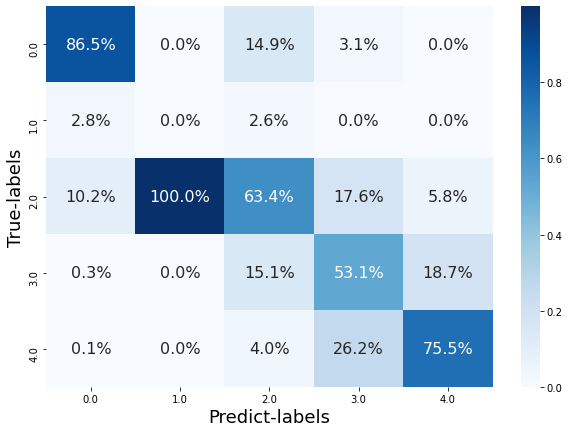

=========joint_name cup model2 validation===========


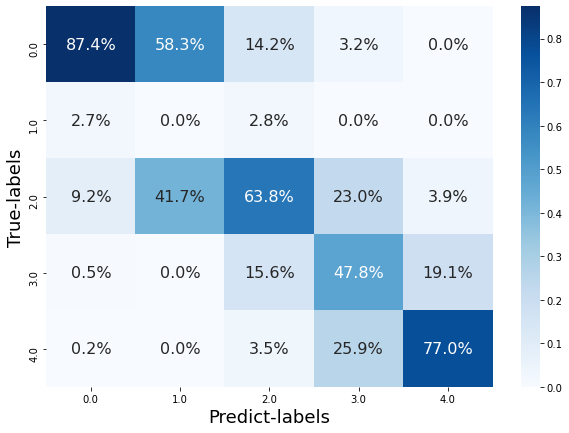

=========joint_name cup ensem validation===========


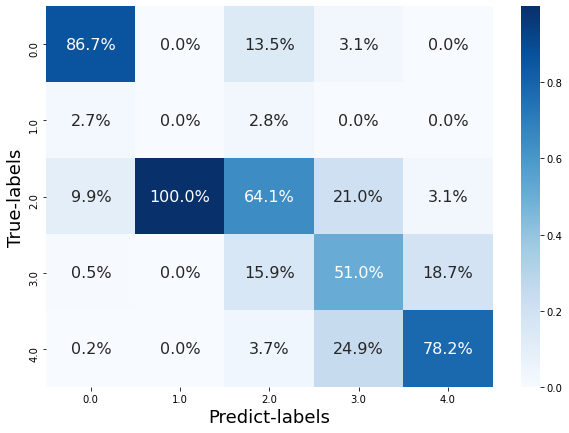

=========joint_name mul model1 validation===========


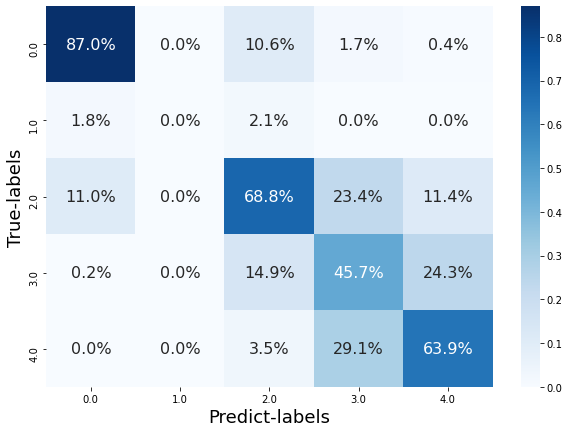

=========joint_name mul model2 validation===========


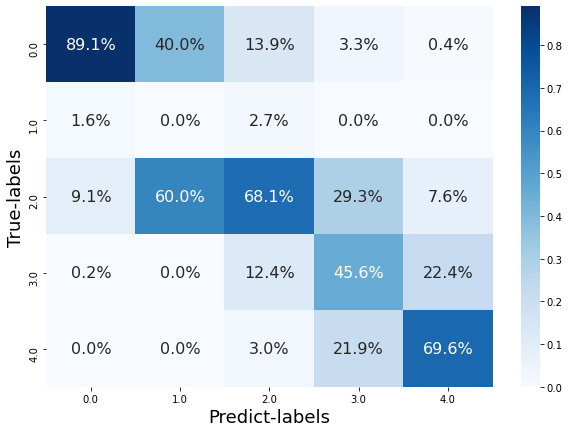

=========joint_name mul ensem validation===========


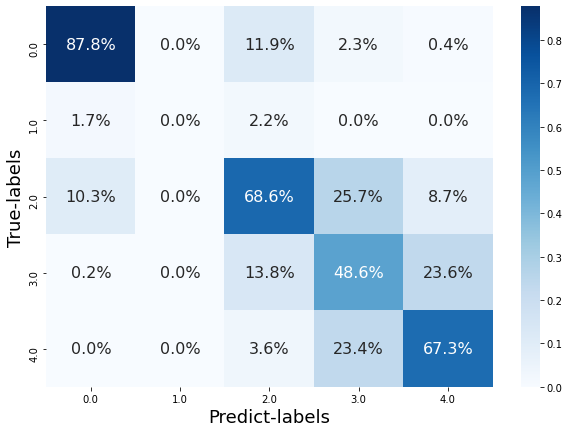

=========joint_name rad model1 validation===========


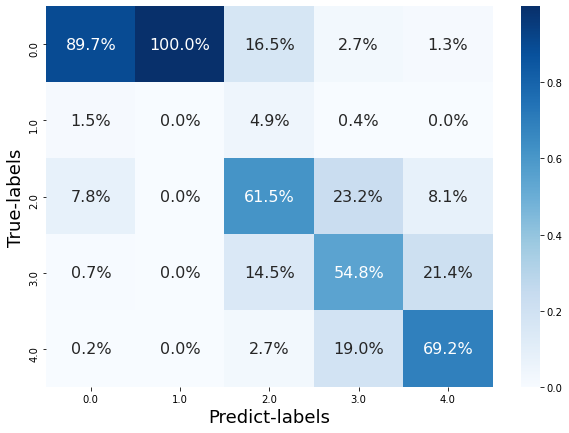

=========joint_name rad model2 validation===========


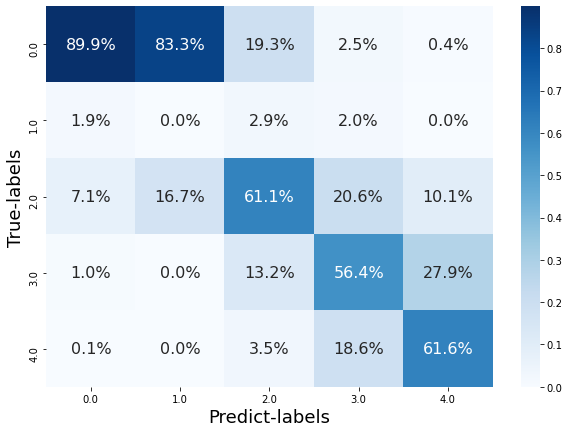

=========joint_name rad ensem validation===========


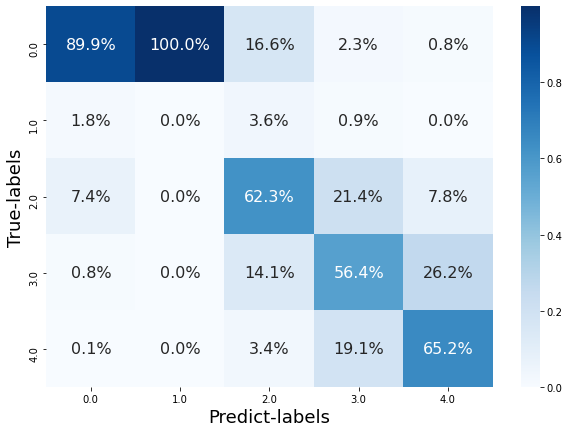

100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


=========joint_name cup in test set===========
[[130   3   9   0   0]
 [  0   0   0   0   0]
 [ 10   1  31  11   1]
 [  1   0   1  17  10]
 [  0   0   5   8  31]]
coef1: 0.8932
rmse1: 0.7291


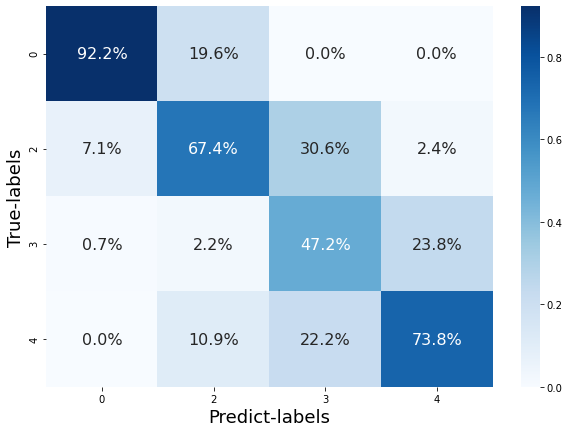

=========joint_name mul in test set===========
[[138   2  16   0   0]
 [  0   0   0   0   0]
 [  6   3  40  12   4]
 [  1   0   6   6   2]
 [  1   0   3   8  21]]
coef2: 0.8456
rmse2: 0.8043


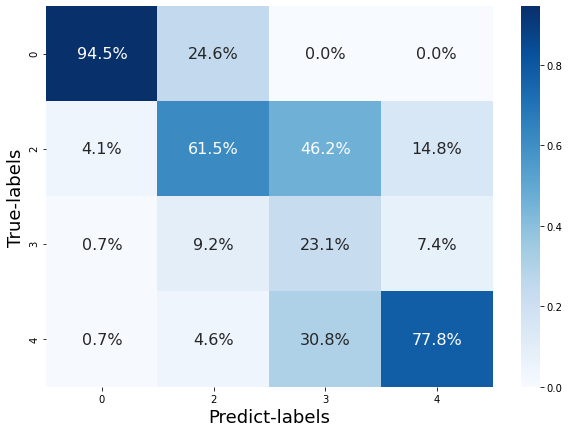

=========joint_name rad in test set===========
[[144   1  14   2   0]
 [  0   0   0   0   0]
 [ 10   3  38   7   3]
 [  0   0   3   8   5]
 [  0   0   3   6  22]]
coef3: 0.8566
rmse3: 0.7784


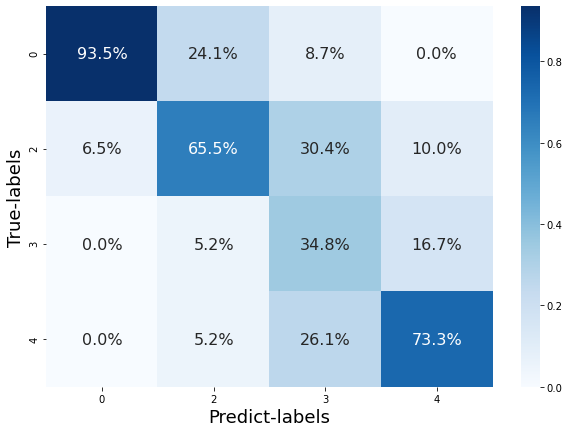

============All results===========
============best score of coef in each cross validation===========
   cup_model1_coef  mul_model1_coef  rad_model1_coef  cup_model2_coef  \
0         0.911367         0.890507         0.888320         0.909981   
1         0.876809         0.839096         0.845282         0.864767   
2         0.892379         0.846517         0.873700         0.892556   
3         0.906638         0.871269         0.865262         0.915558   
4         0.903754         0.864864         0.860483         0.900266   
5         0.879835         0.858755         0.876940         0.867435   
6         0.864613         0.859085         0.851030         0.892221   
7         0.891667         0.855339         0.857279         0.897749   
8         0.841889         0.858852         0.822041         0.848495   

   mul_model2_coef  rad_model2_coef  cup_ensem_coef  mul_ensem_coef  \
0         0.902279         0.867408        0.912838        0.887404   
1         0.832232       

In [9]:
def main():
    config = vars(parse_args())
    col_list = pd.read_csv(config['check_path'] + config['all_label']).columns
    if config['name'] is None:
        config['name'] = '%s_%s_%s_%s_%s_%sfolds_inc_rat%s_mutual%s' % (config['dataset'], config['scheduler'], config['arch'], config['over_samp_param'], config['optimizer1'], config['fold_num'], config['inclusion_ratio'], config['mutual'])
    print(config['check_path'] + 'damage_pred_log/models/%s' % config['name'])
    os.makedirs(config['check_path'] + 'damage_pred_log/models/%s' % config['name'], exist_ok=True)

    print('-' * 20)
    for key in config:
        print('%s: %s' % (key, config[key]))
    print('-' * 20)

    with open(config['check_path'] + 'damage_pred_log/models/%s/config.yml' % config['name'], 'w') as f:
        yaml.dump(config, f)

    cudnn.benchmark = True
    img_ids, img_ids_test, img_labels, test_labels, img_id_label_train_val, img_id_label_test = label_maker(config)
    
    print("number of images in train and validation ",len(img_id_label_train_val), ", number of images in test ", len(img_id_label_test)) 
      
    best_score_list = []
    kf = KFold(n_splits=config['fold_num'], shuffle=True, random_state=1)
    K_num = 0
    score_pred_model1 = [[],[],[]]
    score_pred_model2 = [[],[],[]]
    score_pred_ensem = [[],[],[]]
    label_list_merge = [[],[],[]]
    for train_index, val_index in kf.split(img_ids):
        print(f"======start {K_num} fold-th closs validation======")
        train_index = over_sampling(img_id_label_train_val, train_index, config['over_samp_param'], config['task_type'])
        train_ids, val_ids = itemgetter(*train_index)(img_ids), itemgetter(*val_index)(img_ids)
        
        #create loader
        train_labels = []
        val_labels = []
        for i in range(config['num_tasks']):
            train_labels.append(itemgetter(*train_index)(img_labels[i]))
            val_labels.append(itemgetter(*val_index)(img_labels[i]))

        train_loader, val_loader, test_loader = make_loader(train_ids, val_ids, img_ids_test,train_labels, val_labels, test_labels, config)
        
        #create model, optimizer, criterion 
        print("=> creating model %s" % config['arch'])
        model1 = archs.__dict__[config['arch']]()
        model1 = model1.cuda() 
        params1 = filter(lambda p: p.requires_grad, model1.parameters())
        criterion1 = losses.__dict__[config['loss1']]().cuda()
        optimizer1 = optim_maker(params1, config['optimizer1'], config)
        
        if config['mutual'] == 'yes':
            model2 = archs.__dict__[config['arch']]()
            model2 = model2.cuda()
            params2 = filter(lambda p: p.requires_grad, model2.parameters())
            criterion2 = losses.__dict__[config['loss2']]().cuda()
            optimizer2 = optim_maker(params2, config['optimizer2'], config)
            log = OrderedDict([('epoch', []),('lr', []),('loss1', []),('loss2', []),('val_loss1', []),('val_loss2', []),('coef1', []),('coef2', [])])
        else:
            log = OrderedDict([('epoch', []),('lr', []),('loss1', []),('val_loss1', []),('coef1', [])])
        
        #create scheduler
        scheduler = scheduler_maker(optimizer1, config)
        
        best_coef = [0.0,0.0]
        at_best_list=[[[0,0,0,0]],[[0,0,0,0]]]
        for epoch in range(config['epochs']):
            print('Epoch [%d/%d]' % (epoch, config['epochs']))
            if config['scheduler'] == 'CosineAnnealingLR':  
                lr = scheduler.get_last_lr()[0]
            else:
                lr = config['lr']
            print("lr", lr)

            # train for one epoch
            if config['mutual'] == 'yes': 
                model, criterion, optimizer = [model1, model2], [criterion1, criterion2], [optimizer1, optimizer2]
            else:
                model, criterion, optimizer = [model1], [criterion1], [optimizer1]
         
            #Code to resume from the specified Fold.
            if K_num < config['restart_fold_num']:
                restart = 'off'   
                print(f"======Display the results of the {K_num} fold-th closs validation set======")
                best_score, pred_model1_list, pred_model2_list, pred_ensem_list, label_list = validate_bestmodel_restart(config, K_num, val_loader, model) 
                K_num += 1 
                break
            elif K_num == config['restart_fold_num']:
                restart = 'on'
            else:
                pass  
            
            #model training
            train_log = train(train_loader, model, criterion, optimizer, config)
      
            #evaluate on validation set
            at_best_list = validate(val_loader, model, criterion, epoch, scheduler, lr, config, train_log, log, K_num, best_coef, at_best_list, restart)

        #best model validation
        if config['restart_fold_num'] == 0:
            best_score, pred_model1_list, pred_model2_list, pred_ensem_list, label_list = validate_bestmodel(at_best_list, config, K_num, val_loader, model)
        elif (K_num >= config['restart_fold_num'])&(restart == 'on'): 
            best_score, pred_model1_list, pred_model2_list, pred_ensem_list, label_list = validate_bestmodel(at_best_list, config, K_num, val_loader, model)
        else:
            pass    
        
        best_score_list.append(best_score)

        for i in range(config['num_tasks']):
            score_pred_model1[i].extend(pred_model1_list[i])
            score_pred_model2[i].extend(pred_model2_list[i])
            score_pred_ensem[i].extend(pred_ensem_list[i])
            label_list_merge[i].extend(label_list[i])
            
        if restart == 'on':
            K_num += 1 
        else:
            pass  
        
    val_test='val'
    for i in range(config['num_tasks']):
        if config['mutual'] == 'yes': 
            print("=========joint_name", col_list[i+1], "model1 validation===========")
            cm_visualize(label_list_merge, score_pred_model1, config, val_test, i)
            print("=========joint_name", col_list[i+1], "model2 validation===========")
            cm_visualize(label_list_merge, score_pred_model2, config, val_test, i)
            print("=========joint_name", col_list[i+1], "ensem validation===========")
            cm_visualize(label_list_merge, score_pred_ensem, config, val_test, i)
        else:
            print("=========joint_name", col_list[i+1], "validation===========")
            cm_visualize(label_list_merge, score_pred_ensem, config, val_test, i)     
            
    #evaluate on test set
    test_evaluation = test(model, config, test_loader, best_score_list)

if __name__ == '__main__':
    main()

# Score-CAM visualization

In [10]:
from dataset import Dataset_pred_only, make_loader_for_ScoreCAM
from natsort import natsorted
import torchvision.transforms as transforms
import torch.nn.functional as F
from cam import ScoreCAM, ScoreCAM_multitask
from utils import visualize, reverse_normalize

In [11]:
def parse_args2():
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default=None,
                        help='model name')
    parser.add_argument('--joint_dir_name', default=None,
                        help='joint directory name')    
    parser.add_argument('--score_list_save_dir', default="test_score_list",
                        help='score_list_save_dir')   
    parser.add_argument('--all_label', default='RACAM_JSN_finger_full_score_2684.csv',
                        help='Enter the name of the csv file for the true label')
    parser.add_argument('--fold_num', default=None,type=str,
                        help='Enter number of fold of the model you want to visualize.') 
    parser.add_argument('--mutual_num', default=1, type=str,
                        help='Enter the number of which of the mutual models you want to visualize.') 
    parser.add_argument('--pred_num', default=0, type=int,
                        help='Outputs joint images where the input numerical value and the model predicted score are identical.') 
    parser.add_argument('--label_num', default=0, type=int,
                        help='Outputs joint images where the input numerical value and the true label are identical.') 
    
    """
    #### joint_num ####
    If you are visualizing a single-task model (finger Erosion, PIP, MCP), enter 1. 
    If you are visualizing a multi-tasking model that outputs multiple scores from a single image otherwise, enter the number of the joint. 
    The joint numbers correspond to the order of the columns in the label csv data.
    """
    parser.add_argument('--joint_num', default=1, type=int,
                        help='joint number') 
    
    config2 = parser.parse_args(args=['--name', 'racam_Full', '--joint_dir_name', 'racam', '--mutual_num', '1',  '--fold_num', '0', '--pred_num', '0', '--label_num', '0', '--joint_num', '3'])

    return config2

--------------------
all_label: RACAM_JSN_finger_full_score_2684.csv
arch: Effnet_JSN_CE_RA_CAM
batch_size: 32
check_path: F:/SHS_AI/
dataset: racam
epochs: 200
factor: 0.1
fold_num: 9
img_ext: .jpg
inclusion_ratio: 1.0
input_channels: 3
input_h: 100
input_w: 100
loss1: CEL
loss2: kl_divergence
lr: 0.005
min_lr: 1e-06
momentum: 0.9
mutual: yes
name: racam_Full
nesterov: False
num_tasks: 3
num_workers: 1
optimizer1: Adabound
optimizer2: Adabound
over_samp_param: 0.2
patience: 3
restart_fold_num: 0
scheduler: CosineAnnealingLR
task_type: narrowing
test_ratio: 0.1
weight_decay: 0.0001
--------------------
=> creating model Effnet_JSN_CE_RA_CAM


  0%|          | 0/1 [00:00<?, ?it/s]

======rad_n1 rad ======
pred     0
label    0
Name: 0, dtype: object


C:\Users\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


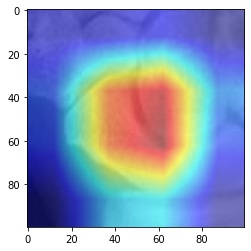

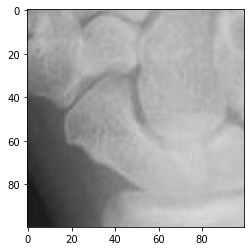

100%|██████████| 1/1 [00:05<00:00,  5.11s/it]


In [12]:
def main():
    config = vars(parse_args())
    config2 = vars(parse_args2())
    col_list = pd.read_csv(config['check_path'] + config['all_label']).columns

    df_merge = pd.read_csv(config['check_path'] + "damage_pred_log/models/" + config['name'] + "/" + "pred" + config2['mutual_num'] + "_labeldata_K" + config2['fold_num'] + ".csv")
    df_merge[df_merge["joint_number"]==int(config2["joint_num"])]
    read_df = df_merge[df_merge["pred"]==int(config2['pred_num'])] 
    read_df = read_df[read_df["label"]==int(config2['label_num'])]
    
    #config2['name'] = config2['state_dict_dir_name']
    with open(config['check_path'] + 'damage_pred_log/models/%s/config.yml' % config2['name'], 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        
    print('-'*20)
    for key in config.keys():
        print('%s: %s' % (key, str(config[key])))
    print('-'*20)

    cudnn.benchmark = True

    # create model
    print("=> creating model %s" % config['arch'])
    model = archs.__dict__[config['arch']]()
    criterion1 = losses.__dict__[config['loss1']]().cuda()
    model = model.cuda()

    val_ids = list(read_df['img_id'] + config['img_ext'])
    
    #load model weight
    model.load_state_dict(torch.load(config['check_path'] + 'damage_pred_log/models/%s/model%s_%s.pth' % (config2['name'],config2['fold_num'], config2['mutual_num'])))
    
    model.eval()
    se1=model.selayer1.eval()
    effnet=model.effnet.eval()
    se2=model.selayer2.eval()
    avgpool=model.avg_pool.eval()
    
    pred_loader = make_loader_for_ScoreCAM(val_ids, config, config2)

    k=0
    for input, ID in tqdm(pred_loader, total=len(pred_loader)):
        input = input.cuda()
        pred1= model(input)
        if k>=1:
            break
        for i in range(input.size(0)):
            input_i1 = input[i].unsqueeze(0)

            print(f'======{ID["img_id"][i], col_list[config2["joint_num"]]}======')
            read_df2 = read_df.reset_index(drop=True)
            print(read_df2.iloc[k,0:2])
            
            # the target layer you want to visualize
            target_layer1 = model.effnet[4]
            
            if config["num_tasks"] == 1:
                wrapped_model1 = ScoreCAM(model, target_layer1)
            else:
                wrapped_model1 = ScoreCAM_multitask(model, target_layer1,config2['joint_num']-1)
            
            #visualize heatmap
            cam1, idx = wrapped_model1(input_i1)
            img1 = reverse_normalize(input_i1)
            heatmap1 = visualize(img1, cam1)
            hm1 = (heatmap1.squeeze().numpy().transpose(1, 2, 0))
            plt.imshow(hm1)
            plt.show()
            
            #visualize original image
            img3 = cv2.imread(config['check_path']+config2['joint_dir_name'] + "/" + ID["img_id"][i]) 
            plt.imshow(img3)
            plt.show()
            k +=1
            break
            torch.cuda.empty_cache()
if __name__ == '__main__':
    main()

# make prediction score list

In [14]:
def main():
    config = vars(parse_args())
    config2 = vars(parse_args2())
    
    col_list = pd.read_csv(config['check_path'] + config2['all_label']).columns
    
    with open(config['check_path'] + 'damage_pred_log/models/%s/config.yml' % config2['name'], 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        
    print('-'*20)
    for key in config.keys():
        print('%s: %s' % (key, str(config[key])))
    print('-'*20)

    cudnn.benchmark = True
    
    model = [[],[]]
    model_list = [[],[]]
    for K_n in range(config['fold_num']):
        if config['mutual'] == 'yes':
            mutual_num=2
        else:
            mutual_num=1
        for i in range(mutual_num):
            model[i].append(K_n)
            model[i][K_n] = archs.__dict__[config['arch']]()
            model[i][K_n] = model[i][K_n].cuda()
            model[i][K_n].load_state_dict(torch.load(config['check_path'] + 'damage_pred_log/models/' + config2['name'] + f'/model{K_n}_{i+1}.pth'))
            model_list[i].append(model[i][K_n])
            model_list[i][K_n].eval()
            
    img_ids = []
    for curDir, dirs, files in tqdm(natsorted(os.walk(config['check_path'] + "/" + config2['joint_dir_name']))):
        for i, file in enumerate(files):
            img_ids.append(file)

    pred_loader = make_loader_for_ScoreCAM(img_ids, config, config2)

    pred_model1 = [[],[],[]]
    pred_model2 = [[],[],[]]
    pred_list = [[],[],[]]
    ID_list = []
    with torch.no_grad():
        for input, ID in tqdm(pred_loader, total=len(pred_loader)):
            input = input.cuda()    

            if config['mutual'] == 'yes':
                pred_ensem = [0,0,0]
                for K in range(config['fold_num']):  
                    if config['num_tasks'] == 1:
                        pred_model1[0] = model_list[0][K](input)
                        pred_model2[0] = model_list[1][K](input)
                    elif config['num_tasks'] == 2:
                        pred_model1[0], pred_model1[1] = model_list[0][K](input)
                        pred_model2[0], pred_model2[1]= model_list[1][K](input)
                    elif config['num_tasks'] == 3:
                        pred_model1[0], pred_model1[1], pred_model1[2] = model_list[0][K](input)
                        pred_model2[0], pred_model2[1], pred_model2[2]= model_list[1][K](input)

                    for i in range (config['num_tasks']):
                        pred_ensem[i] = pred_ensem[i] + (pred_model1[i] + pred_model2[i])

                for i in range (config['num_tasks']):
                    pred_ensem[i] = pred_ensem[i].max(1)[1].to('cpu').detach().numpy().copy()
                    pred_list[i].extend(pred_ensem[i])
                
            else:
                pred = [0,0,0]
                for K in range(config['fold_num']): 
                    if config['num_tasks'] == 1:
                        pred_model1[0] = model_list[0][K](input)
                    elif config['num_tasks'] == 2:
                        pred_model1[0], pred_model1[1] = model_list[0][K](input)
                    elif config['num_tasks'] == 3:
                        pred_model1[0], pred_model1[1], pred_model1[2] = model_list[0][K](input)                         
                    for i in range (config['num_tasks']):
                        pred[i] = pred[i] + pred_model1[i]
                        
                for i in range (config['num_tasks']):    
                    pred[i] = pred[i].max(1)[1].to('cpu').detach().numpy().copy()
                    pred_list[i].extend(pred[i])                
                
            ID_list.extend(ID["img_id"])  
 

        for i in range (config['num_tasks']):
            ID_list = pd.DataFrame(ID_list).set_axis(['ID'], axis='columns', inplace=False)
            pred_list[i] = pd.DataFrame(pred_list[i]).set_axis(['pred'], axis='columns', inplace=False)
            if i == 0:
                pass
            else:
                pred_list[0] = pd.concat([pred_list[0], pred_list[i]], axis=1)
        pred_list[0] = pred_list[0].set_axis(col_list[1:1+config['num_tasks']], axis='columns', inplace=False)
        
        All_data_ensem=pd.concat([ID_list, pred_list[0]], axis=1)
        
        #score_list_save
        All_data_ensem.to_csv(config['check_path'] + config2['score_list_save_dir'] + "/" + 'pred_list' + '_' + config2['name'] + '.csv', index=False)
        
if __name__ == '__main__':
    main()

--------------------
all_label: RACAM_JSN_finger_full_score_2684.csv
arch: Effnet_JSN_CE_RA_CAM
batch_size: 32
check_path: F:/SHS_AI/
dataset: racam
epochs: 200
factor: 0.1
fold_num: 9
img_ext: .jpg
inclusion_ratio: 1.0
input_channels: 3
input_h: 100
input_w: 100
loss1: CEL
loss2: kl_divergence
lr: 0.005
min_lr: 1e-06
momentum: 0.9
mutual: yes
name: racam_Full
nesterov: False
num_tasks: 3
num_workers: 1
optimizer1: Adabound
optimizer2: Adabound
over_samp_param: 0.2
patience: 3
restart_fold_num: 0
scheduler: CosineAnnealingLR
task_type: narrowing
test_ratio: 0.1
weight_decay: 0.0001
--------------------


100%|██████████| 387/387 [01:45<00:00,  3.66it/s]
